In [1]:
from skimage import io,filters, img_as_float
from skimage.transform import rescale,resize,downscale_local_mean
from image_registration import chi2_shift
#from Ipython.display import display
from IPython.display import display
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import glob
from skimage.filters import unsharp_mask
import pandas as pd
import os
import seaborn as sns
from skimage.metrics import structural_similarity
import cv2    
from skimage import exposure, io, util, measure
from skimage import img_as_ubyte
from pystackreg import StackReg
import gemmi
#machine learning models:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from scipy.special import gamma, digamma
from scipy.optimize import least_squares
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet

### Reading whole data

In [2]:
os.chdir('M:/LIU/Thesis/my thesis/Nicholas article/data/data/')

In [3]:
data={}
for i, file_name in enumerate(os.listdir()):
    mtz_obj = gemmi.read_mtz_file(f'{file_name}/{file_name}.dimple.mtz')
    df = pd.DataFrame(data=mtz_obj.array, columns=mtz_obj.column_labels())
    data[i]=df
    

In [4]:
data

{0:           H    K     L  FreeR_flag            F       SIGF            FC  \
 0       0.0  0.0   4.0         2.0          NaN        NaN  20890.607422   
 1       0.0  0.0   8.0        13.0  2270.359863  27.887918    573.453125   
 2       0.0  0.0  12.0        18.0  3427.665527  42.041695   4873.706543   
 3       0.0  0.0  16.0         6.0          NaN        NaN   3865.468506   
 4       0.0  0.0  20.0         6.0  1080.997314  19.234512    221.217300   
 ...     ...  ...   ...         ...          ...        ...           ...   
 41678  41.0  4.0   4.0         5.0    54.098473  20.303036     67.095802   
 41679  41.0  4.0   5.0        10.0   105.340118  16.866810     81.631927   
 41680  41.0  4.0   6.0        19.0    50.930729  21.684111     46.157448   
 41681  41.0  5.0   0.0        10.0    31.808048  23.298405      3.685123   
 41682  41.0  5.0   1.0        13.0          NaN        NaN     40.896141   
 
              PHIC       FC_ALL    PHIC_ALL      2FOFCWT   PH2FOFCWT  \

### merging the data

In [5]:

merged_df=data[0]
for i in range(1,len(data)):
    merged_df=pd.merge(merged_df,data[i],on=['H','K','L'],suffixes= ('_left','_right'))

In [6]:
merged_df=merged_df[['H','K','L']]

In [7]:
#creating new data with same hkl
new_data={}
for i in range(len(data)):
    new_data[i]=pd.merge(merged_df,data[i],on=['H','K','L'],suffixes= ('_Left','_right'))

In [8]:
new_data[0]

H    K     L  FreeR_flag            F       SIGF            FC  \
0       0.0  0.0   4.0         2.0          NaN        NaN  20890.607422   
1       0.0  0.0   8.0        13.0  2270.359863  27.887918    573.453125   
2       0.0  0.0  12.0        18.0  3427.665527  42.041695   4873.706543   
3       0.0  0.0  16.0         6.0          NaN        NaN   3865.468506   
4       0.0  0.0  20.0         6.0  1080.997314  19.234512    221.217300   
...     ...  ...   ...         ...          ...        ...           ...   
13441  28.0  0.0   1.0        16.0   262.330780   5.346642    258.792816   
13442  28.0  0.0   2.0         8.0   469.801300   4.887661    516.117371   
13443  28.0  1.0   0.0        19.0   446.478485   4.875942    388.013275   
13444  28.0  1.0   1.0         2.0    79.483101   9.284325     19.389311   
13445  28.0  1.0   2.0        13.0   288.922882   3.733487    306.245941   

             PHIC       FC_ALL    PHIC_ALL      2FOFCWT   PH2FOFCWT  \
0      180.000015  3323.593750  180.000061  3323.593750  180.000061   
1      359.999969  1146.901611  360.000000  3393.818115  360.000000   
2      179.999985  3219.302734  179.999969  3636.028320  179.999969   
3      180.000015  3165.577148  180.000015  3165.577148  180.000015   
4        0.000000    63.633255    0.000362   820.633972    0.000362   
...           ...          ...         ...          ...         ...   
13441  315.000000   247.447525  315.000000   277.214050  315.000000   
13442   90.000000   501.171997   90.000000   438.430603   90.000000   
13443    0.000009   381.621490    0.000010   511.335480    0.000010   
13444    6.132946    21.212502    7.140066    36.835293    7.140066   
13445  298.238647   299.118713  297.906250   271.753937  297.906250   

            FOFCWT    PHFOFCWT       FOM    FC_ALL_LS  PHIC_ALL_LS  
0         0.000000    0.000000  0.000000  3397.691406   180.000061  
1      2246.916504  360.000000  1.000000  1214.215820   360.000000  
2       416.725586  179.999969  1.000000  3557.014648   179.999969  
3         0.000000    0.000000  0.000000  3431.030762   180.000015  
4       757.000732    0.000362  0.409005    89.786179     0.000233  
...            ...         ...       ...          ...          ...  
13441    29.766502  315.000000  1.000000   252.250870   315.000000  
13442    62.741394  270.000000  1.000000   516.240601    90.000000  
13443   129.713989    0.000010  1.000000   396.447052     0.000011  
13444    15.622791    7.140065  0.365158    23.506723     7.699631  
13445    27.364773  117.906242  0.987933   309.288239   297.683899  

[13446 rows x 17 columns]

In [9]:
array_4d = np.zeros((len(data), 60, 60, 120))
for i in range(len(data)):
    mtz_obj.set_data(np.array(new_data[i]))
    ma_file = mtz_obj.transform_f_phi_to_map(f='2FOFCWT',phi='PH2FOFCWT')
    FT_array_all=ma_file.array
    FT_array_3d=np.around(FT_array_all,2) 
    array_4d[i, :, :, :] = FT_array_3d

In [10]:
array_4d.shape

(226, 60, 60, 120)

#### check structural_similarity in measurements

In [11]:
print("Similarity using structural_similarity is: ",structural_similarity(array_4d[1,:,:,:],array_4d[2,:,:,:] ))

Similarity using structural_similarity is:  0.7631907672687249


#### Visualizing the data

In [12]:
array_4d.shape

(226, 60, 60, 120)

#### Alignment

In [11]:
import SimpleITK as sitk

def align_images(fixed_image, moving_image):
    # Convert numpy arrays to SimpleITK images
    fixed_image = sitk.GetImageFromArray(fixed_image)
    moving_image = sitk.GetImageFromArray(moving_image)
    
    # Set up the registration method
    registration_method = sitk.ImageRegistrationMethod()
    #provides a framework for implementing various registration algorithm
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    '''The MMI metric measures the similarity between two images by computing the mutual information between their intensity
    histograms.Mutual information is a measure of the amount of information shared between two variables, and it is often used 
    as a similarity metric in image registration. The number of histogram bins determines the number of intensity values
    that will be used to build the histograms, with a higher number of bins providing a more 
    fine-grained measurement of similarity.'''
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    #To optimize MMI function
    registration_method.SetInitialTransform(sitk.TranslationTransform(fixed_image.GetDimension()))
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Execute the registration
    final_transform = registration_method.Execute(fixed_image, moving_image)
    
    # Apply the transformation to the moving image
    moving_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    '''The Resample function is used to resample the moving image so that it is aligned with the fixed image.'''
    # Convert the aligned moving image back to a numpy array
    moving_image = sitk.GetArrayFromImage(moving_image)
    
    return moving_image

#fixed_image = np.random.rand(60, 60, 120)
#moving_image = np.random.rand(60, 60, 120)
aligned_image = align_images(array_4d[0,:,:,:], array_4d[1,:,:,:])


In [12]:
array_4d_new = np.zeros((len(data), 60, 60, 120))
array_4d_new[0, :, :, :]=array_4d[0,:,:,:]
for i in range(1,len(data)):
    array_4d_new[i, :, :, :]=align_images(array_4d[0,:,:,:], array_4d[i,:,:,:])
    

In [13]:
array_4d_new.shape

(226, 60, 60, 120)

Below method to test alignment dodn't work weill because sopme similarities are a little higher before alignment 

In [19]:
print("Similarity using structural_similarity is: ",np.round(structural_similarity(array_4d[0,:,:,:],array_4d[100,:,:,:] ),5))

Similarity using structural_similarity is:  0.77728


In [20]:
print("Similarity using structural_similarity is: ",np.round(structural_similarity(array_4d_new[0,:,:,:],array_4d_new[100,:,:,:] ),5))

Similarity using structural_similarity is:  0.77727


### To test the alignment:

In [18]:
bef_align_0=np.where(array_4d[0]!=0,1,0)
bef_align_1=np.where(array_4d[1]!=0,1,0)
np.count_nonzero(bef_align_0-bef_align_1)

20548

In [19]:
after_align_0=np.where(array_4d_new[0]!=0,1,0)
after_align_1=np.where(array_4d_new[1]!=0,1,0)
np.count_nonzero(after_align_0-after_align_1)

9965

the values have been reduced from 20548 to 9965, and almost the same range for other measurements

But this type of testing the alignment is not useful because maybe we have some other photoes in other sides.

### Flatten the data:

In [14]:

def flatten_4d_array(arr):
    return np.array(arr).reshape(-1, np.prod(arr.shape[-3:]))


In [15]:
flatten_4d_array(array_4d_new).shape


(226, 432000)

##### To test the flatten function
Actually we have 60 matrices with shape of 60*120 . first arrays come from first matrix and the last arrays come from the 59th matrix.

In [16]:
data_flatten=flatten_4d_array(array_4d_new)

### converting to a dataframe

In [17]:
cols=[]
for j in range(data_flatten.shape[1]):
     cols.append('Pixel_{}'.format(j+1))
Measurements=[]
for k in range(data_flatten.shape[0]):
     Measurements.append('D{}'.format(k+1))

In [18]:
df_flatten = pd.DataFrame(data_flatten,
           columns=cols,index=Measurements)
df_flatten

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D1    0.300000  0.040000 -0.270000 -0.280000 -0.470000 -0.310000 -0.060000   
D2   -0.029921  0.019818 -0.200119 -0.350066 -0.479891 -0.439690 -0.189920   
D3   -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D4    0.089988  0.009961 -0.250009 -0.310015 -0.409994 -0.369962 -0.119994   
D5    0.229859  0.029788 -0.270050 -0.340120 -0.509908 -0.379816 -0.120035   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D1   -0.160000 -0.390000  0.250000  ...      0.490000      0.320000   
D2   -0.200050 -0.319442  0.270484  ...      0.369711      0.049611   
D3   -0.209545 -0.399831  0.239709  ...      0.359973      0.169925   
D4   -0.080029 -0.269921  0.250090  ...      0.479635      0.229646   
D5   -0.170163 -0.399604  0.160410  ...      0.559740      0.339370   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D1       -0.320000      0.080000     -0.350000     -0.560000     -0.110000   
D2       -0.379584      0.079738     -0.210163     -0.389584      0.069801   
D3       -0.349902      0.329909     -0.300042     -0.589903      0.079948   
D4       -0.309917     -0.019823     -0.379838     -0.479763      0.000348   
D5       -0.389725     -0.000126     -0.300059     -0.509637     -0.099995   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D1       -0.290000      0.100000      0.400000  
D2       -0.149729      0.150163      0.330000  
D3       -0.279903      0.390042      0.680000  
D4       -0.089812      0.249859      0.389802  
D5       -0.269688      0.100140      0.329947  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[226 rows x 432000 columns]

# To do flatten and make dataframe for unaligned data:

In [23]:
data_flatten_unaligned=flatten_4d_array(array_4d)

In [24]:
cols=[]
for j in range(data_flatten_unaligned.shape[1]):
     cols.append('Pixel_{}'.format(j+1))
Measurements=[]
for k in range(data_flatten_unaligned.shape[0]):
     Measurements.append('D{}'.format(k+1))

In [25]:
df_flatten_unaligned = pd.DataFrame(data_flatten_unaligned,
           columns=cols,index=Measurements)
df_flatten_unaligned

Pixel_1  Pixel_2  Pixel_3  Pixel_4  Pixel_5  Pixel_6  Pixel_7  Pixel_8  \
D1       0.30     0.04    -0.27    -0.28    -0.47    -0.31    -0.06    -0.16   
D2      -0.03     0.02    -0.20    -0.35    -0.48    -0.44    -0.19    -0.20   
D3      -0.02    -0.11    -0.44    -0.53    -0.71    -0.45    -0.16    -0.21   
D4       0.09     0.01    -0.25    -0.31    -0.41    -0.37    -0.12    -0.08   
D5       0.23     0.03    -0.27    -0.34    -0.51    -0.38    -0.12    -0.17   
...       ...      ...      ...      ...      ...      ...      ...      ...   
D222     0.29    -0.08    -0.47    -0.50    -0.63    -0.37    -0.12    -0.13   
D223     0.17    -0.13    -0.60    -0.42    -0.54    -0.48    -0.13    -0.16   
D224     0.30    -0.17    -0.57    -0.44    -0.64    -0.45    -0.14    -0.13   
D225     0.19    -0.17    -0.51    -0.41    -0.60    -0.43    -0.11    -0.12   
D226     0.15    -0.22    -0.59    -0.46    -0.63    -0.44    -0.09    -0.13   

      Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  Pixel_431993  \
D1      -0.39      0.25  ...          0.49          0.32         -0.32   
D2      -0.32      0.27  ...          0.37          0.05         -0.38   
D3      -0.40      0.24  ...          0.36          0.17         -0.35   
D4      -0.27      0.25  ...          0.48          0.23         -0.31   
D5      -0.40      0.16  ...          0.56          0.34         -0.39   
...       ...       ...  ...           ...           ...           ...   
D222    -0.45      0.11  ...          0.51          0.37         -0.31   
D223    -0.35      0.25  ...          0.39          0.25         -0.40   
D224    -0.38      0.15  ...          0.45          0.31         -0.30   
D225    -0.37      0.18  ...          0.46          0.34         -0.28   
D226    -0.40      0.10  ...          0.44          0.29         -0.31   

      Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  Pixel_431998  \
D1            0.08         -0.35         -0.56         -0.11         -0.29   
D2            0.08         -0.21         -0.39          0.07         -0.15   
D3            0.33         -0.30         -0.59          0.08         -0.28   
D4           -0.02         -0.38         -0.48         -0.00         -0.09   
D5           -0.00         -0.30         -0.51         -0.10         -0.27   
...            ...           ...           ...           ...           ...   
D222          0.19         -0.38         -0.62         -0.11         -0.39   
D223          0.22         -0.28         -0.68         -0.05         -0.35   
D224          0.23         -0.38         -0.68         -0.10         -0.33   
D225          0.22         -0.32         -0.66         -0.13         -0.35   
D226          0.26         -0.33         -0.70         -0.13         -0.31   

      Pixel_431999  Pixel_432000  
D1            0.10          0.40  
D2            0.15          0.33  
D3            0.39          0.68  
D4            0.25          0.39  
D5            0.10          0.33  
...            ...           ...  
D222          0.29          0.58  
D223          0.17          0.55  
D224          0.20          0.48  
D225          0.18          0.49  
D226          0.27          0.52  

[226 rows x 432000 columns]

##### 2nd way to test alignment again

In [39]:
cor_unaligned=np.corrcoef(df_flatten_unaligned)
np.round(np.sum(cor_unaligned[0,]),4)

217.9499

In [40]:
cor_aligned=np.corrcoef(df_flatten)
np.round(np.sum(cor_aligned[0,]),4)

217.9556

Increasing the correlation coefficient of first measurment with others prove the result of alignment


## Data exploration

##### 
# create a sample dataframe



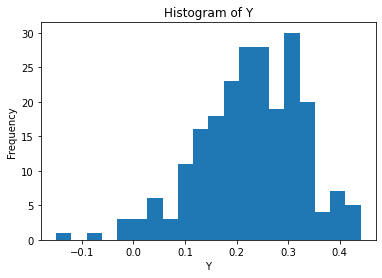

In [41]:
# plot the histogram
plt.hist(df_flatten['Pixel_1'], bins=20)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Histogram of Y')
plt.show()


<AxesSubplot:xlabel='Pixel_1', ylabel='Density'>

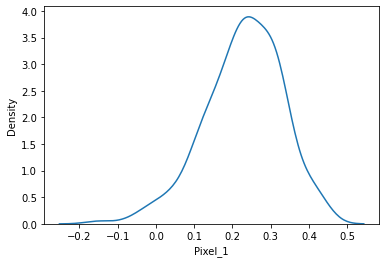

In [42]:
import seaborn as sns
import numpy as np

# Generate some random data


# Create a KDE plot
sns.kdeplot(df_flatten['Pixel_1'])


In [43]:


# Generate some random data
data = df_flatten['Pixel_1']

# Calculate summary statistics
mean = np.mean(data)
median = np.median(data)
#mode = np.mode(data)
std = np.std(data)
pct_25, pct_50, pct_75 = np.percentile(data, [25, 50, 75])

print(f"Mean: {mean}")
print(f"Median: {median}")
#print(f"Mode: {mode}")
print(f"Standard deviation: {std}")
print(f"25th percentile: {pct_25}")
print(f"50th percentile: {pct_50}")
print(f"75th percentile: {pct_75}")


Mean: 0.2285530939455322
Median: 0.23512733691708404
Standard deviation: 0.10135908763297986
25th percentile: 0.17011926103219
50th percentile: 0.23512733691708404
75th percentile: 0.30015143323870674


### To check constant features:

In [26]:
df_flatten

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D1    0.300000  0.040000 -0.270000 -0.280000 -0.470000 -0.310000 -0.060000   
D2   -0.029921  0.019818 -0.200119 -0.350066 -0.479891 -0.439690 -0.189920   
D3   -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D4    0.089988  0.009961 -0.250009 -0.310015 -0.409994 -0.369962 -0.119994   
D5    0.229859  0.029788 -0.270050 -0.340120 -0.509908 -0.379816 -0.120035   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D1   -0.160000 -0.390000  0.250000  ...      0.490000      0.320000   
D2   -0.200050 -0.319442  0.270484  ...      0.369711      0.049611   
D3   -0.209545 -0.399831  0.239709  ...      0.359973      0.169925   
D4   -0.080029 -0.269921  0.250090  ...      0.479635      0.229646   
D5   -0.170163 -0.399604  0.160410  ...      0.559740      0.339370   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D1       -0.320000      0.080000     -0.350000     -0.560000     -0.110000   
D2       -0.379584      0.079738     -0.210163     -0.389584      0.069801   
D3       -0.349902      0.329909     -0.300042     -0.589903      0.079948   
D4       -0.309917     -0.019823     -0.379838     -0.479763      0.000348   
D5       -0.389725     -0.000126     -0.300059     -0.509637     -0.099995   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D1       -0.290000      0.100000      0.400000  
D2       -0.149729      0.150163      0.330000  
D3       -0.279903      0.390042      0.680000  
D4       -0.089812      0.249859      0.389802  
D5       -0.269688      0.100140      0.329947  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[226 rows x 432000 columns]

In [45]:
constant_columns = [col for col in df_flatten.columns if df_flatten[col].nunique() == 1]

In [46]:
print(constant_columns)

[]


There is not any constant features.

In [47]:
np.min(df_flatten.iloc[0,:])

-0.800000011920929

# Clustering

# 1.Dimensionality reduction by PCA:

[0.34677485 0.1428137  0.109537   0.06708235 0.04215532 0.02481653
 0.02177834 0.01694472 0.01495311 0.01191468 0.01043059]
total: 0.8092011903553405
(226, 11)


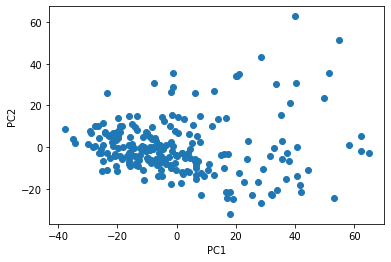

In [19]:
from sklearn.decomposition import PCA


X=df_flatten
# Initialize a PCA object and fit it to the data
pca = PCA(n_components=11)#11 component to explain 80% and 31 to explain 90%
X_pca_11com = pca.fit_transform(X)

# Print the amount of variance explained by each principal component
print(pca.explained_variance_ratio_)
print(f'total:',sum(pca.explained_variance_ratio_))
print(X_pca_11com.shape)
# Plot the first two principal components

plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/PCA_11.png', dpi=300, bbox_inches='tight')
plt.show()


[0.34677485 0.1428137  0.109537   0.06708235 0.04215532 0.02481653
 0.02177834 0.01694472 0.01495311 0.01191468 0.01043059 0.00858224
 0.00799082 0.00679645 0.00656774 0.00586265 0.00537785 0.00500055
 0.00495405 0.00454515 0.00411405 0.00398433 0.00387022 0.00371691
 0.00347049 0.00329587 0.0030776  0.00293685 0.00286932 0.00265017
 0.00257718]
total: 0.9014416801368493
(226, 31)


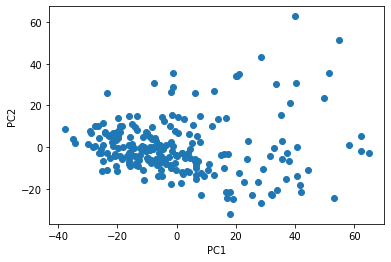

In [20]:
from sklearn.decomposition import PCA


X=df_flatten
# Initialize a PCA object and fit it to the data
pca = PCA(n_components=31)#11 component to explain 80% and 31 to explain 90%
X_pca_31com = pca.fit_transform(X)

# Print the amount of variance explained by each principal component
print(pca.explained_variance_ratio_)
print(f'total:',sum(pca.explained_variance_ratio_))
print(X_pca_31com.shape)
# Plot the first two principal components
import matplotlib.pyplot as plt
plt.scatter(X_pca_31com[:, 0], X_pca_31com[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# 1. k-means:

## 1.1 k-means with origianl data:

In [21]:
model = KMeans(n_clusters=2, random_state=42,max_iter=200) 
df_kmeans = model.fit(df_flatten)

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
labels_kmeans=pd.Series(df_kmeans.labels_)
labels_kmeans.value_counts()

1    171
0     55
dtype: int64

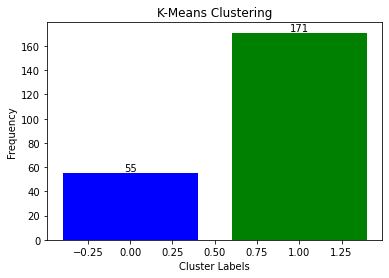

In [55]:
import matplotlib.pyplot as plt

# Get the value counts from labels_kmeans
value_counts = labels_kmeans.value_counts()

# Define the colors for each bar
colors = ['green', 'blue', 'orange', 'red', 'purple']

# Create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values, color=colors)

# Set the x-axis and y-axis labels
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('Frequency')

# Set the title of the chart
ax.set_title('K-Means Clustering')

# Add the exact values of each bar to the plot
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Show the plot
plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


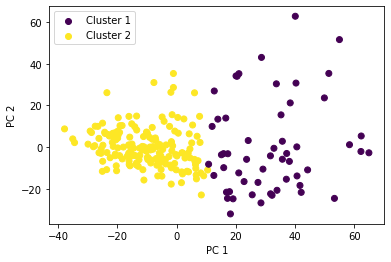

In [23]:
import matplotlib.pyplot as plt

# Using PCA to plot the clustering result
scatter = plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_kmeans)
#plt.title('KMeans Clustering')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# Create a dummy scatter plot for the legend
dummy = []
for label in set(labels_kmeans):
    if label == 0:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 1'))
    elif label == 1:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 2'))

# Add the legend
plt.legend(handles=dummy)

# Show the plot
#plt.show()
plt.savefig('K-means')

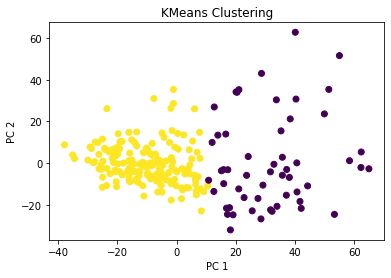

In [56]:
#uising PCA to plot the clustering result
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_kmeans)
plt.title('KMeans Clustering')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


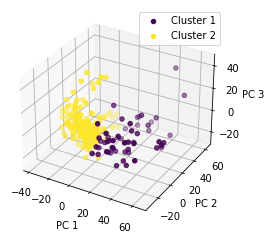

In [33]:
from mpl_toolkits import mplot3d

# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], X_pca_11com[:, 2], c=labels_kmeans)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Create a dummy scatter plot for the legend
dummy = []
for label in set(labels_kmeans):
    if label == 0:
        dummy.append(ax.scatter([], [], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 1'))
    elif label == 1:
        dummy.append(ax.scatter([], [], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 2'))

# Add the legend
ax.legend(handles=dummy)

# Show the plot
#plt.show()
plt.savefig('k_means_3Dnew')

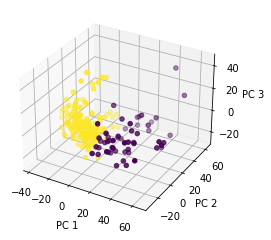

In [57]:
from mpl_toolkits import mplot3d



# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1],X_pca_11com[:, 2], c=labels_kmeans)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()


## 1.2 k-means with PCA-11:

In [58]:
print(X_pca_11com.shape)
model = KMeans(n_clusters=2, random_state=42,max_iter=200) 
df_kmeans_11 = model.fit(X_pca_11com)

(226, 11)


C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [59]:
df_kmeans_11=pd.Series(df_kmeans_11.labels_)
df_kmeans_11.value_counts()

0    171
1     55
dtype: int64

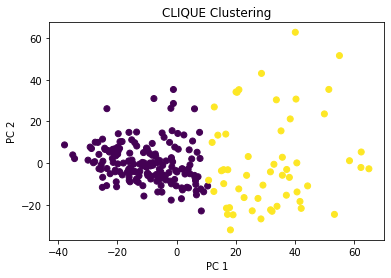

In [60]:
#uising PCA to plot the clustering result
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=df_kmeans_11)
plt.title('CLIQUE Clustering')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

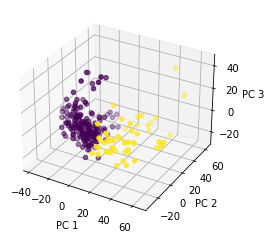

In [61]:
from mpl_toolkits import mplot3d



# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1],X_pca_11com[:, 2], c=df_kmeans_11)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()


## 1.3 k-means with PCA-31:

In [31]:
print(X_pca_31com.shape)
model = KMeans(n_clusters=2, random_state=42,max_iter=200) 
df_kmeans_31 = model.fit(X_pca_31com)

(226, 31)


C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [32]:
df_kmeans_31=pd.Series(df_kmeans_31.labels_)
df_kmeans_31.value_counts()

1    171
0     55
dtype: int64

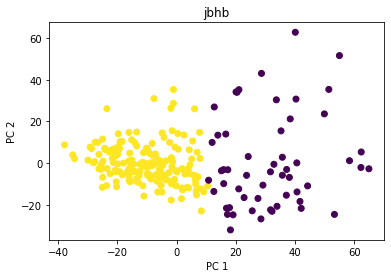

In [34]:
#uising PCA to plot the clustering result
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=df_kmeans_31)
plt.title('jbhb')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

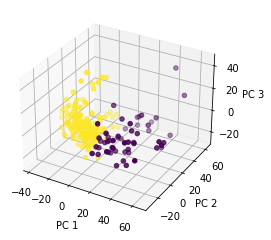

In [65]:
from mpl_toolkits import mplot3d



# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1],X_pca_11com[:, 2], c=df_kmeans_31)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()


# 1. DBSCAN:

## 1.1 DBSCAN with origianl data:

225    1
56     1
82     1
81     1
80     1
      ..
146    1
145    1
144    1
143    1
0      1
Length: 226, dtype: int64


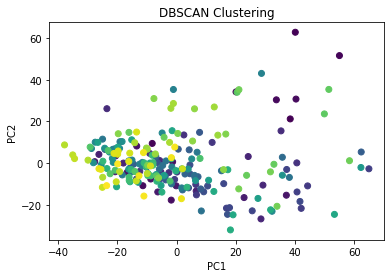

In [24]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

X=data_flatten

# create a DBSCAN instance
dbscan = DBSCAN(eps=0.5, min_samples=1)#min sample 1 is too complex and 2 is too simple. 

# fit the model and obtain the predicted labels
labels_DBSCAN = dbscan.fit_predict(X)
labels_DBSCAN=pd.Series(labels_DBSCAN)
print(labels_DBSCAN.value_counts())
# plot the results withn PCA components 
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN)
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/DBSCAN_complex.png', dpi=300, bbox_inches='tight')


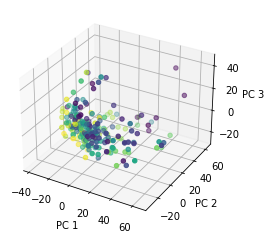

In [36]:
from mpl_toolkits import mplot3d



# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1],X_pca_11com[:, 2], c=labels_DBSCAN)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/DBSCAN_complex_3d_.png', dpi=300, bbox_inches='tight')

plt.show()


## 1.2 dbscan with PCA-11:

(226, 11)
0    226
dtype: int64


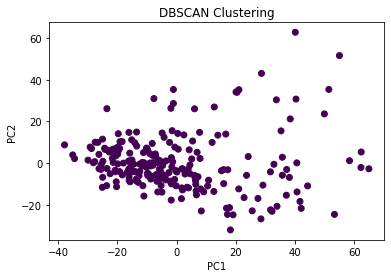

In [26]:
print(X_pca_11com.shape)




# create a DBSCAN instance
dbscan = DBSCAN(eps=50, min_samples=2)#min sample 1 is too complex and 2 is too simple. 

# fit the model and obtain the predicted labels
labels_DBSCAN_11 = dbscan.fit_predict(X_pca_11com)
labels_DBSCAN_11=pd.Series(labels_DBSCAN_11)
print(labels_DBSCAN_11.value_counts())
# plot the results withn PCA components 
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_11)
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/DBSCAN_simple.png', dpi=300, bbox_inches='tight')


## 1.3 DBSCAN with PCA-31:

(226, 31)
225    1
56     1
82     1
81     1
80     1
      ..
146    1
145    1
144    1
143    1
0      1
Length: 226, dtype: int64


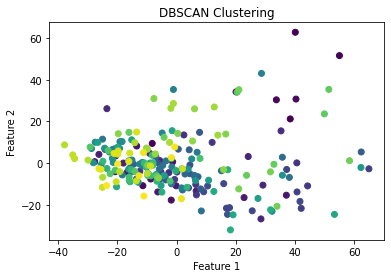

In [27]:
print(X_pca_31com.shape)




# create a DBSCAN instance
dbscan = DBSCAN(eps=0.5, min_samples=1)#min sample 1 is too complex and 2 is too simple. 

# fit the model and obtain the predicted labels
labels_DBSCAN_31 = dbscan.fit_predict(X_pca_31com)
labels_DBSCAN_31=pd.Series(labels_DBSCAN_31)
print(labels_DBSCAN_31.value_counts())
# plot the results withn PCA components 
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_31)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


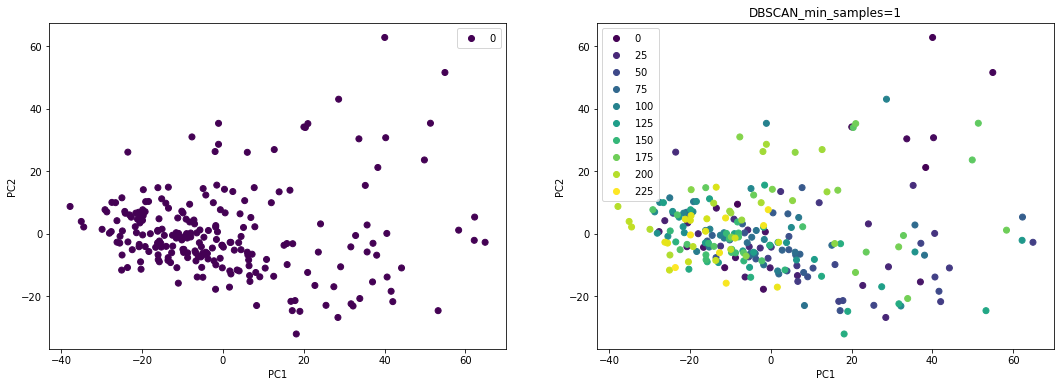

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
#fig, axs = plt.subplots(1, 2)
# Plot the data in each subplot
scatter0 = axs[0].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_11)
#axs[0].set_title('DBSCAN_min_samples=2')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

scatter1 = axs[1].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN)
axs[1].set_title('DBSCAN_min_samples=1')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

# Add legends to the subplots
axs[0].legend(handles=scatter0.legend_elements()[0], labels=scatter0.legend_elements()[1])
axs[1].legend(handles=scatter1.legend_elements()[0], labels=scatter1.legend_elements()[1])

# plt.show()
#plt.savefig('DBSCAN_res', dpi=300)


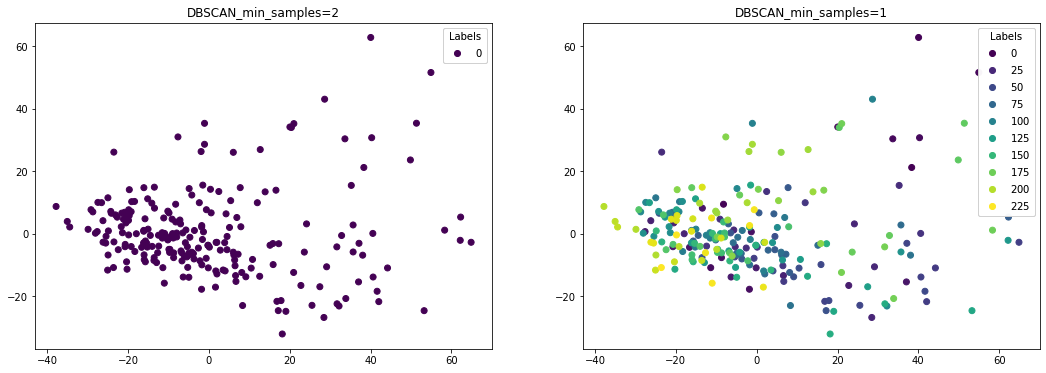

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the data in each subplot
scatter0 = axs[0].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_11)
axs[0].set_title('DBSCAN_min_samples=2')

scatter1 = axs[1].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN)
axs[1].set_title('DBSCAN_min_samples=1')

# Add legends to the subplots
legend0 = axs[0].legend(*scatter0.legend_elements(), title="Labels")
axs[0].add_artist(legend0)
legend1 = axs[1].legend(*scatter1.legend_elements(), title="Labels")
axs[1].add_artist(legend1)

# Show or save the plot
#plt.show()
plt.savefig('DBSCAN_res.png')


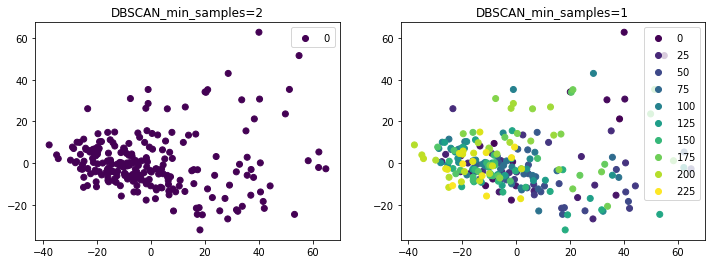

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the data in each subplot
scatter0 = axs[0].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_11)
axs[0].set_title('DBSCAN_min_samples=2')

scatter1 = axs[1].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN)
axs[1].set_title('DBSCAN_min_samples=1')

# Add legends to the subplots
axs[0].legend(handles=scatter0.legend_elements()[0], labels=scatter0.legend_elements()[1])
axs[1].legend(handles=scatter1.legend_elements()[0], labels=scatter1.legend_elements()[1])
fig.set_size_inches(12, 4)
#plt.show()
#plt.savefig('DBSCAN_res', dpi=600)

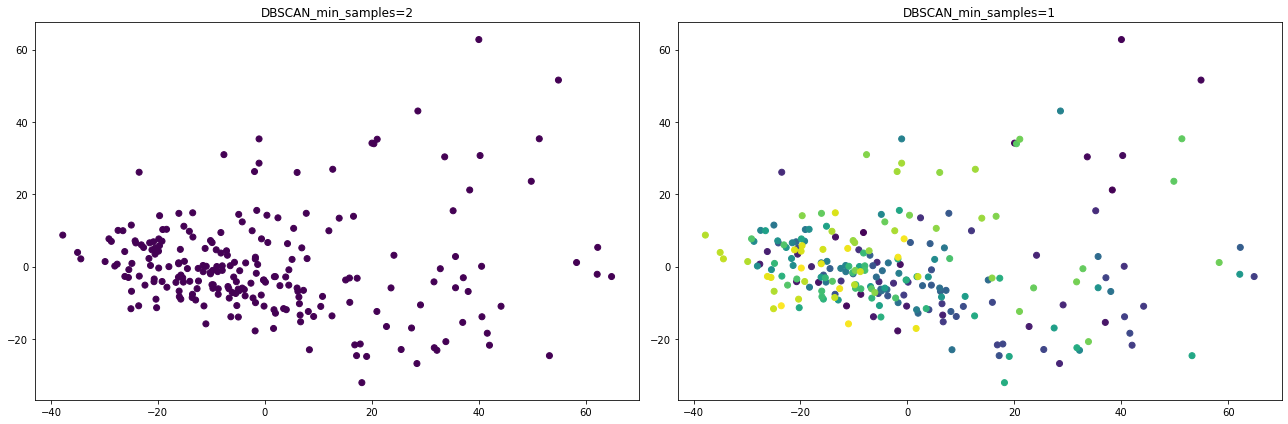

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_pca_11com and labels_DBSCAN_* are already defined

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the data in each subplot
axs[0].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN_31)
axs[0].set_title('DBSCAN_min_samples=2')

axs[1].scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_DBSCAN)
axs[1].set_title('DBSCAN_min_samples=1')
#plt.savefig('three_plots1.png', dpi=300)
#fig, axs = plt.subplots(1, figsize=(18, 6), subplot_kw={'projection': ('3d')})
# 3D scatter plot for the third subplot
#axs = fig.add_subplot(1, 3, 3, projection='3d')
#axs.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], X_pca_11com[:, 2], c=labels_DBSCAN)
#axs.set_title('DBSCAN_3D_min_samples=1')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Save the plot as a PNG image file (optional)
plt.savefig('three_plots.png', dpi=300)

# Show the plot
plt.show()

# Close the plot to release resources (optional, but a good practice)
plt.close()


# 3. GMM:

## 1.1 GMM with origianl data:
mamory issue

## 1.2 GMM with PCA-11:

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

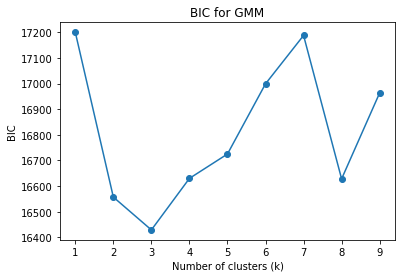

Optimal number of clusters = 3


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

# Generate some sample data



# Specify the range of k values to try
k_range = range(1, 10)

# Fit a GMM model for each k value and calculate the BIC
bic = []
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_pca_11com)
    bic.append(gmm.bic(X_pca_11com))

# Find the optimal k value that minimizes the BIC
optimal_k = np.argmin(bic) + 1

# Plot the BIC values for each k value
plt.plot(k_range, bic, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

# Print the optimal k value
print(f"Optimal number of clusters = {optimal_k}")


In [35]:
GMM_clustering_11 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_pca_11com)
labels_GMM_11=pd.Series(GMM_clustering_11.predict(X_pca_11com))
labels_GMM_11.value_counts()

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1    169
0     57
dtype: int64

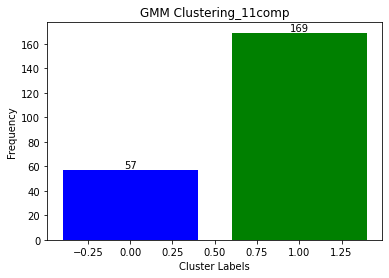

In [36]:
import matplotlib.pyplot as plt

# Get the value counts from labels_kmeans
value_counts = labels_GMM_11.value_counts()

# Define the colors for each bar
colors = ['green', 'blue', 'orange', 'red', 'purple']

# Create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values, color=colors)

# Set the x-axis and y-axis labels
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('Frequency')

# Set the title of the chart
ax.set_title('GMM Clustering_11comp')

# Add the exact values of each bar to the plot
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/GMM-11comp-table.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


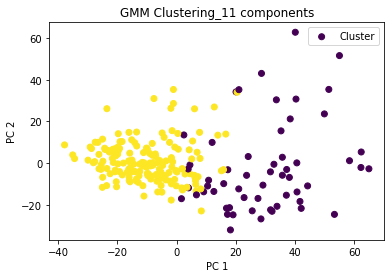

In [75]:
import matplotlib.pyplot as plt

plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_GMM_11, label='Cluster')
plt.title('GMM Clustering_11 components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()

plt.show()


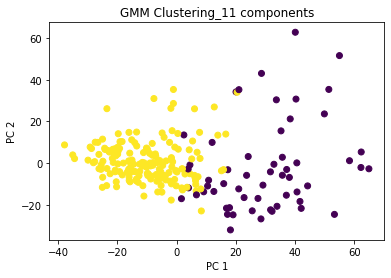

In [74]:
# plot the results
plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_GMM_11)
plt.title('GMM Clustering_11 components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/GMM-11comp-2D.png', dpi=300, bbox_inches='tight')

plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


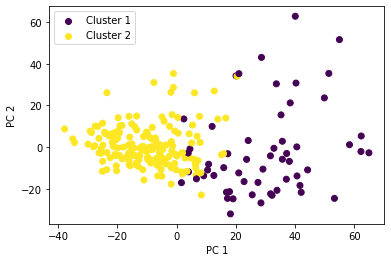

In [37]:
scatter = plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_GMM_11)
#plt.title('GMM Clustering_11 components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# Create a dummy scatter plot for the legend
dummy = []
for label in set(labels_kmeans):
    if label == 0:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 1'))
    elif label == 1:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 2'))

# Add the legend
plt.legend(handles=dummy)

# Show the plot
#plt.show()
plt.savefig('GMM_11comp')

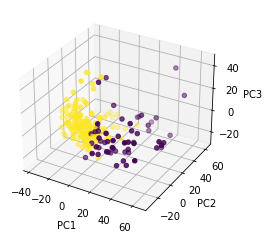

In [57]:
# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], X_pca_11com[:, 2],c=labels_GMM_11)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/GMM-11comp-3D.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:


# Specify the range of k values to try
k_range = range(1, 10)

# Fit a GMM model for each k value and calculate the BIC
bic = []
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_pca_31com)
    bic.append(gmm.bic(X_pca_31com))

# Find the optimal k value that minimizes the BIC
optimal_k = np.argmin(bic) + 1

# Plot the BIC values for each k value
plt.plot(k_range, bic, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

# Print the optimal k value
print(f"Optimal number of clusters = {optimal_k}")


In [38]:
GMM_clustering_31 = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(X_pca_31com)
GMM_labels=GMM_clustering_31.predict(X_pca_31com)
labels_GMM_31=pd.Series(GMM_clustering_31.predict(X_pca_31com))
labels_GMM_31.value_counts()

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1    171
0     55
dtype: int64

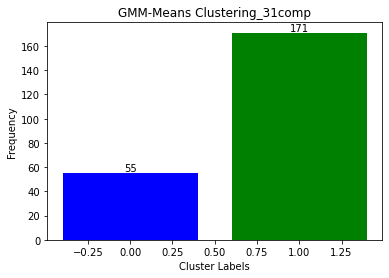

In [36]:
import matplotlib.pyplot as plt

# Get the value counts from labels_kmeans
value_counts = labels_GMM_31.value_counts()

# Define the colors for each bar
colors = ['green', 'blue', 'orange', 'red', 'purple']

# Create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(value_counts.index, value_counts.values, color=colors)

# Set the x-axis and y-axis labels
ax.set_xlabel('Cluster Labels')
ax.set_ylabel('Frequency')

# Set the title of the chart
ax.set_title('GMM-Means Clustering_31comp')

# Add the exact values of each bar to the plot
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

#plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/GMM-31comp-table.png', dpi=300, bbox_inches='tight')

# Show the plot
#plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


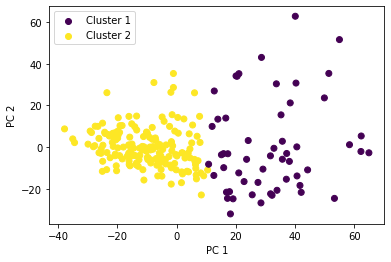

In [39]:
scatter = plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_GMM_31)
#plt.title('GMM Clustering_31 components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# Create a dummy scatter plot for the legend
dummy = []
for label in set(labels_GMM_31):
    if label == 0:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 1'))
    elif label == 1:
        dummy.append(plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label='Cluster 2'))

# Add the legend
plt.legend(handles=dummy)
plt.savefig('GMM_31')

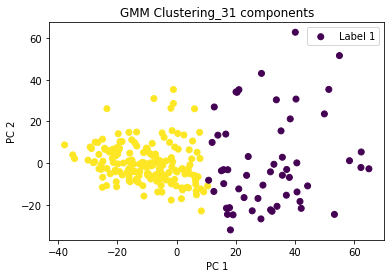

In [39]:
import matplotlib.pyplot as plt

plt.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], c=labels_GMM_31)
plt.title('GMM Clustering_31 components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(['Label 1', 'Label 2'])

plt.show()


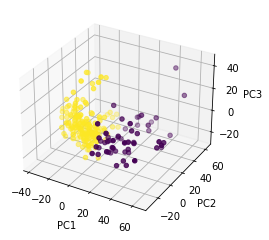

In [32]:
# Create a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_pca_11com[:, 0], X_pca_11com[:, 1], X_pca_11com[:, 2],c=labels_GMM_31)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.savefig('M:/LIU/Thesis/my thesis/My reports/My thesis report/Rmarkdown report/new version/images/GMM-31comp-3D.png', dpi=300, bbox_inches='tight')

#plt.show()

# Adding GMM-31 labels to the data and plot the data:

In [43]:
df_flatten_GMM=df_flatten.copy()
df_flatten_GMM['GMM']=GMM_labels
df_flatten_GMM.head()


Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D1  0.300000  0.040000 -0.270000 -0.280000 -0.470000 -0.310000 -0.060000   
D2 -0.029921  0.019818 -0.200119 -0.350066 -0.479891 -0.439690 -0.189920   
D3 -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D4  0.089988  0.009961 -0.250009 -0.310015 -0.409994 -0.369962 -0.119994   
D5  0.229859  0.029788 -0.270050 -0.340120 -0.509908 -0.379816 -0.120035   

     Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431992  Pixel_431993  \
D1 -0.160000 -0.390000  0.250000  ...      0.320000     -0.320000   
D2 -0.200050 -0.319442  0.270484  ...      0.049611     -0.379584   
D3 -0.209545 -0.399831  0.239709  ...      0.169925     -0.349902   
D4 -0.080029 -0.269921  0.250090  ...      0.229646     -0.309917   
D5 -0.170163 -0.399604  0.160410  ...      0.339370     -0.389725   

    Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  Pixel_431998  \
D1      0.080000     -0.350000     -0.560000     -0.110000     -0.290000   
D2      0.079738     -0.210163     -0.389584      0.069801     -0.149729   
D3      0.329909     -0.300042     -0.589903      0.079948     -0.279903   
D4     -0.019823     -0.379838     -0.479763      0.000348     -0.089812   
D5     -0.000126     -0.300059     -0.509637     -0.099995     -0.269688   

    Pixel_431999  Pixel_432000  GMM  
D1      0.100000      0.400000    0  
D2      0.150163      0.330000    0  
D3      0.390042      0.680000    1  
D4      0.249859      0.389802    0  
D5      0.100140      0.329947    0  

[5 rows x 432001 columns]

In [44]:
df_flatten_GMM_clus1=df_flatten_GMM[df_flatten_GMM['GMM']==1]
print(df_flatten_GMM_clus1.shape)
df_flatten_GMM_clus1.head()


(171, 432001)


Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D3  -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D8   0.090449 -0.199589 -0.559121 -0.538693 -0.708872 -0.449255 -0.179056   
D9   0.170455 -0.209479 -0.589024 -0.538587 -0.688832 -0.439247 -0.178974   
D10  0.140375 -0.189606 -0.569165 -0.528734 -0.678936 -0.429317 -0.169111   
D11  0.050511 -0.159615 -0.459142 -0.478600 -0.658782 -0.439132 -0.178890   

      Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431992  Pixel_431993  \
D3  -0.209545 -0.399831  0.239709  ...      0.169925     -0.349902   
D8  -0.149510 -0.329885  0.169702  ...      0.189915     -0.369903   
D9  -0.149455 -0.319953  0.169588  ...      0.219974     -0.289972   
D10 -0.149525 -0.319906  0.169678  ...      0.189952     -0.339946   
D11 -0.149422 -0.319830  0.209632  ...      0.169909     -0.329890   

     Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  Pixel_431998  \
D3       0.329909     -0.300042     -0.589903      0.079948     -0.279903   
D8       0.269906     -0.350050     -0.679909     -0.080041     -0.349911   
D9       0.259970     -0.340015     -0.639973     -0.110012     -0.349969   
D10      0.259944     -0.360027     -0.659948     -0.080024     -0.339946   
D11      0.279895     -0.300051     -0.579891      0.019938     -0.319899   

     Pixel_431999  Pixel_432000  GMM  
D3       0.390042          0.68    1  
D8       0.240047          0.55    1  
D9       0.260013          0.52    1  
D10      0.260023          0.51    1  
D11      0.240060          0.57    1  

[5 rows x 432001 columns]

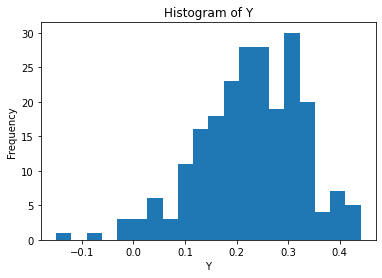

In [45]:
# plot the histogram
plt.hist(df_flatten_GMM['Pixel_1'], bins=20)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Histogram of Y')
plt.show()

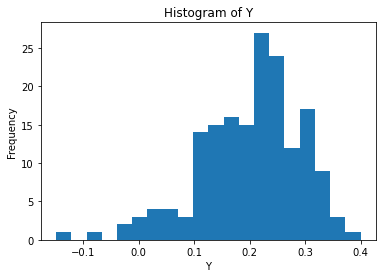

In [46]:
# plot the histogram
plt.hist(df_flatten_GMM_clus1['Pixel_1'], bins=20)
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Histogram of Y')
plt.show()

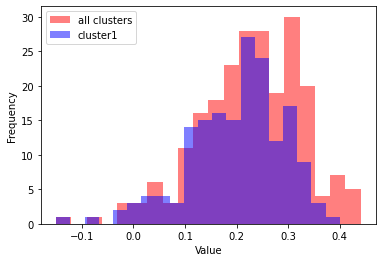

In [47]:
# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the histograms with different colors
ax.hist(df_flatten_GMM['Pixel_1'], color='red', alpha=0.5, bins=20, label='all clusters')
ax.hist(df_flatten_GMM_clus1['Pixel_1'], color='blue', alpha=0.5, bins=20, label='cluster1')


# Add a legend and axis labels
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()


# Statistical Analysis:

### remove GMM label from the data:


In [35]:
df_flatten_GMM_clus1=df_flatten_GMM_clus1.iloc[:,:-1]
df_flatten_GMM_clus1.shape

(171, 432000)

In [36]:
df_flatten_GMM_clus1

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D3   -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D8    0.090449 -0.199589 -0.559121 -0.538693 -0.708872 -0.449255 -0.179056   
D9    0.170455 -0.209479 -0.589024 -0.538587 -0.688832 -0.439247 -0.178974   
D10   0.140375 -0.189606 -0.569165 -0.528734 -0.678936 -0.429317 -0.169111   
D11   0.050511 -0.159615 -0.459142 -0.478600 -0.658782 -0.439132 -0.178890   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D3   -0.209545 -0.399831  0.239709  ...      0.359973      0.169925   
D8   -0.149510 -0.329885  0.169702  ...      0.399968      0.189915   
D9   -0.149455 -0.319953  0.169588  ...      0.349993      0.219974   
D10  -0.149525 -0.319906  0.169678  ...      0.379983      0.189952   
D11  -0.149422 -0.319830  0.209632  ...      0.369964      0.169909   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D3       -0.349902      0.329909     -0.300042     -0.589903      0.079948   
D8       -0.369903      0.269906     -0.350050     -0.679909     -0.080041   
D9       -0.289972      0.259970     -0.340015     -0.639973     -0.110012   
D10      -0.339946      0.259944     -0.360027     -0.659948     -0.080024   
D11      -0.329890      0.279895     -0.300051     -0.579891      0.019938   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D3       -0.279903      0.390042      0.680000  
D8       -0.349911      0.240047      0.550000  
D9       -0.349969      0.260013      0.520000  
D10      -0.339946      0.260023      0.510000  
D11      -0.319899      0.240060      0.570000  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[171 rows x 432000 columns]

In [89]:

model = KMeans(n_clusters=2, random_state=42,max_iter=200) 
daste= model.fit(np.array(df_flatten_GMM_clus1.iloc[:,1]).reshape(171,1))

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [90]:
daste.cluster_centers_

array([[-0.16791237],
       [-0.08264696]])

In [91]:
daste_lab=pd.Series(daste.labels_)
daste_lab.value_counts()

0    90
1    81
dtype: int64

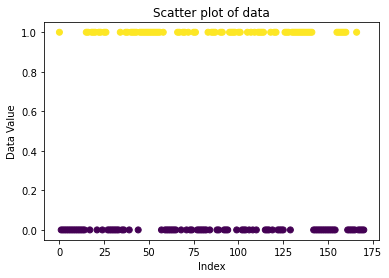

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 1D array of data
data =daste_lab

# Create an array of x-values that is the same length as the data array
x = range(len(data))

# Create the scatter plot
plt.scatter(x, data, c=data)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Data Value')
plt.title('Scatter plot of data')

# Show the plot
plt.show()


In [94]:
from scipy.optimize import fsolve

# define the equations to solve
def equations(p):
    a, b = p
    eq1 = a*-0.16791237 + b* (-0.08264696)-df_flatten_GMM_clus1.iloc[1,1]
    eq2 = a + b - 1
    return (eq1, eq2)

# initial guess
guess = (1.0, 1.0)

# solve the system of equations
sol = fsolve(equations, guess)

# print the solution
print("a = {:.4f}, b = {:.4f}".format(sol[0], sol[1]))


a = 1.3715, b = -0.3715


In [95]:
a = 1.3715; b = -0.3715
a+b

1.0

# To prove my solution for statistical analysis:
pi_1*mu_1+pi_2*mu_2=y_bar

In [96]:

# Generate 100 random numbers between 1 and 10
data = np.random.randint(1, 11, size=100)

print(data)


[ 7  7  7  2  2  9  8  6  6 10  2 10  8  2  8 10  1  9  4  2  3  9  2  1
  9  5  3  2  7  9 10  1  7  2  6  6  6  8 10 10  8  4  2  5  3  7  8  6
  6  1  8  2  1  6  9  4 10  7  9  3  8  2  6  9  4  9  4  1  3  9  1  4
  6 10  1  3  6  2  6  2  5  8  4  4  6  4  7  7  3  2  3  5  7  5  8  2
  1 10  9  8]


In [97]:
from sklearn.mixture import GaussianMixture

# Fit a GMM with 2 components on the data
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Print the means and standard deviations of the two Gaussian distributions
print("Component 1: mean=%.2f, std=%.2f" % (gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0][0])))
print("Component 2: mean=%.2f, std=%.2f" % (gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0][0])))


Component 1: mean=2.41, std=1.11
Component 2: mean=7.54, std=1.68


C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [98]:
np.mean(data)

5.49

In [99]:
gmm.weights_[0]*gmm.means_[0][0]+gmm.weights_[1]*gmm.means_[1][0]

5.4899999999999975

### To estimate GMM parameters:

#### 1. SSE

In [90]:


# Set seed for reproducibility
np.random.seed(123)

# Create a DataFrame with random numbers
data = pd.DataFrame(np.random.rand(10, 100), columns=[f'col{i}' for i in range(1, 101)])

print(data)


       col1      col2      col3      col4      col5      col6      col7  \
0  0.696469  0.286139  0.226851  0.551315  0.719469  0.423106  0.980764   
1  0.513128  0.666625  0.105908  0.130895  0.321981  0.661564  0.846506   
2  0.542636  0.066774  0.653365  0.996086  0.769397  0.573774  0.102635   
3  0.016392  0.721184  0.007738  0.084822  0.225498  0.875125  0.363576   
4  0.456271  0.279802  0.932892  0.314351  0.909715  0.043418  0.707115   
5  0.212831  0.392304  0.851548  0.127612  0.893865  0.496508  0.426096   
6  0.701360  0.707581  0.959939  0.876705  0.468060  0.625907  0.457182   
7  0.945237  0.290086  0.727043  0.015016  0.879142  0.063939  0.733395   
8  0.387195  0.555860  0.014144  0.847647  0.921920  0.550530  0.268021   
9  0.896426  0.223270  0.268124  0.194498  0.967501  0.112540  0.722163   

       col8      col9     col10  ...     col91     col92     col93     col94  \
0  0.684830  0.480932  0.392118  ...  0.704959  0.995358  0.355915  0.762548   
1  0.553257  0

In [91]:
avg=[]
for i in range(100):
    avg.append(np.mean(data.iloc[:,i]))
    

In [92]:
import numpy as np
from scipy.optimize import minimize

# Define objective function :The objective function to be minimized
def objective_function(theta, y_bar):
    pi, mu1, mu2 = theta
    y_est= pi*mu1+(1-pi)*mu2
    return np.sum((y_bar - y_est)**2)

# Generate some data
#mu1 = 2
#mu2 = 5
#pi = 0.3
#y = pi*np.random.normal(mu1, 1, size=100) + (1-pi)*np.random.normal(mu2, 1, size=100)
y_bar =avg[0]

# Initial guess for pi, mu1, mu2
theta0 = [0.5, 2, 5]
bounds = [(0,1),(-np.inf,np.inf),(-np.inf,np.inf)]
# unbounded variables must use None, not +-inf, for optimizer to work properly

# Perform optimization
#Minimization of scalar function of one or more variables.
res = minimize(objective_function, theta0, args=(y_bar,), bounds=bounds)

# Print optimized values
print(res.x)


[ 0.8270009  -0.00370979  3.12060886]


In [93]:
gmm_col1 = GaussianMixture(n_components=2)
gmm_col1.fit(np.array(data.iloc[:,0]).reshape(-1, 1))
gmm_col1.weights_
#means_list1.append(gmm_col1.means_[0][0])
#means_list2.append(gmm_col1.means_[1][0])

C:\Users\omidl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0.14401446, 0.85598554])

In [94]:
gmm_col1.means_

array([[0.08616635],
       [0.61261002]])

In [95]:
pi=res.x[0]
mu1=res.x[1]
mu2=res.x[2]

pi*mu1+(1-pi)*mu2

0.5367945175171239

In [96]:
avg[0]

0.5367945156490086

In [97]:
pi=gmm_col1.weights_[0]
mu1=gmm_col1.means_[0][0]
mu2=gmm_col1.means_[1][0]

pi*mu1+(1-pi)*mu2

0.5367945156490085

Sample code for numerical optimization

In [98]:
import numpy as np


# Define the log-likelihood function
def log_likelihood(pi, alpha1, alpha2):
    return np.sum(np.log(gamma(alpha1 + alpha2)) - np.sum(np.log(gamma(alpha1)) + np.log(gamma(alpha2))) + np.sum((alpha1 - 1) * np.log(pi) + (alpha2 - 1) * np.log(1 - pi)))

# Define the partial derivative functions
def d_log_likelihood_alpha1(pi, alpha1, alpha2):
    return np.sum(digamma(alpha1 + alpha2) - digamma(alpha1) + np.log(pi))

def d_log_likelihood_alpha2(pi, alpha1, alpha2):
    return np.sum(digamma(alpha1 + alpha2) - digamma(alpha2) + np.log(1 - pi))

# Define the gradient descent algorithm
def gradient_descent(pi, alpha1, alpha2, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
    iteration = 0
    delta = np.inf
    while iteration < max_iterations and delta > tolerance:
        old_alpha1, old_alpha2 = alpha1, alpha2
        alpha1 -= learning_rate * d_log_likelihood_alpha1(pi, alpha1, alpha2)
        alpha2 -= learning_rate * d_log_likelihood_alpha2(pi, alpha1, alpha2)
        delta = np.abs(old_alpha1 - alpha1) + np.abs(old_alpha2 - alpha2)
        iteration += 1
    return alpha1, alpha2

# Generate some random data
np.random.seed(42)
n = 100
pi = np.random.dirichlet([1, 1], size=n)

# Find the maximum likelihood estimates using gradient descent
alpha1, alpha2 = gradient_descent(pi, 1.0, 1.0)

# Print the results
print("Maximum likelihood estimates:")
print("alpha1 =", alpha1)
print("alpha2 =", alpha2)


Maximum likelihood estimates:
alpha1 = -188.4333956704772
alpha2 = 2108.909519084936


In [24]:
df_flatten

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D1    0.300000  0.040000 -0.270000 -0.280000 -0.470000 -0.310000 -0.060000   
D2   -0.029921  0.019818 -0.200119 -0.350066 -0.479891 -0.439690 -0.189920   
D3   -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D4    0.089988  0.009961 -0.250009 -0.310015 -0.409994 -0.369962 -0.119994   
D5    0.229859  0.029788 -0.270050 -0.340120 -0.509908 -0.379816 -0.120035   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D1   -0.160000 -0.390000  0.250000  ...      0.490000      0.320000   
D2   -0.200050 -0.319442  0.270484  ...      0.369711      0.049611   
D3   -0.209545 -0.399831  0.239709  ...      0.359973      0.169925   
D4   -0.080029 -0.269921  0.250090  ...      0.479635      0.229646   
D5   -0.170163 -0.399604  0.160410  ...      0.559740      0.339370   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D1       -0.320000      0.080000     -0.350000     -0.560000     -0.110000   
D2       -0.379584      0.079738     -0.210163     -0.389584      0.069801   
D3       -0.349902      0.329909     -0.300042     -0.589903      0.079948   
D4       -0.309917     -0.019823     -0.379838     -0.479763      0.000348   
D5       -0.389725     -0.000126     -0.300059     -0.509637     -0.099995   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D1       -0.290000      0.100000      0.400000  
D2       -0.149729      0.150163      0.330000  
D3       -0.279903      0.390042      0.680000  
D4       -0.089812      0.249859      0.389802  
D5       -0.269688      0.100140      0.329947  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[226 rows x 432000 columns]

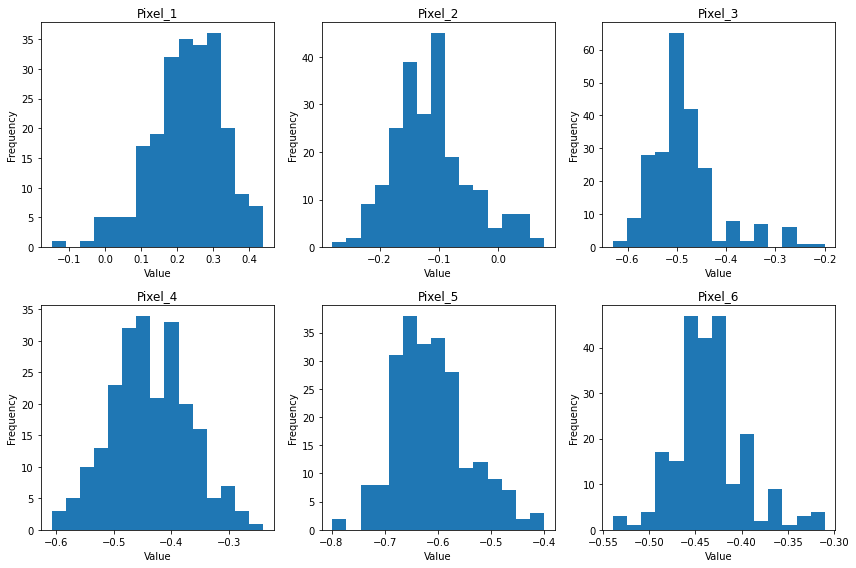

In [55]:
# Create some example data

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot the data in each subplot
axs[0, 0].hist(df_flatten.iloc[:,0], bins=15)
axs[0, 0].set_title('Pixel_1')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(df_flatten.iloc[:,1], bins=15)
axs[0, 1].set_title('Pixel_2')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

axs[0, 2].hist(df_flatten.iloc[:,2], bins=15)
axs[0, 2].set_title('Pixel_3')
axs[0, 2].set_xlabel('Value')
axs[0, 2].set_ylabel('Frequency')

axs[1, 0].hist(df_flatten.iloc[:,3], bins=15)
axs[1, 0].set_title('Pixel_4')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(df_flatten.iloc[:,4], bins=15)
axs[1, 1].set_title('Pixel_5')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

axs[1, 2].hist(df_flatten.iloc[:,5], bins=15)
axs[1, 2].set_title('Pixel_6')
axs[1, 2].set_xlabel('Value')
axs[1, 2].set_ylabel('Frequency')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Save the plot as a PNG image file (optional)
#plt.savefig('six_plots.png', dpi=300)

# Show the plot
#plt.show()

# Close the plot to release resources (optional, but a good practice)
#plt.close()
plt.savefig('pixel_hist_all')

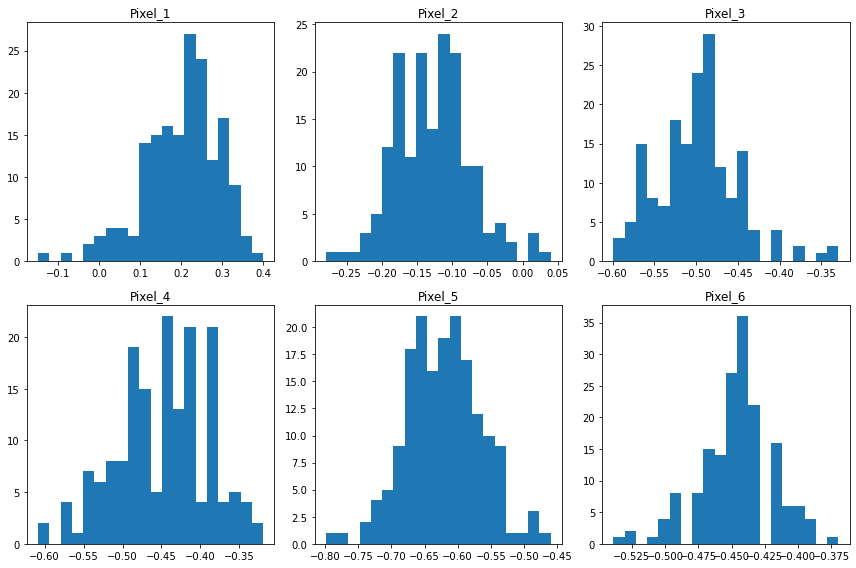

In [48]:
# Create some example data

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot the data in each subplot
axs[0, 0].hist(df_flatten_GMM_clus1.iloc[:,0], bins=20)
axs[0, 0].set_title('Pixel_1')

axs[0, 1].hist(df_flatten_GMM_clus1.iloc[:,1], bins=20)
axs[0, 1].set_title('Pixel_2')

axs[0, 2].hist(df_flatten_GMM_clus1.iloc[:,2], bins=20)
axs[0, 2].set_title('Pixel_3')

axs[1, 0].hist(df_flatten_GMM_clus1.iloc[:,3], bins=20)
axs[1, 0].set_title('Pixel_4')

axs[1, 1].hist(df_flatten_GMM_clus1.iloc[:,4], bins=20)
axs[1, 1].set_title('Pixel_5')

axs[1, 2].hist(df_flatten_GMM_clus1.iloc[:,5], bins=20)
axs[1, 2].set_title('Pixel_6')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Save the plot as a PNG image file (optional)
#plt.savefig('six_plots.png', dpi=300)

# Show the plot
plt.show()

# Close the plot to release resources (optional, but a good practice)
plt.close()

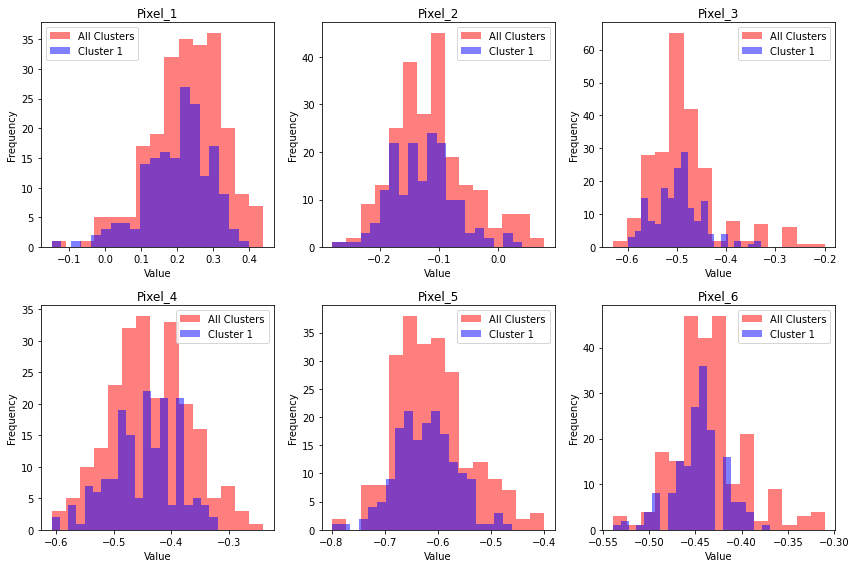

In [54]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot the data in each subplot
axs[0, 0].hist(df_flatten.iloc[:,0], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[0, 0].hist(df_flatten_GMM_clus1.iloc[:,0], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[0, 0].set_title('Pixel_1')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(df_flatten.iloc[:,1], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[0, 1].hist(df_flatten_GMM_clus1.iloc[:,1], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[0, 1].set_title('Pixel_2')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

axs[0, 2].hist(df_flatten.iloc[:,2], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[0, 2].hist(df_flatten_GMM_clus1.iloc[:,2], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[0, 2].set_title('Pixel_3')
axs[0, 2].set_xlabel('Value')
axs[0, 2].set_ylabel('Frequency')

axs[1, 0].hist(df_flatten.iloc[:,3], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[1, 0].hist(df_flatten_GMM_clus1.iloc[:,3], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[1, 0].set_title('Pixel_4')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(df_flatten.iloc[:,4], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[1, 1].hist(df_flatten_GMM_clus1.iloc[:,4], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[1, 1].set_title('Pixel_5')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

axs[1, 2].hist(df_flatten.iloc[:,5], bins=15, color='red', alpha=0.5, label='All Clusters')
axs[1, 2].hist(df_flatten_GMM_clus1.iloc[:,5], bins=20, color='blue', alpha=0.5, label='Cluster 1')
axs[1, 2].set_title('Pixel_6')
axs[1, 2].set_xlabel('Value')
axs[1, 2].set_ylabel('Frequency')

# Add legends to the subplots
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 2].legend()
axs[1, 0].legend()
axs[1, 1].legend()
axs[1, 2].legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig('allpixels')

# Data partitioning:


In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
import random
random.seed(1234)
# Create some example data (unsupervised)
#X = np.random.randn(100, 4)  # 100 samples with 4 features each

# Split the data into train and test sets
X_train, X_test = train_test_split(df_flatten_GMM_clus1, test_size=0.3, random_state=42)

# Check the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (119, 432001)
X_test shape: (52, 432001)


# Best
### Final correct for 2 comp

In [325]:
# my version
#This is for finding maximum loglikelihood 
#IF I wanted to find minimun then I would use -
#train_data=df_flatten_GMM_clus1.iloc[:160,0]
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
#test_data=df_flatten_GMM_clus1.iloc[160:,0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]
from scipy.special import gamma, digamma

def dirichlet_log_likelihood(params, y_bar):
    mu1, mu2, alpha1, alpha2 = params
    pi = (y_bar - mu2) / (mu1 - mu2)
    logL = np.sum(np.log(gamma(alpha1 + alpha2)) - np.log(gamma(alpha1)) \
        - np.log(gamma(alpha2)) + (alpha1 - 1)*np.log(pi) \
        + (alpha2 - 1)*np.log(1 - pi))
    return logL

def dirichlet_gradient(params, y_bar):
    mu1, mu2, alpha1, alpha2 = params
    pi = (y_bar - mu2) / (mu1 - mu2)
    dmu1 = np.sum(-(alpha1 - 1)/(mu1 - mu2) + (alpha2 - 1)*((1/(mu1 - y_bar))-(1/(mu1 - mu2))))
    dmu2 = np.sum((alpha1 - 1)*(-1/(y_bar-mu2)+1/(mu1-mu2)) - ((alpha2 - 1)/(mu1 - mu2)))
    da1 = np.sum(digamma(alpha1 + alpha2) - digamma(alpha1) + np.log(pi))
    da2 = np.sum(digamma(alpha1 + alpha2) - digamma(alpha2) + np.log(1 - pi))
    return np.array([dmu1, dmu2, da1, da2])

def gradient_descent(y_bar, lr=1e-7, n_iter=200000):
    # Initialize parameters
    mu1, mu2, alpha1, alpha2 = 2,-1 , 1, 1
    log_like_trend=[]
    for i in range(n_iter):
        # Compute gradient and update parameters
        gradient = dirichlet_gradient([mu1, mu2, alpha1, alpha2], y_bar)
        #print('mu1',mu1)
        mu1 += lr*gradient[0]
        mu2 += lr*gradient[1]
        alpha1 += lr*gradient[2]
        alpha2 += lr*gradient[3]
        # Compute and print log-likelihood
        logL = dirichlet_log_likelihood([mu1, mu2, alpha1, alpha2], y_bar)
        #if (i>0) and (logL-log_like_trend[-1]<0):
            #print(log_like_trend[-1])
            #break
        log_like_trend.append(logL)
        
        if i % 100 == 0:
            print(f"Iteration {i}: Log-likelihood = {logL:.4f}")
            #print('gradient[0]',gradient[0],gradient[1],gradient[2],gradient[3])
    return mu1, mu2, alpha1, alpha2,log_like_trend


In [ ]:
# adddddddddddddddddded convergence criteria
#This is for finding maximum loglikelihood 
#IF I wanted to find minimun then I would use -
#train_data=df_flatten_GMM_clus1.iloc[:160,0]
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
#test_data=df_flatten_GMM_clus1.iloc[160:,0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]
from scipy.special import gamma, digamma

def dirichlet_log_likelihood(params, y_bar):
    mu1, mu2, alpha1, alpha2 = params
    pi = (y_bar - mu2) / (mu1 - mu2)
    logL = np.sum(np.log(gamma(alpha1 + alpha2)) - np.log(gamma(alpha1)) \
        - np.log(gamma(alpha2)) + (alpha1 - 1)*np.log(pi) \
        + (alpha2 - 1)*np.log(1 - pi))
    return logL

def dirichlet_gradient(params, y_bar):
    mu1, mu2, alpha1, alpha2 = params
    pi = (y_bar - mu2) / (mu1 - mu2)
    dmu1 = np.sum(-(alpha1 - 1)/(mu1 - mu2) + (alpha2 - 1)*((1/(mu1 - y_bar))-(1/(mu1 - mu2))))
    dmu2 = np.sum((alpha1 - 1)*(-1/(y_bar-mu2)+1/(mu1-mu2)) - ((alpha2 - 1)/(mu1 - mu2)))
    da1 = np.sum(digamma(alpha1 + alpha2) - digamma(alpha1) + np.log(pi))
    da2 = np.sum(digamma(alpha1 + alpha2) - digamma(alpha2) + np.log(1 - pi))
    return np.array([dmu1, dmu2, da1, da2])


MSE_train_all=[]

def gradient_descent(y_bar, lr=1e-7, n_iter=100000):
    # Initialize parameters
    mu1, mu2, alpha1, alpha2 = 2,-1 , 1, 1
    log_like_trend=[]
    for i in range(n_iter):
        if i %1000==0:
          print('iteration is ',i)
        # Compute gradient and update parameters
        gradient = dirichlet_gradient([mu1, mu2, alpha1, alpha2], y_bar)
        #print('mu1',mu1)
        mu1 += lr*gradient[0]
        mu2 += lr*gradient[1]
        alpha1 += lr*gradient[2]
        alpha2 += lr*gradient[3]
        # Compute and print log-likelihood
        logL = dirichlet_log_likelihood([mu1, mu2, alpha1, alpha2], y_bar)
        #if (i>0) and (logL-log_like_trend[-1]<0):
            #print(log_like_trend[-1])
            #break
        log_like_trend.append(logL)
        if i % 100==0:
              MSE_temp=[]
              alpha=[alpha1,alpha2]
              mu=[mu1,mu2]
              print(f"Iteration {i}: Log-likelihood = {logL:.4f}")
              for time in range(1000):
                  #if time%1000==0:
                      #print('time in test:',time)
                  MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
              MSE_train_all.append(np.mean(MSE_temp))
        if len(MSE_train_all)>20 and np.mean(MSE_train_all[-20:-10])-np.mean(MSE_train_all[-10:])<=0 and np.mean(MSE_train_all[-30:-20])-np.mean(MSE_train_all[-20:-10])<=0:
          print('converge!!!')
          break
          

                #print('gradient[0]',gradient[0],gradient[1],gradient[2],gradient[3])
    return mu1, mu2, alpha1, alpha2,log_like_trend
        



In [ ]:
#y_bar = df_flatten_GMM_clus1.iloc[:,0]
MSE_test=[]
mu1_hat, mu2_hat, alpha1_hat, alpha2_hat,LL = gradient_descent(train_data)
print(f"mu1_hat = {mu1_hat:.4f}, mu2_hat = {mu2_hat:.4f}, alpha1_hat = {alpha1_hat:.4f}, alpha2_hat = {alpha2_hat:.4f}")
alpha=[alpha1_hat, alpha2_hat]
mu=[mu1_hat, mu2_hat]
MSE_train=[]
for time in range(10000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
print('MSE_train:',np.mean(MSE_train))


for time in range(10000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
print('MSE_test:',np.mean(MSE_test))

In [326]:
#y_bar = df_flatten_GMM_clus1.iloc[:,0]

mu1_hat, mu2_hat, alpha1_hat, alpha2_hat,LL = gradient_descent(train_data)
print(f"mu1_hat = {mu1_hat:.4f}, mu2_hat = {mu2_hat:.4f}, alpha1_hat = {alpha1_hat:.4f}, alpha2_hat = {alpha2_hat:.4f}")


Iteration 0: Log-likelihood = 0.0006
Iteration 100: Log-likelihood = 0.0579
Iteration 200: Log-likelihood = 0.1150
Iteration 300: Log-likelihood = 0.1720
Iteration 400: Log-likelihood = 0.2289
Iteration 500: Log-likelihood = 0.2856
Iteration 600: Log-likelihood = 0.3422
Iteration 700: Log-likelihood = 0.3986
Iteration 800: Log-likelihood = 0.4550
Iteration 900: Log-likelihood = 0.5111
Iteration 1000: Log-likelihood = 0.5672
Iteration 1100: Log-likelihood = 0.6231
Iteration 1200: Log-likelihood = 0.6789
Iteration 1300: Log-likelihood = 0.7346
Iteration 1400: Log-likelihood = 0.7901
Iteration 1500: Log-likelihood = 0.8455
Iteration 1600: Log-likelihood = 0.9008
Iteration 1700: Log-likelihood = 0.9559
Iteration 1800: Log-likelihood = 1.0109
Iteration 1900: Log-likelihood = 1.0658
Iteration 2000: Log-likelihood = 1.1206
Iteration 2100: Log-likelihood = 1.1752
Iteration 2200: Log-likelihood = 1.2297
Iteration 2300: Log-likelihood = 1.2841
Iteration 2400: Log-likelihood = 1.3384
Iteration 25

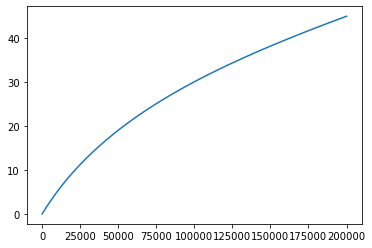

In [329]:
plt.plot(LL)
#os.getcwd()
#plt.savefig('comLLgraph.png')

In [330]:
M=2
#N=171

mu=[mu1_hat,mu2_hat]
alpha=[alpha1_hat,alpha2_hat]
MSE_test=[]
print('alpha_t',alpha,'mu_t',mu)
MSE_train=[]

for time in range(10000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))    
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
print('MSE_tr:',np.round(np.mean(MSE_train),6))
print('MSE_test:',np.round(np.mean(MSE_test),6))

alpha_t [1.5844723355708057, 1.7363104882248073] mu_t [2.1035241879188478, -1.6860307055427204]
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_tr: 0.844031
MSE_test: 0.844833


In [ ]:


MSE_test=[]
print('alpha_t',alpha,'mu_t',mu)
for time in range(10000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(abs((dirichlet.rvs(alpha,N_test)@mu)-test_data)))
print('MSE_test:',np.round(np.mean(MSE_test),6))

### Now We need to generalize it for K components

### Generalize for different k

Propose it and say that I want to mention this part in my thesis if it gives us valid information about the protein crystalls


#  solution 10
#### Amanda and Nick solution

# convergence code fixed M 

In [46]:
##########IT's last one 
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

train_data=X_train.iloc[:,0]
N=train_data.shape[0]
#test_data=df_flatten_GMM_clus1.iloc[160:,0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]


random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
def generate_m_positive_random_numbers_New(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 1) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(30):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))



'''
def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(30):
        pi = np.random.dirichlet(x, size=N)
        #while np.any(pi <= 0, axis=1):
        while any(elem <= 0 for elem in pi[i,:]):
            pi[np.any(pi <= 0, axis=1)] = np.random.dirichlet(x, size=np.sum(np.any(pi <= 0, axis=1)))
        dir_res = np.sum(np.log(stats.dirichlet.pdf(pi, x)), axis=1)
        dir_result_mean.append(np.mean(dir_res))
        power.append(np.sum(((train_data)-pi@mu)**2))
    return (-N/2*np.mean(power)) + np.mean(dir_result_mean) + (-0.1*np.sum(x))

'''

def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0
M=7
accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

target_pdf=TRG_pdf
proposal_step=1
n_samples=50
#init_state=alpha 
#pi=pi


for step in step_list:
    print('step',step)
    
    accepted_s_num_dict[step]={}
    #alpha=generate_m_positive_random_numbers(M)
    alpha=np.ones(M)
    init_state=alpha 
    #mu=np.zeros(M)
    #values=np.linspace(-10,10,100)
    #mu=np.array(random.sample(list(values), M))
    mu=np.random.normal(loc=0, scale=1, size=(M,))
    pi=np.zeros((N,M))
    for it in range(100):
        #if it%5==0:
        print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[step][it]=accepted_s_num
        #Step2:
        print('mu before step2',mu)
        print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        print('mu after opt',mu)
        #Step3:
        sample_check={}
        #def metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=step, n_samples=3, init_state=alpha, pi=pi):
        #global accepted_s_num
        current_state = init_state#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers_New(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            print('sample num',_)
                # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                #print('proposal',proposal)    
                # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                    #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[step][it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
        #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
        #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
        MSE_trend_check=[]
            #print('alpha_tr',alpha,'mu_tr',mu)
        for time in range(10000):
            #print('time',time)
            MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        print(np.round(np.mean(MSE_trend_check),4))
        MSE_train.append(np.mean(MSE_trend_check))
        if (it>1) and (MSE_train[-1]-MSE_train[-2])<0.01*MSE_train[0]:
            print('MSE_train:',MSE_train,'diff',MSE_train[-1]-MSE_train[-2],'criteria:',0.01*MSE_train[-2])
            break
    print('Alpha',alpha)
    print('mu',mu)
    print('training is finished:)')    
    MSE_test=[]
        #print('alpha_t',alpha,'mu_t',mu)
    for time in range(10000):
        if time%1000==0:
            print('time in test:',time)
        MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
    print('MSE_test:',np.round(np.mean(MSE_test),6))
    M_trend_check_te.append(np.mean(MSE_test))

step 0.05
iteration: 0
mu before step2 [-0.20125987  0.87497554  1.01407073 -2.88015118 -1.46362757  1.64336113
 -0.07370034]
alpha before step2 [1. 1. 1. 1. 1. 1. 1.]
mu after opt [-0.20126337  0.87498052  1.01407284 -2.88015381 -1.46363092  1.64335319
 -0.07370458]
sample num 0
sample num 1
sample num 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3382.901208523951 for (0.9441500444733717, 3.7173989389272615, 0.9638716912878604, 0.034938727403740676, 2.9944881736030293, 0.4791737589782015, 5.141023757560325)
0.104
iteration: 1
mu before step2 [-0.20126337  0.87498052  1.01407284 -2.88015381 -1.46363092  1.64335319
 -0.07370458]
alpha before step2 [0.94415004 3.71739894 0.963

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4233.524339870652 for (4.2315869259571635, 4.404659389475551, 3.065717564625753, 0.17396403387143622, 0.024949131711695702, 4.2856267390321445, 3.783604732866106)
0.2155
iteration: 2
mu before step2 [-0.20125205  0.87498741  1.01409013 -2.88014649 -1.4636221   1.64336744
 -0.07367669]
alpha before step2 [4.23158693 4.40465939 3.06571756 0.17396403 0.02494913 4.28562674
 3.78360473]
mu after opt [-0.20125205  0.87498741  1.01409012 -2.8801465  -1.4636221   1.64336743
 -0.07367669]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4541.826145249786 for (1.0636159710679198, 2.093957951114369, 3.8138395704472567, 0.022954936450550918, 2.2565265613395473, 3.07449158861049, 2.1831739533075627)
0.1602
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457] diff -0.055319206507543656 criteria: 0.0021552814457797822
Alph

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2823.389183501092 for (3.6319800929877384, 0.2823540439846175, 0.5396669464430406, 0.038167637369141194, 0.6731508205690161, 1.8498428692227098, 0.039484152299046865)
0.5151
iteration: 1
mu before step2 [-0.59494093 -1.72452256  0.23078166 -1.86426266 -0.64563889 -0.25971876
 -0.82531738]
alpha before step2 [3.63198009 0.28235404 0.53966695 0.03816764 0.67315082 1.84984287
 0.03948415]
mu after opt [-0.59494093 -1.72452256  0.23078166 -1.86426266 -0.64563889 -0.25971876
 -0.82531738]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3928.4769217520247 for (2.088793436507606, 0.5669068969432303, 4.701639672074017, 0.9948892199028962, 3.9902466820650724, 2.2592735565127544, 0.01904998368441707)
0.4161
iteration: 2
mu before step2 [-0.59494093 -1.72452256  0.23078166 -1.86426266 -0.64563889 -0.25971876
 -0.82531738]
alpha before step2 [2

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 10934.565471365819 for (1.7078039990838176, 0.009338606557819595, 4.45766415079935, 1.0655073394081325, 2.4678091584978836, 1.8951071335384104, 1.2164588587626253)
0.3876
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746] diff -0.028491157321897498 criteria: 0.004161053470007722
Alpha [1.707804   0.0

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2299.0360745877833 for (7.6479340963094185, 0.06033028729081781, 6.775113332574208, 2.993067659609318, 6.810095932899017, 0.498810777639921, 3.392733817495652)
0.091
iteration: 1
mu before step2 [-0.19388315  0.70600084  1.12115514  1.84100435  0.43710614 -2.1161053
 -0.32477431]
alpha before step2 [7.6479341  0.06033029 6.77511333 2.99306766 6.81009593 0.49881078
 3.39273382]
mu after opt [-0.19388315  0.70600084  1.12115514  1.84100435  0.43710614 -2.1161053
 -0.32477431]
sample num 0
sample num 1
sample num 2
sample num 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 10680.409505503863 for (1.264248954526563, 6.77289634364749, 3.850202669065804, 2.1100339224756866, 6.784915740809491, 4.331754300336177, 0.011356204589945228)
0.0658
iteration: 2
mu before step2 [-0.19388315  0.70600084  1.12115514  1.84100435  0.43710614 -2.1161053
 -0.32477431]
alpha before step2 [1.26424895 6.77289634 3.85020267 2.11003392 

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7083.881308318959 for (0.6578814377430231, 5.177025938834304, 0.019389118625272594, 0.2055615280626759, 0.30396601688602476, 0.31441259701300495, 1.9250966667260037)
0.0747
iteration: 3
mu before step2 [-0.19388906  0.70599759  1.12116113  1.84100832  0.43710326 -2.11610178
 -0.32477432]
alpha before step2 [0.65788144 5.17702594 0.01938912 0.20556153 0.30396602 0.314412

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2018.2401279251076 for (0.05507721486816255, 2.5746352621616566, 4.4707447993172496, 3.1196598520348764, 3.748470425328521, 2.5113072364268634, 2.424396539158651)
0.1327
iteration: 4
mu before step2 [-0.19388858  0.70599765  1.12116126  1.84100791  0.43710326 -2.11610183
 -0.32477426]
alpha before step2 [0.05507721 2.57463526 4.4707448  3.11965985 3.7484704

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4713.252119269056 for (1.1098285555194973, 8.788282203251054, 1.6302790846620492, 1.0492995550970183, 5.496895380143743, 1.6334357566439612, 0.025455317869194263)
0.104
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746, 0.09095899002915349, 0.06584394775595721, 0.07465092465715502, 0.13265811015690948, 0.10400153108111067] diff -0.028656579075798813 criteria: 0.0013265811015690948
Alpha [1.10982856 8.7882822  1.63027908 1.04929956 5.49689538 1.63343576
 0.02545532]
mu [-0.1938866   0.70599875  1.12118169  1.84100438  0.43710251 -2.116086
 -0.32477125]
training is finished:)
time in test: 0
time in t

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7241.374873999333 for (0.39252424803018826, 3.290649014620946, 5.113979828774735, 0.015312535360406804, 4.810012970395798, 1.9555321418247944, 0.33665710600621784)
0.2043
iteration: 1
mu before step2 [ 0.13866906  0.58617101  0.48469487 -1.8446208  -0.9254687  -1.13900291
 -2.60011836]
alpha before step2 [0.39252425 3.29064901 5.11397983 0.01531254 4.81001297 1.95553214
 0.33665711]
mu after opt [ 0.13867167  0.58620226  0.4847032  -1.84462355 -0.92547395 -1.13898864
 -2.60013262]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2219.7839815206894 for (3.717244597051672, 3.8129923330924367, 1.7143988232108978, 0.058226908660700544, 1.497266427104882, 1.8733918899926414, 0.23371585610552914)
0.111
iteration: 2
mu before step2 [ 0.13867167  0.58620226  0.4847032  -1.84462355 -0.92547395 -1.13898864
 -2.60013262]
alpha before step2 [

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7333.559117123181 for (1.9736431328225224, 1.9930481330156185, 1.7856237508733364, 0.3505583050180249, 4.3139932068429685, 1.7315164695268286, 0.013078677499933843)
0.3588
iteration: 3
mu before step2 [ 0.13867167  0.58620226  0.4847032  -1.84462355 -0.92547395 -1.13898864
 -2.60013262]
alpha before step2 [1.97364313 1.99304813 1.7

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 2
sample num 3
sample num 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2751.4597063229958 for (3.9741078993631302, 4.349141859162908, 4.504371806193413, 1.1034907914266356, 0.0340499254615416, 0.931374860708007, 1.7970524505306336)
0.1961
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746, 0.09095899002915349, 0.06584394775595721, 0.074650924657

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5844.004634604379 for (0.02126964758471117, 5.5743715321088105, 3.116477912312361, 1.1636029435484723, 1.9802115612305746, 0.5083195092398121, 5.191303436228038)
0.0667
iteration: 1
mu before step2 [ 0.61640225  0.87571401 -0.8168871  -0.76701996  1.81262168  1.12034278
  0.05995442]
alpha before step2 [0.02126965 5.57437153 3.11647791 1.16360294 1.98021156 0.50831951
 5.19130344]
mu after opt [ 0.61643031  0.87575922 -0.81690672 -0.7670185   1.8126023   1.12032957
  0.0599717 ]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 9409.690087770365 for (2.09570819770961, 3.716733057727088, 3.181090886080577, 2.7809820439407695, 0.22289531407348395, 0.013214490539983859, 3.7896030341720763)
0.0684
iteration: 2
mu before step2 [ 0.61643031  0.87575922 -0.81690672 -0.7670185   1.8126023   1.12032957
  0.0599717 ]
alpha before step2 [2.

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 47
sample num 48
sample num 49
highest pdf was 6277.671831320883 for (2.4066358026332404, 1.7812218215403233, 0.015177673711807893, 1.600949457121659, 1.5236857209279775, 1.512202457610917, 0.4359714275354438)
0.3018
iteration: 3
mu before step2 [ 0.61643038  0.87576196 -0.81690668 -0.76701764  1.81260517  1.12033267
  0.0599735 ]
alpha before step2 [2.4066358  1.78122182 0.01517767 1.60094946 1.52368572 1.51220246
 0.43597143]
mu after opt [ 0.61642399  0.87576228 -0.8169129  -0.76701805  1.81260452  1.1203323
  0.05997493]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 11534.090121335914 for (0.5211717249693086, 0.09846752438302131, 0.7535193325941036, 1.5120392866912353, 0.011441976494392492, 2.726039424501376, 6.147940954939225)
0.0416
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746, 0.09095899002915349, 0.06584394775595721, 0.07465092465715502, 0.13265811015690948, 0.10400153108111067, 0.20429513274783734, 0.11095259958449012, 0.3588497608651288, 0.1960544735183976, 0.06666244777084239, 0.06839691697454639, 0.3018325426233547, 0.041632252580254006] diff -0.2602002900431007 cri

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 6272.1969361337415 for (3.4812237698960007, 0.01971451037275118, 0.7056910383781555, 6.7567229486492355, 4.512617189553206, 3.5715518286420727, 2.516074521927793)
0.0544
iteration: 1
mu before step2 [-1.61831993 -0.32747484  0.65350771 -0.22724139  1.21011235  1.17262588
  0.73937657]
alpha before step2 [3.48122377 0.01971451 0.70569104 6.75672

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 12010.231540639557 for (0.009555925354339856, 2.2872082512174963, 2.0195777330416265, 0.26467858108409703, 1.03502319605797, 0.999593717355653, 0.6512088627114379)
0.1296
iteration: 2
mu before step2 [-1.61831789 -0.32747081  0.65351317 -0.22724044  1.21011678  1.17262998
  0.73938385]
alpha before step2 [0.00955593 2.28720825 2.01957773 0.26467858 1.0350232  0.99959372
 0.65120886]
mu after opt

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7008.524358007265 for (0.3560362839860134, 1.5472925878678638, 0.01596296102820724, 2.094615001799807, 2.653041721581894, 1.4618344190359063, 1.0911773642583733)
0.1368
iteration: 3
mu before step2 [-1.61827927 -0.32746096  0.65353059 -0.22723457  1.21010975  1.17264589
  0.73940108]
alpha before step2 [0.35603628 1.54729259 0.01596296 2.094615   2.65304172 1.46183442
 1.09117736]
mu after opt [-1.61827924 -0.32746095  0.65353064 -0.22723453  1.21010974  1.17264588
  0.73940108]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
s

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5163.350447105684 for (1.1933275601002529, 3.9412130581260527, 0.5668022422254244, 0.11660052194401904, 2.825555288724739, 0.07086355054880533, 0.0354724302802083)
0.1184
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746, 0.09095899002915349, 0.06584394775595721, 0.07465092465715502, 0.13265811015690948, 0.10400153108111067, 0.20429513274783734, 0.11095259958449012, 0.3588497608651288, 0.1960544735183976, 0.06666244777084239, 0.06839691697454639, 0.3018325426233547, 0.041632252580254006, 0.05444317465679858, 0.12964988339253508, 0.13678612128841094, 0.11839540976006017] diff -0.01839071152835077 criteria: 0.0013678612128841094
Alpha [1.19332756 3.94121306 0.56680224 0.11660052 2.82555529 0.07086355
 0.03547243]
mu [-1.6182

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2359.929936364649 for (3.286645099921011, 0.16821030707382534, 0.07769175402440529, 1.8375927845217015, 3.4236290574139856, 2.072670225059465, 2.7428167959556675)
0.0354
iteration: 1
mu before step2 [ 0.73300824 -0.64610868 -1.39461711 -0.58863873  0.4950206  -0.30758039
 -0.24464391]
alpha before step2 [3

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 9767.592000611223 for (3.3663201287135087, 1.6306772821080544, 1.0296971521975102, 0.011809152589438321, 2.75827773135613, 0.8272437762320337, 1.0692704845495657)
0.0659
iteration: 2
mu before step2 [ 0.73300701 -0.64610949 -1.39461579 -0.58863659  0.49502007 -0.30758073
 -0.24464328]
alpha before step2 [3.36632013 1.63067728 1.02969715 0.01180915 2.75827773 0.82724378
 1.06927048]
mu after opt [ 0.73300701 -0.64610949 -1.39461579 -0.58863659  0.49502007 -0.30758073
 -0.24464328]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1837479714.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3193.233930055696 for (5.42626403834873, 0.048147726845784, 0.32420896291870643, 4.3626764784408305, 4.245882431157792, 1.2164137585211918, 4.230104492494498)
0.0382
MSE_train: [0.10395830445649593, 0.21552814457797823, 0.16020893807043457, 0.5150580307058192, 0.4161053470007721, 0.3876141896788746, 0.0909

In [48]:
##########IT's last one 
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

a=-100
b=100



random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
def generate_m_positive_random_numbers_New(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 1) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))



'''
def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(30):
        pi = np.random.dirichlet(x, size=N)
        #while np.any(pi <= 0, axis=1):
        while any(elem <= 0 for elem in pi[i,:]):
            pi[np.any(pi <= 0, axis=1)] = np.random.dirichlet(x, size=np.sum(np.any(pi <= 0, axis=1)))
        dir_res = np.sum(np.log(stats.dirichlet.pdf(pi, x)), axis=1)
        dir_result_mean.append(np.mean(dir_res))
        power.append(np.sum(((train_data)-pi@mu)**2))
    return (-N/2*np.mean(power)) + np.mean(dir_result_mean) + (-0.1*np.sum(x))

'''

def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0
M=7
accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

target_pdf=TRG_pdf
proposal_step=1
n_samples=50
#init_state=alpha 
#pi=pi


for step in step_list:
    print('step',step)
    
    accepted_s_num_dict[step]={}
    #alpha=generate_m_positive_random_numbers(M)
    alpha=np.ones(M)
    init_state=alpha 
    #mu=np.zeros(M)
    #values=np.linspace(-10,10,100)
    #mu=np.array(random.sample(list(values), M))
    mu=np.random.normal(loc=0, scale=1, size=(M,))
    pi=np.zeros((N,M))
    for it in range(4):
        #if it%5==0:
        print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[step][it]=accepted_s_num
        #Step2:
        print('mu before step2',mu)
        print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        print('mu after opt',mu)
        #Step3:
        sample_check={}
        #def metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=step, n_samples=3, init_state=alpha, pi=pi):
        #global accepted_s_num
        current_state = init_state#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers_New(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            print('sample num',_)
                # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                #print('proposal',proposal)    
                # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                    #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[step][it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
        #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
        #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
        MSE_trend_check=[]
            #print('alpha_tr',alpha,'mu_tr',mu)
        for time in range(10000):
            #print('time',time)
            MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        print(np.round(np.mean(MSE_trend_check),4))
        MSE_train.append(np.mean(MSE_trend_check))
        #if (it>1) and (MSE_train[-1]-MSE_train[-2])<0.01*MSE_train[0]:
        #    print('MSE_train:',MSE_train,'diff',MSE_train[-1]-MSE_train[-2],'criteria:',0.01*MSE_train[-2])
        #    break
    print('Alpha',alpha)
    print('mu',mu)
    print('training is finished:)')    
    MSE_test=[]
        #print('alpha_t',alpha,'mu_t',mu)
    for time in range(10000):
        if time%1000==0:
            print('time in test:',time)
        MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
    print('MSE_test:',np.round(np.mean(MSE_test),6))
    M_trend_check_te.append(np.mean(MSE_test))

step 0.05
iteration: 0
mu before step2 [-1.80993016 -1.15379368  0.20204051  1.33846397 -0.44007121 -0.50345625
 -1.45307466]
alpha before step2 [1. 1. 1. 1. 1. 1. 1.]
mu after opt [-1.80993015 -1.15379369  0.20204049  1.33846396 -0.44007121 -0.50345626
 -1.45307465]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 1802.657029079834 for (0.30718855172171455, 0.05253512176797201, 0.31182947282053886, 3.437725835401918, 1.3969506152690316, 2.3007951364006254, 2.148909272908268)
0.2042
iteration: 1
mu before step2 [-1.80993015 -1.15379369  0.20204049  1.33846396 -0.44007121 -0.50345626
 -1.45307465]
alpha before step2 [

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5016.4971788162775 for (5.423013299680747, 0.023267753288572456, 7.353187702615147, 7.001433428557308, 1.8291147836195574, 0.6573084603892987, 0.9625536591345992)
0.1372
iteration: 2
mu before step2 [-1.80993015 -1.15379369  0.20204049  1.33846396 -0.44007121 -0.50345626
 -1.45307465]
alpha before step2 [5.4230133  0.02326775 7.3531877  7.00143343 1.82911478 0.65730846
 0.96255366]
mu after opt [-1.8099593  -1.15378931  0.20203482  1.33844403 -0.44008086 -0.50344246
 -1.45307575]
sample nu

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5632.947285947176 for (0.09564909615665547, 2.439682088154064, 1.2655696415548048, 7.916278164144174, 1.9920278416206232, 3.7012755796824615, 0.025717039126095853)
0.0734
iteration: 3
mu before step2 [-1.8099593  -1.15378931  0.20203482  1.33844403 -0.44008086 -0.50344246
 -1.45307575]
alpha before step2 [0.0956491  2.43968209 1.26556964 7.91627816 1.99202784 3.70127558
 0.02571704]
mu after opt [-1.80995966 -1.15378921  0.20203456  1.3384441  -0.44008091 -0.50344249
 -1.45307628]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3483.569171320127 for (0.9854456505757379, 2.364876846095794, 4.883805064746231, 5.617548578285207, 5.407807203867966, 0.09461495178036927, 0.055047425724944164)
0.0688
Alpha [0.98544565 2.36487685 4.88380506 5.61754858 5.4078072  0.09461495
 0.05504743]
mu [-1.80995966 -1.15378921  0.20203456  1.3384441  

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 8327.68196482332 for (3.8035936944908, 3.1014508181746927, 1.0463492891414605, 0.01578126746839785, 1.5220823350313488, 0.20682418981430983, 3.329544172020105)
0.0359
iteration: 1
mu before step2 [-0.56937705  0.94374153  0.14464615 -1.53312541  0.87422258  0.75082897
  0.05655009]
alpha before step2 [3.80359369 3.10145082 1.04634929 0.01578127

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3964.0039235906247 for (2.2075874091179104, 0.6386032328792393, 0.02411115039276713, 3.3622253463198115, 2.771372067462662, 1.8548910957970701, 0.3688690240653758)
0.2359
iteration: 2
mu before step2 [-0.56937705  0.94374153  0.14464615 -1.53312541  0.87422258  0.75082897
  0.05655009]
alpha before step2 [2.20758741 0.63860323 0.02411115 3.36222535 2.77137207 1.8548911
 0.36886902]
mu after opt [-0.56937678  0.94374084  0.14464659 -1.53312411  0.87422284  0.75082799
  0.05654806]
sample num 0
sample num 1
sample num 2
sample num 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4419.203538068619 for (1.3537013704937657, 1.5396315568192733, 0.02663106994738154, 1.0585018580289212, 3.804631407052179, 3.1420783865078623, 2.1246838964023467)
0.0795
iteration: 3
mu before step2 [-0.56937678  0.94374084  0.14464659 -1.53312411  0.87422284  0.75082799
  0.05654806]
alpha before step2 [1.35370137 1.53963156 0.02663107 1.05850186 3.80463141 3.14207839
 2.1246839 ]
mu after opt [-0.56937681  0.94374085  0.14464655 -1.53312412  0.8742228   0.75082802
  0.05654804]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 49
highest pdf was 7034.541369855939 for (5.4914239292901765, 0.9153666674595246, 3.2441859416907137, 0.90607197002863, 1.1124709299323365, 5.3343602609349325, 0.018143666571308545)
0.0455
Alpha [5.49142393 0.91536667 3.24418594 0.90607197 1.11247093 5.33436026
 0.01814367]
mu [-0.56937681  0.94374085  0.14464655 -1.53312412  0.8742228   0.75082802
  0.05654804]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.044752
step 0.5
iteration: 0
mu before step2 [-0.33159571  1.89197679  0.76620064  1.11343566  1.3887328   0.40412939
 -2.29498307]
alpha before step2 [1. 1. 1. 1. 1. 1. 1.]
mu after opt [-0.33159545  1.89196512  0.76620142  1.11344489  1.38874617  0.40413796
 -2.29498508]
sample num 0
sample num 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2678.292039212953 for (3.1844354712756755, 0.06742846137893663, 0.09469666015709255, 2.14415128463717, 4.133141403528629, 3.0067309736623966, 2.158901695261501)
0.1068
iteration: 1
mu before step2 [-0.33159545  1.89196512  0.76620142  1.11344489  1.38874617  0.40413796
 -2.29498508]
alpha before step2 [3.18443547 0.06742846 0.09469666 2.14415128 4.1331414  3.00673097
 2.1589017 ]
mu after opt [-0.33162652  1.8919604   0.76621913  1.11346728  1.38870939  0.40408792
 -2.29501998]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 8744.262514151982 for (0.01266067288563888, 3.192697136072507, 4.408196367183314, 0.27715822832626136, 0.6216783455066394, 3.6600934888406016, 2.4107702837073686)
0.1865
iteration: 2
mu before step2 [-0.33162652  1.8919604   0.76621913  1.11346728  1.38870939  0.40408792
 -2.29501998]
alpha before step2 [0.01266067 3.19269714 4.40819637 0.27715823 0.62167835 3.66009349
 2.41077028]
mu after opt [-0.33164273  1.89195526  0.76621474  1.11346578  1.38870745  0.40409793
 -2.2950147 ]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4447.980353864134 for (4.447353305415826, 0.026936458766086337, 2.0663686091383937, 4.416340573727056, 3.711490689652212, 4.445407497345239, 4.162116545666713)
0.083
iteration: 3
mu before step2 [-0.33164273  1.89195526  0.76621474  1.11346578  1.38870745  0.40409793
 -2.2950147 ]
alpha before step2 [4.44735331 0.02693646 2.06636861 4.41634057 3.71149069 4.4454075
 4.16

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 10144.330909778528 for (0.013323095851887068, 0.0748471875365154, 0.07729769700960387, 2.281273311252553, 2.293748202268894, 2.311966512757944, 1.7199772275103022)
0.2148
Alpha [0.0133231  0.07484719 0.0772977  2.28127331 2.2937482  2.31196651
 1.71997723]
mu [-0.33164271  1.89195524  0.76621481  1.11346583  1.38870745  0.40409792
 -2.29501468]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.206213
step 1
iteration: 0
mu before step2 [-0.48146005  1.74053425  0.46480723 -2.41169965 -0.80221372 -0.

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7664.213991611892 for (2.4001155346155283, 1.366395293127771, 2.201661580506731, 1.277342799992701, 0.013948020175836517, 4.40445945348732, 4.508588695218719)
0.1783
iteration: 1
mu before step2 [-0.48145847  1.74053584  0.46480399 -2.41170098 -0.80220914 -0.41607305
  0.04770615]
alpha before step2 [2.40011553 1.36639529 2.20166158 1.2773428  0.01394802 4.40445945
 4.5085887 ]
mu after opt [-0.48145775  1.74053474  0.46480667 -2.41169799 -0.80220729 -0.4160717


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5797.959717195787 for (0.024564859421856156, 2.063756048537488, 2.6537714883113663, 0.7191681307997758, 0.08200717174025582, 4.379060124198496, 0.39905255435316417)
0.1156
iteration: 2
mu before step2 [-0.48145775  1.74053474  0.46480667 -2.41169799 -0.80220729 -0.4160717
  0.04770684]
alpha before step2 [0.02456486 2.06375605 2.65

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 8537.912664147912 for (2.5530225072577126, 1.5029412388845849, 1.2124327570012516, 0.01346620091520867, 1.256353357897921, 2.6015356326266983, 0.8966169818212492)
0.1145
iteration: 3
mu before step2 [-0.48146254  1.74053439  0.46480646 -2.41168264 -0.80220644 -0.41606526
  0.04769906]
alpha before step2 [2.55302251 1.50294124 1.21243276 0.0134662  1.25635336 2.60153563
 0.89661698]
mu after opt [-0.48145702  1.7405355   0.46481111 -2.41167729 -0.80220339 -0.41606432
  0.04770209]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4333.915654449588 for (1.1240367763718269, 5.061961930695958, 2.3132450785526224, 2.8365243979658414, 0.02711371188742335, 2.687736578135378, 4.850828451274795)
0.1098
Alpha [1.12403678 5.06196193 2.31324508 2.8365244  0.02711371 2.68773658
 4.85082845]
mu [-0.48145702  1.7405355   0.46481111 -2.41167729 -0.80220339 -0.41606432
  0.04770209]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.11019
step 2
iteration: 0
mu before step2 [-0.98513797 -0.1636029  -0.57767326  0.41599951 -1.03901542 -0.15199826
 -0.74310

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 47
sample num 48
sample num 49
highest pdf was 6151.560725953305 for (2.8193008882744324, 0.013994037400870907, 0.5343991316602702, 1.2378233336286248, 1.2999159117388592, 1.6472773970746566, 0.06588189702242819)
0.6087
iteration: 1
mu before step2 [-0.98513797 -0.1636029  -0.57767326  0.41599951 -1.03901542 -0.15199826
 -0.74310325]
alpha before step2 [2.81930089 0.01399404 0.53439913 1.23782333 1.29991591 1.6472774
 0.0658819 ]
mu after opt [-0.98513797 -0.16360292 -0.57767327  0.4159995  -1.03901543 -0.15199827
 -0.74310326]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 6448.976726536423 for (0.014007650127374371, 0.2311016408336446, 2.1072338414820315, 2.6510116092400895, 1.4432286147019062, 0.7728710249657248, 2.685232718510771)
0.3704
iteration: 2
mu before step2 [-0.98513797 -0.16360292 -0.57767327  0.4159995  -1.03901543 -0.15199827
 -0.74310326]
alpha before step2 [0.01400765 0.23110164 2.10723384 2.65101161 1.44322861 0.77287102
 2.68523272]

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3527.843449795791 for (3.4930892973741114, 0.9315608651875589, 1.4779571482605922, 3.255344737999625, 2.2038350419114794, 0.017801762383975017, 0.8612677430533846)
0.5119
iteration: 3
mu before step2 [-0.98513772 -0.16360264 -0.57767324  0.41599934 -1.03901406 -0.15199771
 -0.74310232]
alpha before step2 [3.4930893  0.

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 6970.422523796754 for (0.01681760208853872, 0.4257343096012729, 1.8547690094079807, 4.416367204092015, 0.9722379303965376, 0.6391256386060444, 0.39925682651135075)
0.1192
Alpha [0.0168176  0.42573431 1.85476901 4.4163672  0.97223793 0.63912564
 0.39925683]
mu [-0.98513768 -0.16360268 -0.57767328  0.4159993

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7525.302368897002 for (1.2294105808274356, 0.026495293686354428, 1.8695845365839419, 0.03233315929587466, 1.3786207382943656, 3.468143803197575, 1.706669518116499)
0.1121
iteration: 1
mu before step2 [ 2.68467027 -0.27268642  0.59708711 -1.69944154 -0.5620026  -0.22707333
  0.14692328]
alpha before step2 [

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7486.136426090339 for (0.6185687958378774, 0.974211471701433, 4.036137292542229, 0.5303305081222998, 1.1987655130982664, 0.2260833949738087, 0.015616260668849247)
0.1288
iteration: 2
mu before step2 [ 2.68465914 -0.27268136  0.59708796 -1.69944285 -0.56201339 -0.2270634
  0.14692957]
alpha before step2 [0.6185688  0.97421147 4.03613729 0.53033051 1.19876551 0.22608339
 0.01561626]
mu after opt [ 2.68465925 -0.2726812   0.59708769 -1.69944326 -0.5620138  -0.22706374
  0.14692929]
sample num 0
sample num 1
sample num 2
sample num 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 7186.771052194512 for (0.513150753611671, 5.209619282336888, 4.196116590680198, 1.2720195542139996, 1.20490247707343, 6.309947029213925, 0.016420180025558506)
0.1223
iteration: 3
mu before step2 [ 2.68465925 -0.2726812   0.59708769 -1.69944326 -0.5620138  -0.22706374
  0.14692929]
alpha before step2 [0.51315075 5.20961928 4.19611659 1.27201955 1.20490248 6.30994703
 0.01642018]
mu after opt [ 2.68465911 -0.27268125  0.59708757 -1.6994433  -0.5620139  -0.22706373
  0.14692911]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 48
sample num 49
highest pdf was 6199.797505147074 for (0.9194948014456665, 0.21452784801404032, 0.019266583109088575, 0.7347767472377496, 0.41343659778918557, 2.988869436181275, 3.5438463433287466)
0.1255
Alpha [0.9194948  0.21452785 0.01926658 0.73477675 0.4134366  2.98886944
 3.54384634]
mu [ 2.68465911 -0.27268125  0.59708757 -1.6994433  -0.5620139  -0.22706373
  0.14692911]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.12534
step 10
iteration: 0
mu before step2 [-0.44635715 -1.7685497   0.81146087  0.81628128  0.12759387 -0.11052355
 -0.17834805]
alpha before step2 [1. 1. 1. 1. 1. 1. 1.]
mu after opt [-0.44635694 -1.76854966  0.81146073  0.8162812   0.12759426 -0.1105239
 -0.17834798]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5689.131410504075 for (1.1544701381998463, 2.0126154077197738, 6.434764866292614, 6.855264677174885, 0.4632420316791518, 0.02285284071130722, 1.864023472911712)
0.0664
iteration: 1
mu before step2 [-0.44635694 -1.76854966  0.81146073  0.8162812   0.12759426 -0.1105239
 -0.17834798]
alpha before step2 [1.15447014 2.01261541 6.43476487 6.85526468 0.46324203 0.02285284
 1.86402347]
mu after opt [-0.44633147 -1.76853043  0.81146646  0.81629367  0.12761011 -0.11051746
 -0.17832745]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 10805.831849717926 for (0.00955513430465571, 3.0211321486250866, 2.5060409553316023, 1.3434554543982191, 0.977067139236594, 2.236348436636704, 1.2589829800490562)
0.2706
iteration: 2
mu before step2 [-0.44633147 -1.76853043  0.81146646  0.81629367  0.12761011 -0.11051746
 -0.17832745]
alpha before step2 [0.00955513 3.02113215 2.50604096 1.34345545 0.97706714 2.23634844
 1.25898298]
mu after opt [-0.44633202 -1.76852991  0.81146542  0.81629367  0.12760915 -0.11051799
 -0.17832788]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4814.563889830132 for (0.3016761221951279, 0.7052836739731272, 0.1480427114821934, 1.3368590546511812, 0.7309043341995639, 0.569854044822383, 0.02097557733524416)
0.2427
iteration: 3
mu before step2 [-0.44633202 -1.76852991  0.81146542  0.81629367  0.12760915 -0.11051799
 -0.17832788]
alpha before step2 [0.30167612 0.70528367 0.14804271 1.33685905 0.73090433 0.56985404
 0.02097558]
mu after opt [-0.44632233 -1.76852946  0.8114678   0.81629664  0.12760985 -0.11051628
 -0.17832548]
sample nu

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/1582023679.py:158: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4976.828296142499 for (1.83325974205156, 1.4910277704612902, 0.022274002336061544, 2.6282731944553324, 5.011744730407701, 3.10415273159156, 2.8591740955187266)
0.1138
Alpha [1.83325974 1.49102777 0.022274   2.62827319 5.01174473 3.10415273
 2.8591741 ]
mu [-0.44632233 -1.76852946  0.8114678   0.81629664  0.12760985 -0.11051628
 -0.17832548]
tra

10 times calculation for each time step:



In [71]:
##########IT's last one 
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math
random.seed(1234)
def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
def generate_m_positive_random_numbers_New(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 1) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))

def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]

all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0
M=2
accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

target_pdf=TRG_pdf
proposal_step=1
n_samples=50
#init_state=alpha 
#pi=pi
accepted_all={}
for step in step_list:
    accepted_all[step]={}
    for t in range(4):
        print('step',step)
        accepted_s_num=0
        alpha=np.ones(M)
        init_state=alpha 
        mu=np.random.normal(loc=0, scale=1, size=(M,))
        pi=np.zeros((N,M))
        for it in range(10):
            #if it%5==0:
            print('iteration:',it)
            result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
            for m in range(M):
                mu[m]=result.x[m]
            #Step3:
            sample_check={}
            current_state = init_state#x_t-1=init_state , x_t=current_state
            samples = [current_state]
            current_pdf=target_pdf(pi,current_state)
            while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
                current_state = generate_m_positive_random_numbers_New(M)
                current_pdf=target_pdf(pi,current_state)
            sample_check[tuple(current_state)]=current_pdf#f(x_t)
            all_samples[tuple(current_state)]=current_pdf        
            for _ in range(n_samples):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t 
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)    
                proposal_pdf=target_pdf(pi,proposal)
                while math.isinf(proposal_pdf) :
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    while any(elem <= 0 for elem in proposal):
                        proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
                acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
                if np.random.rand() < acceptance_ratio:
                        #print('accepted')
                    accepted_s_num+=1
                    current_state = proposal#x_t=y_t
                    current_pdf=proposal_pdf
                    sample_check[tuple(current_state)]=current_pdf
                    all_samples[tuple(current_state)]=current_pdf
                samples.append(current_state)
            Highest_pdf_alpha = max(sample_check, key=sample_check.get)
            print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
            best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            alpha=np.array(Highest_pdf_alpha)
            print('accepted_s_num',accepted_s_num)
        accepted_all[step][t]=accepted_s_num
        print(accepted_all)


step 0.05
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3809.8619105997464 for (5.779106407536998, 0.02870624970876884)
accepted_s_num 5
iteration: 1


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1061.8113971004568 for (6.084136210175887, 0.09204090526331667)
accepted_s_num 15
iteration: 2


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1658.2145929146704 for (2.5105623311465126, 0.058386547377452316)
accepted_s_num 23
iteration: 3


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2877.494903022407 for (3.346940017895655, 0.036297301020524725)
accepted_s_num 27
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2378.324397475107 for (0.8363709508315794, 0.039026937365476716)
accepted_s_num 32
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2693.5091029882938 for (1.3200843067687824, 0.03616784655226994)
accepted_s_num 37
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3219.876075150363 for (2.646200350181209, 0.032320248316318786)
accepted_s_num 43
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3017.5916031198826 for (2.3378129697790975, 0.03433595001376771)
accepted_s_num 47
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 8088.8444744896615 for (1.741042567705528, 0.013825793788125089)
accepted_s_num 55
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4641.06304923315 for (2.0882418960649685, 0.023553412619606282)
accepted_s_num 64
{0.05: {0: 64}}
step 0.05
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 992.8399398768972 for (8.224533731056846, 0.02178742148764235)
accepted_s_num 8
iteration: 1


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4105.662044690407 for (1.282870334496261, 0.13330979069292526)
accepted_s_num 12
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3240.962910042886 for (6.589397646277597, 0.014935642712678554)
accepted_s_num 20
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4984.199814383621 for (5.136473859857651, 0.01195727274745454)
accepted_s_num 28
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1109.6685897868156 for (4.040029965043166, 0.03709341964244342)
accepted_s_num 34
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1390.4698902796456 for (2.883517961896754, 0.04015924566579264)
accepted_s_num 39
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1717.1519448390904 for (6.999350515949895, 0.019574647933882965)
accepted_s_num 46
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 213.32041250326859 for (2.0514284564950587, 0.025569480032378897)
accepted_s_num 52
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4206.261295574093 for (3.494941829487203, 0.014034012981107215)
accepted_s_num 57
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1503.600956670278 for (5.311535791189846, 0.04218513678991675)
accepted_s_num 67
{0.05: {0: 64, 1: 67}}
step 0.05
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7621.313973245691 for (0.014654332896878912, 6.955475865563835)
accepted_s_num 10
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2007.9225197235996 for (0.051107642824035654, 5.662319780276926)
accepted_s_num 17
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2199.960415784142 for (0.04672689760613409, 4.0275634283794846)
accepted_s_num 24
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 10368.89885266272 for (0.010865353708383471, 3.397906559764654)
accepted_s_num 27
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2077.915035397107 for (0.045633004829517154, 1.6111715290007795)
accepted_s_num 31
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2666.626505132733 for (0.0387485340307736, 3.9931042761782054)
accepted_s_num 34
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2512.038340770857 for (0.039964613243137596, 3.433470514950938)
accepted_s_num 40
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3369.2447263353356 for (0.029699259785185707, 1.2957481196375678)
accepted_s_num 42
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1957.7532832674733 for (0.049775186670591554, 2.8616949360819595)
accepted_s_num 47
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3022.76461003029 for (0.03396468063744634, 2.9603839588544463)
accepted_s_num 54
{0.05: {0: 64, 1: 67, 2: 54}}
step 0.05
iteration: 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 972.2639632600818 for (0.60157708620499, 0.06267649267271119)
accepted_s_num 7
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2281.0665813802793 for (3.0494913325776896, 0.04097895044619812)
accepted_s_num 11
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5353.5816974309755 for (3.295698363036802, 0.01976669158250595)
accepted_s_num 17
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5824.090914205648 for (8.170918845981882, 0.01862751541442879)
accepted_s_num 23
iteration: 4
highest pdf was 479.2660861311697 for (2.6382748578839204, 0.11870616138161386)
accepted_s_num 30
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2010.3991211494852 for (5.312723589478555, 0.04687252300138961)
accepted_s_num 36
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1882.2949814690696 for (1.8337758435169629, 0.046414949272452155)
accepted_s_num 39
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3832.0214714787885 for (3.199879328354738, 0.026517303871573195)
accepted_s_num 46
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6040.351679397832 for (6.749582031134672, 0.01839793348817713)
accepted_s_num 54
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2286.61909597397 for (0.5906838691405003, 0.036630273646760025)
accepted_s_num 60
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}}
step 0.3
iteration: 0
highest pdf was -132.21423293855324 for (8.484740750354272, 11.474829121605767)
accepted_s_num 17
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 246.54475764797357 for (0.03575040180874445, 3.2213310217640374)
accepted_s_num 20
iteration: 2
highest pdf was -178.06704931312368 for (7.054457779501191, 9.303634782844844)
accepted_s_num 34
iteration: 3
highest pdf was -147.3282649622293 for (8.608873345277711, 10.368955147546124)
accepted_s_num 51
iteration: 4
highest pdf was -88.81842547694819 for (11.26720378209698, 15.075014169762035)
accepted_s_num 72
iteration: 5
highest pdf was -81.62360180664373 for (11.340886527406695, 15.603461101896968)
accepted_s_num 89
iteration: 6
highest pdf was -222.91366031167234 for (6.514305050807005, 7.705475130163919)
accepted_s_num 99
iteration: 7
highest pdf was -115.87337176089592 for (9.44008170998697, 12.052495880884114)
accepted_s_num 112
iteration: 8
highest pdf was -131.96200601661556 for (10.370658557080905, 11.950277512219913)
accepted_s_num 129
iteration: 9
highest pdf was -54.33948980010069 for (13.621643084380972, 17.222237203751213)
accepted_s_num 150
{0.05: {0: 64,

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -258.69081952334153 for (10.241990154333834, 6.631718435658003)
accepted_s_num 28
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -431.56314289029586 for (7.199898793885705, 4.016197609457724)
accepted_s_num 39
iteration: 3
highest pdf was -264.7759881297622 for (9.923988589811382, 7.342542098283143)
accepted_s_num 55
iteration: 4
highest pdf was -196.958646124534 for (12.945186648528203, 8.312744374036848)
accepted_s_num 73
iteration: 5
highest pdf was -292.39937175424575 for (10.258492384770271, 8.977875977490939)
accepted_s_num 87
iteration: 6
highest pdf was -234.68714992515615 for (10.581324774639826, 7.314780310344704)
accepted_s_num 103
iteration: 7
highest pdf was -119.05848758312213 for (17.73867562599574, 11.748504690918574)
accepted_s_num 122
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -144.80600432257447 for (15.557975129229607, 10.275724377215884)
accepted_s_num 139
iteration: 9
highest pdf was -345.44510810080004 for (7.9978551847443065, 5.060146888842435)
accepted_s_num 151
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151}}
step 0.3
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1867.2451439075503 for (0.0288315964432449, 4.703360011885922)
accepted_s_num 5
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1019.3240520935807 for (0.03699811314396756, 3.377276747975227)
accepted_s_num 10
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2415.976408169229 for (0.023763609470117113, 0.8539526195259904)
accepted_s_num 17
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6058.4170408330965 for (0.014258903782435106, 2.3550707903460677)
accepted_s_num 21
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6795.284563114629 for (0.012831244018461422, 2.8575750302645413)
accepted_s_num 25
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -185.3954879168653 for (0.05995051947264342, 3.037669909141922)
accepted_s_num 33
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1166.4808631356611 for (0.03503041758106655, 3.2375564627016282)
accepted_s_num 40
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1861.3638837683518 for (0.01965104763511632, 0.09305584885661577)
accepted_s_num 43
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9335.999229977042 for (0.010196965075856747, 5.891362599157938)
accepted_s_num 52
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 850.4464633762285 for (0.03854801769201088, 3.1288333742903176)
accepted_s_num 55
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55}}
step 0.3
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2741.026065312473 for (0.031965950231864604, 2.406594233591923)
accepted_s_num 4
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1069.3762615263718 for (0.8870961872414722, 0.016025667180439962)
accepted_s_num 6
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1059.055798136793 for (0.06335870246821779, 6.5318531460541065)
accepted_s_num 13
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3264.2713622912183 for (0.024846123377384826, 0.415728771615383)
accepted_s_num 16
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3846.6629808546804 for (0.02221491507591953, 0.4252012466149624)
accepted_s_num 20
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7593.073987787692 for (0.013595056373300746, 4.985086230529065)
accepted_s_num 25
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4538.041694051033 for (0.02171930487104858, 2.8010641405183154)
accepted_s_num 34
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2207.1839115832863 for (0.035935509972764096, 2.1147749634810915)
accepted_s_num 39
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1155.4630310781945 for (0.05969370482154107, 6.6644734738841604)
accepted_s_num 47
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2505.1026530432205 for (0.03473258436630959, 4.7135012631542965)
accepted_s_num 55
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}}
step 0.5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1465.4660563754342 for (0.059674294993177904, 2.183202731198583)
accepted_s_num 5
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1324.6012859079658 for (0.0676659298568291, 3.517076906118562)
accepted_s_num 9
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3999.218795422486 for (0.026043226708080347, 6.384693393043094)
accepted_s_num 14
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2911.0428160477577 for (0.021731205990371594, 0.0982491327639825)
accepted_s_num 15
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1813.852365130614 for (0.04908140956842366, 2.3595083918928497)
accepted_s_num 18
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3416.2359782104904 for (0.03150830221469422, 5.3159086702033385)
accepted_s_num 26
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4489.4052798689945 for (0.02366058887903032, 3.2942750373984184)
accepted_s_num 30
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9028.930056246838 for (0.012330095999279563, 2.8710846093957576)
accepted_s_num 35
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4578.280156738988 for (0.023755731100701227, 4.894792686747615)
accepted_s_num 41
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4614.302884196941 for (0.023366516687684122, 4.064608765412681)
accepted_s_num 50
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50}}
step 0.5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -129.36834393367786 for (7.461006297309119, 16.57029862098819)
accepted_s_num 18
iteration: 1
highest pdf was -241.9732067294516 for (5.020091382218174, 10.902645695168783)
accepted_s_num 33
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3483.6159739504355 for (0.019750000977387216, 4.885580035374769)
accepted_s_num 38
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3280.375208027032 for (0.021088405036992608, 5.3950457665101546)
accepted_s_num 43
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -182.3934615197085 for (5.592377742526856, 14.884846005884455)
accepted_s_num 63
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 298.5179764491888 for (0.04417431285471093, 2.287129399974787)
accepted_s_num 68
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -107.86848803363941 for (0.04851685503744474, 0.9557572423924707)
accepted_s_num 69
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -143.48828691278987 for (7.594843817482564, 16.224636412338466)
accepted_s_num 86
iteration: 8


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -205.26729710370847 for (5.738760025173004, 12.550088185344576)
accepted_s_num 102
iteration: 9
highest pdf was -534.6649416643053 for (2.057314216300142, 5.39705030956227)
accepted_s_num 109
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109}}
step 0.5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4667.161218182861 for (0.0236686526634277, 5.253264796058067)
accepted_s_num 5
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3925.203189732286 for (0.026222121368320916, 1.9460725540644481)
accepted_s_num 7
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2008.2426474007646 for (0.04997800658635031, 2.8536881818696433)
accepted_s_num 11
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4723.461006339646 for (0.7224662172715883, 0.019455760939821414)
accepted_s_num 15
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3165.8878880114544 for (0.03181727716487194, 1.2122598790830872)
accepted_s_num 18
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 8812.982934610189 for (0.7463388810603566, 0.01172022229459424)
accepted_s_num 21
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2525.9595224888694 for (0.5247018930024336, 0.02951531397016982)
accepted_s_num 26
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1503.6175626361228 for (0.2130395364332085, 0.03991315780852989)
accepted_s_num 29
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2131.413273240105 for (0.03630285705621399, 0.16740139416349675)
accepted_s_num 32
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7203.246967211696 for (0.015193065560684754, 2.1931726404882395)
accepted_s_num 39
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39}}
step 0.5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4445.874500028523 for (0.023175910204524603, 2.002984312746618)
accepted_s_num 3
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5284.06235815737 for (2.7619727676711863, 0.030408440700797963)
accepted_s_num 8
iteration: 2


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -184.06458566933358 for (0.011049013005809627, 0.07797449438331899)
accepted_s_num 15
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4526.614644543244 for (4.543835805198393, 0.025680929695986978)
accepted_s_num 20
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6673.943823128061 for (3.009233634106893, 0.04731293189108415)
accepted_s_num 23
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 18.554298994147242 for (3.393451416513166, 0.012883961495851026)
accepted_s_num 25
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4182.832253858906 for (0.07922232249095026, 0.01635507203622452)
accepted_s_num 31
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 10452.520304286458 for (0.24446692547892868, 0.010020083522296941)
accepted_s_num 35
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4351.784018417434 for (4.71691492967882, 0.024343313714998795)
accepted_s_num 39
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3000.531283706461 for (4.8595291993621, 0.03472757347862192)
accepted_s_num 44
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}}
step 1
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4245.23026943827 for (1.8096534352405236, 0.024871993838342623)
accepted_s_num 3
iteration: 1


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 255.27173315093987 for (2.371007628467738, 0.20583963713150505)
accepted_s_num 5
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2516.7131578117514 for (4.008460133561339, 0.04161706825547806)
accepted_s_num 9
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2692.4737912148103 for (1.4359571386542456, 0.036804030083967876)
accepted_s_num 16
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4448.851755898586 for (4.267551707275615, 0.024154670979442704)
accepted_s_num 22
iteration: 5
highest pdf was 365.8388372538125 for (2.1493015633665813, 0.16786697213340906)
accepted_s_num 27
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3774.180401267635 for (2.667150176555272, 0.02767210731763936)
accepted_s_num 28
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3917.9446279188123 for (5.7611121741328555, 0.027780024625251438)
accepted_s_num 38
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2703.280379753345 for (4.307004451483669, 0.03904874869678431)
accepted_s_num 43
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 13648.033216849779 for (2.6243519741417565, 0.00809336830852142)
accepted_s_num 47
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47}}
step 1
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3293.5173198554025 for (0.4270232279461425, 0.01121166421306069)
accepted_s_num 5
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3844.011697462157 for (0.05472378043674077, 4.109217908525492)
accepted_s_num 13
iteration: 2


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4608.748411827586 for (0.08217955523084408, 2.3291681460949607)
accepted_s_num 15
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2379.3986463512065 for (0.03236471468490801, 4.471735401592182)
accepted_s_num 21
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1186.0357013753057 for (0.023204640730762286, 1.4122399502872138)
accepted_s_num 25
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2324.6622443017704 for (0.9437619730795266, 0.02510589824583387)
accepted_s_num 28
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -172.52118040032062 for (0.02054729812899721, 3.2648294252726764)
accepted_s_num 36
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3469.015807055538 for (0.04574483750756343, 2.7230421922830756)
accepted_s_num 39
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -851.2536540654285 for (0.9125657373429515, 0.01938423243112549)
accepted_s_num 42
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3299.0340998391725 for (0.042804088019555125, 4.818965724445057)
accepted_s_num 46
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46}}
step 1
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2196.884707759553 for (2.7626898134785343, 0.03786695632674436)
accepted_s_num 6
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6021.489671233646 for (2.475805006459274, 0.017298527777455608)
accepted_s_num 13
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -284.34770807941607 for (5.41898560588003, 0.17343025866154463)
accepted_s_num 24
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3285.626558336729 for (4.425389503907818, 0.03064122123014202)
accepted_s_num 29
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4784.943694794131 for (4.647232722492231, 0.022107014612769368)
accepted_s_num 33
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 595.160943709648 for (3.6147764739744623, 0.0768472058232494)
accepted_s_num 37
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5432.994927768612 for (1.4097367338564633, 0.018279925839046182)
accepted_s_num 43
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3111.6761740325064 for (10.235169672394338, 0.03370211990621566)
accepted_s_num 51
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5950.3639615637585 for (1.9879090014748273, 0.016895398452310865)
accepted_s_num 58
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3079.608644668824 for (2.883402308165669, 0.029780117965260373)
accepted_s_num 64
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64}}
step 1
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4472.39790886163 for (0.02425642070075918, 5.568397004823924)
accepted_s_num 9
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6160.561924348844 for (0.0179458407954588, 2.960886633105061)
accepted_s_num 14
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1315.818025801833 for (0.07520869019625255, 4.445240565661423)
accepted_s_num 20
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2982.530947182377 for (0.03473181507790295, 3.4276727770669737)
accepted_s_num 27
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3103.7547165888345 for (0.03439003667216455, 6.147924605692747)
accepted_s_num 35
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 457.35661539288066 for (0.1461094740820715, 2.5800389022270505)
accepted_s_num 39
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6592.205944936729 for (0.016713634063156874, 2.334004234195553)
accepted_s_num 46
iteration: 7
highest pdf was 1674.819545359661 for (0.06118411352614137, 7.468588890250144)
accepted_s_num 53
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1410.4105524066058 for (0.06520195437041196, 2.6527112939894177)
accepted_s_num 59
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1823.7637968998492 for (0.05067686697687946, 2.2664700726466083)
accepted_s_num 63
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}}
step 2
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1751.5765066845427 for (2.867094559163384, 0.03968434698764369)
accepted_s_num 6
iteration: 1
highest pdf was -49.107527742833 for (12.548749441534678, 6.7593461481151)
accepted_s_num 23
iteration: 2
highest pdf was -24.931971053550058 for (15.170185321436808, 8.47772609506408)
accepted_s_num 41
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5055.075981645694 for (3.750127260228407, 0.018648328382130774)
accepted_s_num 46
iteration: 4


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4569.595525825002 for (0.7732720568534601, 0.0216869022918769)
accepted_s_num 51
iteration: 5
highest pdf was 45.714153439735355 for (23.383504443779817, 6.533258696908172)
accepted_s_num 78
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3433.7100963333955 for (0.020598316611798007, 2.5755646010245554)
accepted_s_num 81
iteration: 7
highest pdf was 329.63853722497333 for (4.528668474115949, 0.158555122803082)
accepted_s_num 86
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5278.185675509211 for (0.8122988727720634, 0.01908624750423736)
accepted_s_num 90
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1599.1377880144273 for (2.8434645154255707, 0.05422106852126686)
accepted_s_num 92
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92}}
step 2
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -211.58514710538813 for (9.974897052057974, 2.6421591831197824)
accepted_s_num 14
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1378.376983568709 for (7.845050620879926, 0.045188269270094034)
accepted_s_num 26
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 730.3093176280526 for (5.323973752526277, 0.061885502891849735)
accepted_s_num 38
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -112.53146070161533 for (15.190640919531676, 3.8067030104549566)
accepted_s_num 52
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4723.082751959453 for (4.480438326157208, 0.019230935116195946)
accepted_s_num 56
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2409.518973366056 for (3.9590566413383783, 0.031997665143000203)
accepted_s_num 62
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4121.577819184499 for (0.8983774942015977, 0.020419795758708656)
accepted_s_num 65
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1762.4203678113654 for (2.6626904804470395, 0.03795694359283103)
accepted_s_num 72
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -152.37105982603705 for (13.067206286029066, 3.6201000029659767)
accepted_s_num 87
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -102.22053887770136 for (15.989921956790699, 4.137681955137434)
accepted_s_num 102
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102}}
step 2
iteration: 0
highest pdf was -158.8289246011258 for (9.207098479908437, 10.51345605379502)
accepted_s_num 17
iteration: 1
highest pdf was -121.03120333623681 for (11.30536878724032, 12.916454106106865)
accepted_s_num 36
iteration: 2
highest pdf was -214.96655524388785 for (6.818530445150005, 8.469566203790876)
accepted_s_num 48
iteration: 3
highest pdf was -132.90805096526728 for (10.853057812559515, 12.5307235922959)
accepted_s_num 64
iteration: 4
highest pdf was -170.67687733046046 for (8.313167213779098, 11.207519397765898)
accepted_s_num 84
iteration: 5
highest pdf was -84.8984691803 for (12.34805816307608, 15.141437753350859)
accepted_s_num 104
iteration: 6
highest pdf was -235.9404666889861 for (6.584274527062388, 9

C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5551.336755887435 for (0.014212274600493478, 0.386771590603584)
accepted_s_num 6
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7729.981810358469 for (0.011460824704278616, 3.174594631720026)
accepted_s_num 9
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1972.82970630956 for (0.029289013432919463, 6.267962074575332)
accepted_s_num 19
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1329.5193267401735 for (0.03356506454432229, 2.3427755103981993)
accepted_s_num 25
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -823.990632443212 for (0.08953954592472514, 3.0107259089758305)
accepted_s_num 28
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 7880.063682485625 for (0.011217184277266604, 0.7077334238505043)
accepted_s_num 34
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3482.4502912078956 for (0.020733522721604246, 1.5019415958510935)
accepted_s_num 40
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3611.0327180016043 for (0.021081077302131955, 4.743960572866617)
accepted_s_num 45
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -970.4569830403506 for (0.10483346994556877, 3.170428028711945)
accepted_s_num 48
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 611.422461424264 for (0.04326349292220433, 2.695272304078796)
accepted_s_num 52
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}}
step 5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1482.4803062113403 for (0.04401218630429929, 4.222852265279832)
accepted_s_num 4
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 10140.789486276435 for (0.010168161130756657, 3.2540115001485113)
accepted_s_num 8
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1345.6816806075958 for (0.04540956781935618, 4.304302901256691)
accepted_s_num 13
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1690.930845263558 for (1.8516213124531178, 0.030385218261644198)
accepted_s_num 14
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2831.008225542728 for (0.028331600145254182, 4.671443591748748)
accepted_s_num 20
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2408.767646141115 for (0.03102744300151794, 2.4626371335041615)
accepted_s_num 23
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 109.32773810042526 for (0.06692007498344484, 1.0420248912860504)
accepted_s_num 25
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6867.345984028907 for (0.014041056792952089, 1.1709876253553138)
accepted_s_num 26
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1213.4652478057321 for (0.048975447895466366, 7.785278440597622)
accepted_s_num 34
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3172.6110721280775 for (0.02583502861184027, 2.0163776808551828)
accepted_s_num 37
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37}}
step 5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -798.2661795568205 for (1.6091569948361728, 9.222864852356768)
accepted_s_num 15
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -628.7168039689928 for (2.7661283364222338, 12.187050003041149)
accepted_s_num 28
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2147.170230373533 for (0.02334558782765697, 5.585912949999495)
accepted_s_num 35
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2.130832174816162 for (0.042665190474681314, 8.505304246783352)
accepted_s_num 48
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4362.047190127398 for (0.015918614022019502, 2.7535229671701904)
accepted_s_num 52
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -914.0259246899873 for (1.2922121011218517, 9.047563149385423)
accepted_s_num 62
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -884.7650026313953 for (1.8929165929533804, 9.001496838057921)
accepted_s_num 75
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -755.3955907668893 for (0.06154532917104182, 4.974179056934485)
accepted_s_num 81
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -813.1435253348833 for (1.8841079597771777, 9.27746506559067)
accepted_s_num 92
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -23.678186672069852 for (0.043540688720557386, 6.838898056403627)
accepted_s_num 100
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100}}
step 5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3827.995904263339 for (0.02695948344406826, 9.716451807995474)
accepted_s_num 10
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3943.781609867822 for (0.02534478551755709, 3.8905367582216743)
accepted_s_num 16
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1454.1432558897577 for (0.059366254238114036, 4.960407161517272)
accepted_s_num 21
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2168.978129343808 for (0.04253985992372106, 4.798123200242548)
accepted_s_num 31
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9717.270015715012 for (0.011559892252845705, 4.577563010985192)
accepted_s_num 33
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4801.945464972326 for (0.018335958781465204, 0.3137153098327077)
accepted_s_num 38
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5558.223525813657 for (0.018811639102213947, 3.745976691150025)
accepted_s_num 42
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 323.79044439692734 for (0.13920161326518596, 3.367992018396695)
accepted_s_num 48
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2387.6438184694116 for (0.038625500068091956, 1.9626332066431038)
accepted_s_num 53
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6637.492870637326 for (0.014671037311600483, 0.5057100487931135)
accepted_s_num 58
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58}}
step 5
iteration: 0
highest pdf was -182.26983835604636 for (7.949989872353535, 3.5493438053352784)
accepted_s_num 14
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -106.2410197977445 for (11.37536565482432, 5.083056524627798)
accepted_s_num 27
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2321.1182510880594 for (0.014606938905214473, 0.3931174182479739)
accepted_s_num 30
iteration: 3
highest pdf was -117.9553391885458 for (10.815132135202154, 5.044267782471771)
accepted_s_num 44
iteration: 4
highest pdf was -49.296222894348254 for (17.006195674913496, 7.1572340320615435)
accepted_s_num 57
iteration: 5
highest pdf was -91.7969579717001 for (13.043033030992593, 6.475565950042042)
accepted_s_num 75
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -39.38231904325791 for (17.563033886681676, 7.683301740207111)
accepted_s_num 92
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5316.865992003456 for (2.2517738662922175, 0.01652122579075703)
accepted_s_num 97
iteration: 8
highest pdf was -98.7052824340485 for (12.239765496319269, 5.950154345757452)
accepted_s_num 111
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3649.6172342802115 for (1.6152558777478028, 0.022333244236905414)
accepted_s_num 115
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58, 3: 115}}
step 10
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9904.360961333467 for (0.010652226814504229, 3.7131470665489776)
accepted_s_num 4
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2411.300735151532 for (0.036741747387333545, 8.743746093170845)
accepted_s_num 10
iteration: 2


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7165.801102105761 for (0.01429212586359046, 3.272613217794017)
accepted_s_num 17
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 107.79507545633706 for (2.4716869012375153, 0.03374336525551014)
accepted_s_num 21
iteration: 4
highest pdf was -143.33752527188182 for (0.12764251939504717, 1.3997170435842197)
accepted_s_num 27
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1234.5340345441866 for (0.05750064425838596, 5.107234188311861)
accepted_s_num 35
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3679.051201403654 for (0.025206128966129584, 2.059900310074126)
accepted_s_num 39
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 11813.460396046386 for (0.00910512365778942, 3.4903891379496748)
accepted_s_num 48
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6752.462675782013 for (0.01535665835511607, 4.610618786416672)
accepted_s_num 56
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2880.6467966086548 for (0.02792080729587669, 0.5158314768893089)
accepted_s_num 62
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58, 3: 115}, 10: {0: 62}}
step 10
iteration: 0
highest pdf was -144.94467399370328 for (11.29929574894253, 10.839441564505782)
accepted_s_num 20
iteration: 1
highest pdf was -147.80726097873944 for (10.92034493753592, 10.578260292356061)
accepted_s_num 38
iteration: 2
highest pdf was -235.10245423175476 for (7.9531744837779135, 8.890348152099842)
accepted_s_num 52
iteration: 3
highest pdf was -153.47123656590475 for (11.211596660500996, 9.980990169755318)
accepted_s_num 67
iteration: 4
highest pdf was -136.53295469115469 for (10.971337912332, 10.55790885201356)
accepted_s_num 85
iteration: 5
highest pdf was -176.62017102675694 for (10.11949431119261, 9.3947058757485)
accepted_s_num 102
iterat

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -665.1981603396633 for (0.030452563545940947, 1.5628921693675197)
accepted_s_num 133
iteration: 9
highest pdf was -230.25243034771773 for (7.81919547337459, 7.912445212387317)
accepted_s_num 152
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58, 3: 115}, 10: {0: 62, 1: 152}}
step 10
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 312.08918009626814 for (0.12802923168752817, 2.093599056804893)
accepted_s_num 4
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1299.8504484023356 for (0.05841335942792112, 1.4766298394799113)
accepted_s_num 11
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4502.297200781377 for (0.02469406253237372, 6.729759121682451)
accepted_s_num 16
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6389.755582820697 for (0.014124067389265037, 0.19815312129639273)
accepted_s_num 20
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8734.096182693003 for (0.01293891609842767, 5.2266085405443645)
accepted_s_num 25
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3837.67987277629 for (0.025982801283815693, 1.189759605450238)
accepted_s_num 27
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7871.534407160173 for (0.014158253776574453, 2.3723939210138467)
accepted_s_num 31
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 686.6905711780912 for (0.10982187204523515, 3.4535064824173953)
accepted_s_num 37
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1558.400195083971 for (0.05733288595995474, 2.254545976324278)
accepted_s_num 45
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1858.3405254060774 for (0.03912646518886929, 0.7034013136300503)
accepted_s_num 50
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58, 3: 115}, 10: {0: 62, 1: 152, 2: 50}}
step 10
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -261.9722890770277 for (18.07648869543454, 8.738006227615003)
accepted_s_num 23
iteration: 1


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -373.2545934806502 for (13.435561807429014, 6.6336280047683)
accepted_s_num 37
iteration: 2


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -439.2691895012422 for (11.32230208777847, 5.981875765258849)
accepted_s_num 57
iteration: 3


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -503.34778764277803 for (10.207675141032398, 5.737593133697024)
accepted_s_num 75
iteration: 4


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -642.026068189589 for (8.410967855975693, 3.81228108833248)
accepted_s_num 87
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -513.7360097300842 for (10.523858646224364, 5.975072482886091)
accepted_s_num 100
iteration: 6


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -632.8887169309281 for (8.449044572066294, 4.517088211997865)
accepted_s_num 112
iteration: 7


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4034.6492179562256 for (0.19801078414585227, 0.011950255197134996)
accepted_s_num 113
iteration: 8


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -402.38459906787955 for (12.746735054581302, 6.453698588043472)
accepted_s_num 129
iteration: 9


C:\Users\omidl\AppData\Local\Temp/ipykernel_14612/4041647498.py:113: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -446.4668245981344 for (10.938051061343064, 5.598358651716854)
accepted_s_num 144
{0.05: {0: 64, 1: 67, 2: 54, 3: 60}, 0.3: {0: 150, 1: 151, 2: 55, 3: 55}, 0.5: {0: 50, 1: 109, 2: 39, 3: 44}, 1: {0: 47, 1: 46, 2: 64, 3: 63}, 2: {0: 92, 1: 102, 2: 155, 3: 52}, 5: {0: 37, 1: 100, 2: 58, 3: 115}, 10: {0: 62, 1: 152, 2: 50, 3: 144}}


(array([5., 3., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([ 42. ,  54.9,  67.8,  80.7,  93.6, 106.5, 119.4, 132.3, 145.2,
        158.1, 171. ]),
 <BarContainer object of 10 artists>)

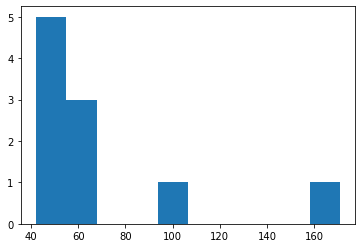

In [67]:
plt.hist(accepted_all[0.05].values())

In [64]:
accepted_all[0.05]

{0: 100, 1: 42, 2: 55, 3: 56, 4: 52, 5: 171, 6: 42, 7: 47, 8: 59, 9: 46}

In [70]:
accepted_all

{0.05: {0: 100,
  1: 42,
  2: 55,
  3: 56,
  4: 52,
  5: 171,
  6: 42,
  7: 47,
  8: 59,
  9: 46},
 0.3: {0: 46,
  1: 160,
  2: 151,
  3: 163,
  4: 88,
  5: 53,
  6: 69,
  7: 153,
  8: 56,
  9: 43},
 0.5: {0: 56, 1: 52, 2: 114, 3: 76, 4: 73, 5: 48, 6: 57, 7: 50, 8: 51, 9: 55},
 1: {0: 123, 1: 63, 2: 119, 3: 51, 4: 93, 5: 52, 6: 71, 7: 49, 8: 49, 9: 54},
 2: {0: 50, 1: 61, 2: 53, 3: 70, 4: 147, 5: 54, 6: 59, 7: 86, 8: 53, 9: 59},
 5: {0: 97,
  1: 104,
  2: 95,
  3: 79,
  4: 162,
  5: 45,
  6: 165,
  7: 161,
  8: 154,
  9: 107},
 10: {0: 95, 1: 140, 2: 158, 3: 41, 4: 62, 5: 73, 6: 49, 7: 64, 8: 59, 9: 70}}

In [47]:
accepted_s_num_dict

{0.05: {0: 5, 1: 8, 2: 5},
 0.3: {0: 3, 1: 6, 2: 6},
 0.5: {0: 10, 1: 7, 2: 5, 3: 4, 4: 8},
 1: {0: 6, 1: 6, 2: 7, 3: 5},
 2: {0: 11, 1: 4, 2: 1, 3: 6},
 5: {0: 5, 1: 2, 2: 3, 3: 8},
 10: {0: 4, 1: 5, 2: 7}}

In [293]:
accepted_s_num_dict

{0.05: {0: 22, 1: 27, 2: 26, 3: 25},
 0.3: {0: 26, 1: 24, 2: 19, 3: 25},
 0.5: {0: 1, 1: 0, 2: 0},
 1: {0: 17, 1: 19, 2: 17, 3: 20, 4: 22},
 2: {0: 6, 1: 4, 2: 3, 3: 1, 4: 2},
 5: {0: 10, 1: 1, 2: 5},
 10: {0: 2, 1: 1, 2: 2}}

In [50]:
mylist=[]
for s in step_list:
    mylist.append(np.sum(list(accepted_s_num_dict[s].values())))


In [51]:
mylist

[28, 24, 17, 19, 18, 19, 18]

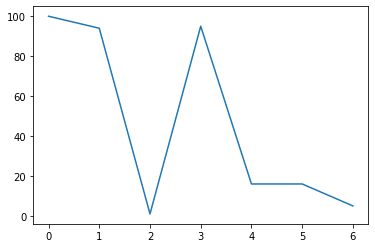

In [308]:
plt.plot(mylist)
#step size equal to 1 has almost 30 percent accepted samples and also it is not too small.

# Fixed step size=1 , M=7, compare different pixels

In [68]:
##########IT's last one 
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)


train_data=X_train.iloc[:,40001]
N=train_data.shape[0]
test_data=X_test.iloc[:,40001]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0
M=7
accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
target_pdf=TRG_pdf
proposal_step=1
n_samples=50
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)
alpha=[1,1,1,1,1,1,1]
mu=[1,1,1,1,1,1,1]
#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,-5,-4,-3,-2,-1]
for val in val_list:
    MSE_train=[]
    print('val',val)
    train_data=X_train.iloc[:,val]
    N=train_data.shape[0]
    test_data=X_test.iloc[:,val]
    N_test=test_data.shape[0]
    alpha=[1,1,1,1,1,1,1]
    mu=[1,1,1,1,1,1,1]
    pi=np.zeros((N,M))
    for it in range(100):
        #if it%5==0:
        print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[it]=accepted_s_num
            #Step2:
        print('mu before step2',mu)
        print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        print('mu after opt',mu)
            #Step3:
        sample_check={}
        current_state = alpha#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            print('sample num',_)
                    # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                        #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
        MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
        for time in range(10000):
                #print('time',time)
            MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        print(np.round(np.mean(MSE_trend_check),4))
        MSE_train.append(np.mean(MSE_trend_check))
        if (it>1) and (MSE_train[-2]-MSE_train[-1])<0.01*MSE_train[-2]:
            print('MSE_train:',MSE_train,'diff',MSE_train[-2]-MSE_train[-1],'criteria:',0.01*MSE_train[-2])
            break
    print('Alpha',alpha)
    print('mu',mu)
    print('training is finished:)')    
    MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
    for time in range(10000):
        if time%1000==0:
            print('time in test:',time)
        MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
    print('MSE_test:',np.round(np.mean(MSE_test),6))
    M_trend_check_te.append(np.mean(MSE_test))
    print('alpha',alpha)
    print('mu',mu)
    print('MSE_train',MSE_train)
    print('M_trend_check_te',M_trend_check_te)
    alpha_dict[val]=alpha
    mu_dict[val]=mu

val 0
iteration: 0
mu before step2 [1, 1, 1, 1, 1, 1, 1]
alpha before step2 [1, 1, 1, 1, 1, 1, 1]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5629.505142691992 for (1.9023986470772072, 0.4157739182522052, 0.3046429705799778, 0.012389706521185975, 1.3707775379235316, 1.949801389438249, 0.22990717759388157)
0.6539
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.90239865 0.41577392 0.30464297 0.01238971 1.37077754 1.94980139
 0.22990718]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample 

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5627.238680360816 for (1.9023986470772072, 0.4157739182522052, 0.3046429705799778, 0.012389706521185975, 1.3707775379235316, 1.949801389438249, 0.22990717759388157)
0.6539
MSE_train: [0.6539489163394528, 0.6539489163394528, 0.6539489163394528] diff 0.0 criteria: 0.006539489163394529
Alpha [1.90239865 0.41577392 0.30464297 0.01238971 1.37077754 1.94980139
 0.22990718]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
tim

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2002.402437597482 for (1.5547794311469543, 0.6264003127654929, 1.920484565036792, 0.8897009131394229, 0.011220231263947889, 1.7755839058042149, 2.893209219140407)
1.2848
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.55477943 0.62640031 1.92048457 0.88970091 0.01122023 1.77558391
 2.89320922]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0,

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -4599.039195128643 for (85.31082511018765, 58.8780390413712, 89.19546246057521, 26.661661175600592, 65.62012420501357, 88.40426345637815, 0.04493126813265293)
1.2848
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [8.53108251e+01 5.88780390e+01 8.91954625e+01 2.66616612e+01
 6.56201242e+01 8.84042635e+01 4.49312681e-02]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample n

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -4305.770192626006 for (3.429182696856498, 5.458062247348548, 1.8352346622522464, 2.8418792997329234, 0.010727247973901136, 2.729368342407573, 4.3884553376184146)
2.2476
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [3.4291827  5.45806225 1.83523466 2.8418793  0.01072725 2.72936834
 4.38845534]
mu after opt [0.9999975710043285, 0.9999961078726057, 0.9999987043649924, 0.999997952494749, 0.9999999922571192, 0.9999980655908809, 0.999996856737051]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -4219.793095142161 for (3.429182696856498, 5.458062247348548, 1.8352346622522464, 2.8418792997329234, 0.010727247973901136, 2.729368342407573, 4.3884553376184146)
2.2476
iteration: 2
mu before step2 [0.9999975710043285, 0.9999961078726057, 0.9999987043649924, 0.999997952494749, 0.9999999922571192, 0.9999980655908809, 0.999996856737051]
alpha before step2 [3.4291827  5.45806225 1.83523466 2.8418793  0.01072725 2.72936834
 4.38845534]
m

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -12469.401135577418 for (64.05343592330837, 51.35442148183984, 3.3321320825878935, 83.33716976495003, 0.0775076999535447, 28.639429649534343, 84.92267456867658)
2.2476
MSE_train: [2.247646686393055, 2.2476384539001493, 2.247638135433828] diff 3.1846632131404817e-07 criteria: 0.022476384539001495
Alpha [6.40534359e+01 5.13544215e+01 3.33213208e+00 8.33371698e+01
 7.75077000e-02 2.86394296e+01 8.49226746e+01]
mu [0.9999973192939293, 0.9999961792470908, 0.9999997959580922, 0.9999982628081797, 1.0000006935327523, 0.9999975460388713, 0.9999962654683952]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -7464.794982579808 for (4.293066705554437, 3.7254971139280313, 2.2566015529411674, 3.556275813658898, 2.5471522512195426, 0.017769459143305084, 5.059402510514282)
2.1063
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [4.29306671 3.72549711 2.25660155 3.55627581 2.54715225 0.01776946
 5.05940251]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample nu

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -7629.78088070415 for (4.293066705554437, 3.7254971139280313, 2.2566015529411674, 3.556275813658898, 2.5471522512195426, 0.017769459143305084, 5.059402510514282)
2.1063
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [4.29306671 3.72549711 2.25660155 3.55627581 2.54715225 0.01776946
 5.05940251]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -14552.066396262397 for (1.0706929060438735, 3.677895691398477, 0.902186743154537, 0.040222549387719964, 0.15086953570915373, 4.679775289879915, 0.6317231652914935)
2.6525
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.07069291 3.67789569 0.90218674 0.04022255 0.15086954 4.67977529
 0.63172317]
mu after opt [1.000014000618809, 0.9999603628275711, 1.000000197150304, 1.000005646177109, 1.0000125359541734, 0.999948257012012, 1.0000047079315277]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -6348.508516530698 for (0.30014443612930064, 4.09671866158308, 0.6120527543441665, 0.010226384110858168, 1.962429650659511, 4.490819265621476, 1.2291406335675612)
2.6524
iteration: 2
mu before step2 [1.000014000618809, 0.9999603628275711, 1.000000197150304, 1.000005646177109, 1.0000125359541734, 0.999948257012012, 1.0000047079315277]
alpha before step2 [0.30014444 4.096

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -15541.696899996356 for (27.295470092843352, 64.58536930161536, 14.923770853333766, 89.66064575020619, 67.03246058664762, 92.71980653537788, 0.09060183288005424)
2.6524
MSE_train: [2.6524816249764926, 2.652389353307934, 2.6524304326616046] diff -4.1079353670703256e-05 criteria: 0.02652389353307934
Alpha [2.72954701e+01 6.45853693e+01 1.49237709e+01 8.96606458e+01
 6.70324606e+01 9.27198065e+01 9.06018329e-02]
mu [1.0000139605792917, 0.9999603799333004, 1.0000001245118808, 1.0000057441171668, 1.0000124927288678, 0.9999484487745499, 1.0000046502875726]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 507.3260094194405 for (0.13631806587946632, 2.0172935114287496, 0.6187677819536083, 3.3622184824548036, 0.01966903246343432, 2.590866299043168, 2.694006532845378)
0.9759
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.13631807 2.01729351 0.61876778 3.36221848 0.01966903 2.5908663


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 190.04522191980809 for (0.13631806587946632, 2.0172935114287496, 0.6187677819536083, 3.3622184824548036, 0.01966903246343432, 2.590866299043168, 2.694006532845378)
0.9759
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.13631807 2.01729351 0.61876778 3.36221848 0.01966

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 1659.0462517673911 for (0.9434975607106353, 2.721649829536829, 0.43177492209735524, 3.9024840691246165, 0.015421749738143316, 3.014608708480025, 2.546046816545689)
0.9759
MSE_train: [0.9758542177227398, 0.9758542177227398, 0.9758542177227398] diff 0.0 criteria: 0.009758542177227398
Alpha [0.94349756 2.72164983 0.43177492 3.90248407 0.01542175 3.01460871
 2.54604682]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.9760

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -2143.4343938396405 for (2.1565883393343954, 0.5107914434145884, 0.025481002095591787, 4.22761552899189, 1.937073293593949, 1.0746422331883831, 0.8966524222874832)
1.0475
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [2.15658834 0.51079144 0.025481   4.22761553 1.93707329 1.07464223
 0.89665242]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample n

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 998.0264344791434 for (2.117386322000432, 0.014880745923035177, 1.033218218883948, 3.272229258143973, 2.4625288575573347, 2.354848359022277, 1.5538793152759691)
1.0475
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [2.11738632 0.01488075 1.03321822 3.27222926 2.46252886 2.35484836
 1.55387932]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4721.64716714458 for (0.2701655216005112, 1.7265828057772654, 3.1871151983069614, 0.8522948114074557, 2.913834455605854, 0.010104697573291577, 0.5304775139883029)
1.0537
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.27016552 1.72658281 3.1871152  0.85229481 2.91383446 0.0101047
 0.53047751]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -4750.873772629559 for (32.79557151360855, 70.8796424056974, 69.35361762108579, 21.33454898326782, 0.13414748979773997, 48.00579260121113, 8.886167445806635)
1.0537
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [32.79557151 70.87964241 69.35361762 21.33454

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1468.9909642396897 for (32.20146825151974, 71.64487989260864, 71.06139199884674, 20.25762568237275, 0.028028365974893596, 49.26522359881866, 9.255349471241926)
1.0537
MSE_train: [1.0537304220216277, 1.0537304220216277, 1.0537304220216277] diff 0.0 criteria: 0.010537304220216277
Alpha [3.22014683e+01 7.16448799e+01 7.10613920e+01 2.02576257e+01
 2.80283660e-02 4.92652236e+01 9.25534947e+00]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 1.034982
alpha [3.22014683e+01 7.16448799e+01 7.10613920e+01 2.02576257e+01
 2.80283660e-02 4.92652236e+01 9.25534947e+00]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
MSE_train [1.0537304220216277, 1.0537304220216277, 1.0537304220216277]
M_trend_check_te [0.6212250294066533, 1.250002365115531, 2.231344522845779, 2.083111456405306, 2.5

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2815.081287695376 for (4.0865976977693, 4.3672353739634335, 1.6940033197440494, 0.01872063636982113, 1.891207281667842, 1.9555761748090459, 2.815129517515551)
0.5763
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [4.0865977  4.36723537 1.69400332 0.01872064 1.89120728 1.95557617
 2.81512952]
mu after opt [0.9999944362851724, 0.999994

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 6705.229931075235 for (3.203690952966571, 4.327351608119205, 1.4450992258966653, 0.011456804907276087, 2.131435808119442, 2.31639037087868, 1.6324464397623033)
0.5763
iteration: 2
mu before step2 [0.9999944362851724, 0.9999941027922521, 0.9999976953113437, 0.9999999727308436, 0.999997500046941, 0.9999973567819195, 0.9999961500886494]
alpha before step2 [3.20369095 4.32735161 1.44509923 0.0114568  2.13143581 2.31639037
 1.63244644]
mu after opt [0.9999944362851724, 0.9999941027922521, 0.9999976953113437, 0.9999999727308436, 0.999997500046941, 0.9999973567819195, 0.9999961500886494]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -84.0021317182186 for (22.542360237268923, 0.05106945876827909, 33.04323713348763, 7.742843549526979, 51.591132134809435, 69.76765734906671, 42.1257620837616)
0.5763
MSE_train: [0.5762880056573703, 0.5762815229945463, 0.5762834761898341] diff -1.953195287840437e-06 criteria: 0.005762815229945463
Alpha [2.25423602e+01 5.10694588e-02 3.30432371e+01 7.74284355e+00
 5.15911321e+01 6.97676573e+01 4.21257621e+01]
mu [0.9999944362851724, 0.9999941027922521, 0.9999976953113437, 0.9999999727308436, 0.999997500046941, 0.9999973567819195, 0.9999961500886494]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
t

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5154.04199964982 for (0.518385354730588, 2.4239049481454513, 0.012104750349738624, 6.2535883558319085, 0.5508906101783135, 0.7303232157153166, 1.0272810993470731)
0.7723
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.51838535 2.42390495 0.01210475 6.25358836 0.55089061 0.73032322
 1.0272811 ]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample nu

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 5162.028758384632 for (0.4893991146318511, 1.691546812682642, 0.2744880453285197, 8.616065857575936, 2.0054170037867696, 2.043265475375147, 0.01266111392668301)
0.7723
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.48939911 1.69154681 0.27448805 8.61606586 2.005417   2.04326548
 0.01266111]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 4759.415111001091 for (0.4893991146318511, 1.691546812682642, 0.2744880453285197, 8.616065857575936, 2.0054170037867696, 2.043265475375147, 0.01266111392668301)
0.7723
MSE_train: [0.7723465456669358, 0.7723465456669358, 0.7723465456669358] diff 0.0 criteria: 0.007723465456669358
Alpha [0.48939911 1.69154681 0.27448805 8.61606586 2.005417   2.04326548
 0.01266111]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.773913
alpha [0.48939911 1.69154681 0.27448805 8.61606586 2.005417   2.04326548
 0.01266111]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
MSE_train [0.7723465456669358, 0.7723465456

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -9249.86667799964 for (4.238556578445469, 3.373426187273247, 0.680565486265292, 0.01332051582215385, 2.0790719572968746, 7.115727235532232, 0.9981812292791035)
2.6906
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [4.23855658 3.37342619 0.68056549 0.01332052 2.07907196 7.11572724
 0.99818123]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -9453.008661233342 for (4.238556578445469, 3.373426187273247, 0.680565486265292, 0.01332051582215385, 2.0790719572968746, 7.115727235532232, 0.9981812292791035)
2.6906
iteration: 2
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [4.23855658 3.37342619 0.68056549 0.01332052 2.07907196 7.11572724
 0.99818123]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -5587.669143862822 for (1.188696384759126, 3.0409887814169134, 1.5818487447782315, 2.5615789826183604, 2.7121892985575666, 1.9209656240720596, 0.05160419683005668)
1.1936
iteration: 1
mu before step2 [0.9998947344400871, 0.9998944569889285, 0.9998942168714637, 0.9998932585038373, 0.9998930879996871, 0.9998928708924129, 0.9998928005

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -5968.093732125599 for (3.5981514774351777, 6.080392386183439, 0.020744290550506347, 2.3437588388684025, 3.427890976108624, 4.239687049183429, 2.998697201568385)
1.7515
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [3.59815148 6.08039239 0.02074429 2.34375884 3.42789098 4.23968705
 2.9986972 ]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sam

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was -3970.602147179075 for (3.2865363979561915, 7.396744053757688, 0.015247405533523366, 2.3649277075544752, 3.6290926925546296, 5.447092919334483, 3.3592693604585393)
1.7515
MSE_train: [1.7514922039574299, 1.7514922039574299, 1.7514922039574299] diff 0.0 criteria: 0.0175149220395743
Alpha [3.2865364  7.39674405 0.01524741 2.36492771 3.62909269 5.44709292
 3.35926936]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 1.745944
alpha [3.2865364  7.39674405 0.01524741 2.36492771 3.62909269 5.44709292
 3.35926936]
mu [1.0, 1.

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36
sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2840.795544640181 for (0.0965764722768615, 3.584995307293127, 2.5230280236162765, 0.31312503401123387, 3.1918323357026823, 4.038014262632345, 0.02128343891017148)
0.6466
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [0.09657647 3.58499531 2.52302802 0.31312503 3.19183234 4.03801426
 0.02128344]
mu after opt [1.0, 1.0, 1

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 2586.678000578444 for (0.0965764722768615, 3.584995307293127, 2.5230280236162765, 0.31312503401123387, 3.1918323357026823, 4.038014262632345, 0.02128343891017148)
0.6466
MSE_train: [0.6465854065050742, 0.6465854065050742, 0.6465854065050742] diff 0.0 criteria: 0.006465854065050743
Alpha [0.09657647 3.58499531 2.52302802 0.31312503 3.19183234 4.03801426
 0.02128344]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.664644
alpha [0.09657647 3.58499531 2.52302802 0.31312503 3.19183234 4.03801426
 0.02128344]
mu [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
MSE_train [0.6465854065050742, 0.6465854065050742, 0.6465854065050742]
M_trend_check_te [0.6212250294066533, 1.250002365115531, 2.231344522845779, 2.083111456405306, 2

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/717997214.py:150: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample num 30
sample num 31
sample num 32
sample num 33
sample num 34
sample num 35
sample num 36


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 37
sample num 38
sample num 39
sample num 40
sample num 41
sample num 42
sample num 43
sample num 44
sample num 45
sample num 46
sample num 47
sample num 48
sample num 49
highest pdf was 3896.7268923912216 for (2.7483417969001307, 2.5015900127410595, 2.5387532233421832, 4.8970633435609185, 3.9387277267497693, 1.8136011219135297, 0.023384670703291255)
0.2638
iteration: 1
mu before step2 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
alpha before step2 [2.7483418  2.50159001 2.53875322 4.89706334 3.93872773 1.81360112
 0.02338467]
mu after opt [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 1
sample num 2
sample num 3
sample num 4
sample num 5
sample num 6
sample num 7
sample num 8
sample num 9
sample num 10
sample num 11
sample num 12
sample num 13
sample num 14
sample num 15
sample num 16
sample num 17
sample num 18
sample num 19
sample num 20
sample num 21
sample num 22
sample num 23
sample num 24
sample num 25
sample num 26
sample num 27
sample num 28
sample num 29
sample

In [77]:
MSE_train

[0.2638362960633104, 0.2638362960633104, 0.2638362960633104]

In [69]:
alpha_dict

{0: array([1.90239865, 0.41577392, 0.30464297, 0.01238971, 1.37077754,
        1.94980139, 0.22990718]),
 1: array([8.53108251e+01, 5.88780390e+01, 8.91954625e+01, 2.66616612e+01,
        6.56201242e+01, 8.84042635e+01, 4.49312681e-02]),
 2: array([6.40534359e+01, 5.13544215e+01, 3.33213208e+00, 8.33371698e+01,
        7.75077000e-02, 2.86394296e+01, 8.49226746e+01]),
 3: array([4.29306671, 3.72549711, 2.25660155, 3.55627581, 2.54715225,
        0.01776946, 5.05940251]),
 4: array([2.72954701e+01, 6.45853693e+01, 1.49237709e+01, 8.96606458e+01,
        6.70324606e+01, 9.27198065e+01, 9.06018329e-02]),
 40000: array([0.94349756, 2.72164983, 0.43177492, 3.90248407, 0.01542175,
        3.01460871, 2.54604682]),
 40001: array([2.11738632, 0.01488075, 1.03321822, 3.27222926, 2.46252886,
        2.35484836, 1.55387932]),
 40002: array([3.22014683e+01, 7.16448799e+01, 7.10613920e+01, 2.02576257e+01,
        2.80283660e-02, 4.92652236e+01, 9.25534947e+00]),
 40003: array([2.25423602e+01, 5.106

In [76]:
df

0          1          2          3          4          5  \
 0      0.012390   0.229907   0.304643   0.415774   1.370778   1.902399   
 1      0.044931  26.661661  58.878039  65.620124  85.310825  88.404263   
 2      0.077508   3.332132  28.639430  51.354421  64.053436  83.337170   
 3      0.017769   2.256602   2.547152   3.556276   3.725497   4.293067   
 4      0.090602  14.923771  27.295470  64.585369  67.032461  89.660646   
 40000  0.015422   0.431775   0.943498   2.546047   2.721650   3.014609   
 40001  0.014881   1.033218   1.553879   2.117386   2.354848   2.462529   
 40002  0.028028   9.255349  20.257626  32.201468  49.265224  71.061392   
 40003  0.051069   7.742844  22.542360  33.043237  42.125762  51.591132   
 40004  0.012661   0.274488   0.489399   1.691547   2.005417   2.043265   
-5      0.013321   0.680565   0.998181   2.079072   3.373426   4.238557   
-4      0.050051   2.149268   2.298317   2.450444   2.920691   4.293021   
-3      0.015247   2.364928   3.286536   3.359269   3.629093   5.447093   
-2      0.021283   0.096576   0.313125   2.523028   3.191832   3.584995   
-1      0.023385   1.813601   2.501590   2.538753   2.748342   3.938728   

                6  
 0       1.949801  
 1      89.195462  
 2      84.922675  
 3       5.059403  
 4      92.719807  
 40000   3.902484  
 40001   3.272229  
 40002  71.644880  
 40003  69.767657  
 40004   8.616066  
-5       7.115727  
-4       4.501477  
-3       7.396744  
-2       4.038014  
-1       4.897063

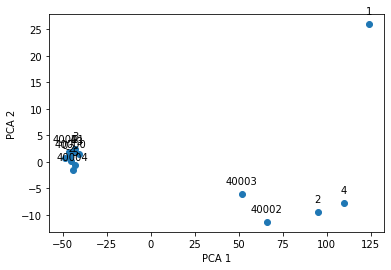

In [73]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}
val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,-5,-4,-3,-2,-1]
for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])
    

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
#plt.show()
plt.savefig('15pixM7.jpg')

In [74]:
os.getcwd()

'M:\\LIU\\Thesis\\my thesis\\Nicholas article\\data\\data'

# *Below is a good result when all the points started from 1,1,... points =mu and alpha*
val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]

In [60]:
mu

[0.9999815813133692,
 1.0000015650516176,
 0.9999960786005286,
 1.0000003549908982,
 0.9999924048677664,
 0.9999992798198518,
 1.000002903801081]

In [59]:
alpha_dict

{0: array([2.00880365, 3.62018721, 0.01568884, 1.43921232, 2.76127711,
        3.56231528, 0.09859803]),
 1: array([2.42493775, 0.10925309, 2.65162666, 4.85318052, 0.01982641,
        0.10697833, 0.06421789]),
 2: array([2.44512485, 0.49671096, 4.21672943, 0.01615418, 1.36013063,
        0.03014476, 0.9797937 ]),
 3: array([2.58349043, 1.51942566, 1.83693765, 0.78403673, 2.41416002,
        3.42133115, 0.01147304]),
 4: array([87.76976496, 50.61250362, 87.60890088, 22.6578385 , 67.6536419 ,
        92.08960151,  0.10554639]),
 40000: array([3.47112139, 0.88492697, 0.01350818, 2.05649319, 0.1097423 ,
        2.32220111, 0.818581  ]),
 40001: array([1.60495076, 2.92431296, 0.01809283, 1.88332652, 0.20838407,
        3.91787253, 0.08693852]),
 40002: array([2.14407658, 2.22828608, 2.69975485, 1.11357827, 4.30251209,
        0.78514514, 0.0154615 ]),
 40003: array([3.6840891 , 1.25463225, 1.77209964, 0.54217124, 0.01104725,
        0.30772805, 3.37693313]),
 40004: array([3.52957854, 4.525

In [57]:
sorted(alpha_dict[0])
new_alpha_dict={}
for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])
    

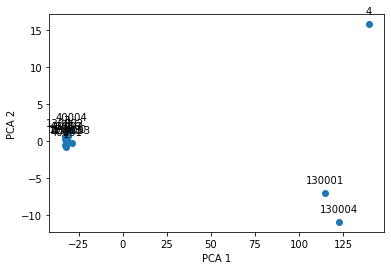

In [58]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}
for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()


#below are olf results

In [369]:
alpha_dict

{0: array([9.01345813e+01, 1.64884006e-02, 9.90790995e+01, 6.38080353e+01,
        4.03432145e+01, 6.20551799e+01, 3.43360736e+01]),
 1: array([6.02723109e+01, 5.79238287e+01, 1.55436146e+01, 1.84631524e+01,
        1.08085459e+01, 1.40525336e-02, 4.86661112e+01]),
 2: array([28.25573145, 35.23354579, 42.8298625 , 51.46240465, 56.3203449 ,
        24.61498845, 57.13563073]),
 3: array([9.19968095e+01, 2.13310738e-02, 2.52802989e+01, 7.08433462e+01,
        6.39171966e+01, 1.50828098e+01, 4.69799362e+00]),
 4: array([6.61935571e+01, 8.06660467e+01, 6.54818280e+01, 1.97302010e-02,
        2.88231914e+01, 8.22933391e+01, 6.14761269e+01]),
 40000: array([3.26515479e+01, 2.01550291e+01, 9.49021106e+01, 2.84495246e+01,
        3.75793801e+01, 1.53408296e-02, 7.09087188e+01]),
 40001: array([  5.97751718,  67.47301531,  88.07219628,  67.0769844 ,
         91.68895467, 112.56908571,  87.66390123]),
 40002: array([6.52651163e+01, 1.80920448e-02, 1.16254222e+02, 1.88712036e+01,
        5.6875880

In [391]:
#To prove the correlation coefficient
np.corrcoef(df_flatten_GMM_clus1.iloc[:,0:171])

array([[1.        , 0.99169353, 0.98530345, ..., 0.98187068, 0.98233058,
        0.97812161],
       [0.99169353, 1.        , 0.99806138, ..., 0.99403953, 0.99286119,
        0.9905889 ],
       [0.98530345, 0.99806138, 1.        , ..., 0.99480339, 0.99161122,
        0.99099234],
       ...,
       [0.98187068, 0.99403953, 0.99480339, ..., 1.        , 0.99694212,
        0.99503599],
       [0.98233058, 0.99286119, 0.99161122, ..., 0.99694212, 1.        ,
        0.99453342],
       [0.97812161, 0.9905889 , 0.99099234, ..., 0.99503599, 0.99453342,
        1.        ]])

In [394]:
sorted(alpha_dict[0])
new_alpha_dict={}
for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])
    

In [395]:
new_alpha_dict

{0: [0.016488400640575676,
  34.33607356373371,
  40.343214502683004,
  62.055179904104236,
  63.80803527014865,
  90.13458128275525,
  99.07909945774341],
 1: [0.014052533571329217,
  10.808545911997626,
  15.543614575711569,
  18.46315243013771,
  48.66611115288755,
  57.92382868560411,
  60.27231086709196],
 2: [24.614988446178852,
  28.25573144587387,
  35.23354578526791,
  42.82986250337724,
  51.46240464660827,
  56.32034490183282,
  57.1356307279914],
 3: [0.021331073765386965,
  4.697993622944965,
  15.082809845530866,
  25.280298934875404,
  63.917196601500684,
  70.84334617500438,
  91.99680949977372],
 4: [0.019730200951195723,
  28.823191416786482,
  61.47612686974195,
  65.48182801770257,
  66.19355712550636,
  80.66604668444273,
  82.29333913219894],
 40000: [0.015340829638703368,
  20.155029074798062,
  28.449524572231482,
  32.651547932459714,
  37.57938008435615,
  70.90871875045883,
  94.90211056011576],
 40001: [5.977517178120605,
  67.07698440445488,
  67.4730153105

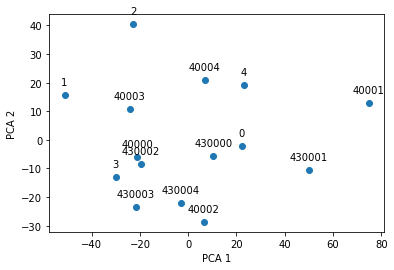

In [406]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()


optimal M has been foudn for different pixels

In [103]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)


train_data=X_train.iloc[:,40001]
N=train_data.shape[0]
test_data=X_test.iloc[:,40001]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

alpha=generate_m_positive_random_numbers(M)
mu0=np.zeros(M)
values=np.linspace(-10,10,100)
mu0=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
target_pdf=TRG_pdf
proposal_step=1
n_samples=100
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha0=generate_m_positive_random_numbers(M)
alpha=[1,1,1,1,1,1,1]
mu=[1,1,1,1,1,1,1]
#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[2,3,4,40000,40001,40002,40003,40004,-5,-4,-3,-2,-1]
M=6
for val in val_list:
    MSE_train=[]
    print('val',val)
    train_data=X_train.iloc[:,val]
    N=train_data.shape[0]
    test_data=X_test.iloc[:,val]
    N_test=test_data.shape[0]
    alpha=alpha0
    mu=mu0
    print('alpha0:',alpha0,'mu0',mu0)
    pi=np.zeros((N,M))
    for it in range(100):
        #if it%5==0:
        print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[it]=accepted_s_num
            #Step2:
        print('mu before step2',mu)
        print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        print('mu after opt',mu)
            #Step3:
        sample_check={}
        current_state = alpha#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            if _ %10==0:
                print('sample num',_)
                    # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                        #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
        MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
        for time in range(10000):
                #print('time',time)
            MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        print(np.round(np.mean(MSE_trend_check),4))
        MSE_train.append(np.mean(MSE_trend_check))
        if (it>1) and (MSE_train[-2]-MSE_train[-1])<0.01*MSE_train[-2]:
            print('MSE_train:',MSE_train,'diff',MSE_train[-2]-MSE_train[-1],'criteria:',0.01*MSE_train[-2])
            break
    print('Alpha',alpha)
    print('mu',mu)
    print('training is finished:)')    
    MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
    for time in range(10000):
        if time%1000==0:
            print('time in test:',time)
        MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
    print('MSE_test:',np.round(np.mean(MSE_test),6))
    M_trend_check_te.append(np.mean(MSE_test))
    print('alpha',alpha)
    print('mu',mu)
    print('MSE_train',MSE_train)
    print('M_trend_check_te',M_trend_check_te)
    alpha_dict[val]=alpha
    mu_dict[val]=mu

val 2
alpha0: [23.688609438558146, 3.09109403244373, 78.87938399645599, 34.615435670056335, 62.33191468916645, 61.58541135341048] mu0 [ 7.17171717  7.77777778 -7.97979798 -7.57575758  9.7979798  -0.90909091]
iteration: 0
mu before step2 [ 7.17171717  7.77777778 -7.97979798 -7.57575758  9.7979798  -0.90909091]
alpha before step2 [23.688609438558146, 3.09109403244373, 78.87938399645599, 34.615435670056335, 62.33191468916645, 61.58541135341048]
mu after opt [ 7.17172304  7.77777634 -7.97979486 -7.57575001  9.79798535 -0.90908363]
sample num 0
sample num 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 7045.762996624196 for (25.618943651389944, 0.01603862425564953, 78.43469001093223, 35.50290627668463, 63.57787200662446, 63.082735576751595)
0.2065
iteration: 1
mu before step2 [ 7.17172304  7.77777634 -7.97979486 -7.57575001  9.79798535 -0.90908363]
alpha before step2 [2.56189437e+01 1.60386243e-02 7.84346900e+01 3.55029063e+01
 6.35778720e+01 6.30827356e+01]
mu after opt [ 7.17172304  7.77777634 -7.97979486 -7.57575001  9.79798535 -0.90908363]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 80
sample num 90
highest pdf was 7785.975815485806 for (26.149149311475593, 0.014846477096157053, 78.13148089264409, 33.77600617503607, 64.17476379042276, 62.92954973293105)
0.2076
iteration: 2
mu before step2 [ 7.17172304  7.77777634 -7.97979486 -7.57575001  9.79798535 -0.90908363]
alpha before step2 [2.61491493e+01 1.48464771e-02 7.81314809e+01 3.37760062e+01
 6.41747638e+01 6.29295497e+01]
mu after opt [ 7.17175528  7.77780436 -7.97977934 -7.57573586  9.79799281 -0.90908544]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 7856.3068005153145 for (26.149149311475593, 0.014846477096157053, 78.13148089264409, 33.77600617503607, 64.17476379042276, 62.92954973293105)
0.2085
MSE_train: [0.20646293560409262, 0.20763648783820768, 0.20847953126212657] diff -0.0008430434239188878 criteria: 0.002076364878382077
Alpha [2.61491493e+01 1.48464771e-02 7.81314809e+01 3.37760062e+01
 

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 30
sample num 40


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 4272.9692440293275 for (20.098734417724216, 0.02569982059727246, 78.7064524316345, 33.439796623529844, 66.789696136265, 60.69807974344306)
0.2217
iteration: 1
mu before step2 [ 7.17173677  7.77782633 -7.97978773 -7.5757189   9.79799259 -0.90908204]
alpha before step2 [2.00987344e+01 2.56998206e-02 7.87064524e+01 3.34397966e+01
 6.67896961e+01 6.06980797e+01]
mu after opt [ 7.17175767  7.77785261 -7.97976522 -7.5757362   9.79803176 -0.90907269]
sample num 0
sample num 10
sample num 20
sample num 30


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 5336.811097850815 for (19.245405351725587, 0.02125786948828104, 78.64135332774396, 32.5278953507851, 67.10544924553041, 61.83027642811254)
0.2198
iteration: 2
mu before step2 [ 7.17175767  7.77785261 -7.97976522 -7.5757362   9.79803176 -0.90907269]
alpha before step2 [1.92454054e+01 2.12578695e-02 7.86413533e+01 3.25278954e+01
 6.71054492e+01 6.18302764e+01]
mu after opt [ 7.17175767  7.77785261 -7.97976522 -7.5757362   9.79803176 -0.90907269]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9959.080804190118 for (17.812010219987602, 0.010890823453681638, 79.8143322747114, 33.76251123141199, 66.53003327421771, 60.00051519257533)
0.2569
MSE_train: [0.22170633777505155, 0.2198245335521191, 0.2569153922929446] diff -0.03709085874082549 criteria: 0.002198245335521191
Alpha [1.78120102e+01 1.08908235e-02 7.98143323e+01 3.37625112e+01
 6.65300333e+01 6.00005152e+01]
mu [ 7.17175767  7.77785261 -7.97976522 -7.5757362   9.79803176 -0.90907269]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.260499
alpha [1.78120102e+01 1.08908235e-02 7.98143323e+01 3.37625112e+01
 6.65300333e+01 6.00005152e+01]
mu [ 7.17175767  7.77785261 -7.97976522 -7.5757362   9.79803176 -0.90907269]


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 30
sample num 40
sample num 50
sample num 60


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 70
sample num 80
sample num 90
highest pdf was 3813.521506788235 for (23.598290736928707, 0.029672495264563368, 82.13661504777227, 33.40642222651983, 63.867557770234406, 57.61172063293658)
0.2143
iteration: 1
mu before step2 [ 7.17175636  7.77785151 -7.9797672  -7.57575115  9.79802617 -0.90908206]
alpha before step2 [2.35982907e+01 2.96724953e-02 8.21366150e+01 3.34064222e+01
 6.38675578e+01 5.76117206e+01]
mu after opt [ 7.17175095  7.77785532 -7.97976804 -7.57575428  9.79802844 -0.90907875]
sample num 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 8776.016447076343 for (21.85718436092551, 0.013191863176094335, 82.02227027401065, 34.24544793555811, 63.011506396904004, 56.86218963580656)
0.2294
iteration: 2
mu before step2 [ 7.17175095  7.77785532 -7.97976804 -7.57575428  9.79802844 -0.90907875]
alpha before step2 [2.18571844e+01 1.31918632e-02 8.20222703e+01 3.42454479e+01
 6.30115064e+01 5.68621896e+01]
mu after opt [ 7.17175575  7.77786277 -7.97977264 -7.57573379  9.79803603 -0.90906831]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 392.06091717172865 for (5.133391045089571, 0.7095997720113549, 38.8559998500812, 13.342003545264479, 35.09872220361446, 99.27729207541508)
0.1901
iteration: 3
mu before step2 [ 7.17175575  7.77786277 -7.97977264 -7.57573379  9.79803603 -0.90906831]
alpha before step2 [ 5.13339105  0.70959977 38.85599985 13.34200355 35.0987222  99.27729208]
mu after opt [ 7.17176064  7.77786208 -7.97976737 -7.57573143  9.79803812 -0.90906762]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 7958.225624005476 for (5.267612887841399, 0.014886890948089468, 39.419302455490026, 11.156385575078525, 33.70661406893827, 101.76043148581849)
0.1843
iteration: 4
mu before step2 [ 7.17176064  7.77786208 -7.97976737 -7.57573143  9.79803812 -0.90906762]
alpha before step2 [5.26761289e+00 1.48868909e-02 3.94193025e+01 1.11563856e+01
 3.37066141e+01 1.01760431e+02]
mu after opt [ 7.17176064  7.77786208 -7.97976737 -7.57573143  9.79803812 -0.90906762]
sample num 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10
sample num 20
sample num 30
sample num 40


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 11323.102178487443 for (1.825727479852313, 0.010430371032078091, 38.839054349330596, 11.671997307806597, 35.075740025610266, 102.35582843351922)
0.1918
MSE_train: [0.21426005346746796, 0.22939594832323956, 0.19005643894573193, 0.18428399375745536, 0.19181296165455924] diff -0.007528967897103889 criteria: 0.0018428399375745536
Alpha [1.82572748e+00 1.04303710e-02 3.88390543e+01 1.16719973e+01
 3.50757400e+01 1.02355828e+02]
mu [ 7.17176064  7.77786208 -7.97976737 -7.57573143  9.79803812 -0.90906762]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.195838
alpha [1.82572748e+00 1.04303710e-02 3.88390543e+01 1.16719973e+01
 3.50757400e+01 1.02355828e+02]
mu [ 7.17176064  7.77786208 -7.97976737 -7.57573143  9.79803812 -0.90906762]
MSE_t

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 90
highest pdf was 975.8192046307948 for (24.68612297381353, 0.12265129341784925, 74.86982407717757, 25.043798031250013, 66.71829644805767, 69.55131916780003)
0.2129
iteration: 1
mu before step2 [ 7.1717629   7.77785941 -7.97976909 -7.5757377   9.79804439 -0.90907039]
alpha before step2 [24.68612297  0.12265129 74.86982408 25.04379803 66.71829645 69.55131917]
mu after opt [ 7.17176572  7.77786021 -7.97977053 -7.57573534  9.79804537 -0.9090699 ]
sample num 0
sample num 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 70
sample num 80
sample num 90
highest pdf was 3147.1810059794757 for (25.28222188133853, 0.0368412094294902, 74.7955973169934, 24.964176871709178, 68.161887696918, 67.8721499346315)
0.2068
iteration: 2
mu before step2 [ 7.17176572  7.77786021 -7.97977053 -7.57573534  9.79804537 -0.9090699 ]
alpha before step2 [2.52822219e+01 3.68412094e-02 7.47955973e+01 2.49641769e+01
 6.81618877e+01 6.78721499e+01]
mu after opt [ 7.17174536  7.77788345 -7.97976084 -7.57571903  9.79805997 -0.9090556 ]
sample num 0
sample num 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9015.979144627112 for (27.03734440083694, 0.01302455523344622, 74.49551341209285, 25.299235055198803, 65.44142189342192, 66.57957494575842)
0.2115
MSE_train: [0.21286526076443424, 0.20684417983988188, 0.21147140436341247] diff -0.004627224523530593 criteria: 0.0020684417983988187
Alpha [2.70373444e+01 1.30245552e-02 7.44955134e+01 2.52992351e+01
 6.54414219e+01 6.65795749e+01]
mu [ 7.17174536  7.77788345 -7.97976084 -7.57571903  9.79805997 -0.9090556 ]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.21143
alpha [2.70373444e+01 1.30245552e-02 7.44955134e+01 2.52992351e+01
 6.54414219e+01 6.65795749e+01]
mu [ 7.17174536  7.77788345 -7.97976084 -7.57571903  9.79805997 -0.9090556 ]
MSE_train [

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9836.487795905527 for (31.646219918980442, 0.011760906327512526, 69.9732092613936, 38.32325550189678, 69.32727788454994, 60.70822814248661)
0.2069
iteration: 1
mu before step2 [ 7.17173794  7.77792067 -7.97976558 -7.57571556  9.79807327 -0.909043  ]
alpha before step2 [3.16462199e+01 1.17609063e-02 6.99732093e+01 3.83232555e+01
 6.93272779e+01 6.07082281e+01]
mu after opt [ 7.17173823  7.7779162  -7.97976125 -7.57572233  9.79807348 -0.90904432]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9828.81279338869 for (31.646219918980442, 0.011760906327512526, 69.9732092613936, 38.32325550189678, 69.32727788454994, 60.70822814248661)
0.2067
iteration: 2
mu before step2 [ 7.17173823  7.7779162  -7.97976125 -7.57572233  9.79807348 -0.90904432]
alpha before step2 [3.16462199e+01 1.17609063e-02 6.99732093e+01 3.83232555e+01
 6.93272779e+01 6.07082281e+01]
mu after opt [ 7.17173853  7.77791647 -7.97975536 -7.57572157  9.79807536 -0.9090365 ]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9500.987383397824 for (31.646219918980442, 0.011760906327512526, 69.9732092613936, 38.32325550189678, 69.32727788454994, 60.70822814248661)
0.2065
MSE_train: [0.20686224836886036, 0.20667862161503003, 0.20650446662183145] diff 0.00017415499319858863 criteria: 0.0020667862161503005
Alpha [3.16462199e+01 1.17609063e-02 6.99732093e+01 3.83232555e+01
 6.93272779e+01 6.07082281e+01]


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 8237.857170547346 for (24.396647912642965, 0.011282055743630733, 76.78932185761387, 34.355353472278836, 62.5274067684457, 60.52988413094313)
0.478
iteration: 1
mu before step2 [ 7.17174506  7.7779056  -7.9797569  -7.57571589  9.798078   -0.9090356 ]
alpha before step2 [2.43966479e+01 1.12820557e-02 7.67893219e+01 3.43553535e+01
 6.25274068e+01 6.05298841e+01]
mu after opt [ 7.17174502  7.7779056  -7.97975692 -7.57571594  9.79807797 -0.90903561]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 8562.157900703518 for (24.396647912642965, 0.011282055743630733, 76.78932185761387, 34.355353472278836, 62.5274067684457, 60.52988413094313)
0.4786
iteration: 2
mu before step2 [ 7.17174502  7.7779056  -7.97975692 -7.57571594  9.79807797 -0.90903561]
alp

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 155.7758088180833 for (17.235436132910053, 67.41251871452116, 45.18452798346191, 53.55131930071756, 17.132780477674242, 56.59269597950398)
0.1917
iteration: 3
mu before step2 [ 7.17175301  7.77790442 -7.97975947 -7.57571137  9.79807484 -0.90903679]
alpha before step2 [17.23543613 67.41251871 45.18452798 53.5513193  17.13278048 56.59269598]
mu after opt [ 7.17175275  7.77791346 -7.97975072 -7.57570529  9.79808039 -0.90902979]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 214.7970313954804 for (20.172146441218477, 68.32839091160962, 45.780000434615, 55.56212016930244, 16.69738627520797, 57.94338441190635)
0.186
iteration: 4
mu before step2 [ 7.17175275  7.77791346 -7.97975072 -7.57570529  9.79808039 -0.90902979]
alpha before step2 [20.172146

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 159.59967220407677 for (30.52022147162756, 9.6800837715766, 74.87357366802156, 30.923026603690793, 67.48850198653167, 61.88124206202958)
0.2013
iteration: 1
mu before step2 [ 7.17174837  7.77792277 -7.97974577 -7.57570786  9.79808419 -0.90902258]
alpha before step2 [30.52022147  9.68008377 74.87357367 30.9230266  67.48850199 61.88124206]
mu after opt [ 7.17174837  7.77792277 -7.97974577 -7.57570786  9.79808419 -0.90902258]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 140.49552283683417 for (32.942624475953835, 7.9290105567167934, 74.73391510783702, 30.300150107822773, 66.95415221566647, 60.51199194829401)
0.2036
iteration: 2
mu before step2 [ 7.17174837  7.77792277 -7.97974577 -7.57570786  9.79808419 -0.90902258]
alpha before step2 [32.94

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 10625.059096456589 for (32.1365780168088, 0.010816179614431362, 73.16963523858963, 30.511491980292544, 70.57480418103553, 63.60442864113561)
0.2103
iteration: 1
mu before step2 [ 7.17174142  7.77792362 -7.97974513 -7.57570773  9.79809144 -0.909029  ]
alpha before step2 [3.21365780e+01 1.08161796e-02 7.31696352e+01 3.05114920e+01
 7.05748042e+01 6.36044286e+01]
mu after opt [ 7.17174224  7.77792561 -7.97974398 -7.57570994  9.79809208 -0.90902952]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was -154.03284143700276 for (24.4148041611714, 52.98481809866237, 65.9646433147499, 46.913108025385384, 35.00155828235582, 25.910013118537346)
0.2362
iteration: 2
mu before step2 [ 7.17174224  7.77792561 -7.97974398 -7.57570994  9.79809208 -0.90902952]
alpha before step2 [24.41480416 52.9848181  65.96464331 46.91310803 35.00155828 25.91001312]
mu after opt [ 7.17174313  7.77792615 -7.97974345 -7.57571012  9.79809225 -0.90902915]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 63.91626164197186 for (35.94749162328318, 55.41943104591479, 75.93676127697329, 45.84377168681444, 32.3303632729249, 36.98439222123466)
0.203
iteration: 3
mu before step2 [ 7.17174313  7.77792615 -7.97974345 -7.57571012  9.79809225 -0.90902915]
alpha before ste

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 10128.221413752299 for (20.543357087350024, 0.011075730811131158, 77.4390622963393, 34.71711580863043, 65.21792393459558, 59.457743970251656)
0.2197
iteration: 2
mu before step2 [ 7.1717584   7.77794625 -7.97975096 -7.57572144  9.79808848 -0.90902851]
alpha before step2 [2.05433571e+01 1.10757308e-02 7.74390623e+01 3.47171158e+01
 6.52179239e+01 5.94577440e+01]
mu after opt [ 7.17175327  7.7779343  -7.97975119 -7.57571803  9.79809238 -0.90902957]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 10213.109194149883 for (20.543357087350024, 0.011075730811131158, 77.4390622963393, 34.71711580863043, 65.21792393459558, 59.457743970251656)
0.2199
MSE_train: [0.20875192848282753, 0.2197499270833511, 0.21992282232193938] diff -0.00017289523858829425 criteria: 0.002197499270833511
Alpha [2.05433571e+01 1.1

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 6491.504686234457 for (38.28696587143506, 0.018290087887125266, 82.95436426544755, 37.63179108852382, 69.1314046846221, 85.74579683676936)
0.1859
MSE_train: [0.1879033959027537, 0.1804585755322183, 0.17774068777759236, 0.17438249232286293, 0.17103084465980797, 0.18591194182731074] diff -0.014881097167502771 criteria: 0.0017103084465980797
Alpha [3.82869659e+01 1.82900879e-02 8.29543643e+01 3.76317911e+01
 6.91314047e+01 8.57457968e+01]
mu [ 7.17174509  7.77793957 -7.97975388 -7.57571479  9.79807197 -0.90902002]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.184168
alpha [3.82869659e+01 1.82900879e-02 8.29543643e+01 3.76317911e+01
 6.91314047e+01 8.57457968e+01]
mu [ 7.17174509  7.77793957

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2433.4303232288485 for (29.145839866015525, 0.04691625645155244, 74.08936673742959, 35.25524324749905, 62.6153751719709, 60.683798475463604)
0.2089
iteration: 1
mu before step2 [ 7.17174489  7.77793951 -7.97975393 -7.57571448  9.798072   -0.90902004]
alpha before step2 [2.91458399e+01 4.69162565e-02 7.40893667e+01 3.52552432e+01
 6.26153752e+01 6.06837985e+01]
mu after opt [ 7.17179655  7.77795057 -7.97973423 -7.57567643  9.79810006 -0.90900657]
sample num 0
sample num 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9503.331658192144 for (29.709589303670935, 0.012512048363107157, 73.60367313403562, 36.55578261757613, 62.06388480282109, 61.92489335006773)
0.208
iteration: 2
mu before step2 [ 7.17179655  7.77795057 -7.97973423 -7.57567643  9.79810006 -0.90900657]
alpha before step2 [2.97095893e+01 1.25120484e-02 7.36036731e+01 3.65557826e+01
 6.20638848e+01 6.19248934e+01]
mu after opt [ 7.17180244  7.77795582 -7.97972973 -7.57567263  9.79810181 -0.9089992 ]
sample num 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 9101.579925808179 for (29.709589303670935, 0.012512048363107157, 73.60367313403562, 36.55578261757613, 62.06388480282109, 61.92489335006773)
0.2083
MSE_train: [0.20889241737472367, 0.20803430544124213, 0.20827233925347283] diff -0.00023803381223069797 criteria: 0.0020803430544124213
Alpha [2.97095893e+01 1.25120484e-02 7.36036731e+01 3.65557826e+01
 6.20638848e+01 6.19248934e+01]
mu [ 7.17180244  7.77795582 -7.97972973 -7.57567263  9.79810181 -0.9089992 ]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.207787
alpha [2.97095893e+01 1.25120484e-02 7.36036731e+01 3.65557826e+01
 6.20638848e+01 6.19248934e+01]
mu [ 7.17180244  7.77795582 -7.97972973 -7.57567263  9.79810181 -0.908

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 130.3989232261958 for (32.19933036122363, 9.24651608560066, 73.11084835283475, 35.59605841542572, 68.38933332435408, 60.997784094516724)
0.2027
iteration: 1
mu before step2 [ 7.17180851  7.77795566 -7.97973003 -7.5756689   9.79810036 -0.90899711]
alpha before step2 [32.19933036  9.24651609 73.11084835 35.59605842 68.38933332 60.99778409]
mu after opt [ 7.17180588  7.77795605 -7.97973815 -7.57566315  9.79809707 -0.90899913]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 195.2697108985301 for (31.340337875761367, 8.572207661010188, 73.66848379124265, 36.72761454252748, 70.95162229619322, 61.94379100711747)
0.2006
iteration: 2
mu before step2 [ 7.17180588  7.77795605 -7.97973815 -7.57566315  9.79809707 -0.90899913]
alpha before step2 [31.34033

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/3886926329.py:155: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 187.5226210856981 for (33.407276740699345, 9.379312357141933, 80.05263754950398, 22.40650083340097, 72.26284787590315, 65.85652073551444)
0.2005
iteration: 1
mu before step2 [ 7.1718575   7.77798768 -7.97970889 -7.5756774   9.7981141  -0.90898678]
alpha before step2 [33.40727674  9.37931236 80.05263755 22.40650083 72.26284788 65.85652074]
mu after opt [ 7.1718575   7.77798768 -7.9797089  -7.57567741  9.79811407 -0.90898682]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
sample num 50
sample num 60
sample num 70
sample num 80
sample num 90
highest pdf was 257.23060620328425 for (35.018099449948075, 7.0926981563127836, 80.73857518405441, 19.30013779487595, 70.2429621682713, 72.59445485932953)
0.1915
iteration: 2
mu before step2 [ 7.1718575   7.77798768 -7.9797089  -7.57567741  9.79811407 -0.90898682]
alpha before step2 [35.018

In [104]:
alpha_dict ###### keep

{2: array([2.61491493e+01, 1.48464771e-02, 7.81314809e+01, 3.37760062e+01,
        6.41747638e+01, 6.29295497e+01]),
 3: array([1.78120102e+01, 1.08908235e-02, 7.98143323e+01, 3.37625112e+01,
        6.65300333e+01, 6.00005152e+01]),
 4: array([1.82572748e+00, 1.04303710e-02, 3.88390543e+01, 1.16719973e+01,
        3.50757400e+01, 1.02355828e+02]),
 40000: array([2.70373444e+01, 1.30245552e-02, 7.44955134e+01, 2.52992351e+01,
        6.54414219e+01, 6.65795749e+01]),
 40001: array([3.16462199e+01, 1.17609063e-02, 6.99732093e+01, 3.83232555e+01,
        6.93272779e+01, 6.07082281e+01]),
 40002: array([26.00451127, 74.37198442, 53.15923301, 46.12123105,  6.17486365,
        68.59504833]),
 40003: array([32.22897456,  4.82714952, 74.93010391, 28.73966878, 68.32766342,
        60.81500606]),
 40004: array([38.92574913, 62.68528227, 76.64279151, 50.94888689, 31.75886293,
        42.57102336]),
 -5: array([2.05433571e+01, 1.10757308e-02, 7.74390623e+01, 3.47171158e+01,
        6.52179239e+01

In [105]:
mu####### keep

array([ 7.17185624,  7.77798793, -7.97970851, -7.57567744,  9.79811476,
       -0.90898713])

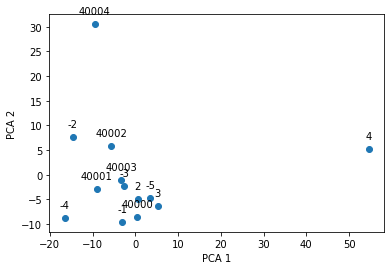

In [106]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}

for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()


In [110]:
# for pixel 0

In [238]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,40001]
N=train_data.shape[0]
test_data=X_test.iloc[:,40001]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
target_pdf=TRG_pdf
proposal_step=1
n_samples=50
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)
alpha=[1,1,1,1]
mu=[1,1,1,1]
#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[0]
M=4
for val in val_list:
    MSE_train=[]
    print('val',val)
    train_data=X_train.iloc[:,val]
    N=train_data.shape[0]
    test_data=X_test.iloc[:,val]
    N_test=test_data.shape[0]
    alpha=alpha0[:4]
    mu=mu0[:4]
    pi=np.zeros((N,M))
    for it in range(20):
        if it%5==0:
            print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[it]=accepted_s_num
            #Step2:
        print('mu before step2',mu)
        print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        print('mu after opt',mu)
            #Step3:
        sample_check={}
        current_state = alpha#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            if (_ % 10==0):
                print('sample num',_)
                    # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                        #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
        MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
        for time in range(10000):
                #print('time',time)
            MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        print(np.round(np.mean(MSE_trend_check),4))
        MSE_train.append(np.mean(MSE_trend_check))
        #if (it>1) and (MSE_train[-2]-MSE_train[-1])<0.01*MSE_train[-2]:
            #print('MSE_train:',MSE_train,'diff',MSE_train[-2]-MSE_train[-1],'criteria:',0.01*MSE_train[-2])
            #break
    print('Alpha',alpha)
    print('mu',mu)
    print('training is finished:)')    
    MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
    for time in range(10000):
        if time%1000==0:
            print('time in test:',time)
        MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
    print('MSE_test:',np.round(np.mean(MSE_test),6))
    M_trend_check_te.append(np.mean(MSE_test))
    print('alpha',alpha)
    print('mu',mu)
    print('MSE_train',MSE_train)
    print('M_trend_check_te',M_trend_check_te)
    alpha_dict[val]=alpha
    mu_dict[val]=mu

val 0
iteration: 0
mu before step2 [ 7.17191581  7.77810016 -7.97962588 -7.57560424]
alpha before step2 [23.688609438558146, 3.09109403244373, 78.87938399645599, 34.615435670056335]
mu after opt [ 7.17194254  7.77811927 -7.97960884 -7.57559713]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/946815412.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -64712.28778707989 for (33.95783754056296, 21.612580072946567, 77.93911338030264, 33.98340672920082)
9.2564
mu before step2 [ 7.17194254  7.77811927 -7.97960884 -7.57559713]
alpha before step2 [33.95783754 21.61258007 77.93911338 33.98340673]
mu after opt [ 7.1718843   7.77802584 -7.97962491 -7.57555875]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/946815412.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -14971.501052842887 for (38.965897113886555, 33.61886159589618, 75.62313550414672, 17.54244069700249)
2.2497
mu before step2 [ 7.1718843   7.77802584 -7.97962491 -7.57555875]
alpha before step2 [38.96589711 33.6188616  75.6231355  17.5424407 ]
mu after opt [ 7.17189184  7.77804395 -7.9796064  -7.5755486 ]
sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/946815412.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -1700.212758487962 for (48.87997228342828, 39.58633143993676, 70.83516901861309, 7.79045035480469)
0.3594
mu before step2 [ 7.17189184  7.77804395 -7.9796064  -7.5755486 ]
alpha before step2 [48.87997228 39.58633144 70.83516902  7.79045035]
mu after opt [ 7.171894    7.7780536  -7.97960427 -7.575527  ]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -1378.3613797090336 for (52.738299135809896, 46.80980377616595, 77.43944512463591, 12.488585597007003)
0.3206
mu before step2 [ 7.171894    7.7780536  -7.97960427 -7.575527  ]
alpha before step2 [52.73829914 46.80980378 77.43944512 12.4885856 ]
mu after opt [ 7.171894    7.7780536  -7.97960427 -7.575527  ]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -1350.6703334518468 for (54.018244103427335, 49.54916007744759, 78.76206876804645, 12.598421979719943)
0.3133
iteration: 5
mu before step2 [ 7.171

In [490]:
print(alpha)
print(mu)


[9.21459877e+01 2.64272603e-02 9.20888252e+01 7.50002128e+01
 1.00317827e+02 1.00625384e+02 2.80371292e+01 5.29633151e+01]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [130]:
mu

array([ 7.17190376,  7.7780852 , -7.97960676, -7.5756027 ,  9.79816634])

In [117]:
mu_dict

{0: array([ 7.1718765 ,  7.77807193, -7.97965798, -7.5756214 ])}

In [127]:
alpha_dict1={0:[60.60613928,47.49386969,63.97965243,34.02330945,0,0],1: [0,2.54233911e+01, 8.12121964e-02, 8.16905813e+01, 3.42029842e+01,
        7.15586186e+01],2: [2.61491493e+01, 1.48464771e-02, 7.81314809e+01, 3.37760062e+01,
        6.41747638e+01, 6.29295497e+01],
 3:[1.78120102e+01, 1.08908235e-02, 7.98143323e+01, 3.37625112e+01,
        6.65300333e+01, 6.00005152e+01],
 4: [1.82572748e+00, 1.04303710e-02, 3.88390543e+01, 1.16719973e+01,
        3.50757400e+01, 1.02355828e+02],
 40000: [2.70373444e+01, 1.30245552e-02, 7.44955134e+01, 2.52992351e+01,
        6.54414219e+01, 6.65795749e+01],
 40001: [3.16462199e+01, 1.17609063e-02, 6.99732093e+01, 3.83232555e+01,
        6.93272779e+01, 6.07082281e+01],
 40002: [26.00451127, 74.37198442, 53.15923301, 46.12123105,  6.17486365,68.59504833],
 40003: [32.22897456,  4.82714952, 74.93010391, 28.73966878, 68.32766342,
        60.81500606],
 40004: [38.92574913, 62.68528227, 76.64279151, 50.94888689, 31.75886293,
        42.57102336],
 -5: [2.05433571e+01, 1.10757308e-02, 7.74390623e+01, 3.47171158e+01,
        6.52179239e+01, 5.94577440e+01],
 -4: [3.82869659e+01, 1.82900879e-02, 8.29543643e+01, 3.76317911e+01,
        6.91314047e+01, 8.57457968e+01],
 -3: [2.97095893e+01, 1.25120484e-02, 7.36036731e+01, 3.65557826e+01,
        6.20638848e+01, 6.19248934e+01],
 -2: [35.38043207, 11.42067353, 77.82664344, 44.60394648, 75.22967496,
        58.33311631],
 -1: [34.42807789,  4.86722851, 79.51416431, 16.74028485, 68.7745158 ,
        75.02766649]}

In [128]:
alpha_dict1##### keeep

{0: [60.60613928, 47.49386969, 63.97965243, 34.02330945, 0, 0],
 1: [0, 25.4233911, 0.0812121964, 81.6905813, 34.2029842, 71.5586186],
 2: [26.1491493, 0.0148464771, 78.1314809, 33.7760062, 64.1747638, 62.9295497],
 3: [17.8120102, 0.0108908235, 79.8143323, 33.7625112, 66.5300333, 60.0005152],
 4: [1.82572748, 0.010430371, 38.8390543, 11.6719973, 35.07574, 102.355828],
 40000: [27.0373444,
  0.0130245552,
  74.4955134,
  25.2992351,
  65.4414219,
  66.5795749],
 40001: [31.6462199,
  0.0117609063,
  69.9732093,
  38.3232555,
  69.3272779,
  60.7082281],
 40002: [26.00451127,
  74.37198442,
  53.15923301,
  46.12123105,
  6.17486365,
  68.59504833],
 40003: [32.22897456,
  4.82714952,
  74.93010391,
  28.73966878,
  68.32766342,
  60.81500606],
 40004: [38.92574913,
  62.68528227,
  76.64279151,
  50.94888689,
  31.75886293,
  42.57102336],
 -5: [20.5433571, 0.0110757308, 77.4390623, 34.7171158, 65.2179239, 59.457744],
 -4: [38.2869659,
  0.0182900879,
  82.9543643,
  37.6317911,
  69.1

In [139]:
mu_dict={:([ 7.17185624,  7.77798793, -7.97970851, -7.57567744,  9.79811476,
       -0.90898713])}
mu_dict[0]=sorted(mu_dict[0])
mu_dict[0]

[-7.97970851, -7.57567744, -0.90898713, 7.17185624, 7.77798793, 9.79811476]

In [140]:


# Convert the dictionary to a DataFrame
df_mu = pd.DataFrame.from_dict(mu_dict, orient='index')
df_mu

0         1         2         3         4         5
0 -7.979709 -7.575677 -0.908987  7.171856  7.777988  9.798115

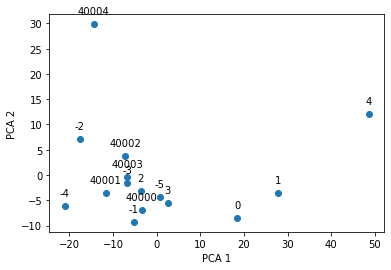

In [131]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}

for val in alpha_dict1:
    new_alpha_dict[val]=sorted(alpha_dict1[val])

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
#plt.show()
#plt.savefig('result_15pix.jpg')

['pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9', 'pixel_10']


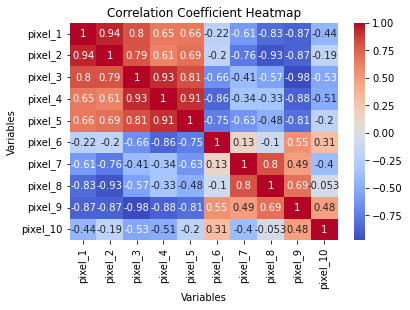

In [197]:
columns = [f'pixel_{i}' for i in range(1, 11)]
print(columns)
# Create a heatmap using seaborn
sns.heatmap(np.corrcoef(np.corrcoef(df_flatten.T[10:20])), annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")

# Add labels and title
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()


Text(0.5, 1.0, 'Correlation Coefficient Heatmap')

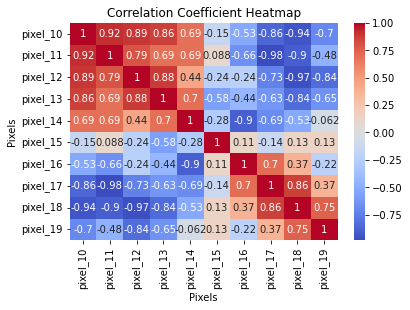

In [213]:
columns = [f'pixel_{i}' for i in range(10, 20)]
#print(columns)
# Create a heatmap using seaborn
sns.heatmap(np.corrcoef(np.corrcoef(df_flatten_GMM_clus1.T[10:20])), annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")

# Add labels and title
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.title("Correlation Coefficient Heatmap")

# Show the plot
#plt.show()
#plt.savefig('Correlation.jpg')

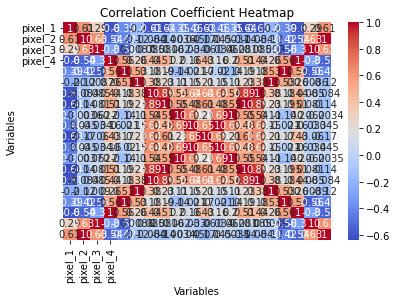

In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
data = np.random.rand(50, 4)
columns = ['pixel_1', 'pixel_2', 'pixel_3', 'pixel_4']
dff = pd.DataFrame(data, columns=columns)

# Compute the correlation matrix
corr_matrix = np.corrcoef(dff.T)

# Create a heatmap using seaborn
sns.heatmap(np.corrcoef(df_flatten_GMM_clus1.T[50:70]), annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")

# Add labels and title
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()


code to check for one pixel

In [255]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(100):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(100):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]

alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
target_pdf=TRG_pdf
proposal_step=1
n_samples=50
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[0]
M=4

MSE_train=[]
train_data=X_train.iloc[:,val]
N=train_data.shape[0]
test_data=X_test.iloc[:,val]
N_test=test_data.shape[0]

alpha=[1,1,1,1]
mu=[1,1,1,1]

pi=np.zeros((N,M))
for it in range(20):
    if it%5==0:
        print('iteration:',it)
    accepted_s_num=0
    accepted_s_num_dict[it]=accepted_s_num
            #Step2:
    print('mu before step2',mu)
    print('alpha before step2',alpha)
    result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
    for m in range(M):
        mu[m]=result.x[m]
    print('mu after opt',mu)
            #Step3:
    sample_check={}
    current_state = alpha#x_t-1=init_state , x_t=current_state
    samples = [current_state]
    current_pdf=target_pdf(pi,current_state)
    while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
        current_state = generate_m_positive_random_numbers(M)
        current_pdf=target_pdf(pi,current_state)
    sample_check[tuple(current_state)]=current_pdf#f(x_t)
    all_samples[tuple(current_state)]=current_pdf        
    for _ in range(n_samples):
        if (_ % 10==0):
            print('sample num',_)
                    # Generate a proposal sample
        proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
        while any(elem <= 0 for elem in proposal):
            proposal = np.random.normal(loc=current_state, scale=proposal_step)    
        proposal_pdf=target_pdf(pi,proposal)
        while math.isinf(proposal_pdf) :
            proposal = np.random.normal(loc=current_state, scale=proposal_step)
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
            proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
        acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
                        #print('accepted')
            accepted_s_num+=1
            current_state = proposal#x_t=y_t
            current_pdf=proposal_pdf
            sample_check[tuple(current_state)]=current_pdf
            all_samples[tuple(current_state)]=current_pdf
        samples.append(current_state)
    accepted_s_num_dict[it]=accepted_s_num
    Highest_pdf_alpha = max(sample_check, key=sample_check.get)
    print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
    best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
    alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
    MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
    for time in range(10000):
                #print('time',time)
        MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
    print(np.round(np.mean(MSE_trend_check),4))
    MSE_train.append(np.mean(MSE_trend_check))
        #if (it>1) and (MSE_train[-2]-MSE_train[-1])<0.01*MSE_train[-2]:
            #print('MSE_train:',MSE_train,'diff',MSE_train[-2]-MSE_train[-1],'criteria:',0.01*MSE_train[-2])
            #break
print('Alpha',alpha)
print('mu',mu)
print('training is finished:)')    
MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
for time in range(10000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))
print('MSE_test:',np.round(np.mean(MSE_test),6))
M_trend_check_te.append(np.mean(MSE_test))
print('alpha',alpha)
print('mu',mu)
print('MSE_train',MSE_train)
print('M_trend_check_te',M_trend_check_te)
alpha_dict[val]=alpha
mu_dict[val]=mu

iteration: 0
mu before step2 [1, 1, 1, 1]
alpha before step2 [1, 1, 1, 1]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 30
sample num 40
highest pdf was -743.3459657145797 for (2.084883317826846, 1.2169353195994845, 4.69864180593068, 0.030242894386126595)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [2.08488332 1.21693532 4.69864181 0.03024289]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 20
sample num 30
sample num 40
highest pdf was 3402.549274939251 for (1.0667040364053173, 0.9765632836743452, 6.009674523701037, 0.014670263950683129)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.06670404 0.97656328 6.00967452 0.01467026]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3328.6449519951625 for (1.0667040364053173, 0.9765632836743452, 6.009674523701037, 0.014670263950683129)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.06670404 0.97656328 6.00967452 0.01467026]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3424.5959174250816 for (1.0667040364053173, 0.9765632836743452, 6.009674523701037, 0.014670263950683129)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.06670404 0.97656328 6.00967452 0.01467026]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20
sample num 30


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 40
highest pdf was 6116.993864386559 for (1.292377414505506, 0.17759613048544864, 6.104774120616261, 0.011368137135209896)
0.6539
iteration: 5
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [1.29237741 0.17759613 6.10477412 0.01136814]
mu after opt [1.0, 1.0, 1.0, 1.0]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -3816.6878455076826 for (84.58181460165245, 30.280111154489358, 78.24766204088215, 72.250011435984)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [84.5818146  30.28011115 78.24766204 72.25001144]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -3797.3324254404743 for (86.34133477174632, 20.681353279225807, 84.97223459435794, 76.9672718654657)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [86.34133477 20.68135328 84.97223459 76.96727187]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was -3740.2901389287545 for (90.73365194230617, 6.774563575575406, 86.53977067927336, 78.28109404337373)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [90.73365194  6.77456358 86.53977068 78.28109404]
mu after opt [1.0, 1.0, 1.0, 1.0]
sa

C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 40
highest pdf was 3799.9460018124396 for (87.61278076474673, 0.015437972175457476, 89.6823715101315, 83.16553186585595)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [8.76127808e+01 1.54379722e-02 8.96823715e+01 8.31655319e+01]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3679.705681577209 for (87.61278076474673, 0.015437972175457476, 89.6823715101315, 83.16553186585595)
0.6539
iteration: 10
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [8.76127808e+01 1.54379722e-02 8.96823715e+01 8.31655319e+01]
mu after opt [1.0, 1.0, 1.0, 1.0]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3701.914236963167 for (87.61278076474673, 0.015437972175457476, 89.6823715101315, 83.16553186585595)
0.6539
mu before step2 [1.0, 1.0, 1.0, 1.0]
alpha before step2 [8.76127808e+01 1.54379722e-02 8.96823715e+01 8.31655319e+01]
mu after opt [0.9991287615446061, 0.999

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 20
sample num 30
sample num 40
highest pdf was 3688.7587120500853 for (87.61278076474673, 0.015437972175457476, 89.6823715101315, 83.16553186585595)
0.6526
mu before step2 [0.9991287615446061, 0.9999998310364945, 0.9991069476342381, 0.9991727613256546]
alpha before step2 [8.76127808e+01 1.54379722e-02 8.96823715e+01 8.31655319e+01]
mu after opt [0.9991287615446061, 0.9999998310364945, 0.9991069476342381, 0.9991727613256546]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3557.1535721767773 for (87.61278076474673, 0.015437972175457476, 89.6823715101315, 83.16553186585595)
0.6526
mu before step2 [0.9991287615446061, 0.9999998310364945, 0.9991069476342381, 0.9991727613256546]
alpha before step2 [8.76127808e+01 1.54379722e-02 8.96823715e+01 8.31655319e+01]
mu after opt [0.9991287652817101, 0.9999998489149141, 0.9991069762032, 0.9991727694012488]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 3600.85369983

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 10
sample num 20
sample num 30
sample num 40


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6423.966215598855 for (89.04559234416189, 0.011374216128842894, 89.18943742015534, 82.80418242632271)
0.6526
mu before step2 [0.9991287740379695, 0.9999998637001881, 0.9991069990413471, 0.9991727766033145]
alpha before step2 [8.90455923e+01 1.13742161e-02 8.91894374e+01 8.28041824e+01]
mu after opt [0.9991287740379695, 0.9999998637001881, 0.9991069990413471, 0.9991727766033145]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 7091.437761758075 for (15.837641447392173, 18.07277640191158, 14.057201242546913, 0.010328263046124636)
0.6531
mu before step2 [0.9991287740379695, 0.9999998637001881, 0.9991069990413471, 0.9991727766033145]
alpha before step2 [1.58376414e+01 1.80727764e+01 1.40572012e+01 1.03282630e-02]
mu after opt [0.9991287740379695, 0.9999998637001881, 0.9991069990413471, 0.9991727766033145]


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 0
sample num 10
sample num 20
sample num 30


C:\Users\omidl\AppData\Local\Temp/ipykernel_14384/1932485325.py:154: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


sample num 40
highest pdf was 2149.4330115127545 for (50.81577209964164, 95.64259992345018, 0.01934914394784086, 53.855440258017246)
0.6532
mu before step2 [0.9991287740379695, 0.9999998637001881, 0.9991069990413471, 0.9991727766033145]
alpha before step2 [5.08157721e+01 9.56425999e+01 1.93491439e-02 5.38554403e+01]
mu after opt [0.9991285116706979, 0.9999995478459409, 0.9991064610649649, 0.9991741000227171]
sample num 0
sample num 10
sample num 20
sample num 30


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


sample num 40
highest pdf was 2003.4133885611047 for (50.81577209964164, 95.64259992345018, 0.01934914394784086, 53.855440258017246)
0.6532
mu before step2 [0.9991285116706979, 0.9999995478459409, 0.9991064610649649, 0.9991741000227171]
alpha before step2 [5.08157721e+01 9.56425999e+01 1.93491439e-02 5.38554403e+01]
mu after opt [0.9991285116706979, 0.9999995478459409, 0.9991064610649649, 0.9991741000227171]
sample num 0
sample num 10
sample num 20
sample num 30
sample num 40
highest pdf was 2128.3001262529556 for (50.81577209964164, 95.64259992345018, 0.01934914394784086, 53.855440258017246)
0.6532
Alpha [5.08157721e+01 9.56425999e+01 1.93491439e-02 5.38554403e+01]
mu [0.9991285116706979, 0.9999995478459409, 0.9991064610649649, 0.9991741000227171]
training is finished:)
time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
MSE_test: 0.620529
alpha [5.081

0.6539319368730447
0.6212036010584266


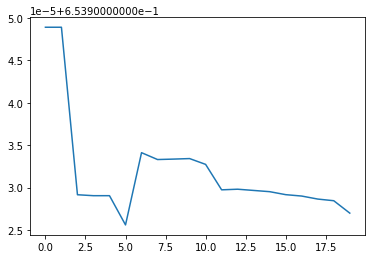

In [253]:
plt.plot(MSE_train)
print(np.mean(MSE_train))
print(np.mean(MSE_test))

{0: 7,
 1: 1,
 2: 0,
 3: 1,
 4: 0,
 5: 0,
 6: 25,
 7: 17,
 8: 16,
 9: 21,
 10: 16,
 11: 18,
 12: 12,
 13: 22,
 14: 15,
 15: 20,
 16: 21,
 17: 9,
 18: 22,
 19: 23}

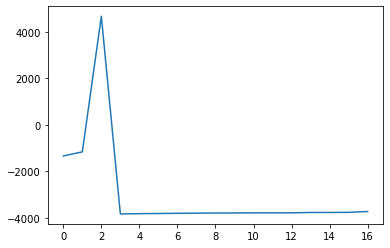

In [254]:
plt.plot(best_samples.values())
accepted_s_num_dict

In [184]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(100):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(100):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=100
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[0]
#M=4

MSE_train=[]
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))


MSE_train_all=[]
pi=np.zeros((N,M))
for it in range(3000):
    if it%5==0:
        print('iteration:',it)
    accepted_s_num=0
    accepted_s_num_dict[it]=accepted_s_num
            #Step2:
    #print('mu before step2',mu)
    #print('alpha before step2',alpha)
    result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
    for m in range(M):
        mu[m]=result.x[m]
    #print('mu after opt',mu)
            #Step3:
    sample_check={}
    current_state = alpha#x_t-1=init_state , x_t=current_state
    samples = [current_state]
    current_pdf=target_pdf(pi,current_state)
    while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
        current_state = generate_m_positive_random_numbers(M)
        current_pdf=target_pdf(pi,current_state)
    sample_check[tuple(current_state)]=current_pdf#f(x_t)
    all_samples[tuple(current_state)]=current_pdf        
    for _ in range(n_samples):
        if (_ % 10==0):
            #print('sample num',_)
            pass
                    # Generate a proposal sample
        proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
        while any(elem <= 0 for elem in proposal):
            proposal = np.random.normal(loc=current_state, scale=proposal_step)    
        proposal_pdf=target_pdf(pi,proposal)
        while math.isinf(proposal_pdf) :
            proposal = np.random.normal(loc=current_state, scale=proposal_step)
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
            proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
        acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
                        #print('accepted')
            accepted_s_num+=1
            current_state = proposal#x_t=y_t
            current_pdf=proposal_pdf
            sample_check[tuple(current_state)]=current_pdf
            all_samples[tuple(current_state)]=current_pdf
        samples.append(current_state)
    accepted_s_num_dict[it]=accepted_s_num
    Highest_pdf_alpha = max(sample_check, key=sample_check.get)
    print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
    best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
    alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
    MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
    '''
    for time in range(10000):
                #print('time',time)
        MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
    print(np.round(np.mean(MSE_trend_check),4))
    MSE_train.append(np.mean(MSE_trend_check))
    '''
    
    if it%10<5:
        MSE_temp=[]
        for time in range(1000):
                  #if time%1000==0:
                      #print('time in test:',time)
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        MSE_train_all.append(np.mean(MSE_temp))
    if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
        print('converge!!!')
        break
print('Alpha',alpha)
print('mu',mu)
print('training is finished:)')    
MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
print('MSE_train:',np.mean(MSE_train))
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
print('MSE_test:',np.round(np.mean(MSE_test),6))


iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -352699.5191265605 for (98.55881534934906, 16.007245877020402)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -339830.03084800876 for (98.40121426866799, 0.02532603295500767)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -337392.3546398207 for (97.77225431761809, 0.016518453525446255)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -16321.89882360039 for (97.97356958433473, 0.016660821070018716)
highest pdf was -16305.055404287825 for (97.97356958433473, 0.016660821070018716)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -16469.95480810701 for (97.97356958433473, 0.016660821070018716)
highest pdf was -16184.701389680638 for (98.81511253405758, 0.016423312665992187)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12409.868886527363 for (97.31933366852238, 0.010710574461793493)
highest pdf was -12441.637177827406 for (97.31933366852238, 0.010710574461793493)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -94894.32212872987 for (47.72172919402653, 59.31349660581438)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -47815.387141738356 for (75.15549665822373, 23.017801953514187)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -23045.50599217794 for (78.64568611457959, 0.25206913951407356)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -19405.8388814734 for (76.41486657697564, 0.029017779074754297)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -13680.454154160898 for (73.2540385452176, 0.012124797470177973)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12961.70757331332 for (24.362282374177504, 0.013467518590498911)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12988.534992813407 for (24.362282374177504, 0.013467518590498911)
highest pdf was -12916.89652556184 for (24.362282374177504, 0.013467518590498911)
highest pdf was -12932.541449473374 for (24.362282374177504, 0.013467518590498911)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12905.466437032523 for (24.362282374177504, 0.013467518590498911)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12985.627300366494 for (24.362282374177504, 0.013467518590498911)
iteration: 20


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12985.493451647882 for (24.362282374177504, 0.013467518590498911)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -21189.552467669986 for (79.71466948098251, 0.28639757832197293)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14193.599459859628 for (76.58320273371174, 0.016195529322868482)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -14188.061642631776 for (76.58320273371174, 0.016195529322868482)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3611.8429818607547 for (76.85732370750469, 0.012060346693815711)
iteration: 25


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3664.7674003252177 for (76.85732370750469, 0.012060346693815711)
highest pdf was 3778.1807134270157 for (76.85732370750469, 0.012060346693815711)
highest pdf was 3656.395558619355 for (76.85732370750469, 0.012060346693815711)
highest pdf was 3802.1849126187353 for (77.95753210953737, 0.011779443286702598)
highest pdf was 3796.048310954304 for (77.95753210953737, 0.011779443286702598)
iteration: 30


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3955.839496674481 for (77.95753210953737, 0.011779443286702598)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -43531.4445156541 for (84.0604101707296, 28.487026302907584)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 128.64149381940445 for (90.63432806855555, 0.018879877881943716)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 241.6846386202975 for (90.63432806855555, 0.018879877881943716)
highest pdf was 111.11221758702743 for (90.63432806855555, 0.018879877881943716)
iteration: 35


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 196.58698916340984 for (90.63432806855555, 0.018879877881943716)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3309.3476622553762 for (90.63432806855555, 0.018879877881943716)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8664.895866525481 for (91.31412801292615, 0.011837238981815022)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 568.6867872454067 for (29.842049779990226, 0.10594828461226469)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2692.9748193897212 for (32.13814706562986, 0.03671545513823524)
iteration: 40


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 10297.680370154894 for (31.506472612670628, 0.010961768119612993)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3581.571889307899 for (19.076643824802154, 0.027761079405020945)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5918.64187005678 for (19.23521623796451, 0.017894523720218332)
highest pdf was 6572.860597330501 for (19.073279641826584, 0.016329004719261294)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9737.036114997145 for (18.746506168809493, 0.011411717380642911)
iteration: 45


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -91860.74711158099 for (74.83227068312648, 74.33444907646471)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -33164.54441045636 for (91.88957795871987, 36.37920275602947)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -989.3781240010715 for (100.86178699861503, 2.5610917723399753)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3716.8865493569665 for (100.56081146171054, 0.028304577597746627)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 11527.049155285195 for (102.2134949826322, 0.009825224701480161)
iteration: 50


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2477035238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -79571.02086382409 for (40.791714418697765, 34.80017434631975)
converge!!!
Alpha [40.79171442 34.80017435]
mu [0.43992078 7.16502517]
training is finished:)
time in test: 0
MSE_train: 11.303019401694623
time in test: 0
MSE_test: 11.191306


After Finding iterations i wanted limit iteration numbers so below cell is a test by removing convergence criterion so we can remove ot

In [503]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(20):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(20):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=20
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[0]
#M=4

MSE_train=[]
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))


MSE_train_all=[]
pi=np.zeros((N,M))
for it in range(20):
    if it%5==0:
        print('iteration:',it)
    accepted_s_num=0
    accepted_s_num_dict[it]=accepted_s_num
            #Step2:
    #print('mu before step2',mu)
    #print('alpha before step2',alpha)
    result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
    for m in range(M):
        mu[m]=result.x[m]
    #print('mu after opt',mu)
            #Step3:
    sample_check={}
    current_state = alpha#x_t-1=init_state , x_t=current_state
    samples = [current_state]
    current_pdf=target_pdf(pi,current_state)
    while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
        current_state = generate_m_positive_random_numbers(M)
        current_pdf=target_pdf(pi,current_state)
    sample_check[tuple(current_state)]=current_pdf#f(x_t)
    all_samples[tuple(current_state)]=current_pdf        
    for _ in range(n_samples):
        if (_ % 10==0):
            #print('sample num',_)
            pass
                    # Generate a proposal sample
        proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                    #print('proposal',proposal)    
                    # Ensure the proposal is within bounds (i.e.is non-negative)        
        while any(elem <= 0 for elem in proposal):
            proposal = np.random.normal(loc=current_state, scale=proposal_step)    
        proposal_pdf=target_pdf(pi,proposal)
        while math.isinf(proposal_pdf) :
            proposal = np.random.normal(loc=current_state, scale=proposal_step)
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
            proposal_pdf=target_pdf(pi,proposal)
                    # Calculate the acceptance ratio
        acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                    # Decide to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
                        #print('accepted')
            accepted_s_num+=1
            current_state = proposal#x_t=y_t
            current_pdf=proposal_pdf
            sample_check[tuple(current_state)]=current_pdf
            all_samples[tuple(current_state)]=current_pdf
        samples.append(current_state)
    accepted_s_num_dict[it]=accepted_s_num
    Highest_pdf_alpha = max(sample_check, key=sample_check.get)
    print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
    best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
            #return np.array(Highest_pdf_alpha)
    alpha=np.array(Highest_pdf_alpha)
            #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
    MSE_trend_check=[]
                #print('alpha_tr',alpha,'mu_tr',mu)
    '''
    for time in range(10000):
                #print('time',time)
        MSE_trend_check.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
    print(np.round(np.mean(MSE_trend_check),4))
    MSE_train.append(np.mean(MSE_trend_check))
    '''
    
    if it%10<5:
        MSE_temp=[]
        for time in range(1000):
                  #if time%1000==0:
                      #print('time in test:',time)
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        MSE_train_all.append(np.mean(MSE_temp))
    #if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
    #    print('converge!!!')
    #    break
print('Alpha',alpha)
print('mu',mu)
print('training is finished:)')    
MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
print('MSE_train:',np.mean(MSE_train))
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
print('MSE_test:',np.round(np.mean(MSE_test),6))


iteration: 0
highest pdf was -366593.1216920262 for (92.20791524314765, 53.471253208533405)
highest pdf was -364874.62870599184 for (95.49791953549109, 48.89650279215576)
highest pdf was -361772.84715152276 for (98.13176842284383, 39.661905010048194)
highest pdf was -357749.7981173963 for (108.521699651877, 31.1520546478923)
highest pdf was -354746.4536590713 for (108.40393292832614, 22.964500898847536)
iteration: 5
highest pdf was -351139.9720572011 for (108.45590530288595, 14.08087630354209)
highest pdf was -350089.3305822033 for (107.12080141104389, 11.579970802094133)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/887823238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -346304.3890852224 for (109.82398320100978, 4.059157947503777)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/887823238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -341573.80185272853 for (111.21373514635908, 0.04347961991687331)
highest pdf was -341735.76816306595 for (111.21373514635908, 0.04347961991687331)
iteration: 10
highest pdf was -341583.41362040886 for (111.21373514635908, 0.04347961991687331)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/887823238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -340858.8825364303 for (112.5672503816342, 0.03280287378301665)
highest pdf was -253250.3806695874 for (112.5672503816342, 0.03280287378301665)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/887823238.py:159: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -246897.64995098862 for (113.46336813459273, 0.011888074978872749)
highest pdf was -246671.80277747827 for (113.46336813459273, 0.011888074978872749)
iteration: 15
highest pdf was -179247.40807382157 for (113.46336813459273, 0.011888074978872749)
highest pdf was -179288.1386373041 for (113.46336813459273, 0.011888074978872749)
highest pdf was -179192.10837921148 for (113.46336813459273, 0.011888074978872749)
highest pdf was -179443.02342820025 for (113.46336813459273, 0.011888074978872749)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -179384.29554807759 for (113.46336813459273, 0.011888074978872749)
Alpha [1.13463368e+02 1.18880750e-02]
mu [5.3658963  7.57297388]
training is finished:)
time in test: 0
MSE_train: 26.727198519076623
time in test: 0
MSE_test: 26.53726


In [187]:
MSE_test=[]
            #print('alpha_t',alpha,'mu_t',mu)
for time in range(100000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
print('MSE_train:',np.mean(MSE_train))
for time in range(100000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
print('MSE_test:',np.mean(MSE_test))

time in test: 0
time in test: 1000
time in test: 2000
time in test: 3000
time in test: 4000
time in test: 5000
time in test: 6000
time in test: 7000
time in test: 8000
time in test: 9000
time in test: 10000
time in test: 11000
time in test: 12000
time in test: 13000
time in test: 14000
time in test: 15000
time in test: 16000
time in test: 17000
time in test: 18000
time in test: 19000
time in test: 20000
time in test: 21000
time in test: 22000
time in test: 23000
time in test: 24000
time in test: 25000
time in test: 26000
time in test: 27000
time in test: 28000
time in test: 29000
time in test: 30000
time in test: 31000
time in test: 32000
time in test: 33000
time in test: 34000
time in test: 35000
time in test: 36000
time in test: 37000
time in test: 38000
time in test: 39000
time in test: 40000
time in test: 41000
time in test: 42000
time in test: 43000
time in test: 44000
time in test: 45000
time in test: 46000
time in test: 47000
time in test: 48000
time in test: 49000
time in test:

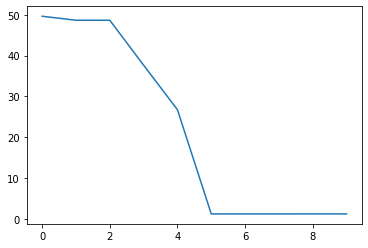

In [487]:
plt.plot(MSE_train_all)

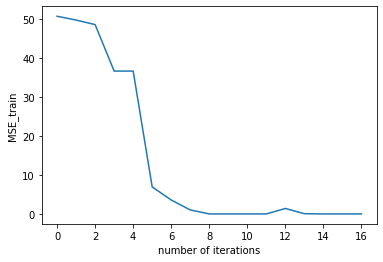

In [178]:
plt.plot(MSE_train_all)

plt.xlabel("number of iterations")
plt.ylabel("MSE_train")
plt.show()

In [180]:
plt.plot(MSE_t)

array([8.86910249e+01, 1.60802667e-02])

In [91]:
MSE_train_all

[51.57336318127302,
 50.9881320841009,
 50.325667965827606,
 49.76259011876013,
 48.91325844153578,
 5.061393067301624,
 5.060274866764877,
 5.060471572201923,
 5.060356183077159,
 5.060256890244714,
 5.056257401856705,
 89.29802261550844,
 79.60544582899034]

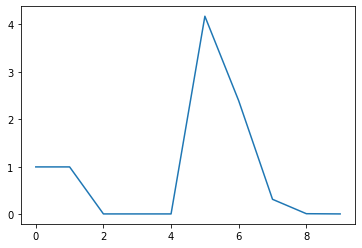

In [98]:
plt.plot(MSE_train_all[20:])

In [95]:
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_train.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
print('MSE_train:',np.mean(MSE_train))
for time in range(1000):
    if time%1000==0:
        print('time in test:',time)
    MSE_test.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
print('MSE_test:',np.round(np.mean(MSE_test),6))


time in test: 0
MSE_train: 0.009591079480459015
time in test: 0
MSE_test: 0.00608


In [99]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(50):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(50):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=50
init_state=alpha 
pi=pi

alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
val_list=[0]
#M=4


train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
MSE_train_all=[]
pi=np.zeros((N,M))
MSE_train_trend_M={}
MSE_test_trend_M={}
for M in range (2,10):
    print('M',M)
    alpha=generate_m_positive_random_numbers(M)
    mu=np.zeros(M)
    values=np.linspace(-10,10,100)
    mu=np.array(random.sample(list(values), M))
    pi=np.zeros((N,M))
    MSE_train_all=[]
    pi=np.zeros((N,M))
    for it in range(3000):
        if it%5==0:
            print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[it]=accepted_s_num
                #Step2:
        #print('mu before step2',mu)
        #print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        #print('mu after opt',mu)
                #Step3:
        sample_check={}
        current_state = alpha#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            if (_ % 10==0):
                #print('sample num',_)
                pass
                        # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                        #print('proposal',proposal)    
                        # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                        # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                        # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                            #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
                #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
                #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
                    #print('alpha_tr',alpha,'mu_tr',mu)

        if it%10<5:
            MSE_temp=[]
            for time in range(1000):
                      #if time%1000==0:
                          #print('time in test:',time)
                MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
            MSE_train_all.append(np.mean(MSE_temp))
        if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
            print('converge!!!')
            break
    MSE_temp=[]        
    for time in range(1000):
        MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
    MSE_train_trend_M[M]=np.mean(MSE_temp) 
    MSE_temp=[] 
    for time in range(1000):
        MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
    MSE_test_trend_M[M]=np.mean(MSE_temp)


M 2
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -469871.19374136877 for (30.41016814296701, 73.94193140297554)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -397950.27481102705 for (48.211386772419075, 70.33461343456021)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -331101.3260149099 for (63.80545616823747, 58.21895474548164)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -262878.1559791706 for (67.7471048619645, 35.700762612582)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -204140.5332448672 for (73.26471909923494, 20.287217021771458)
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -121578.92612551275 for (70.53680943377213, 0.22428412352546437)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -114070.34441482273 for (71.04049210217332, 0.016312345869872565)
highest pdf was -114090.55104403954 for (71.04049210217332, 0.016312345869872565)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -110972.72035257505 for (71.06900997698396, 0.011308140763404924)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -509245.9372145322 for (23.309434800903247, 77.0618384643411)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -425556.34824706876 for (42.41680392027863, 75.02304133786778)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -351902.3467403588 for (65.37909586834361, 69.64937677472155)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -292286.6135911033 for (78.74396542325161, 53.29855062205527)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -237914.9796254819 for (90.55236831128033, 37.622846235756604)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -192087.0279944019 for (97.89517017614168, 22.89845580081527)
iteration: 15


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -137264.19367737346 for (99.27730426850455, 4.960839478116613)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -118266.13582538473 for (94.45701690574214, 0.039961710448243384)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -115978.81411658906 for (94.29957554939547, 0.022309484833524986)
highest pdf was -115842.80757040903 for (94.29957554939547, 0.022309484833524986)
highest pdf was -115964.14790231397 for (94.29957554939547, 0.022309484833524986)
iteration: 20


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -112897.48660868932 for (93.7605539793358, 0.014215113187532687)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -112743.68213396803 for (93.7605539793358, 0.014215113187532687)
highest pdf was -106581.26213627812 for (93.7605539793358, 0.014215113187532687)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -106756.74448870007 for (93.7605539793358, 0.014215113187532687)
highest pdf was -106437.38950853393 for (93.7605539793358, 0.014215113187532687)
iteration: 25
highest pdf was -106870.72277584928 for (93.7605539793358, 0.014215113187532687)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -72833.90368536525 for (93.7605539793358, 0.014215113187532687)
highest pdf was -72937.1628342965 for (93.7605539793358, 0.014215113187532687)
highest pdf was -72739.16267526362 for (93.7605539793358, 0.014215113187532687)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -72878.37705662487 for (93.7605539793358, 0.014215113187532687)
iteration: 30
highest pdf was -72604.29748759946 for (93.7605539793358, 0.014215113187532687)
highest pdf was -72694.76587321913 for (93.7605539793358, 0.014215113187532687)
highest pdf was -72671.81869093567 for (93.7605539793358, 0.014215113187532687)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -71606.4146349012 for (92.54589512163773, 0.012374581419245335)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -37542.688381860884 for (92.54589512163773, 0.012374581419245335)
iteration: 35
highest pdf was -37391.145301604854 for (92.54589512163773, 0.012374581419245335)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -37634.730847753504 for (92.54589512163773, 0.012374581419245335)
highest pdf was -37558.93185516889 for (92.54589512163773, 0.012374581419245335)
highest pdf was -37582.02340680436 for (92.54589512163773, 0.012374581419245335)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -239412.0364940004 for (55.91341051502431, 48.3039231799821)
iteration: 40


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -179837.08779734827 for (65.72356071232197, 35.7556039558757)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -92689.87993243533 for (69.32762388152004, 12.090507329515086)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -46113.58997164945 for (74.42467750834263, 0.09997470435256996)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -42273.412732403194 for (72.22193808956202, 0.02423788949144548)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -40315.646025225244 for (73.80084373349905, 0.017773319172965606)
converge!!!
M 3
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -97975.36840123801 for (56.105017870720815, 1.1519886190266946, 33.2329694665396)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -53695.66943629944 for (42.26498377979356, 0.5151117463828059, 36.96152097681304)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -24271.291935866182 for (36.78776133345715, 0.04389582263197833, 43.92743949531695)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6253.740608637702 for (27.980807625887337, 0.28967457297639176, 52.0333827990246)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4673.705259195899 for (19.958048688539254, 0.01803040083242171, 52.05757842740724)
iteration: 5
highest pdf was 4618.821811584434 for (19.958048688539254, 0.01803040083242171, 52.05757842740724)
highest pdf was 4509.793110950924 for (19.958048688539254, 0.01803040083242171, 52.05757842740724)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7507.870156924073 for (20.67939923315565, 0.012222778047267006, 51.863984455552746)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 7617.4225244005065 for (20.67939923315565, 0.012222778047267006, 51.863984455552746)
highest pdf was 7617.979797350345 for (20.67939923315565, 0.012222778047267006, 51.863984455552746)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 10238.116093422012 for (22.392783320797964, 0.009063017393379022, 52.042194522945856)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -365112.8369557222 for (48.11802823737516, 94.39607315982113, 27.694677333762566)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -251990.0611468647 for (47.783913229275356, 79.06091867759103, 44.37558284831484)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -149939.92688182773 for (49.826414514639794, 66.9295903676538, 68.33043245008176)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -97034.98243615296 for (44.04578610840579, 57.76706163257249, 81.97485417890725)
iteration: 15


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -47193.30420485811 for (39.502406492132536, 47.950015325423756, 103.09112677987727)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12702.803126951367 for (34.354152958674796, 29.050607496653924, 114.7283853215125)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -540.6685630769874 for (20.207923056268395, 18.95306738062353, 125.30437606128407)
highest pdf was -464.1504845531877 for (24.799234635729665, 17.320255554755377, 130.45851877161107)
highest pdf was -464.78050767534614 for (25.03031483552668, 16.610234899962602, 129.41213112937126)
iteration: 20
highest pdf was -447.57854584638 for (26.188892496999173, 16.344858712241365, 131.40160800056637)
converge!!!
M 4
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13066.97427827219 for (61.13903642484774, 40.550489629669855, 65.55339649441903, 13.769853939196285)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1976.3997650304025 for (69.00241081760403, 31.185338927762075, 62.27749625757137, 19.573701848006916)
highest pdf was -219.3224976437239 for (74.45678027634042, 23.197928881069753, 66.7705443055164, 21.433662686305652)
highest pdf was -191.59197239723582 for (72.59889037662931, 21.74101053616895, 70.56672268415831, 22.692739976339116)
highest pdf was -112.90193467173316 for (76.30231402118739, 18.70279342402345, 77.26245139104277, 17.134932223440064)
iteration: 5
highest pdf was -29.884575348283384 for (79.08798354313204, 20.76205148359886, 85.09726636553982, 23.855101668156546)
highest pdf was 30.85211480907589 for (78.46932603684505, 17.46412610288878, 91.82477187212376, 23.52759199896212)
highest pdf was 88.59208218388542 for (80.9740732011192, 15.746668054003683, 97.61149318461409, 20.78247397927708)
highest pdf was 139.6113883063909 for (77.45815517931021, 12.813545734665446, 102.61820696499323, 21.825765471381995)
highest pdf was 159.4365452015793 for (76.5766336

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9721.75248582059 for (73.99581025672589, 0.012298880485572, 121.26250070038093, 17.677781571887287)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3516.0722581150653 for (11.261374530921513, 5.765009605876668, 78.76094592438001, 40.42994653086426)
iteration: 15


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 910.7195498785567 for (14.406768381226156, 0.10590078516271421, 83.78874658174644, 45.75367432763217)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3760.000915804278 for (14.282271936193162, 0.02907954827966902, 84.16207257630656, 46.84833244387692)
highest pdf was 3782.3503408367287 for (14.282271936193162, 0.02907954827966902, 84.16207257630656, 46.84833244387692)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9510.965833637989 for (16.085036420194065, 0.011912457699579077, 82.16528721955265, 44.231814243131424)
highest pdf was 9613.851736680692 for (16.085036420194065, 0.011912457699579077, 82.16528721955265, 44.231814243131424)
iteration: 20
highest pdf was 9396.407715605015 for (16.085036420194065, 0.011912457699579077, 82.16528721955265, 44.231814243131424)
converge!!!
M 5
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8004.461524603309 for (61.488926498098515, 13.536619889193329, 95.92256246939584, 59.11844110570929, 105.5066695515405)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 141.30463316312083 for (44.26026364378191, 4.074032189915113, 80.00367279485978, 58.18784293151466, 117.03619742227251)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3235.4209447078206 for (44.14632333350758, 0.03560291223406736, 82.42997058919917, 58.733368986062544, 115.9060724156537)
highest pdf was 3490.292096002367 for (42.7602523800923, 0.03127341180466448, 82.44172630926865, 56.865558207457376, 115.7730216611447)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4830.801806455839 for (42.74307953528294, 0.022588123269069914, 80.94922853278004, 57.44846972565567, 114.71246888323455)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5026.843420986999 for (42.74307953528294, 0.022588123269069914, 80.94922853278004, 57.44846972565567, 114.71246888323455)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9039.740920894472 for (43.61855717881061, 0.01269408601713596, 81.20363345535166, 56.03493230466182, 115.42662948954096)
highest pdf was 8900.357697398933 for (43.61855717881061, 0.01269408601713596, 81.20363345535166, 56.03493230466182, 115.42662948954096)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -109723.70321011767 for (32.91666587026461, 30.949635093125895, 4.245093124004727, 58.56756984886998, 40.77973330519743)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -36411.89288223803 for (22.412768392641294, 22.911612507582024, 2.1332397425001, 49.47669440175912, 52.38182855448708)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1911.5710493408035 for (9.187556876100839, 8.805485087222275, 2.0739486048374904, 51.431877948286555, 63.99349163147785)
highest pdf was -1276.9137528466224 for (10.323151429911903, 7.202635528173932, 12.584328658517167, 57.33428386516199, 70.51460684183255)
highest pdf was -1035.8046528937957 for (8.047318606291785, 7.600779614327779, 17.567228377408487, 63.55789986623406, 73.14146837260846)
highest pdf was -922.3462294432278 for (8.08371127177536, 7.864316461196056, 18.27654297415386, 64.12119481987136, 75.2267457639263)
highest pdf was -892.4071618187937 for (8.518556962953046, 7.264614588166846, 22.23952302345145, 62.64211624331676, 75.52120455141444)
iteration: 15
highest pdf was -774.4738357581117 for (11.09625640769949, 8.890593205617291, 28.283942381181323, 58.40703900877353, 77.40558786806625)
highest pdf was -675.8711635430232 for (12.090899274458199, 8.684287582592564, 30.833709890274235, 59.71176973342711, 79.38519919998153)
highest pdf was -593.74440495546

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -44239.45530534539 for (54.13420034719758, 26.372264199148102, 86.04738059909867, 84.03534472165255, 89.31652004123563, 27.187701199635274)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -22264.05404266789 for (55.97665868119798, 30.824688121298923, 69.88114765899395, 95.96636234458553, 84.2271011362511, 38.05030806224643)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8140.493198463687 for (60.90074990212331, 39.16941604987964, 58.881443457118166, 97.2189719964601, 80.80548420428413, 55.60346560958173)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 0.47008322533594793 for (53.424534632362786, 35.500322726042725, 41.76940721640469, 99.38877654459559, 71.20625486447494, 70.80337297689088)
highest pdf was 1110.1606855985262 for (43.29092206352493, 30.138585978276385, 28.541875045019896, 103.12669973513411, 74.46963325067863, 74.01154379605853)
iteration: 5
highest pdf was 1150.4517604799562 for (47.50460814893703, 35.09099407688699, 25.498147905099575, 108.44995509133643, 73.84586189118073, 69.80707486999529)
highest pdf was 1180.1949398263391 for (49.299890938005596, 33.40085895205459, 25.259823624717836, 114.2706720426936, 75.18735499478805, 71.03109508513566)
highest pdf was 1186.7240338750107 for (49.386962664180544, 32.8163396963054, 24.617531882547176, 115.0650955498439, 75.83657519508972, 69.01411352706124)
highest pdf was 1182.1833407017878 for (50.18713426914874, 29.708772436274725, 22.427201710622004, 113.33785140768951, 76.95722646097293, 68.28720224750606)
highest pdf was 1204.4651850269602 for (52.894315

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 4453.478131672852 for (50.41143626184926, 24.36699734521235, 0.03553515856868325, 124.16736289500143, 95.67245122195634, 48.71867814845391)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7121.7698745974 for (52.73138389762851, 25.319869235056892, 0.01987664864308329, 124.48716614787388, 94.49091951918183, 47.42661930035838)
iteration: 15
highest pdf was 6963.731001583591 for (52.73138389762851, 25.319869235056892, 0.01987664864308329, 124.48716614787388, 94.49091951918183, 47.42661930035838)
highest pdf was 6990.472836058033 for (52.73138389762851, 25.319869235056892, 0.01987664864308329, 124.48716614787388, 94.49091951918183, 47.42661930035838)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6865.55625354207 for (52.73138389762851, 25.319869235056892, 0.01987664864308329, 124.48716614787388, 94.49091951918183, 47.42661930035838)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 8506.140671637315 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8253.24467355232 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)
iteration: 20
highest pdf was 8477.405345309082 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8573.833695213878 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8474.922067439773 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8479.070437720242 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)
highest pdf was 8419.4884060482 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)
iteration: 25
highest pdf was 8347.268602628368 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)
highest pdf was 8434.509085844807 for (52.66166020456481, 25.235272238284136, 0.016146842796178545, 124.1071513051907, 94.22153409108758, 46.83328306216478)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 11565.038940403234 for (54.04574389343014, 25.61656450831893, 0.011103606963420883, 124.96912313593361, 93.45824637766005, 47.753547349812926)
highest pdf was 11815.561664536503 for (54.04574389343014, 25.61656450831893, 0.011103606963420883, 124.96912313593361, 93.45824637766005, 47.753547349812926)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 965.7942569440733 for (89.16196122085204, 13.286439614810664, 29.06594209140025, 106.49261922542436, 18.651744384486488, 74.64734409343576)
iteration: 30
highest pdf was 1166.0869882403106 for (94.0743116340649, 14.855341360233972, 27.92021073161856, 111.32722116624544, 27.128719223485703, 69.80210251213727)
converge!!!
M 7
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -95560.94967792806 for (11.45846749769097, 31.837961251342158, 52.20632211511098, 39.47330482420683, 75.81091326561581, 41.65670647099886, 75.0136204733609)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -66881.07223935425 for (15.233281806363179, 28.20748075967535, 66.55023389044266, 45.85499341836177, 71.2286783878334, 39.03061589635177, 75.98855552195353)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -32196.167149778878 for (18.41596592443606, 23.16619399889476, 83.65191242879632, 47.37310650793321, 57.40033032284859, 29.003016300527296, 78.73132905806685)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5576.89483148222 for (9.821724850567016, 12.342852648196002, 95.87602995126143, 50.1551469741629, 48.57834741628616, 7.367356451015021, 74.15554185204613)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4309.018558219438 for (7.919317066007696, 5.624626167124255, 98.827242864269, 45.983495535040724, 45.99406718397596, 0.02493239777811989, 71.12119892877938)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4296.4501125101615 for (7.919317066007696, 5.624626167124255, 98.827242864269, 45.983495535040724, 45.99406718397596, 0.02493239777811989, 71.12119892877938)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9697.40599536513 for (9.128200761307736, 5.5989313280669775, 97.96090852492247, 45.376447932356285, 46.15520717951184, 0.011465562598172333, 69.94094309939439)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -53417.735332075375 for (79.112240932587, 28.751521404903826, 25.415999673841853, 18.30449597837512, 35.30229962100471, 3.999089736413386, 54.88097182751584)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -33803.5895884238 for (77.74936227703282, 27.002919988764795, 28.187156366173365, 27.654065362451025, 27.701111129458095, 0.03965524173526397, 55.96021814036511)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -33766.69560589487 for (77.74936227703282, 27.002919988764795, 28.187156366173365, 27.654065362451025, 27.701111129458095, 0.03965524173526397, 55.96021814036511)
iteration: 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -33694.396492466054 for (77.74936227703282, 27.002919988764795, 28.187156366173365, 27.654065362451025, 27.701111129458095, 0.03965524173526397, 55.96021814036511)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -21195.042657547194 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)
highest pdf was -21046.114435983196 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)
highest pdf was -21186.080744466548 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)
highest pdf was -21268.432134990886 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -21376.357061158327 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)
highest pdf was -21180.535223072937 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -21079.86383233549 for (72.82604963205577, 26.673776488126435, 31.55088403700368, 25.099198676158494, 22.674989521105847, 0.013984603049362498, 56.951661809938415)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -19790.684380658367 for (81.98045096506935, 46.46368026773119, 93.10907237544858, 68.10411099287995, 50.427488233142824, 18.32669284549969, 64.0446859608406)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12940.008295071166 for (79.41990941172413, 39.61206154629593, 97.70209673845687, 75.68149644540773, 46.97342523907753, 13.526513433184244, 63.89241799684913)
iteration: 20


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1121.4972684183288 for (85.84883332026541, 39.28615972064485, 113.61600135496813, 76.06582910608617, 35.07333290075139, 0.16299018230606488, 67.18187086615049)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1151.9645402042222 for (80.7376222167323, 38.08435179733445, 115.55634722814125, 76.1152179362869, 33.588769600850654, 0.0597913650753503, 61.7774192561357)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6760.913383989036 for (79.41354638137551, 36.820727846980326, 115.9630308263297, 74.43184634406626, 34.00546381403769, 0.015594481275825106, 62.61992465802311)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6926.831009523861 for (79.41354638137551, 36.820727846980326, 115.9630308263297, 74.43184634406626, 34.00546381403769, 0.015594481275825106, 62.61992465802311)
highest pdf was 6833.929709884033 for (79.41354638137551, 36.820727846980326, 115.9630308263297, 74.43184634406626, 34.00546381403769, 0.015594481275825106, 62.61992465802311)
iteration: 25


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6647.400894526394 for (79.41354638137551, 36.820727846980326, 115.9630308263297, 74.43184634406626, 34.00546381403769, 0.015594481275825106, 62.61992465802311)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9584.944439001327 for (79.98831116196817, 37.136629530924765, 116.91060075562106, 74.84673465048255, 33.374633180267615, 0.011426423105702594, 61.10540250330747)
highest pdf was 9528.719913631143 for (79.98831116196817, 37.136629530924765, 116.91060075562106, 74.84673465048255, 33.374633180267615, 0.011426423105702594, 61.10540250330747)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9762.904835285082 for (79.98831116196817, 37.136629530924765, 116.91060075562106, 74.84673465048255, 33.374633180267615, 0.011426423105702594, 61.10540250330747)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -22036.924490420402 for (89.57360805827099, 13.714701154633547, 95.84771493458737, 27.840585304194544, 1.9474853103538012, 76.71825587661593, 65.71050054345316)
iteration: 30


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6390.798173671584 for (98.12716550615917, 0.9705842488522001, 107.330231298125, 18.408550853429116, 0.9892905152286195, 58.7541177778879, 70.29445495197274)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 787.5831918813831 for (97.75328791471688, 0.016427692268520543, 110.20394591526762, 16.990558878479128, 2.2407876946123637, 59.480146987218355, 69.83265465627784)
highest pdf was 756.5755436982975 for (97.75328791471688, 0.016427692268520543, 110.20394591526762, 16.990558878479128, 2.2407876946123637, 59.480146987218355, 69.83265465627784)
highest pdf was 691.2168100924475 for (97.75328791471688, 0.016427692268520543, 110.20394591526762, 16.990558878479128, 2.2407876946123637, 59.480146987218355, 69.83265465627784)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 569.1888416157592 for (97.75328791471688, 0.016427692268520543, 110.20394591526762, 16.990558878479128, 2.2407876946123637, 59.480146987218355, 69.83265465627784)
converge!!!
M 8
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -26026.71344352619 for (62.05070885255301, 56.774107731688645, 14.753293534448888, 34.4012580412095, 9.728477306337606, 28.741387603371678, 12.589193825261656, 54.13822390404275)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5000.005938425866 for (52.18959835327296, 68.24750450483293, 15.207818533380685, 30.439467701174642, 5.707114730534547, 17.5735049896588, 18.289603207158773, 53.213951199505416)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1127.4948228903222 for (44.63270474899266, 81.13176701545223, 11.081110165047303, 35.751477362253716, 10.335805937058016, 11.173985516798577, 15.59427316628159, 45.898415352634075)
highest pdf was 1246.5852197745676 for (48.807236091656044, 82.14212830348484, 11.30934199605741, 39.48577390736355, 7.723102905072704, 7.772038958036381, 18.525365333495234, 47.30657563078714)
highest pdf was 1235.1002215907858 for (47.85792781065306, 81.27171094298052, 13.292987783484993, 40.796390586281724, 7.209342249427025, 8.811351564765129, 20.916895074227128, 47.10408901727112)
iteration: 5
highest pdf was 1310.0045419474461 for (47.87376069016018, 79.30642084214249, 14.315903908549581, 41.15679956684803, 7.610431362376313, 3.8074811168062004, 20.114725892730217, 49.02771612695207)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3816.835868412611 for (46.71138187144133, 81.51188989744382, 16.248556126356544, 49.230269309775274, 10.891686494232744, 0.042610532498515166, 19.968721982331466, 50.01041493106542)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3848.297326881444 for (46.71138187144133, 81.51188989744382, 16.248556126356544, 49.230269309775274, 10.891686494232744, 0.042610532498515166, 19.968721982331466, 50.01041493106542)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3790.427528883073 for (46.71138187144133, 81.51188989744382, 16.248556126356544, 49.230269309775274, 10.891686494232744, 0.042610532498515166, 19.968721982331466, 50.01041493106542)
highest pdf was 3794.8361934687314 for (46.71138187144133, 81.51188989744382, 16.248556126356544, 49.230269309775274, 10.891686494232744, 0.042610532498515166, 19.968721982331466, 50.01041493106542)
iteration: 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3766.423790339267 for (46.71138187144133, 81.51188989744382, 16.248556126356544, 49.230269309775274, 10.891686494232744, 0.042610532498515166, 19.968721982331466, 50.01041493106542)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5127.920354496065 for (47.088405868948115, 82.18586844254271, 15.646726932719577, 50.02048631907847, 11.001573690161285, 0.02796404357550058, 21.079279536974347, 50.64945720545112)
highest pdf was 5289.402563899893 for (47.088405868948115, 82.18586844254271, 15.646726932719577, 50.02048631907847, 11.001573690161285, 0.02796404357550058, 21.079279536974347, 50.64945720545112)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9209.038182429946 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9451.312578764033 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9341.689000616036 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
highest pdf was 9338.645660424918 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
highest pdf was 9208.232187732217 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
highest pdf was 9404.359898140468 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
highest pdf was 9515.668993217605 for (46.37898850007324, 82.19533118629921, 15.317656724566692, 50.754735336136896, 11.781929690241455, 0.014052243052216074, 20.777712686468565, 50.81880613976882)
iteration:

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 10089.853976300486 for (45.87249297096064, 79.94024591229427, 14.919396175061362, 52.19644895229747, 12.372251719846298, 0.013019576956037514, 23.6478036453526, 51.38705348778843)
converge!!!
M 9
iteration: 0
highest pdf was 1670.090442224541 for (85.75015036849966, 65.03767424091632, 90.29605206186562, 16.049533380268798, 28.252301674360268, 81.77199548205957, 43.32888211957585, 38.85337369529814, 76.72878755773975)
highest pdf was 2428.0095527919657 for (88.8592162072984, 59.8648354727741, 87.20982013530758, 13.943380017506458, 38.661376493700075, 84.0724300569818, 44.31255848651821, 44.14742073989322, 75.01834666680762)
highest pdf was 2421.2862770652364 for (87.44553755166905, 54.99604783916469, 87.44026306396292, 13.130277561277355, 37.485839283874235, 85.4968115092289, 48.86755719112148, 44.12262237957505, 75.97111345610014)
highest pdf was 2436.7765707448793 for (89.05127346478191, 56.34503856521176, 90.33842464963655, 13.240766218393443, 39.22394141569995, 86.11

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5175.067495287325 for (91.52777503441652, 63.68997544123615, 89.34668909314735, 0.04140105079027866, 43.826581414711356, 84.82766258675504, 59.35629525089985, 37.417611329990784, 77.94076916890785)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7799.757940124787 for (90.32979349925584, 63.63564873886868, 89.32739108845891, 0.021391366330581727, 44.308838924145974, 83.75644350619496, 59.972861986806336, 38.67228242218881, 78.48193979450872)
highest pdf was 7849.020497664993 for (90.32979349925584, 63.63564873886868, 89.32739108845891, 0.021391366330581727, 44.308838924145974, 83.75644350619496, 59.972861986806336, 38.67228242218881, 78.48193979450872)
highest pdf was 7877.780320817818 for (90.32979349925584, 63.63564873886868, 89.32739108845891, 0.021391366330581727, 44.308838924145974, 83.75644350619496, 59.972861986806336, 38.67228242218881, 78.48193979450872)
highest pdf was 7757.500587555496 for (90.32979349925584, 63.63564873886868, 89.32739108845891, 0.021391366330581727, 44.308838924145974, 83.75644350619496, 59.972861986806336, 38.67228242218881, 78.48193979450872)
iteration: 10
highest pdf was 7927.291752716619 for (90.32979349925584, 63.63564873886868, 89.32739108845891, 0.021391366330581727, 44.30883

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8513.202675204797 for (88.30036624052092, 62.8091204533777, 87.68070422646146, 0.018731703589670384, 42.67985409852306, 83.32402558121396, 59.28516075502224, 37.981584959724366, 78.86611086669116)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/323509938.py:168: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 9449.937071210466 for (87.40493301704062, 63.54288670542686, 87.9926864030472, 0.01648594613119945, 41.662114807131715, 86.13974013413659, 59.572145386457414, 38.233677323483626, 80.00877238950457)
highest pdf was 9368.422424082279 for (87.40493301704062, 63.54288670542686, 87.9926864030472, 0.01648594613119945, 41.662114807131715, 86.13974013413659, 59.572145386457414, 38.233677323483626, 80.00877238950457)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 9477.626375043228 for (87.40493301704062, 63.54288670542686, 87.9926864030472, 0.01648594613119945, 41.662114807131715, 86.13974013413659, 59.572145386457414, 38.233677323483626, 80.00877238950457)
iteration: 20
highest pdf was 9381.40153411305 for (87.40493301704062, 63.54288670542686, 87.9926864030472, 0.01648594613119945, 41.662114807131715, 86.13974013413659, 59.572145386457414, 38.233677323483626, 80.00877238950457)
converge!!!


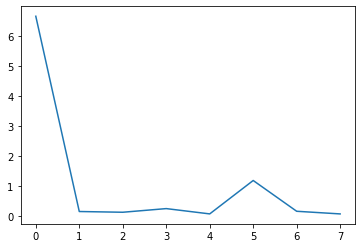

In [101]:
plt.plot(MSE_train_trend_M.values())

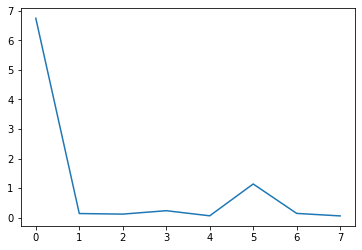

In [104]:
plt.plot(MSE_test_trend_M.values())

In [110]:
np.argmin(list(MSE_test_trend_M.values()))

7

In [108]:
MSE_test_trend_M.values()

dict_values([6.751293156736387, 0.13785229354898423, 0.11835291598492949, 0.23397409543845551, 0.06072982819240836, 1.1383251155498637, 0.14223477082955122, 0.05720381014769507])

optimal code for choosing the corrcet step size

In [127]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4
train_data=X_train.iloc[:,0]
N=train_data.shape[0]
test_data=X_test.iloc[:,0]
N_test=test_data.shape[0]

#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
def generate_m_positive_random_numbers_Norm(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(20):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(20):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=20



alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
#val_list=[0]
#M=4

#random_normal = np.random.normal(loc=0, scale=1, size=(3,))
train_data=X_train.iloc[:,3]
N=train_data.shape[0]
test_data=X_test.iloc[:,3]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
MSE_train_all=[]
pi=np.zeros((N,M))
MSE_train_trend_M={}
MSE_test_trend_M={}
alpha_M={}
mu_M={}
for M in range (2,10):
    print('M',M)
    #alpha=generate_m_positive_random_numbers(M)
    #mu=np.zeros(M)
    #values=np.linspace(-10,10,100)
    #mu=np.array(random.sample(list(values), M))
    mu=np.ones(M)
    alpha=np.ones(M)
    pi=np.zeros((N,M))
    MSE_train_all=[]
    pi=np.zeros((N,M))
    for it in range(3000):
        if it%5==0:
            print('iteration:',it)
        accepted_s_num=0
        accepted_s_num_dict[it]=accepted_s_num
                #Step2:
        #print('mu before step2',mu)
        #print('alpha before step2',alpha)
        result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
        for m in range(M):
            mu[m]=result.x[m]
        #print('mu after opt',mu)
                #Step3:
        sample_check={}
        current_state = alpha#x_t-1=init_state , x_t=current_state
        samples = [current_state]
        current_pdf=target_pdf(pi,current_state)
        while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
            current_state = generate_m_positive_random_numbers(M)
            current_pdf=target_pdf(pi,current_state)
        sample_check[tuple(current_state)]=current_pdf#f(x_t)
        all_samples[tuple(current_state)]=current_pdf        
        for _ in range(n_samples):
            if (_ % 10==0):
                #print('sample num',_)
                pass
                        # Generate a proposal sample
            proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                        #print('proposal',proposal)    
                        # Ensure the proposal is within bounds (i.e.is non-negative)        
            while any(elem <= 0 for elem in proposal):
                proposal = np.random.normal(loc=current_state, scale=proposal_step)    
            proposal_pdf=target_pdf(pi,proposal)
            while math.isinf(proposal_pdf) :
                proposal = np.random.normal(loc=current_state, scale=proposal_step)
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                proposal_pdf=target_pdf(pi,proposal)
                        # Calculate the acceptance ratio
            acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                        # Decide to accept or reject the proposal
            if np.random.rand() < acceptance_ratio:
                            #print('accepted')
                accepted_s_num+=1
                current_state = proposal#x_t=y_t
                current_pdf=proposal_pdf
                sample_check[tuple(current_state)]=current_pdf
                all_samples[tuple(current_state)]=current_pdf
            samples.append(current_state)
        accepted_s_num_dict[it]=accepted_s_num
        Highest_pdf_alpha = max(sample_check, key=sample_check.get)
        print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
        best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
                #return np.array(Highest_pdf_alpha)
        alpha=np.array(Highest_pdf_alpha)
                #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
                    #print('alpha_tr',alpha,'mu_tr',mu)

        if it%10<5:
            MSE_temp=[]
            for time in range(1000):
                      #if time%1000==0:
                          #print('time in test:',time)
                MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
            MSE_train_all.append(np.mean(MSE_temp))
        if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
            print('converge!!!')
            break
    alpha_M[M]=alpha
    mu_M[M]=mu        
    MSE_temp=[]        
    for time in range(1000):
        MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
    MSE_train_trend_M[M]=np.mean(MSE_temp) 
    MSE_temp=[] 
    for time in range(1000):
        MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
    MSE_test_trend_M[M]=np.mean(MSE_temp)


M 2
iteration: 0
highest pdf was -14377.313904936316 for (0.15356889238517724, 2.531181018311947)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12959.835378318394 for (0.04936592813829503, 1.293162844052401)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -13050.834313503416 for (0.04936592813829503, 1.293162844052401)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -9749.742633523625 for (0.0209521572352798, 0.9468988012260207)
highest pdf was -9852.52737470362 for (0.0209521572352798, 0.9468988012260207)
iteration: 5
highest pdf was -9594.096641235912 for (0.0209521572352798, 0.9468988012260207)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8030.768429279466 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7740.001415501747 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7513.140255015257 for (1.1419507920386918, 0.015279379524945513)
highest pdf was -7787.682063734252 for (1.1419507920386918, 0.015279379524945513)
iteration: 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7576.395130400554 for (1.1419507920386918, 0.015279379524945513)
highest pdf was -7553.365102541788 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7773.949992912619 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7334.546867193601 for (1.1419507920386918, 0.015279379524945513)
highest pdf was -7509.677232928066 for (1.1419507920386918, 0.015279379524945513)
iteration: 15
highest pdf was -7648.418562622158 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7726.395989182127 for (1.1419507920386918, 0.015279379524945513)
highest pdf was -7700.874866889316 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7703.6279787133 for (1.1419507920386918, 0.015279379524945513)
highest pdf was -6588.391451802522 for (1.1419507920386918, 0.015279379524945513)
iteration: 20
highest pdf was -6642.815391660678 for (1.1419507920386918, 0.015279379524945513)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4228.269755539936 for (1.2499466267245554, 0.011684009300418078)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4166.109494870875 for (1.2499466267245554, 0.011684009300418078)
highest pdf was -4113.799615483988 for (1.2499466267245554, 0.011684009300418078)
highest pdf was -3989.20127850235 for (1.2499466267245554, 0.011684009300418078)
iteration: 25
highest pdf was -4762.971197883283 for (1.2499466267245554, 0.011684009300418078)
highest pdf was -3783.5976112493745 for (1.2499466267245554, 0.011684009300418078)
highest pdf was -4101.25586351853 for (1.2499466267245554, 0.011684009300418078)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -14430.356421679246 for (16.967066543934234, 78.74266576784393)
highest pdf was -14399.275253671585 for (21.073076239081292, 74.10925168906631)
iteration: 30
highest pdf was -14355.682272602498 for (26.558564532530035, 71.44331593508404)
highest pdf was -12914.804441519487 for (32.34064982412891, 73.43513209231523)
highest pdf was -12904.098982788077 for (36.555598156391895, 72.89462770211763)
highest pdf was -4910.733088502277 for (42.965156369052096, 73.16941801057949)
highest pdf was -4365.736587732864 for (50.36535845898338, 66.13601863671349)
iteration: 35
highest pdf was -3853.098450196257 for (60.55870329117712, 62.27040766614891)
highest pdf was -3370.1541245018884 for (66.75559248255992, 53.676070540505066)
highest pdf was -3120.2463953485935 for (70.8861694632347, 49.74462668645896)
highest pdf was -2745.6186103379455 for (74.8058689565155, 42.44244256229982)
highest pdf was -2604.4285840435095 for (78.2179361658862, 40.230909372600365)
iteration: 40
highest p

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3987.679138778641 for (91.91247428773008, 0.024016745990983746)
highest pdf was 3989.721807458165 for (91.91247428773008, 0.024016745990983746)
highest pdf was 3962.0314393553745 for (91.91247428773008, 0.024016745990983746)
iteration: 50


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4813.998794381472 for (91.91247428773008, 0.024016745990983746)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5648.9307227642 for (91.6749625757404, 0.020549513639648076)
highest pdf was 5852.486252823492 for (91.6749625757404, 0.020549513639648076)
highest pdf was 5817.896472039663 for (91.6749625757404, 0.020549513639648076)
highest pdf was 5955.902894436439 for (92.55957365112354, 0.02014237592130309)
iteration: 55
highest pdf was 5863.610675197808 for (92.55957365112354, 0.02014237592130309)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5802.621443355875 for (92.55957365112354, 0.02014237592130309)
highest pdf was 5959.759750094226 for (92.55957365112354, 0.02014237592130309)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 8084.411052038867 for (91.29695730458602, 0.015000252974229081)
highest pdf was 7746.539679598605 for (91.29695730458602, 0.015000252974229081)
iteration: 60
highest pdf was 7869.59095171125 for (91.29695730458602, 0.015000252974229081)
highest pdf was 7795.793346739416 for (91.29695730458602, 0.015000252974229081)
highest pdf was 8184.373471124394 for (91.3973863590885, 0.014300464091241027)
highest pdf was 8105.701850849433 for (91.3973863590885, 0.014300464091241027)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 8145.148454247123 for (91.3973863590885, 0.014300464091241027)
iteration: 65
highest pdf was 8182.422123042556 for (91.3973863590885, 0.014300464091241027)
highest pdf was 8382.948139765007 for (91.3973863590885, 0.014300464091241027)
highest pdf was 8376.870706465748 for (91.3973863590885, 0.014300464091241027)
highest pdf was 8372.412613133645 for (91.3973863590885, 0.014300464091241027)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1292.6195377467257 for (25.416212641414766, 0.08800389410731146)
iteration: 70


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1927.7502624020512 for (26.631688269652262, 0.06069775185607312)
highest pdf was 1905.3003381882756 for (26.631688269652262, 0.06069775185607312)
highest pdf was 1944.307776088239 for (26.631688269652262, 0.06069775185607312)
converge!!!
M 3
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -13415.425317792051 for (2.3973526980401347, 0.07032580392358567, 1.8341862850833444)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11420.505331639668 for (0.03739206087842328, 0.11477918921968931, 1.4720235531634522)
highest pdf was -11390.242603740822 for (0.03739206087842328, 0.11477918921968931, 1.4720235531634522)
highest pdf was -11188.68379925435 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)
highest pdf was -11270.356332393885 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)
iteration: 5
highest pdf was -11167.814402426431 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)
highest pdf was -11229.120834109306 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)
highest pdf was -11334.966858660362 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)
highest pdf was -11147.730207389819 for (0.029599499356278366, 2.303495148933713, 1.1362315669309246)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6944.298405338245 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
iteration: 10
highest pdf was -6904.612049054369 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -7088.042643418848 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -6897.974813283951 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -7019.456132484836 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -7000.857501132344 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
iteration: 15
highest pdf was -7129.966562618367 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -6768.783435196662 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -7210.380055381746 for (0.014204279417162827, 1.3270088843494647, 2.184142478295187)
highest pdf was -7209.9395151336685 for (0.014204279417162827, 

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12689.852636048416 for (8.910431886606842, 0.05590408439953104, 8.127898994073163, 5.457369466297823)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10362.358787717425 for (8.644253491912098, 0.02595109894140634, 8.56666694092503, 5.20916247670318)
highest pdf was -9351.741074224117 for (8.32024507591188, 0.02194497495064091, 6.658134355802384, 4.943207099636031)
highest pdf was -9461.783938745784 for (8.32024507591188, 0.02194497495064091, 6.658134355802384, 4.943207099636031)
iteration: 5
highest pdf was -9433.605089214603 for (8.32024507591188, 0.02194497495064091, 6.658134355802384, 4.943207099636031)
highest pdf was -9438.695915201648 for (8.32024507591188, 0.02194497495064091, 6.658134355802384, 4.943207099636031)
highest pdf was -9342.379132352575 for (8.32024507591188, 0.02194497495064091, 6.658134355802384, 4.943207099636031)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4489.04524091957 for (8.04057568263136, 0.011396715198131548, 6.852374845974111, 6.258194474289848)
highest pdf was -4649.642949470121 for (8.04057568263136, 0.011396715198131548, 6.852374845974111, 6.258194474289848)
iteration: 10
highest pdf was -4444.6736748199055 for (7.226668921812232, 0.011350540911152056, 6.458967152131876, 4.810308191055439)
highest pdf was -4670.284996858361 for (7.226668921812232, 0.011350540911152056, 6.458967152131876, 4.810308191055439)
highest pdf was -4355.367352752755 for (7.226668921812232, 0.011350540911152056, 6.458967152131876, 4.810308191055439)
highest pdf was -4465.634019275785 for (7.226668921812232, 0.011350540911152056, 6.458967152131876, 4.810308191055439)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -14119.94582361711 for (77.14240006437306, 35.49294458505335, 59.69445339836344, 64.52633039347228)
iteration: 15
highest pdf was -14119.296288734473 for (77.26539798294809, 35.64888550535484, 60.721418541502345, 63.93838483126913)
highest pdf was -14120.387394527152 for (78.21570068667039, 35.02543747270435, 60.25879346249342, 63.46692445525613)
highest pdf was -14122.733776512636 for (78.19458312163187, 34.41957219179219, 61.665523375805805, 61.42440911762861)
highest pdf was -14120.684361090325 for (79.62228066041679, 37.108128322599754, 62.41571660828197, 62.540840291914904)
highest pdf was -14117.830193571457 for (81.74100435218895, 34.035704379009445, 61.7777012379816, 64.40729772150742)
iteration: 20
highest pdf was -14119.213073275161 for (80.13144877732988, 28.20672060263067, 60.53266432797908, 62.21610443429964)
converge!!!
M 5
iteration: 0
highest pdf was -14043.936228320952 for (0.27308963804036523, 5.207534322695068, 2.5768870107436195, 4.6470157413546795, 

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12140.05884370733 for (0.04859439026700871, 5.884525020692501, 1.7044849595205678, 5.16052851082248, 5.359750811854642)
highest pdf was -12198.151996879078 for (0.04859439026700871, 5.884525020692501, 1.7044849595205678, 5.16052851082248, 5.359750811854642)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10780.517875883379 for (0.19029995317259457, 6.498806228783965, 0.03473817517549094, 4.837569216385307, 6.057884976602089)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6816.990935556768 for (1.1605637021647024, 8.544913807219185, 0.015168831969948756, 4.225210434471519, 6.436310637269194)
iteration: 5
highest pdf was -6779.526695321599 for (1.1605637021647024, 8.544913807219185, 0.015168831969948756, 4.225210434471519, 6.436310637269194)
highest pdf was -6657.829209775938 for (1.1605637021647024, 8.544913807219185, 0.015168831969948756, 4.225210434471519, 6.436310637269194)
highest pdf was -6730.279632400626 for (1.1605637021647024, 8.544913807219185, 0.015168831969948756, 4.225210434471519, 6.436310637269194)
highest pdf was -6596.322846597429 for (1.1605637021647024, 8.544913807219185, 0.015168831969948756, 4.225210434471519, 6.436310637269194)
highest pdf was -6328.837567662999 for (0.014237620964409059, 7.622277740156654, 1.3141529572374997, 5.435539553301243, 6.195653131324278)
iteration: 10
highest pdf was -6089.703325271698 for (0.014237620964409059, 7.622277740156654, 1.3141529572374997, 5.435539553301243, 6.195653131324278)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5349.969847016896 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)
highest pdf was -5627.786948357655 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)
highest pdf was -5533.98407474509 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -5563.236411010444 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)
iteration: 15
highest pdf was -5755.148714188731 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)
highest pdf was -5587.595329880872 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)
highest pdf was -5983.536571112568 for (0.013176055621113795, 6.594496592559345, 1.615100809478369, 4.0293167221707815, 4.6115577354490975)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12573.079831218214 for (10.853552386097546, 18.776719710401036, 11.508691855362349, 0.07871929992925256, 50.54621348708446)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7758.3027319809 for (11.155393838004654, 20.87564423772929, 10.123206727607371, 0.018859510256175653, 49.769023698585215)
iteration: 20
highest pdf was -7796.876131270119 for (11.155393838004654, 20.87564423772929, 10.123206727607371, 0.018859510256175653, 49.769023698585215)
converge!!!
M 6
iteration: 0


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12675.222686581033 for (1.6758185125917517, 2.359494371089106, 1.0643516722401154, 2.847799994639723, 7.653711608869663, 0.07167307228284751)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7441.490594718401 for (1.0983779393661186, 1.433864670772763, 0.10744424127230906, 2.8768644180668925, 7.428334713226766, 0.019470008801217707)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7586.6966107957915 for (1.0983779393661186, 1.433864670772763, 0.10744424127230906, 2.8768644180668925, 7.428334713226766, 0.019470008801217707)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4238.468357406194 for (1.2341399525687158, 1.1391065515186438, 0.011256652093948077, 0.9322694819091177, 7.701578154993857, 0.7958312268741906)
highest pdf was -4063.547746044788 for (1.2341399525687158, 1.1391065515186438, 0.011256652093948077, 0.9322694819091177, 7.701578154993857, 0.7958312268741906)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -12021.175761814115 for (101.26314934174874, 0.08337661769131915, 53.65747260375051, 54.281769200275875, 57.29140452748378, 13.101585662588443)
highest pdf was -11580.80812682467 for (101.65056503967634, 0.06174806247807477, 52.8171357511345, 54.35833066177181, 57.14886415036019, 12.985451605699295)
highest pdf was -10919.326120711303 for (99.999202582055, 0.04742156710604586, 50.72889000416973, 54.99070469393971, 56.304605335751425, 12.379924717493385)
highest pdf was -11018.455806987984 for (99.999202582055, 0.04742156710604586, 50.72889000416973, 54.99070469393971, 56.304605335751425, 12.379924717493385)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -11024.53989735033 for (99.999202582055, 0.04742156710604586, 50.72889000416973, 54.99070469393971, 56.304605335751425, 12.379924717493385)
iteration: 10
highest pdf was -10970.57499495789 for (99.999202582055, 0.04742156710604586, 50.72889000416973, 54.99070469393971, 56.304605335751425, 12.379924717493385)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8141.387523515029 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
highest pdf was -8326.102045506195 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
highest pdf was -8207.408559891315 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -8265.810823763852 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
iteration: 15
highest pdf was -8299.635796983031 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
highest pdf was -8266.1769221914 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
highest pdf was -8250.949719726566 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -8213.610249535937 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -8219.638463430343 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
iteration: 20


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -8273.417333850339 for (101.10392406887003, 0.022377206351551094, 51.84870591417648, 54.16830803801918, 55.39544392639578, 11.967632549472073)
converge!!!
M 7
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -11735.883546646204 for (0.8697895423723874, 2.2490688691242764, 4.307854700418043, 0.8401070298120896, 0.059349379767506205, 0.1735956824913445, 3.3688053383336882)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8621.074761135966 for (1.2699374755794524, 2.4977079414066052, 5.226875319611396, 1.0878406051585425, 0.8972510714525285, 0.021617686123697577, 4.740315439506581)
highest pdf was -8808.600868758045 for (1.2699374755794524, 2.4977079414066052, 5.226875319611396, 1.0878406051585425, 0.8972510714525285, 0.021617686123697577, 4.740315439506581)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7251.390699116044 for (0.01701268881228576, 1.8919248927035266, 6.338362799161779, 2.734440694965635, 2.312790646851586, 1.044423241920018, 3.549755326710772)
highest pdf was -7434.484830008188 for (0.01701268881228576, 1.8919248927035266, 6.338362799161779, 2.734440694965635, 2.312790646851586, 1.044423241920018, 3.549755326710772)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7480.1994245250235 for (0.01701268881228576, 1.8919248927035266, 6.338362799161779, 2.734440694965635, 2.312790646851586, 1.044423241920018, 3.549755326710772)
highest pdf was -7277.486433552231 for (0.01701268881228576, 1.8919248927035266, 6.338362799161779, 2.734440694965635, 2.312790646851586, 1.044423241920018, 3.549755326710772)
highest pdf was -6737.6732411090725 for (0.016007494432786228, 0.7168340457255278, 5.8425716423597684, 4.1575427543952435, 4.626175443646293, 0.6186854861396105, 2.577960427298164)
highest pdf was -6666.93873564287 for (0.016007494432786228, 0.7168340457255278, 5.8425716423597684, 4.1575427543952435, 4.626175443646293, 0.6186854861396105, 2.577960427298164)
highest pdf was -6500.5676592716545 for (0.016007494432786228, 0.7168340457255278, 5.8425716423597684, 4.1575427543952435, 4.626175443646293, 0.6186854861396105, 2.577960427298164)
iteration: 10
highest pdf was -6819.207861001558 for (0.016007494432786228, 0.7168340457255278, 5.84257164

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6773.08687229266 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
highest pdf was -6500.042441236909 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
highest pdf was -6548.8824772711205 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6742.05307198076 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6673.987817649068 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
highest pdf was -6586.783990526658 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
highest pdf was -6547.702345524266 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6522.015114763889 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
iteration: 20
highest pdf was -6430.579223968706 for (0.024259961496598977, 1.1738296106786914, 6.093301018638167, 5.155655809263863, 3.515771882212193, 0.03887897278709429, 1.6539210638656074)
converge!!!
M 8
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11859.090896661666 for (4.794865539375004, 0.059005948234229555, 4.839400642069526, 2.9084004582332357, 1.591423809080203, 1.683809154108142, 1.8738117729380812, 1.0022127476078797)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6996.838147835667 for (6.296204835312676, 0.27339220256201113, 7.036196254074977, 2.2568830104508915, 0.01799162014328992, 2.4872878801303906, 3.1453378345857184, 3.6974583177709874)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4139.171330025971 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4359.446927011064 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4273.251228284926 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
iteration: 5
highest pdf was -4081.582945493481 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4502.774416303668 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4206.39427965609 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4289.363814311657 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4629.317487015016 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
iteration: 10
highest pdf was -5123.499990661139 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4386.608411232146 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4599.18072096974 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4372.855804297409 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4390.497697544499 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4491.49808026342 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)
highest pdf was -4518.238106903729 for (5.083832925161362, 0.2503293497035002, 6.327931483041285, 2.5213570088294373, 0.01278908485837884, 2.3086477516467605, 2.8164092993973426, 4.9754806335651365)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3263.100182678856 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
highest pdf was -3606.146944571643 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
highest pdf was 11170.555598144652 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
iteration: 20
highest pdf was 11529.537744666439 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
highest pdf was 11303.49792406336 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
highest

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 11764.678670760912 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 11328.737662060938 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
iteration: 25
highest pdf was 11126.859609258048 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)
highest pdf was 11202.564799781314 for (5.052761649047499, 0.011252790339007113, 6.963594347683185, 2.0334611974301455, 0.709595576861327, 1.914052226061818, 4.111516194365027, 4.272159419261923)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2027.316585952085 for (59.79490664418816, 26.284492724563947, 65.52190250293496, 65.66278260506799, 48.386392798307874, 33.78108423387977, 27.043189069355623, 94.54230236241695)
highest pdf was 2087.6793633051934 for (59.891805291644125, 19.526389164269165, 73.50608595066154, 74.61519663716746, 50.911742804215095, 36.4295001361723, 34.82604973528663, 92.94631372809702)
highest pdf was 2128.524100076269 for (63.441131356002884, 22.420614165803727, 76.00460077668379, 71.72625658123876, 59.00440236914166, 42.83191533567063, 37.41739177292151, 92.16112330099267)
iteration: 30
highest pdf was 2227.6562483920616 for (65.82289457664223, 22.9889063352443, 88.90665808388762, 66.86697903484774, 58.03347660762495, 48.49187401086982, 51.19724920726537, 96.56437956190457)
highest pdf was 2255.4735479738333 for (64.35507521426419, 22.75947122137204, 97.79034368795807, 62.55947135445881, 62.59371319332032, 45.40772222402725, 46.5792103856441, 99.08890181665713)
highest pdf was 2276.32

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10022.919070005952 for (2.760886438024009, 2.9430080709371653, 3.7483890630362278, 0.03460772714893204, 0.7309090269363766, 0.8475190253150526, 5.222716646123669, 0.8790604247786039, 0.5131345801120273)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8740.847465985233 for (2.1348724121085594, 3.1289127617931314, 4.442177331193485, 1.1217933894003445, 1.3621887961550898, 0.024275476112773142, 4.0766270332290375, 1.0607660805574906, 0.5171293019101876)
highest pdf was -8472.898288395983 for (2.5183962374936235, 2.4976992989262783, 4.2799472978256015, 1.9806394769426636, 0.88850607925412, 0.023969234958364203, 2.8694408979210406, 2.2073953166427627, 0.19831830593158822)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6711.924614381577 for (2.772586260292773, 1.2579025230430128, 3.1428426657527835, 1.7637803108051975, 0.0164628837939369, 1.3712112839732702, 2.243782151373501, 2.812624756119174, 0.6944433098856667)
highest pdf was -6746.372122884281 for (2.772586260292773, 1.2579025230430128, 3.1428426657527835, 1.7637803108051975, 0.0164628837939369, 1.3712112839732702, 2.243782151373501, 2.812624756119174, 0.6944433098856667)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6751.293695637322 for (2.252402239847372, 2.1574739531473917, 2.3105551477897213, 1.864186210950637, 0.3673309658490866, 1.2106564559535757, 1.8734970504552826, 0.46018704949527667, 0.016621228083882333)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5384.48434040701 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -5698.871679951409 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
highest pdf was -5114.844983850981 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
highest pdf was -5536.794547092583 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
iteration: 10
highest pdf was -5285.735965125087 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -5395.421755291723 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -5384.036694591804 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
highest pdf was -5240.620211842975 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
highest pdf was -5254.338119356183 for (1.6920178813380855, 1.2613017578407808, 1.8842993264005394, 1.7432818981382732, 0.013947561260337582, 1.0683060359418286, 1.795937833780413, 0.3006306935633366, 0.49113347873286467)
iteration: 15


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/2070189299.py:172: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3043.5052695090167 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3354.526412956539 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)
highest pdf was -3182.5001353701377 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3289.525020301144 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)
highest pdf was -3281.551079604819 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)
iteration: 20


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3535.2493472631454 for (1.1943976572044068, 1.7839111761064883, 1.262767304147777, 2.2658994787224946, 0.011117714789593423, 0.4090966120751882, 1.3423041564268823, 0.31657497224298436, 1.1383419034315605)
converge!!!


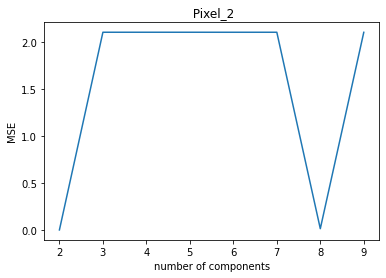

In [128]:

plt.plot(MSE_train_trend_M.values())
plt.xticks(range(len(MSE_train_trend_M)), list(MSE_train_trend_M.keys()))

# Set the title and labels for the plot
plt.title(' Pixel_2')
plt.xlabel('number of components')
plt.ylabel('MSE')

# Show the plot
plt.show()

In [150]:
MSE_test_trend_M

{2: 0.0032381568322447834,
 3: 2.0830140200567455,
 4: 2.0830724898521957,
 5: 2.0829936307183354,
 6: 2.0828833181822697,
 7: 2.0829535851970054,
 8: 0.014755969339857842,
 9: 2.0823524847325334}

In [ ]:
plt.plot(MSE_train_trend_M.values())

In [116]:
np.argmin(list(MSE_test_trend_M.values()))

7

In [126]:
MSE_tr_pixel_2=MSE_train_trend_M
MSE_te_pixel_2=MSE_test_trend_M

In [146]:
MSE_te_pixel_3={2: 0.0038277901258695858,
 3: 2.1780646392822067,
 4: 2.2388540636826777,
 5: 2.239272890379531,
 6: 2.239304033893195,
 7: 2.2393960581583237,
 8: 2.2393736797986676,
 9: 2.2392718940017597}

In [145]:
MSE_tr_pixel_3

{2: 0.0027377319912219337,
 3: 2.180520774413659,
 4: 2.2413597771853073,
 5: 2.2417789268876067,
 6: 2.241810080260193,
 7: 2.2419021383441167,
 8: 2.241879742643754,
 9: 2.241777866732589}

In [154]:
alpha_opt_dict['pixel_3']=[80.00865443, 53.32651663]
mu_opt_dict['pixel_3']=[-0.3173781 , -0.71194586]
MSE_tr_trend_all_pix['pixel_4']=MSE_train_trend_M
MSE_te_trend_all_pix['pixel_4']=MSE_test_trend_M
MSE_te_trend_all_pix

{'pixel_4': {2: 0.0032381568322447834,
  3: 2.0830140200567455,
  4: 2.0830724898521957,
  5: 2.0829936307183354,
  6: 2.0828833181822697,
  7: 2.0829535851970054,
  8: 0.014755969339857842,
  9: 2.0823524847325334}}

In [156]:
alpha_M

{2: array([26.63168827,  0.06069775]),
 3: array([0.01420428, 1.32700888, 2.18414248]),
 4: array([80.13144878, 28.2067206 , 60.53266433, 62.21610443]),
 5: array([1.11553938e+01, 2.08756442e+01, 1.01232067e+01, 1.88595103e-02,
        4.97690237e+01]),
 6: array([1.01103924e+02, 2.23772064e-02, 5.18487059e+01, 5.41683080e+01,
        5.53954439e+01, 1.19676325e+01]),
 7: array([0.02425996, 1.17382961, 6.09330102, 5.15565581, 3.51577188,
        0.03887897, 1.65392106]),
 8: array([ 66.09513792,  12.75573511, 102.38869801,  58.84066196,
         65.51932669,  45.11626779,  45.97313089, 104.59674617]),
 9: array([1.19439766, 1.78391118, 1.2627673 , 2.26589948, 0.01111771,
        0.40909661, 1.34230416, 0.31657497, 1.1383419 ])}

######  very good code for some pixels

In [157]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4


#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(20):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)*np.mean(power))*(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(20):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=20



alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
#val_list=[0]
#M=4


train_data=X_train.iloc[:,3]
N=train_data.shape[0]
test_data=X_test.iloc[:,3]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
MSE_train_all=[]
pi=np.zeros((N,M))


MSE_tr_s={}
MSE_te_s={}
MSE_train_trend_M={}
MSE_test_trend_M={}
alpha_s={}
mu_s={}
alpha_M={}
mu_M={}

val_list=[430000,430001,430002,430003,430004]


for val in val_list:
    print(val)
    train_data=X_train.iloc[:,val]
    N=train_data.shape[0]
    test_data=X_test.iloc[:,val]
    N_test=test_data.shape[0]
    alpha_s[val]=alpha_M
    mu_s[val]=mu_M
    MSE_tr_s[val]=MSE_train_trend_M
    MSE_te_s[val]=MSE_test_trend_M
    
    for M in range (2,10):
        print('M',M)
        #alpha=generate_m_positive_random_numbers(M)
        #mu=np.zeros(M)
        #values=np.linspace(-10,10,100)
        #mu=np.array(random.sample(list(values), M))
        mu=np.ones(M)
        alpha=np.ones(M)
        pi=np.zeros((N,M))
        MSE_train_all=[]
        pi=np.zeros((N,M))
        for it in range(3000):
            if it%5==0:
                print('iteration:',it)
            accepted_s_num=0
            accepted_s_num_dict[it]=accepted_s_num
                    #Step2:
            #print('mu before step2',mu)
            #print('alpha before step2',alpha)
            result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
            for m in range(M):
                mu[m]=result.x[m]
            #print('mu after opt',mu)
                    #Step3:
            sample_check={}
            current_state = alpha#x_t-1=init_state , x_t=current_state
            samples = [current_state]
            current_pdf=target_pdf(pi,current_state)
            while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
                current_state = generate_m_positive_random_numbers(M)
                current_pdf=target_pdf(pi,current_state)
            sample_check[tuple(current_state)]=current_pdf#f(x_t)
            all_samples[tuple(current_state)]=current_pdf        
            for _ in range(n_samples):
                if (_ % 10==0):
                    #print('sample num',_)
                    pass
                            # Generate a proposal sample
                proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                            #print('proposal',proposal)    
                            # Ensure the proposal is within bounds (i.e.is non-negative)        
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)    
                proposal_pdf=target_pdf(pi,proposal)
                while math.isinf(proposal_pdf) :
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    while any(elem <= 0 for elem in proposal):
                        proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    proposal_pdf=target_pdf(pi,proposal)
                            # Calculate the acceptance ratio
                acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                            # Decide to accept or reject the proposal
                if np.random.rand() < acceptance_ratio:
                                #print('accepted')
                    accepted_s_num+=1
                    current_state = proposal#x_t=y_t
                    current_pdf=proposal_pdf
                    sample_check[tuple(current_state)]=current_pdf
                    all_samples[tuple(current_state)]=current_pdf
                samples.append(current_state)
            accepted_s_num_dict[it]=accepted_s_num
            Highest_pdf_alpha = max(sample_check, key=sample_check.get)
            print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
            best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
                    #return np.array(Highest_pdf_alpha)
            alpha=np.array(Highest_pdf_alpha)
                    #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
                        #print('alpha_tr',alpha,'mu_tr',mu)

            if it%10<5:
                MSE_temp=[]
                for time in range(1000):
                          #if time%1000==0:
                              #print('time in test:',time)
                    MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
                MSE_train_all.append(np.mean(MSE_temp))
            if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
                print('converge!!!')
                break
        alpha_M[M]=alpha
        mu_M[M]=mu        
        MSE_temp=[]        
        for time in range(1000):
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        MSE_train_trend_M[M]=np.mean(MSE_temp) 
        MSE_temp=[] 
        for time in range(1000):
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
        MSE_test_trend_M[M]=np.mean(MSE_temp)


430000
M 2
iteration: 0
highest pdf was -17066.47737030727 for (2.3238924547494273, 1.3266451245918842)
highest pdf was -16957.18327974451 for (6.358362946452157, 0.8486207971887705)
highest pdf was -16958.91401418408 for (6.358362946452157, 0.8486207971887705)
highest pdf was -16749.48799379006 for (7.358231390648706, 0.3368148925498688)
highest pdf was -16441.530542481032 for (9.067767688165514, 0.16649153169873726)
iteration: 5
highest pdf was -16429.150407580084 for (9.067767688165514, 0.16649153169873726)
highest pdf was -16457.222648208444 for (9.067767688165514, 0.16649153169873726)
highest pdf was -16381.347476714012 for (9.067767688165514, 0.16649153169873726)
highest pdf was -16437.81707187506 for (9.067767688165514, 0.16649153169873726)
highest pdf was -16421.58640819195 for (9.067767688165514, 0.16649153169873726)
iteration: 10
highest pdf was -16404.84872242632 for (9.067767688165514, 0.16649153169873726)
highest pdf was -16473.28246405264 for (9.067767688165514, 0.1664915

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14891.519262087126 for (9.673248250264237, 0.051624427799565026)
highest pdf was -14838.227994642666 for (9.673248250264237, 0.051624427799565026)
highest pdf was -14942.725661005232 for (9.673248250264237, 0.051624427799565026)
iteration: 15
highest pdf was -14839.714111109235 for (9.673248250264237, 0.051624427799565026)
highest pdf was -15058.708333598444 for (9.673248250264237, 0.051624427799565026)
highest pdf was -14941.307948895143 for (9.673248250264237, 0.051624427799565026)
highest pdf was -14862.300683747988 for (9.673248250264237, 0.051624427799565026)
highest pdf was -15132.379466494265 for (9.673248250264237, 0.051624427799565026)
iteration: 20
highest pdf was -14771.025737536265 for (9.673248250264237, 0.051624427799565026)
converge!!!
M 3
iteration: 0
highest pdf was -16704.25668088479 for (1.958614854229741, 1.806565099567147, 0.25212370897102554)
highest pdf was -16686.779470645153 for (1.958614854229741, 1.806565099567147, 0.25212370897102554)
highes

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -16541.047827634095 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
highest pdf was -16486.764210759662 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
iteration: 15
highest pdf was -16515.462829914333 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
highest pdf was -16458.895462578304 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
highest pdf was -16483.76985853987 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
highest pdf was -16515.417058502415 for (2.9602509675942867, 1.656514244456596, 0.16861076741606595)
highest pdf was -8747.548606315595 for (3.1711172666031846, 1.8116064019239073, 0.014120511642481237)
iteration: 20


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -9796.124356708153 for (3.1711172666031846, 1.8116064019239073, 0.014120511642481237)
converge!!!
M 4
iteration: 0
highest pdf was -16157.74120813386 for (2.2792607348337093, 0.12327469345662345, 0.9782375183849095, 0.4711197936270941)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -16124.092074998154 for (2.5700604213723097, 0.2882508134376375, 1.5095033650778633, 0.14872094873026243)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11319.406366143672 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -11479.455947021781 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -11525.232419134785 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
iteration: 5
highest pdf was -11094.016897494665 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -10792.182359269918 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -11529.632533127371 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -11815.234688241302 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
highest pdf was -11577.212305299832 for (2.713624288143313, 2.1029616828807987, 1.6883368454461516, 0.02029695934441006)
iteration: 10
highe

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


(0.03113886795580348, 3.1052052417615448, 1.9762381180479494, 3.607996316982469, 0.6147059101456447)
highest pdf was -13154.14594131535 for (0.03113886795580348, 3.1052052417615448, 1.9762381180479494, 3.607996316982469, 0.6147059101456447)
highest pdf was -13244.601413346809 for (0.03113886795580348, 3.1052052417615448, 1.9762381180479494, 3.607996316982469, 0.6147059101456447)
highest pdf was -13056.616235900892 for (0.03113886795580348, 3.1052052417615448, 1.9762381180479494, 3.607996316982469, 0.6147059101456447)
iteration: 10
highest pdf was -13351.945398314529 for (0.03113886795580348, 3.1052052417615448, 1.9762381180479494, 3.607996316982469, 0.6147059101456447)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11393.635133576912 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
highest pdf was -10922.88706101891 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
highest pdf was -11572.153220922026 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
highest pdf was -11469.17458266635 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
iteration: 15
highest pdf was -11380.78434821031 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
highest pdf was -11438.225836499854 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735608)
highest pdf was -11660.372691251096 for (3.2070497022794737, 3.5883301467399575, 2.4442194381131594, 4.355622824648179, 0.021109911856735

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -15565.283705614487 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
highest pdf was -15453.667461971245 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
highest pdf was -15416.206598243098 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
highest pdf was -15371.466540415642 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
highest pdf was -15502.138991223512 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
iteration: 5
highest pdf was -15503.124301821987 for (0.746961422718529, 1.5177093856920016, 0.09613070173556804, 0.7094520190842616, 2.0605376782981626, 0.42948617991758875)
highest pdf was

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13157.065417545766 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
highest pdf was -12368.738086181173 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
iteration: 10
highest pdf was -11814.891402374335 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
highest pdf was -13081.427557432362 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
highest pdf was -12224.72514573084 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
highest pdf was -12597.416708047453 for (1.9394756831376334, 1.7563059977966116, 0.028390666287866254, 0.4809351732231618, 1.3846627306817578, 1.7050310535300766)
highest p

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1416.2160629580474 for (2.5486002262756435, 1.4119087621829285, 0.0080927760196779, 1.2367237822491606, 3.0986597722223683, 1.7309193810399952, 0.5571518931764972)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -15097.87914616524 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.973600931944902, 79.22626610994506, 35.99974403585569, 60.991443206121176)
highest pdf was -15085.04665977393 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.973600931944902, 79.22626610994506, 35.99974403585569, 60.991443206121176)
highest pdf was -15072.151354096499 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.973600931944902, 79.22626610994506, 35.99974403585569, 60.991443206121176)
highest pdf was -15090.435626182862 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.973600931944902, 79.22626610994506, 35.99974403585569, 60.991443206121176)
highest pdf was -15093.567787467506 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.973600931944902, 79.22626610994506, 35.99974403585569, 60.991443206121176)
iteration: 10
highest pdf was -15098.962682962485 for (9.18878196809326, 76.83992613582078, 23.110816873043103, 2.9736009319449

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14272.72329014631 for (10.010253571058715, 77.44111933882952, 22.984806895698025, 0.13616736571713506, 78.70946407058729, 36.74272776656078, 63.80983068335564)
highest pdf was -14382.685145117262 for (10.010253571058715, 77.44111933882952, 22.984806895698025, 0.13616736571713506, 78.70946407058729, 36.74272776656078, 63.80983068335564)
iteration: 15
highest pdf was -14372.382833016962 for (10.010253571058715, 77.44111933882952, 22.984806895698025, 0.13616736571713506, 78.70946407058729, 36.74272776656078, 63.80983068335564)
highest pdf was -14392.478035000395 for (10.010253571058715, 77.44111933882952, 22.984806895698025, 0.13616736571713506, 78.70946407058729, 36.74272776656078, 63.80983068335564)
highest pdf was -14332.11510942163 for (10.010253571058715, 77.44111933882952, 22.984806895698025, 0.13616736571713506, 78.70946407058729, 36.74272776656078, 63.80983068335564)
highest pdf was -14287.859309906864 for (10.010253571058715, 77.44111933882952, 22.984806895698025

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13250.534692201873 for (1.5692550585484584, 1.2814101785792515, 1.561532624905184, 1.1055356868451862, 1.920130643971969, 0.0355426250895865, 2.418373832989964, 0.6037829276734784)
highest pdf was -13051.438957783352 for (1.5692550585484584, 1.2814101785792515, 1.561532624905184, 1.1055356868451862, 1.920130643971969, 0.0355426250895865, 2.418373832989964, 0.6037829276734784)
highest pdf was -12904.041127969867 for (1.5692550585484584, 1.2814101785792515, 1.561532624905184, 1.1055356868451862, 1.920130643971969, 0.0355426250895865, 2.418373832989964, 0.6037829276734784)
highest pdf was -12985.345778501522 for (1.5692550585484584, 1.2814101785792515, 1.561532624905184, 1.1055356868451862, 1.920130643971969, 0.0355426250895865, 2.418373832989964, 0.6037829276734784)
iteration: 5
highest pdf was -12914.542597743759 for (1.5692550585484584, 1.2814101785792515, 1.561532624905184, 1.1055356868451862, 1.920130643971969, 0.0355426250895865, 2.418373832989964, 0.603782927673478

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


converge!!!
M 9
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14798.168842930156 for (0.10813025885136562, 1.961353872297511, 1.527808189910664, 1.3968486073111492, 2.6021085275976734, 0.7094384888757203, 1.9481242595141188, 1.8945472747881922, 0.4070525939503835)
highest pdf was -14881.090708904565 for (0.10813025885136562, 1.961353872297511, 1.527808189910664, 1.3968486073111492, 2.6021085275976734, 0.7094384888757203, 1.9481242595141188, 1.8945472747881922, 0.4070525939503835)
highest pdf was -14726.360853953436 for (0.10813025885136562, 1.961353872297511, 1.527808189910664, 1.3968486073111492, 2.6021085275976734, 0.7094384888757203, 1.9481242595141188, 1.8945472747881922, 0.4070525939503835)
highest pdf was -14752.487403672701 for (0.10813025885136562, 1.961353872297511, 1.527808189910664, 1.3968486073111492, 2.6021085275976734, 0.7094384888757203, 1.9481242595141188, 1.8945472747881922, 0.4070525939503835)
highest pdf was -14591.561705752243 for (0.7882613210946628, 2.027037514253659, 1.2225949012896988, 0.0997568891781182, 

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -14172.967740877564 for (2.1248659136208436, 2.5058905378653, 1.4078829801501649, 0.08626749382175573, 4.015496238296272, 1.4933759705271177, 0.28363363119114726, 0.3356657031196315, 2.2585975132679326)
highest pdf was -14235.561856094153 for (2.1248659136208436, 2.5058905378653, 1.4078829801501649, 0.08626749382175573, 4.015496238296272, 1.4933759705271177, 0.28363363119114726, 0.3356657031196315, 2.2585975132679326)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12840.62328532448 for (2.127100484520198, 3.568897124104069, 2.25772790659134, 0.1183403040981825, 4.948353560393452, 0.05224377610709818, 1.1286813823628177, 1.0946787602910915, 2.3679417078245524)
highest pdf was -12760.125692535741 for (2.127100484520198, 3.568897124104069, 2.25772790659134, 0.1183403040981825, 4.948353560393452, 0.05224377610709818, 1.1286813823628177, 1.0946787602910915, 2.3679417078245524)
highest pdf was -12846.172954817754 for (2.127100484520198, 3.568897124104069, 2.25772790659134, 0.1183403040981825, 4.948353560393452, 0.05224377610709818, 1.1286813823628177, 1.0946787602910915, 2.3679417078245524)
highest pdf was -12823.381644977346 for (2.127100484520198, 3.568897124104069, 2.25772790659134, 0.1183403040981825, 4.948353560393452, 0.05224377610709818, 1.1286813823628177, 1.0946787602910915, 2.3679417078245524)
highest pdf was -12724.97459828874 for (2.127100484520198, 3.568897124104069, 2.25772790659134, 0.1183403040981825, 4.948353560393452

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11448.925751012403 for (2.454637080332148, 2.7768624377129916, 1.4955384388122863, 0.9228097625874001, 5.268836896674092, 0.027497825520908164, 1.030788915427147, 2.2658982248125317, 4.222996178156096)
highest pdf was -11633.616603115026 for (2.454637080332148, 2.7768624377129916, 1.4955384388122863, 0.9228097625874001, 5.268836896674092, 0.027497825520908164, 1.030788915427147, 2.2658982248125317, 4.222996178156096)
iteration: 20
highest pdf was -11570.718467936493 for (2.454637080332148, 2.7768624377129916, 1.4955384388122863, 0.9228097625874001, 5.268836896674092, 0.027497825520908164, 1.030788915427147, 2.2658982248125317, 4.222996178156096)
converge!!!
430001
M 2
iteration: 0
highest pdf was -12231.85932295902 for (0.08824869603873775, 3.651094829880357)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12128.21799175937 for (0.08824869603873775, 3.651094829880357)
highest pdf was -12019.283786503222 for (0.08824869603873775, 3.651094829880357)
highest pdf was -12160.75692610229 for (0.08824869603873775, 3.651094829880357)
highest pdf was -12008.978272472905 for (0.08824869603873775, 3.651094829880357)
iteration: 5
highest pdf was -11970.990352747285 for (0.08824869603873775, 3.651094829880357)
highest pdf was -12269.043255585795 for (0.08824869603873775, 3.651094829880357)
highest pdf was -11803.651455424882 for (0.06408410826706232, 2.193184747360533)
highest pdf was -11735.793282009934 for (0.06408410826706232, 2.193184747360533)
highest pdf was -11730.729724336383 for (0.06408410826706232, 2.193184747360533)
iteration: 10
highest pdf was -11628.913096963663 for (0.06408410826706232, 2.193184747360533)
highest pdf was -11692.812239240502 for (0.06408410826706232, 2.193184747360533)
highest pdf was -11829.579973082278 for (0.06408410826706232, 2.193184747360533)
hig

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11262.218001367984 for (2.607480335421888, 0.05847455534869417, 0.4766765212270988)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10827.246946670326 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
iteration: 5
highest pdf was -10867.621772374489 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
highest pdf was -10942.987517268593 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
highest pdf was -10852.306799658421 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
highest pdf was -10925.781346847401 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
highest pdf was -10688.448231071165 for (3.22764197733648, 2.0194246402374025, 0.044204823153678297)
iteration: 10
highest pdf was -10060.725312423272 for (3.646716844039251, 3.25642037607535, 0.030866193576754526)
highest pdf was -9663.534006537264 for (3.646716844039251, 3.25642037607535, 0.030866193576754526)
highest pdf was -9889.72932889507 for (3.646716844039251, 3.25642037607535, 0.030866193576754526)
highest pdf was -9771.841531358332 for (3.646716844039251, 3.256420376

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11482.825512057003 for (2.663214402786962, 1.4681732766076663, 2.3562255351808923, 0.06434768254651302)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3316.4474638689558 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -3303.59831189065 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -3278.674549453774 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
iteration: 5
highest pdf was -3733.999452156488 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -3092.979965766352 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -4344.385241101437 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -3928.027427243646 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
highest pdf was -2777.967025067756 for (2.5012836263650873, 2.0619286749942787, 3.128625971645404, 0.011911893312655138)
iteration: 10
highe

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -12010.205047849642 for (1.379336808810022, 2.820023566804135, 0.11129817027369904, 3.4906418362173914, 1.7599914153807894)
highest pdf was -11995.967071055828 for (1.379336808810022, 2.820023566804135, 0.11129817027369904, 3.4906418362173914, 1.7599914153807894)
highest pdf was -12039.357404347089 for (1.379336808810022, 2.820023566804135, 0.11129817027369904, 3.4906418362173914, 1.7599914153807894)
highest pdf was -12017.467293898617 for (1.379336808810022, 2.820023566804135, 0.11129817027369904, 3.4906418362173914, 1.7599914153807894)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7329.8377315597545 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
iteration: 5
highest pdf was -7433.7297943181975 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
highest pdf was -7703.011991192806 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
highest pdf was -7837.368844796705 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
highest pdf was -7613.73578011771 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
highest pdf was -7050.254719405765 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)
iteration: 10
highest pdf was -6809.404022837478 for (2.6399282815411316, 4.972041805947571, 0.020199603420447187, 4.305310390915033, 2.145762697651901)

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11770.337714690226 for (0.11413597215351112, 2.0659971720298462, 3.170496787294393, 3.1196411410880973, 3.131854022137217, 4.730766923899601)
highest pdf was -11381.673977145281 for (0.5827503781639929, 0.08814131808180803, 3.6765204930045554, 2.8474938116380204, 3.514787359759984, 5.040581579574621)
highest pdf was -11191.796987550697 for (0.5827503781639929, 0.08814131808180803, 3.6765204930045554, 2.8474938116380204, 3.514787359759984, 5.040581579574621)
iteration: 5
highest pdf was -11253.13627965388 for (0.5827503781639929, 0.08814131808180803, 3.6765204930045554, 2.8474938116380204, 3.514787359759984, 5.040581579574621)
highest pdf was -11269.63760476061 for (0.5827503781639929, 0.08814131808180803, 3.6765204930045554, 2.8474938116380204, 3.514787359759984, 5.040581579574621)
highest pdf was -11327.7167611241 for (0.5827503781639929, 0.08814131808180803, 3.6765204930045554, 2.8474938116380204, 3.514787359759984, 5.040581579574621)
highest pdf was -11460.524682756

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11563.799665204604 for (0.12625588920717157, 2.046379830821783, 1.5492197647083703, 0.7123585395849334, 1.5463015207532478, 0.6898186555087137, 0.479697036466309)
highest pdf was -11726.898347534094 for (0.12625588920717157, 2.046379830821783, 1.5492197647083703, 0.7123585395849334, 1.5463015207532478, 0.6898186555087137, 0.479697036466309)
highest pdf was -11030.047706183801 for (0.06656589087347961, 2.0005424137383843, 1.6216671998518868, 1.2353551735189643, 1.3967918788316789, 1.9348567456172803, 2.033305878257061)
highest pdf was -11077.727047555247 for (0.06656589087347961, 2.0005424137383843, 1.6216671998518868, 1.2353551735189643, 1.3967918788316789, 1.9348567456172803, 2.033305878257061)
highest pdf was -10966.424647795651 for (0.06656589087347961, 2.0005424137383843, 1.6216671998518868, 1.2353551735189643, 1.3967918788316789, 1.9348567456172803, 2.033305878257061)
iteration: 5
highest pdf was -10804.54284103875 for (0.06656589087347961, 2.0005424137383843, 1.6

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8793.273723725795 for (0.3381792716213523, 0.4480587893617588, 1.8877094550669034, 3.8435850468135175, 0.03787376578320156, 0.10585285378790948, 0.7257218317000836, 1.507349350959718)
highest pdf was -8147.50429314163 for (0.3381792716213523, 0.4480587893617588, 1.8877094550669034, 3.8435850468135175, 0.03787376578320156, 0.10585285378790948, 0.7257218317000836, 1.507349350959718)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4939.370763191878 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -4869.484861494705 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
iteration: 5
highest pdf was -4425.9264795968165 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -4847.77161081495 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -5298.941084695817 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.239707305357836

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -4607.429149603268 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -5556.387792330969 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -5559.545833232675 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
iteration: 15
highest pdf was -4320.447839580121 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.2397073053578362, 0.7084344861055805)
highest pdf was -5347.766478118844 for (2.5725627801799424, 0.20428235063983977, 0.045897915123997546, 4.315480566639042, 0.0266739246198475, 0.5508825720723829, 0.23970730535783

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1631.65254775547 for (1.5842175874833924, 0.008733469658226634, 0.9488312186903209, 1.5755720990195385, 0.4966795969837786, 2.2469894421124854, 1.3064908123509444, 1.3454757611854127)
highest pdf was -10843.623487913295 for (61.58541135341048, 14.863978324441671, 18.317233834519065, 11.450152839171876, 1.471731860886043, 48.680286545069784, 96.4905070760124, 6.465582474908836)
iteration: 20
highest pdf was -10790.178217516197 for (61.705237572190214, 14.92785560851452, 19.95922684287997, 10.82720534712776, 1.0629437972338784, 50.13168227638703, 95.49943490852927, 7.684997706532485)
converge!!!
M 9
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10943.761471745547 for (0.35577233430777366, 0.8930950513220958, 0.10064175561568833, 1.3107730854695314, 1.702152398940577, 0.7603155865693543, 1.3727494831109173, 1.1404091333807578, 1.5292092896522766)
highest pdf was -10881.555969021794 for (1.2813581657134385, 1.6421358259693541, 1.4770684680300716, 2.8637232152002494, 2.0830995113035304, 0.12167164014736509, 1.890182040983933, 0.2510379958567046, 1.105546200802251)
highest pdf was -11016.28052459338 for (1.2813581657134385, 1.6421358259693541, 1.4770684680300716, 2.8637232152002494, 2.0830995113035304, 0.12167164014736509, 1.890182040983933, 0.2510379958567046, 1.105546200802251)
highest pdf was -10948.43978626549 for (1.2813581657134385, 1.6421358259693541, 1.4770684680300716, 2.8637232152002494, 2.0830995113035304, 0.12167164014736509, 1.890182040983933, 0.2510379958567046, 1.105546200802251)
highest pdf was -10915.422254079544 for (1.2813581657134385, 1.6421358259693541, 1.4770684680300716, 2.8637232152002494,

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8317.706697997182 for (0.9829372718734068, 2.036135918395301, 0.6156102352469335, 2.3046020522671435, 2.5033492861895645, 1.763504381908561, 2.2088780769457204, 0.2573095617596179, 0.03271960700881604)
highest pdf was -8291.040020577715 for (0.9829372718734068, 2.036135918395301, 0.6156102352469335, 2.3046020522671435, 2.5033492861895645, 1.763504381908561, 2.2088780769457204, 0.2573095617596179, 0.03271960700881604)
highest pdf was -8507.325390575039 for (0.9829372718734068, 2.036135918395301, 0.6156102352469335, 2.3046020522671435, 2.5033492861895645, 1.763504381908561, 2.2088780769457204, 0.2573095617596179, 0.03271960700881604)
highest pdf was -8550.727791855199 for (0.9829372718734068, 2.036135918395301, 0.6156102352469335, 2.3046020522671435, 2.5033492861895645, 1.763504381908561, 2.2088780769457204, 0.2573095617596179, 0.03271960700881604)
highest pdf was -8041.927507534131 for (0.9829372718734068, 2.036135918395301, 0.6156102352469335, 2.3046020522671435, 2.503

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7471.65796998488 for (0.415613699165573, 0.05465210397849107, 1.438751425976676, 3.4915733118839816, 3.099031659624752, 0.9552072227923897, 1.7011638618799134, 0.5818696316563778, 0.045909898164064544)
highest pdf was -7783.87583281637 for (0.415613699165573, 0.05465210397849107, 1.438751425976676, 3.4915733118839816, 3.099031659624752, 0.9552072227923897, 1.7011638618799134, 0.5818696316563778, 0.045909898164064544)
highest pdf was -7234.325970281767 for (0.415613699165573, 0.05465210397849107, 1.438751425976676, 3.4915733118839816, 3.099031659624752, 0.9552072227923897, 1.7011638618799134, 0.5818696316563778, 0.045909898164064544)
highest pdf was -7538.174997579494 for (0.415613699165573, 0.05465210397849107, 1.438751425976676, 3.4915733118839816, 3.099031659624752, 0.9552072227923897, 1.7011638618799134, 0.5818696316563778, 0.045909898164064544)
iteration: 15
highest pdf was -7251.429817997462 for (0.415613699165573, 0.05465210397849107, 1.438751425976676, 3.4915733

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3048.3802270493816 for (0.8017062533243282, 1.7601540284206185, 0.6249673412388205, 1.4024223037881525, 3.9960522319933043, 2.350632065031292, 3.289118081841818, 0.011505384293798437, 0.7095642310882586)
iteration: 20
highest pdf was -1980.6701081933134 for (0.8017062533243282, 1.7601540284206185, 0.6249673412388205, 1.4024223037881525, 3.9960522319933043, 2.350632065031292, 3.289118081841818, 0.011505384293798437, 0.7095642310882586)
converge!!!
430002
M 2
iteration: 0
highest pdf was -6614.166797470684 for (0.5381814903034499, 1.9390702508640842)
highest pdf was -6535.243955457485 for (0.6011075589672012, 4.910477067543335)
highest pdf was -6528.146243213397 for (0.6011075589672012, 4.910477067543335)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3643.3586636475084 for (0.03821634670033014, 3.7990403175231577)
highest pdf was -3741.599818253628 for (0.03821634670033014, 3.7990403175231577)
iteration: 5
highest pdf was -3762.2350009122824 for (0.03821634670033014, 3.7990403175231577)
highest pdf was -3553.8143876377594 for (0.03821634670033014, 3.7990403175231577)
highest pdf was -3815.5366704762523 for (0.03821634670033014, 3.7990403175231577)
highest pdf was -3685.5828899364656 for (0.03538294682336586, 5.190286463100501)
highest pdf was -3774.2237675865067 for (0.03538294682336586, 5.190286463100501)
iteration: 10
highest pdf was -3630.403084232052 for (0.03538294682336586, 5.190286463100501)
highest pdf was -4010.797112950769 for (0.03538294682336586, 5.190286463100501)
highest pdf was -3576.764706862167 for (0.03538294682336586, 5.190286463100501)
highest pdf was -3773.073862050418 for (0.03538294682336586, 5.190286463100501)
highest pdf was -3748.212775224359 for (0.03538294682336586, 5.190286463100501)
it

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 10113.79113183722 for (5.751402097727816, 3.8389166514822692, 0.006066519966635065)
highest pdf was 11639.496474060765 for (5.751402097727816, 3.8389166514822692, 0.006066519966635065)
highest pdf was 11545.020621999569 for (5.751402097727816, 3.8389166514822692, 0.006066519966635065)
highest pdf was -6220.447809008868 for (53.41499853308845, 45.95491278033947, 57.513743295010606)
iteration: 20


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6225.2971074497445 for (53.41499853308845, 45.95491278033947, 57.513743295010606)
converge!!!
M 4
iteration: 0
highest pdf was -6159.762183050671 for (0.7577027799706014, 2.6984957857701577, 0.2782742183543985, 2.5506088335217734)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -5125.20717443031 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4830.224869287106 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4822.718825333084 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4884.460625401975 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
iteration: 5
highest pdf was -4990.21631931158 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4489.782749974728 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4930.34809924965 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -5011.31246646663 for (1.972767151846738, 1.7463105003355235, 0.06307169535463425, 3.0338218356675886)
highest pdf was -4784.627725314

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4900.785217208247 for (2.164728549174242, 1.2813880982707164, 1.4610116891335414, 0.2962959370765982, 0.08606725926643022)
highest pdf was -5039.8332932995 for (2.164728549174242, 1.2813880982707164, 1.4610116891335414, 0.2962959370765982, 0.08606725926643022)
highest pdf was -5083.466019368933 for (2.164728549174242, 1.2813880982707164, 1.4610116891335414, 0.2962959370765982, 0.08606725926643022)
highest pdf was -4998.702264918649 for (2.164728549174242, 1.2813880982707164, 1.4610116891335414, 0.2962959370765982, 0.08606725926643022)
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3894.82922825338 for (1.3039934646694995, 1.0815535542222712, 2.454819295545514, 0.46489673957610866, 0.042774324389255845)
highest pdf was -3804.1512841029094 for (1.3039934646694995, 1.0815535542222712, 2.454819295545514, 0.46489673957610866, 0.042774324389255845)
highest pdf was -3822.010085301355 for (1.3039934646694995, 1.0815535542222712, 2.454819295545514, 0.46489673957610866, 0.042774324389255845)
highest pdf was -3783.7228285220094 for (1.3039934646694995, 1.0815535542222712, 2.454819295545514, 0.46489673957610866, 0.042774324389255845)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2659.184310492036 for (2.3818500704035364, 0.8978761241956207, 3.590139390595221, 0.0337288137178367, 0.7027126341557757)
iteration: 10
highest pdf was -782.7244549902089 for (1.8625462467916631, 0.019619161539160213, 2.669739661668215, 1.453165475726489, 0.7243657558138721)
highest pdf was -826.0622811856092 for (1.8625462467916631, 0.019619161539160213, 2.669739661668215, 1.453165475726489, 0.7243657558138721)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 509.9555662288064 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
highest pdf was 1321.6379401053662 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 285.8465888513717 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
iteration: 15
highest pdf was 721.6744290385346 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
highest pdf was 1218.303214917946 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
highest pdf was 955.4868544354146 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
highest pdf was 374.9946171494609 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
highest pdf was 1826.281159903673 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.09341195752056786)
iteration: 20
highest pdf was 1554.0204784385194 for (1.1698528323337958, 0.017715198546846025, 2.079704091948323, 2.0124860155349626, 0.093

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1884.5858571279625 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
highest pdf was 2085.011536297751 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
iteration: 10
highest pdf was 1105.525316925123 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
highest pdf was 1272.9203504389518 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
highest pdf was 1978.082056558753 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
highest pdf was 2571.410985926836 for (1.5754586204624623, 0.013737403625753597, 3.267101518304322, 1.1903965654928936, 0.867144776156229, 1.8996212179564562)
highest pdf was 2823.956702141

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3950.5153092063993 for (1.1198808710774644, 1.2327746276785667, 5.126424877334431, 0.7943752417201149, 0.05819669821863882, 4.472320136809834, 1.5598777331696545)
highest pdf was -3920.0616234245554 for (1.1198808710774644, 1.2327746276785667, 5.126424877334431, 0.7943752417201149, 0.05819669821863882, 4.472320136809834, 1.5598777331696545)
highest pdf was -3770.0063624307368 for (1.1198808710774644, 1.2327746276785667, 5.126424877334431, 0.7943752417201149, 0.05819669821863882, 4.472320136809834, 1.5598777331696545)
highest pdf was -3828.118507248143 for (1.1198808710774644, 1.2327746276785667, 5.126424877334431, 0.7943752417201149, 0.05819669821863882, 4.472320136809834, 1.5598777331696545)
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2037.118766921414 for (1.1389394391862073, 0.8168413031659099, 3.671710869271032, 0.027978843218430027, 2.518645430932181, 5.073988938740418, 1.2034273072458548)
highest pdf was -1806.0133176359893 for (1.1389394391862073, 0.8168413031659099, 3.671710869271032, 0.027978843218430027, 2.518645430932181, 5.073988938740418, 1.2034273072458548)
highest pdf was -1584.8593747229895 for (1.1389394391862073, 0.8168413031659099, 3.671710869271032, 0.027978843218430027, 2.518645430932181, 5.073988938740418, 1.2034273072458548)
highest pdf was -1611.223724236145 for (1.1389394391862073, 0.8168413031659099, 3.671710869271032, 0.027978843218430027, 2.518645430932181, 5.073988938740418, 1.2034273072458548)
highest pdf was -1922.9874704902093 for (1.1389394391862073, 0.8168413031659099, 3.671710869271032, 0.027978843218430027, 2.518645430932181, 5.073988938740418, 1.2034273072458548)
iteration: 10
highest pdf was -1733.6577649614808 for (1.1389394391862073, 0.8168413031659099, 3.67171

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 507.0309986050666 for (1.7865127127696687, 2.395410959128721, 4.428137565371975, 1.2771038729312947, 0.020381551696801226, 2.3117088927247504, 6.079265225662411, 1.1118227076890863)
highest pdf was 283.25516147918603 for (1.7865127127696687, 2.395410959128721, 4.428137565371975, 1.2771038729312947, 0.020381551696801226, 2.3117088927247504, 6.079265225662411, 1.1118227076890863)
iteration: 5
highest pdf was -21.08488179936688 for (1.7865127127696687, 2.395410959128721, 4.428137565371975, 1.2771038729312947, 0.020381551696801226, 2.3117088927247504, 6.079265225662411, 1.1118227076890863)
highest pdf was -154.46340496170382 for (1.7865127127696687, 2.395410959128721, 4.428137565371975, 1.2771038729312947, 0.020381551696801226, 2.3117088927247504, 6.079265225662411, 1.1118227076890863)
highest pdf was 17.968446822867524 for (1.7865127127696687, 2.395410959128721, 4.428137565371975, 1.2771038729312947, 0.020381551696801226, 2.3117088927247504, 6.079265225662411, 1.1118227076

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2163.2163433168425 for (4.496608990469104, 4.385603957471365, 2.912700322673295, 0.5397518803038535, 0.7210107433879949, 3.1885299105268867, 0.01833719550501378, 4.726491559458788, 0.23674106311044493)
iteration: 5
highest pdf was 1433.774296290775 for (4.496608990469104, 4.385603957471365, 2.912700322673295, 0.5397518803038535, 0.7210107433879949, 3.1885299105268867, 0.01833719550501378, 4.726491559458788, 0.23674106311044493)
highest pdf was 2077.560225175116 for (4.496608990469104, 4.385603957471365, 2.912700322673295, 0.5397518803038535, 0.7210107433879949, 3.1885299105268867, 0.01833719550501378, 4.726491559458788, 0.23674106311044493)
highest pdf was 1851.3469366517847 for (4.496608990469104, 4.385603957471365, 2.912700322673295, 0.5397518803038535, 0.7210107433879949, 3.1885299105268867, 0.01833719550501378, 4.726491559458788, 0.23674106311044493)
highest pdf was 1146.7661168211935 for (4.496608990469104, 4.385603957471365, 2.912700322673295, 0.5397518803038535, 

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5652.75104874678 for (4.255886601593234, 4.712315634362295, 1.6076640633484476, 0.012859469484430508, 3.1026277037650947, 2.0740507385323577, 0.08026490295332939, 4.028150919769876, 1.9598520277454745)
highest pdf was 4395.153462342791 for (4.255886601593234, 4.712315634362295, 1.6076640633484476, 0.012859469484430508, 3.1026277037650947, 2.0740507385323577, 0.08026490295332939, 4.028150919769876, 1.9598520277454745)
highest pdf was 4916.981131737244 for (4.255886601593234, 4.712315634362295, 1.6076640633484476, 0.012859469484430508, 3.1026277037650947, 2.0740507385323577, 0.08026490295332939, 4.028150919769876, 1.9598520277454745)
highest pdf was 4261.911090337801 for (4.255886601593234, 4.712315634362295, 1.6076640633484476, 0.012859469484430508, 3.1026277037650947, 2.0740507385323577, 0.08026490295332939, 4.028150919769876, 1.9598520277454745)
highest pdf was 4531.897669193099 for (4.255886601593234, 4.712315634362295, 1.6076640633484476, 0.012859469484430508, 3.1026

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -11984.275807851931 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -12036.718557358252 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -11964.860229160808 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -11989.946595033905 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
iteration: 10
highest pdf was -12033.401075419242 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -12053.513723534332 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -12028.996910004438 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -12024.731969885124 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
highest pdf was -12034.564414714378 for (0.2097903275342825, 3.1668836264912823, 2.03372107844745)
iteration: 15
highest pdf was -11820.932689625311 for (0.20062008081902286, 4.380051644605461, 

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -9995.035885800069 for (0.18697232272349973, 6.6877942401376185, 0.0549099313058751)
highest pdf was -9951.12121436219 for (0.18697232272349973, 6.6877942401376185, 0.0549099313058751)
iteration: 20
highest pdf was -10016.245494128085 for (0.18697232272349973, 6.6877942401376185, 0.0549099313058751)
converge!!!
M 4
iteration: 0
highest pdf was -12092.19616164643 for (1.0137776439874149, 2.2251379163985074, 3.5519214072724856, 0.46627992031603815)
highest pdf was -12104.41865317756 for (1.0137776439874149, 2.2251379163985074, 3.5519214072724856, 0.46627992031603815)
highest pdf was -11607.339116289242 for (1.3203822799104268, 2.305928741890033, 3.8653327284465746, 0.11893952124179857)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10552.79792708887 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
highest pdf was -10829.953841394736 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
iteration: 5
highest pdf was -10579.885085936008 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
highest pdf was -10610.539395788572 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
highest pdf was -10580.901104186245 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
highest pdf was -10612.650970282915 for (0.06221000443866309, 1.5003847162952102, 3.5308237670749807, 1.2656114578532092)
highest pdf was 7191.135931539122 for (0.005313422119157744, 0.6382272316708733, 3.2114503000052665, 3.0853406657010662)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -11735.55408915749 for (8.41251138862882, 56.90382563323926, 26.96485311234217, 56.26576578100997)
highest pdf was -11728.956337900478 for (9.020052909866516, 57.210358260020314, 25.79074695852515, 57.417187461531675)
highest pdf was -11751.005268437626 for (10.095799555150862, 57.48615389389551, 26.246032952642377, 57.90443879980571)
highest pdf was -11744.106710085469 for (10.63063493631749, 57.814176837779826, 27.913707214972536, 57.645395033391935)
highest pdf was -11748.873532963746 for (10.63063493631749, 57.814176837779826, 27.913707214972536, 57.645395033391935)
iteration: 15
highest pdf was -11746.29513241731 for (10.63063493631749, 57.814176837779826, 27.913707214972536, 57.645395033391935)
highest pdf was -11741.944148588993 for (11.269274819375262, 57.84625324547203, 28.29383423512838, 59.050566488747776)
highest pdf was -11734.510372807732 for (9.725542691099733, 59.15446758405288, 27.512980381158464, 59.25364247496128)
highest pdf was -11742.04342163669 fo

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3145.8467081649837 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
highest pdf was 2439.0221855981695 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
highest pdf was 759.2180806461952 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
highest pdf was 405.44563236813013 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
iteration: 10
highest pdf was 3153.0316458791826 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
highest pdf was 3617.9165559969756 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
highest pdf was 2711.331682256507 for (0.5424095178671703, 3.177443100433806, 1.9027122726235748, 1.7945982138831778, 0.007947570218823806)
h

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -11359.602922706776 for (65.14623226219646, 46.562698582197875, 35.6629069315758, 26.431605647315486, 92.87988391775977)
highest pdf was -11362.491370379375 for (64.61571126427494, 45.969878836653145, 36.56190498188396, 26.258360428742574, 94.27937125279092)
highest pdf was -11353.058080878523 for (65.35242640795046, 44.85164049172227, 36.856089051775264, 26.20545045358397, 94.809389397877)
highest pdf was -11360.833501417776 for (65.01304270512665, 46.08330291702217, 37.185423950806225, 25.84791974148102, 94.5300706686903)
iteration: 20
highest pdf was -11355.378147786814 for (65.01304270512665, 46.08330291702217, 37.185423950806225, 25.84791974148102, 94.5300706686903)
converge!!!
M 6
iteration: 0
highest pdf was -10301.02441338668 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10358.513443630816 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)
highest pdf was -10302.051688985615 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)
highest pdf was -10508.72322533886 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)
highest pdf was -10423.171487191132 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)
iteration: 5
highest pdf was -10432.832101957998 for (0.6220971202090848, 1.827637685700629, 1.4855560686277371, 1.0345796476239775, 0.7039027205904016, 0.06392780398768239)
highest pdf was -9890.23067426448 for (0.9425060287680347, 1.5165572576014004, 0.6587208649664954, 1.7048424569628895, 0.657773999686581, 0.05417794960085081)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -6820.8674668588765 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
highest pdf was -5908.744149531532 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
highest pdf was -6485.707474990903 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
iteration: 10
highest pdf was -5842.019542546963 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
highest pdf was -6350.129558718375 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
highest pdf was -6596.002069438487 for (1.2082410697622326, 0.021075143331122037, 2.333274192557336, 2.316590582916949, 3.0577932442029336, 0.20306071427370553)
highest pdf was -60

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -5933.458172279062 for (2.126616391178574, 0.01812091994526167, 1.4977018912179467, 2.529654207503531, 3.247687098609483, 0.6655419643972589)
converge!!!
M 7
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8985.255151737358 for (0.17133279480215485, 2.388435317679067, 2.055377252233432, 2.6003481773471875, 2.025689907402143, 1.6657636320501155, 0.046139878961348746)
highest pdf was -8922.760757647047 for (0.17133279480215485, 2.388435317679067, 2.055377252233432, 2.6003481773471875, 2.025689907402143, 1.6657636320501155, 0.046139878961348746)
highest pdf was -9060.742793820335 for (0.17133279480215485, 2.388435317679067, 2.055377252233432, 2.6003481773471875, 2.025689907402143, 1.6657636320501155, 0.046139878961348746)
highest pdf was -9088.482778825371 for (0.17133279480215485, 2.388435317679067, 2.055377252233432, 2.6003481773471875, 2.025689907402143, 1.6657636320501155, 0.046139878961348746)
highest pdf was -8866.374298754818 for (0.17133279480215485, 2.388435317679067, 2.055377252233432, 2.6003481773471875, 2.025689907402143, 1.6657636320501155, 0.046139878961348746)
iteration: 5


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7631.929818554188 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)
highest pdf was -7777.475630818992 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)
highest pdf was -7789.728389551539 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -7956.511991860401 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)
highest pdf was -7983.174143213983 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)
iteration: 10
highest pdf was -8156.25710571495 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)
highest pdf was -7526.839094129942 for (0.49760010952582406, 1.5018015930448079, 2.2583591072354112, 1.669296772361844, 1.9514226489359006, 0.1269987518290232, 0.03348573290091135)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -4960.868280075008 for (0.016594807362485642, 3.406426662597123, 3.6713191281759934, 2.563654807947776, 1.7919713940624125, 2.249495987998057, 1.6469472900187319)
highest pdf was -4944.998129950543 for (0.016594807362485642, 3.406426662597123, 3.6713191281759934, 2.563654807947776, 1.7919713940624125, 2.249495987998057, 1.6469472900187319)
highest pdf was -4827.589381987504 for (0.016594807362485642, 3.406426662597123, 3.6713191281759934, 2.563654807947776, 1.7919713940624125, 2.249495987998057, 1.6469472900187319)
iteration: 15
highest pdf was -5639.248988090816 for (0.016594807362485642, 3.406426662597123, 3.6713191281759934, 2.563654807947776, 1.7919713940624125, 2.249495987998057, 1.6469472900187319)
highest pdf was -4095.0091957395452 for (0.016594807362485642, 3.406426662597123, 3.6713191281759934, 2.563654807947776, 1.7919713940624125, 2.249495987998057, 1.6469472900187319)
highest pdf was -4922.081102747525 for (0.016594807362485642, 3.406426662597123, 3.6713191

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8524.604956934509 for (4.194801049945525, 2.8389089488395625, 0.044119946770891594, 0.7036339834508067, 0.15419298429770634, 2.697034451274691, 1.397809338598131, 1.1628338524234483)
highest pdf was -8213.141698265481 for (4.194801049945525, 2.8389089488395625, 0.044119946770891594, 0.7036339834508067, 0.15419298429770634, 2.697034451274691, 1.397809338598131, 1.1628338524234483)
highest pdf was -8345.111812523677 for (4.194801049945525, 2.8389089488395625, 0.044119946770891594, 0.7036339834508067, 0.15419298429770634, 2.697034451274691, 1.397809338598131, 1.1628338524234483)
highest pdf was -8281.39139002508 for (4.194801049945525, 2.8389089488395625, 0.044119946770891594, 0.7036339834508067, 0.15419298429770634, 2.697034451274691, 1.397809338598131, 1.1628338524234483)
iteration: 5
highest pdf was -8434.227532049825 for (4.905523567204691, 1.7065721461784762, 1.4093808578283396, 1.419622995773945, 0.042715856790852144, 3.2474304660991535, 2.2047945703143608, 0.580336

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -8664.65272128218 for (4.905523567204691, 1.7065721461784762, 1.4093808578283396, 1.419622995773945, 0.042715856790852144, 3.2474304660991535, 2.2047945703143608, 0.5803364782247569)
highest pdf was -8744.069301629826 for (4.905523567204691, 1.7065721461784762, 1.4093808578283396, 1.419622995773945, 0.042715856790852144, 3.2474304660991535, 2.2047945703143608, 0.5803364782247569)
highest pdf was -8622.728449321685 for (4.905523567204691, 1.7065721461784762, 1.4093808578283396, 1.419622995773945, 0.042715856790852144, 3.2474304660991535, 2.2047945703143608, 0.5803364782247569)
iteration: 20
highest pdf was -8875.634864782014 for (4.905523567204691, 1.7065721461784762, 1.4093808578283396, 1.419622995773945, 0.042715856790852144, 3.2474304660991535, 2.2047945703143608, 0.5803364782247569)
converge!!!
M 9
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -9903.922388987898 for (0.7626037210406004, 1.26428739893713, 1.3665662148864963, 0.08379092028081792, 2.4737733932660744, 1.5291422487199804, 1.8030334436019446, 1.7947327157714605, 0.40699616461687715)
highest pdf was -9959.150797927658 for (0.7626037210406004, 1.26428739893713, 1.3665662148864963, 0.08379092028081792, 2.4737733932660744, 1.5291422487199804, 1.8030334436019446, 1.7947327157714605, 0.40699616461687715)
highest pdf was -9915.284612193409 for (0.7626037210406004, 1.26428739893713, 1.3665662148864963, 0.08379092028081792, 2.4737733932660744, 1.5291422487199804, 1.8030334436019446, 1.7947327157714605, 0.40699616461687715)
highest pdf was -9950.933717197022 for (0.7626037210406004, 1.26428739893713, 1.3665662148864963, 0.08379092028081792, 2.4737733932660744, 1.5291422487199804, 1.8030334436019446, 1.7947327157714605, 0.40699616461687715)
highest pdf was -9886.069372214366 for (0.7626037210406004, 1.26428739893713, 1.3665662148864963, 0.08379092028081792, 2

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2790.172216528186 for (2.1261086583887625, 0.48606181544746974, 0.013603619202250394, 0.24440937989424116, 0.4386476897979912, 1.9876053658211543, 1.327210677380235, 2.8355015413177487, 1.774096700656472)
highest pdf was -2057.967324806548 for (2.1261086583887625, 0.48606181544746974, 0.013603619202250394, 0.24440937989424116, 0.4386476897979912, 1.9876053658211543, 1.327210677380235, 2.8355015413177487, 1.774096700656472)
iteration: 10
highest pdf was -1508.9267949971395 for (2.1261086583887625, 0.48606181544746974, 0.013603619202250394, 0.24440937989424116, 0.4386476897979912, 1.9876053658211543, 1.327210677380235, 2.8355015413177487, 1.774096700656472)
highest pdf was -2278.7932087001714 for (2.1261086583887625, 0.48606181544746974, 0.013603619202250394, 0.24440937989424116, 0.4386476897979912, 1.9876053658211543, 1.327210677380235, 2.8355015413177487, 1.774096700656472)
highest pdf was -2732.149135053163 for (2.1261086583887625, 0.48606181544746974, 0.0136036192022

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14396.834419173427 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14343.929697482463 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14269.132418243662 for (3.363129005269937, 0.05970903133886059)
iteration: 15
highest pdf was -14295.380685057375 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14324.977934995191 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14124.79036599304 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14261.28709433934 for (3.363129005269937, 0.05970903133886059)
highest pdf was -14210.417141586724 for (3.363129005269937, 0.05970903133886059)
iteration: 20
highest pdf was -14467.811010577923 for (3.363129005269937, 0.05970903133886059)
converge!!!
M 3
iteration: 0
highest pdf was -15830.297786853062 for (0.8246021028378892, 2.839158256000835, 3.7566006991143097)
highest pdf was -15820.023027695417 for (0.9335351342364855, 3.064293356656837, 4.589520291915701)
highest pdf was -

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14342.33325754128 for (0.9804716397367785, 0.984841831129331, 1.6763426006048419, 0.06255638970883215)
highest pdf was -14080.398296711368 for (0.9804716397367785, 0.984841831129331, 1.6763426006048419, 0.06255638970883215)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11890.617400982648 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
highest pdf was -12409.093783442444 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
iteration: 5
highest pdf was -12540.831891980893 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
highest pdf was -12478.136804077485 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
highest pdf was -12276.747040858505 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
highest pdf was -11979.764305940223 for (0.02819742020875593, 1.3067023039081165, 1.3085127009304556, 0.9448354617641523)
highest pdf was -8577.615963679673 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -8676.802359389701 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -8187.423226756105 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -9076.032222292046 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -9086.88410688344 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -9236.589064100715 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
iteration: 15
highest pdf was -9118.559425576452 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -8749.921723789512 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
highest pdf was -8308.431090134936 for (2.0517874643550535, 0.049339852806736806, 1.512409355468496, 0.022535220151229995)
hig

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13232.109363798096 for (4.699594304291281, 0.04509328714364219, 0.6561605398414787, 1.104939966995772, 1.485993050414222)
highest pdf was -13214.028707520794 for (4.699594304291281, 0.04509328714364219, 0.6561605398414787, 1.104939966995772, 1.485993050414222)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11380.131334025144 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
highest pdf was -11934.795131538078 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
iteration: 5
highest pdf was -12016.59194125842 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
highest pdf was -11452.84170389286 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
highest pdf was -11297.434646410855 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
highest pdf was -11425.49100608369 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
highest pdf was -11294.095893479162 for (4.543252989880064, 0.8568878250816077, 0.02804140344059569, 3.041186901109191, 2.043119554044201)
iteration: 10
hig

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11650.69894960845 for (2.5454554175065613, 0.041084601331059734, 0.4320485791297023, 0.9791800997021948, 0.3343141346487246, 0.13932103721654543)
highest pdf was -12242.877316968374 for (2.5454554175065613, 0.041084601331059734, 0.4320485791297023, 0.9791800997021948, 0.3343141346487246, 0.13932103721654543)
iteration: 5
highest pdf was -12235.134627981104 for (2.5454554175065613, 0.041084601331059734, 0.4320485791297023, 0.9791800997021948, 0.3343141346487246, 0.13932103721654543)
highest pdf was -12291.03090352592 for (2.5454554175065613, 0.041084601331059734, 0.4320485791297023, 0.9791800997021948, 0.3343141346487246, 0.13932103721654543)
highest pdf was -12043.892746628026 for (2.5454554175065613, 0.041084601331059734, 0.4320485791297023, 0.9791800997021948, 0.3343141346487246, 0.13932103721654543)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7660.481400281283 for (1.7800697016460716, 0.32592609852695786, 0.27735260706472437, 1.2780591699048893, 0.014386348878396182, 1.3209082537839354)
highest pdf was -3242.8932914237275 for (1.950220068246105, 1.626554346230913, 0.011249130874053659, 1.831016433715475, 0.7549513838839434, 0.05127178217558792)
iteration: 10
highest pdf was -4527.426019919813 for (1.950220068246105, 1.626554346230913, 0.011249130874053659, 1.831016433715475, 0.7549513838839434, 0.05127178217558792)
highest pdf was -3290.0063488754868 for (1.950220068246105, 1.626554346230913, 0.011249130874053659, 1.831016433715475, 0.7549513838839434, 0.05127178217558792)
highest pdf was -2312.017592141071 for (1.950220068246105, 1.626554346230913, 0.011249130874053659, 1.831016433715475, 0.7549513838839434, 0.05127178217558792)
highest pdf was -3669.5449746930617 for (1.950220068246105, 1.626554346230913, 0.011249130874053659, 1.831016433715475, 0.7549513838839434, 0.05127178217558792)
highest pdf was -38

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -14274.460878466067 for (0.353933983302142, 0.13274336314757845, 2.343315427845942, 2.773533607692005, 3.181667691478257, 0.817830108560236, 1.2457253144617795)
highest pdf was -14191.609351818524 for (0.353933983302142, 0.13274336314757845, 2.343315427845942, 2.773533607692005, 3.181667691478257, 0.817830108560236, 1.2457253144617795)
highest pdf was -14277.275818307577 for (0.353933983302142, 0.13274336314757845, 2.343315427845942, 2.773533607692005, 3.181667691478257, 0.817830108560236, 1.2457253144617795)
highest pdf was -14367.459347651147 for (0.353933983302142, 0.13274336314757845, 2.343315427845942, 2.773533607692005, 3.181667691478257, 0.817830108560236, 1.2457253144617795)
iteration: 5
highest pdf was -14289.897080435985 for (0.353933983302142, 0.13274336314757845, 2.343315427845942, 2.773533607692005, 3.181667691478257, 0.817830108560236, 1.2457253144617795)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -10009.921273450032 for (0.024279895346302705, 0.10782263200004567, 1.366612518458901, 1.4333252482854184, 2.0543597521754324, 0.4467235483032393, 2.433188859749233)
highest pdf was -10046.214820465793 for (0.024279895346302705, 0.10782263200004567, 1.366612518458901, 1.4333252482854184, 2.0543597521754324, 0.4467235483032393, 2.433188859749233)
highest pdf was -9508.518489215277 for (0.024279895346302705, 0.10782263200004567, 1.366612518458901, 1.4333252482854184, 2.0543597521754324, 0.4467235483032393, 2.433188859749233)
highest pdf was -10181.52944862388 for (0.024279895346302705, 0.10782263200004567, 1.366612518458901, 1.4333252482854184, 2.0543597521754324, 0.4467235483032393, 2.433188859749233)
iteration: 10
highest pdf was -9927.575474411384 for (0.024279895346302705, 0.10782263200004567, 1.366612518458901, 1.4333252482854184, 2.0543597521754324, 0.4467235483032393, 2.433188859749233)
highest pdf was -10107.25749377819 for (0.024279895346302705, 0.107822632000045

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13639.6483038043 for (0.14467597159921608, 3.8676177818768993, 1.8884810962281688, 0.8996106817986327, 1.6753526922025432, 0.867563033771755, 1.8387386794415987, 0.13276034575582416)
highest pdf was -13684.143269822336 for (0.14467597159921608, 3.8676177818768993, 1.8884810962281688, 0.8996106817986327, 1.6753526922025432, 0.867563033771755, 1.8387386794415987, 0.13276034575582416)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -11323.039213186485 for (0.0589608425253844, 4.904735273756436, 1.7654695028889955, 1.5357696131490712, 0.13636944293780928, 0.07814087538842729, 1.6746584563492717, 0.8006926207679397)
highest pdf was -11312.46520979404 for (0.0589608425253844, 4.904735273756436, 1.7654695028889955, 1.5357696131490712, 0.13636944293780928, 0.07814087538842729, 1.6746584563492717, 0.8006926207679397)
highest pdf was -11458.716585421751 for (0.0589608425253844, 4.904735273756436, 1.7654695028889955, 1.5357696131490712, 0.13636944293780928, 0.07814087538842729, 1.6746584563492717, 0.8006926207679397)
iteration: 5
highest pdf was -11450.130336311913 for (0.0589608425253844, 4.904735273756436, 1.7654695028889955, 1.5357696131490712, 0.13636944293780928, 0.07814087538842729, 1.6746584563492717, 0.8006926207679397)
highest pdf was -11110.944086903053 for (0.0589608425253844, 4.904735273756436, 1.7654695028889955, 1.5357696131490712, 0.13636944293780928, 0.07814087538842729, 1.6746584563492717

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -7203.066996204318 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
highest pdf was -6573.2914236380675 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
highest pdf was -6139.863145408559 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
iteration: 15
highest pdf was -5976.389438086651 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
highest pdf was -6572.630552101411 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.2

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -6788.147843869614 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
highest pdf was -6218.800666241117 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
iteration: 20
highest pdf was -7052.662939438382 for (0.8061547061057586, 4.8797931132470405, 1.1604723569883357, 1.8046942451779961, 0.09482029017506434, 0.27906881648171356, 0.29347353705892787, 0.016232245118231514)
converge!!!
M 9
iteration: 0
highest pdf was -14400.112598499774 for (1.0811474044303084, 0.8886665782536058, 2.8448336893448527, 0.6533377621894494, 2.8882804307496137, 0.33774190394554693, 1.3093290634095018, 0.7526657147796874, 1.3579035681499911)
highest pdf was -14377.552543438613 for (1.053855819034088, 1.6343332656234142, 3.3768803992705276, 0.3766032922382308, 

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -13386.77032509888 for (0.7654204907223467, 0.8086469429448113, 5.502591740684876, 1.433566011845848, 4.152064746818716, 0.7595771992835447, 0.1100622763100838, 1.0928392981024446, 0.3064754259176403)
highest pdf was -12885.127321196336 for (0.48838758583107855, 1.2962873038604346, 5.561517924428315, 2.7709678667743356, 4.321404223864312, 0.07494031743765972, 0.33540227263202615, 2.199687800988335, 0.9267121325207374)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/1000926628.py:190: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -9212.969476759457 for (1.2128195808196836, 1.1999758235059357, 5.537524316362813, 2.5223431542175843, 3.2147319881505876, 0.7587717982156967, 0.022425333964978644, 2.954687887152638, 3.714684929327455)
iteration: 5
highest pdf was -9416.319783192159 for (1.2128195808196836, 1.1999758235059357, 5.537524316362813, 2.5223431542175843, 3.2147319881505876, 0.7587717982156967, 0.022425333964978644, 2.954687887152638, 3.714684929327455)
highest pdf was -9341.322078555022 for (1.2128195808196836, 1.1999758235059357, 5.537524316362813, 2.5223431542175843, 3.2147319881505876, 0.7587717982156967, 0.022425333964978644, 2.954687887152638, 3.714684929327455)
highest pdf was -9387.486801704548 for (1.2128195808196836, 1.1999758235059357, 5.537524316362813, 2.5223431542175843, 3.2147319881505876, 0.7587717982156967, 0.022425333964978644, 2.954687887152638, 3.714684929327455)
highest pdf was -8978.42588595191 for (1.2128195808196836, 1.1999758235059357, 5.537524316362813, 2.52234315421

In [160]:
MSE_train_trend_M

{2: 2.264239933846822,
 3: 2.264215397698793,
 4: 2.26432802095325,
 5: 2.264195181535408,
 6: 2.264326149164253,
 7: 2.2643292080291664,
 8: 2.2643175197413643,
 9: 2.264321956427833}

In [166]:
alpha_s

{430000: {2: array([3.36312901, 0.05970903]),
  3: array([0.08862777, 4.2564482 , 8.17773703]),
  4: array([2.05178746, 0.04933985, 1.51240936, 0.02253522]),
  5: array([4.54325299, 0.85688783, 0.0280414 , 3.0411869 , 2.04311955]),
  6: array([1.95022007, 1.62655435, 0.01124913, 1.83101643, 0.75495138,
         0.05127178]),
  7: array([0.0242799 , 0.10782263, 1.36661252, 1.43332525, 2.05435975,
         0.44672355, 2.43318886]),
  8: array([0.80615471, 4.87979311, 1.16047236, 1.80469425, 0.09482029,
         0.27906882, 0.29347354, 0.01623225]),
  9: array([1.21281958, 1.19997582, 5.53752432, 2.52234315, 3.21473199,
         0.7587718 , 0.02242533, 2.95468789, 3.71468493])},
 430001: {2: array([3.36312901, 0.05970903]),
  3: array([0.08862777, 4.2564482 , 8.17773703]),
  4: array([2.05178746, 0.04933985, 1.51240936, 0.02253522]),
  5: array([4.54325299, 0.85688783, 0.0280414 , 3.0411869 , 2.04311955]),
  6: array([1.95022007, 1.62655435, 0.01124913, 1.83101643, 0.75495138,
         0.

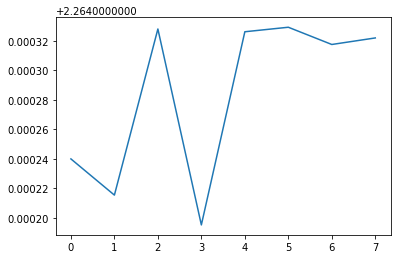

In [167]:
plt.plot(MSE_tr_s[430004].values())

In [472]:
init_val=generate_m_positive_random_numbers(9)
init_val

[43.2829101321861,
 73.67511834470821,
 20.719829082719556,
 82.28546419534294,
 38.126296784575814,
 87.42983506838219,
 96.00286619359228,
 53.753397141830725,
 92.1075252596317]

In [489]:
#optimal M values for differnt pixels:
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
# Step 1: initila mu and pi
import random
import scipy.stats as stats
import sys
import math

random.seed(1234)

M=4


#random_float_unlimited = random.uniform(a, b)

def generate_m_random_numbers(M):
    # Generate M-1 random breakpoints
    breakpoints = [random.random() for _ in range(M - 1)]

    # Sort the breakpoints along with 0 and 1
    sorted_breakpoints = sorted([0] + breakpoints + [1])

    # Calculate the differences between consecutive sorted breakpoints
    random_numbers = [
        sorted_breakpoints[i + 1] - sorted_breakpoints[i]
        for i in range(len(sorted_breakpoints) - 1)
    ]
    return random_numbers
    
def generate_m_positive_random_numbers(M):# I changed it to generate numbers greater than 1
    random_numbers = [random.uniform(1e-2, 100) for _ in range(M)]
    return random_numbers
    
def dirichlet_pdf(x, alpha):
    return stats.dirichlet.pdf(x, alpha)

def TRG_pdf(pi, x):
    dir_res=1
    power=[]
    dir_result_mean=[]
    for t in range(20):
        dir_res=0
        for i in range(N):
            pi[i,:]=np.random.dirichlet(x, size=1)
            while any(elem <= 0 for elem in pi[i,:]):
                pi[i,:]=np.random.dirichlet(x, size=1)
            dir_res=dir_res+np.log((stats.dirichlet.pdf(pi[i,:], x)))
        dir_result_mean.append(dir_res)
        power.append(np.sum(((train_data)-pi@mu)**2))
    #return np.log(np.exp(-(1/2)np.mean(power))(np.mean(dir_result_mean)) *np.exp(-0.1*np.sum(x)))
    return (-N/2*np.mean(power))+(np.mean(dir_result_mean)) +(-0.1*np.sum(x))




def func_to_optimize(mu,alpha,train_data):
    res=[]
    for t in range(20):
        pi=np.random.dirichlet(alpha, size=N)
        y_pred = np.dot(pi, mu) 
        residuals = (y_pred - train_data)**2 
        res.append(np.sum(residuals))
    return np.mean(res)


MSE_train=[]


all_samples={}
best_samples={}
M_trend_check_tr=[]
M_trend_check_te=[]
accepted_samples=[]

accepted_s_num=0

accepted_s_num_dict={}# build dict of dict to calculate stepsize:iteration:accepted values
step_list=[0.05,0.3,0.5,1,2,5,10]


target_pdf=TRG_pdf
proposal_step=1
n_samples=20



alpha_dict={}
mu_dict={}
alpha=generate_m_positive_random_numbers(M)

#mu=np.zeros(M)
#values=np.linspace(-10,10,100)
#mu=np.array(random.sample(list(values), M))
#val_list=[0,1,2,3,4,40000,40001,40002,40003,40004,130000,130001,130002,130003,130004]
#40000:4,40001:4,40002:4,40003:4,40004:4,431996:4,431997:4,431998:4,431999:4,432000:4,0:2,1:3,2:4,3:4,4:4
#val_list=[0]
#M=4


train_data=X_train.iloc[:,3]
N=train_data.shape[0]
test_data=X_test.iloc[:,3]
N_test=test_data.shape[0]

#alpha=[1,1,1,1]
#mu=[1,1,1,1]
M=2
alpha=generate_m_positive_random_numbers(M)
mu=np.zeros(M)
values=np.linspace(-10,10,100)
mu=np.array(random.sample(list(values), M))
pi=np.zeros((N,M))
MSE_train_all=[]
pi=np.zeros((N,M))


MSE_tr_s={}
MSE_te_s={}
MSE_train_trend_M={}
MSE_test_trend_M={}
alpha_s={}
mu_s={}
alpha_M={}
mu_M={}

#val_list=[0,1,2,,430002,430003,21,22,38,39]
val_list=[0]

for val in val_list:
    print(val)
    train_data=X_train.iloc[:,val]
    N=train_data.shape[0]
    test_data=X_test.iloc[:,val]
    N_test=test_data.shape[0]
    #alpha_s[val]={}
    #mu_s[val]={}
    #MSE_tr_vals[val]={}
    #MSE_te_s[val]={}
    MSE_train_trend_M={}
    MSE_test_trend_M={}
    alpha_M={}
    mu_M={}
    for M in range (2,9):
        print('M',M)
        alpha=generate_m_positive_random_numbers(M)
        mu=np.zeros(M)
        values=np.linspace(-10,10,100)
        mu=np.array(random.sample(list(values), M))
        mu=np.ones(M)
        alpha=np.ones(M)
        pi=np.zeros((N,M))
        MSE_train_all=[]
        for it in range(20):
            if it%5==0:
                print('iteration:',it)
            accepted_s_num=0
            accepted_s_num_dict[it]=accepted_s_num
                    #Step2:
            #print('mu before step2',mu)
            #print('alpha before step2',alpha)
            result = minimize(func_to_optimize, mu, args=(alpha, train_data)) 
            for m in range(M):
                mu[m]=result.x[m]
            #print('mu after opt',mu)
                    #Step3:
            sample_check={}
            current_state = alpha#x_t-1=init_state , x_t=current_state
            samples = [current_state]
            current_pdf=target_pdf(pi,current_state)
            while math.isinf(current_pdf) or any(elem <= 0 for elem in current_state):
                current_state = generate_m_positive_random_numbers(M)
                current_pdf=target_pdf(pi,current_state)
            sample_check[tuple(current_state)]=current_pdf#f(x_t)
            all_samples[tuple(current_state)]=current_pdf        
            for _ in range(n_samples):
                if (_ % 10==0):
                    #print('sample num',_)
                    pass
                            # Generate a proposal sample
                proposal = np.random.normal(loc=current_state, scale=proposal_step)#y_t
                            #print('proposal',proposal)    
                            # Ensure the proposal is within bounds (i.e.is non-negative)        
                while any(elem <= 0 for elem in proposal):
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)    
                proposal_pdf=target_pdf(pi,proposal)
                while math.isinf(proposal_pdf) :
                    proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    while any(elem <= 0 for elem in proposal):
                        proposal = np.random.normal(loc=current_state, scale=proposal_step)
                    proposal_pdf=target_pdf(pi,proposal)
                            # Calculate the acceptance ratio
                acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
                            # Decide to accept or reject the proposal
                if np.random.rand() < acceptance_ratio:
                                #print('accepted')
                    accepted_s_num+=1
                    current_state = proposal#x_t=y_t
                    current_pdf=proposal_pdf
                    sample_check[tuple(current_state)]=current_pdf
                    all_samples[tuple(current_state)]=current_pdf
                samples.append(current_state)
            accepted_s_num_dict[it]=accepted_s_num
            Highest_pdf_alpha = max(sample_check, key=sample_check.get)
            print('highest pdf was',sample_check[Highest_pdf_alpha],'for',Highest_pdf_alpha)
            best_samples[tuple(Highest_pdf_alpha)]=sample_check[Highest_pdf_alpha]
                    #return np.array(Highest_pdf_alpha)
            alpha=np.array(Highest_pdf_alpha)
                    #alpha=metropolis_hastings(target_pdf=TRG_pdf,  proposal_step=1, n_samples=5, init_state=alpha, pi=pi)
                        #print('alpha_tr',alpha,'mu_tr',mu)

            if it%10<5:
                MSE_temp=[]
                for time in range(1000):
                          #if time%1000==0:
                              #print('time in test:',time)
                    MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
                MSE_train_all.append(np.mean(MSE_temp))
            if len(MSE_train_all)>10 and np.mean(MSE_train_all[-10:-5])-np.mean(MSE_train_all[-5:])<=0.01*np.mean(MSE_train_all[-10:-5]) :
                print('converge!!!')
                break
        alpha_M[M]=alpha
        mu_M[M]=mu        
        MSE_temp=[]        
        for time in range(1000):
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N)@mu)-train_data)**2))
        MSE_train_trend_M[M]=np.mean(MSE_temp) 
        MSE_temp=[] 
        for time in range(1000):
            MSE_temp.append(np.mean(((dirichlet.rvs(alpha,N_test)@mu)-test_data)**2))   
        MSE_test_trend_M[M]=np.mean(MSE_temp)
    MSE_tr_s[val]=MSE_train_trend_M
    MSE_te_s[val]=MSE_test_trend_M
    alpha_s[val]=alpha_M
    mu_s[val]=mu_M

0
M 2
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1844.0185900432236 for (2.702489317340251, 0.016785390398941558)
highest pdf was 2134.370388894559 for (2.702489317340251, 0.016785390398941558)
highest pdf was 2127.2510412624447 for (2.702489317340251, 0.016785390398941558)
highest pdf was 2145.7944123570255 for (2.702489317340251, 0.016785390398941558)
highest pdf was 2080.7692843015525 for (2.702489317340251, 0.016785390398941558)
iteration: 5
highest pdf was 2304.548487592869 for (2.702489317340251, 0.016785390398941558)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 1877.8649401560144 for (2.702489317340251, 0.016785390398941558)
highest pdf was 2095.7992316385294 for (2.702489317340251, 0.016785390398941558)
highest pdf was 1837.0445069716873 for (2.702489317340251, 0.016785390398941558)
highest pdf was 1982.802199625344 for (2.702489317340251, 0.016785390398941558)
iteration: 10
highest pdf was 1995.9716838541729 for (2.702489317340251, 0.016785390398941558)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2199.7778066148626 for (2.702489317340251, 0.016785390398941558)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2228.449041525407 for (2.702489317340251, 0.016785390398941558)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2865.414071215496 for (1.5739686462964901, 0.014564265061006387)
highest pdf was 2695.3455767332434 for (1.5739686462964901, 0.014564265061006387)
iteration: 15
highest pdf was 3290.257568865437 for (1.5739686462964901, 0.014564265061006387)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 3063.5270415188133 for (1.5739686462964901, 0.014564265061006387)
highest pdf was 2912.7859479060035 for (1.5739686462964901, 0.014564265061006387)
highest pdf was 3102.6640590917887 for (1.5739686462964901, 0.014564265061006387)
highest pdf was 2954.348510935358 for (1.5739686462964901, 0.014564265061006387)
M 3
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5459.272806271584 for (0.37368963809775346, 0.2222846805883782, 0.011003139997566056)
highest pdf was 5745.361983956736 for (0.37368963809775346, 0.2222846805883782, 0.011003139997566056)
highest pdf was 5578.020592560073 for (0.37368963809775346, 0.2222846805883782, 0.011003139997566056)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5326.806692003554 for (0.37368963809775346, 0.2222846805883782, 0.011003139997566056)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3997.037685408744 for (47.22419239269671, 1.0929267654154837, 72.52730307098464)
iteration: 5
highest pdf was -3645.4589094356165 for (47.21798600363394, 0.23989189811001696, 75.90197939724291)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2275.8299585891286 for (45.458907499691335, 0.05967018333950078, 75.36133227295755)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 644.0630433750102 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
highest pdf was 438.1721725383987 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
highest pdf was 630.8836221596284 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
iteration: 10
highest pdf was 535.1223981298263 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
highest pdf was 638.1001661815408 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
highest pdf was 574.5452007858885 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5024.610180131241 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5040.1804403341075 for (44.811232698639664, 0.02415641595650258, 75.77486199839727)
iteration: 15


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 6787.2975857131505 for (45.256368274465, 0.017056773487604766, 75.21379103622182)
highest pdf was 7160.56701683218 for (45.256368274465, 0.017056773487604766, 75.21379103622182)
highest pdf was 7337.880057754783 for (45.256368274465, 0.017056773487604766, 75.21379103622182)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 7188.814646236049 for (45.256368274465, 0.017056773487604766, 75.21379103622182)
highest pdf was 7248.075431623677 for (45.256368274465, 0.017056773487604766, 75.21379103622182)
M 4
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1355.7950798335787 for (0.01950365674931462, 2.315972910638945, 2.439623374533719, 2.614871297130914)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2538.42939807058 for (0.2254354369398933, 0.017717490419994153, 5.729072603616904, 3.053956348155736)
highest pdf was 2471.4383166347084 for (0.2254354369398933, 0.017717490419994153, 5.729072603616904, 3.053956348155736)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3777.0734913872598 for (1.8124489651196587, 0.014286104481327978, 5.995977800110892, 3.022748945645638)
highest pdf was 3533.484582331262 for (1.8124489651196587, 0.014286104481327978, 5.995977800110892, 3.022748945645638)
iteration: 5
highest pdf was 3686.3406639257314 for (1.8124489651196587, 0.014286104481327978, 5.995977800110892, 3.022748945645638)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 7325.620205533744 for (1.9339436196371365, 0.010064762831026223, 6.37748306396036, 1.7787477300546148)
highest pdf was 6759.235778493354 for (1.9339436196371365, 0.010064762831026223, 6.37748306396036, 1.7787477300546148)
highest pdf was 6905.961758763453 for (1.9339436196371365, 0.010064762831026223, 6.37748306396036, 1.7787477300546148)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3753.874172628856 for (59.319757045758465, 1.557568234423901, 57.31200082538428, 24.669023971358364)
iteration: 10


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1973.3802393020628 for (62.90288038773699, 0.05933821571044055, 55.81782508000778, 26.066222671093755)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2464.313851572188 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2384.89149603732 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2597.465683622661 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2625.8158890783884 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
iteration: 15
highest pdf was 2591.2269987549485 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2609.386275860655 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2464.965382932259 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2467.2191904333417 for (62.77619181621125, 0.017836143724871925, 55.352052410218114, 25.96820427655333)
highest pdf was 2567.20173859907

C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -3143.9515091157314 for (3.8141895839449274, 0.14701269193148514, 3.507816399631299, 0.21796370055208458, 0.6704476118885014)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2914.2569055606905 for (4.665174616441144, 0.016115286415323227, 3.6110524949714637, 0.9101963549444794, 0.9948363961213937)
highest pdf was 2765.4782160321124 for (4.665174616441144, 0.016115286415323227, 3.6110524949714637, 0.9101963549444794, 0.9948363961213937)
highest pdf was 2743.997663198484 for (4.665174616441144, 0.016115286415323227, 3.6110524949714637, 0.9101963549444794, 0.9948363961213937)
highest pdf was 3451.0645563025596 for (6.510241616787276, 0.014342689806448265, 3.0304244103924693, 1.7951021566963101, 1.0041284157453858)
iteration: 5
highest pdf was 3796.0969219094018 for (6.510241616787276, 0.014342689806448265, 3.0304244103924693, 1.7951021566963101, 1.0041284157453858)
highest pdf was 3898.4994392329068 for (6.510241616787276, 0.014342689806448265, 3.0304244103924693, 1.7951021566963101, 1.0041284157453858)
highest pdf was 3812.174170345527 for (6.510241616787276, 0.014342689806448265, 3.0304244103924693, 1.7951021566963101, 1.0041284157453858)
hi

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4659.06343677081 for (6.35744960239905, 0.013237591343787486, 4.271085720335026, 2.6029170705418787, 0.9829562357810039)
highest pdf was 4326.781234658399 for (6.35744960239905, 0.013237591343787486, 4.271085720335026, 2.6029170705418787, 0.9829562357810039)
highest pdf was 4397.469648480596 for (6.35744960239905, 0.013237591343787486, 4.271085720335026, 2.6029170705418787, 0.9829562357810039)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 4223.924134115091 for (6.35744960239905, 0.013237591343787486, 4.271085720335026, 2.6029170705418787, 0.9829562357810039)
highest pdf was 4362.65254865515 for (6.35744960239905, 0.013237591343787486, 4.271085720335026, 2.6029170705418787, 0.9829562357810039)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -3291.29355200638 for (92.62488608306, 1.1532090025525226, 34.93906804404619, 71.44930264277441, 62.05614960508315)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -2691.4835952902213 for (93.16172403631703, 0.1457916726408628, 35.45580465621393, 68.8153183191215, 61.56062532022218)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 16.57372646365944 for (93.70236377482838, 0.032821124315335265, 33.38692855845796, 68.79512832357705, 61.281834621293804)
M 6
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -2300.4770748618257 for (3.7502135302075312, 0.07870365234690135, 2.8058014068080572, 5.551440829644554, 0.25822098579071756, 1.6862070805847877)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3973.584230917499 for (4.165385885622694, 0.9188464409273954, 1.7429924665483274, 5.302631088471879, 0.014011575306620113, 0.9029745831651221)
highest pdf was 4191.8968936823585 for (4.165385885622694, 0.9188464409273954, 1.7429924665483274, 5.302631088471879, 0.014011575306620113, 0.9029745831651221)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5833.461955482399 for (3.6793985749234794, 0.012005540148274263, 1.7054526997199329, 7.171468074972174, 1.239267358737436, 2.0532896261040197)
highest pdf was 5785.775619561398 for (3.6793985749234794, 0.012005540148274263, 1.7054526997199329, 7.171468074972174, 1.239267358737436, 2.0532896261040197)
iteration: 5
highest pdf was 5513.082962257815 for (3.6793985749234794, 0.012005540148274263, 1.7054526997199329, 7.171468074972174, 1.239267358737436, 2.0532896261040197)
highest pdf was 6180.038578438933 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)
highest pdf was 6370.472927793416 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6257.438192849185 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)
highest pdf was 6385.380952128493 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)
iteration: 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 6658.298436485207 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5820.561561327134 for (3.16195792080267, 0.011230163528116864, 3.0693569895933694, 7.4478357549484855, 3.3453335433317695, 1.7865068169681724)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1818.0482865758538 for (29.83366131136348, 0.07964952902946583, 27.171991428176938, 81.08625701126172, 17.294536155029935, 17.41292260216033)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -857.7719423876149 for (29.156272063549114, 0.04800786627863321, 27.3404901789688, 80.48218911478884, 19.372109065061522, 16.775847039314478)
highest pdf was -963.9812404642723 for (29.156272063549114, 0.04800786627863321, 27.3404901789688, 80.48218911478884, 19.372109065061522, 16.775847039314478)
iteration: 15


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 2171.1659619381576 for (28.369949221408486, 0.021068307252942578, 28.66360167781608, 80.09159606528031, 19.20870311730252, 16.529572524098736)
highest pdf was 2413.515226738655 for (28.369949221408486, 0.021068307252942578, 28.66360167781608, 80.09159606528031, 19.20870311730252, 16.529572524098736)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2089.6747185738263 for (28.369949221408486, 0.021068307252942578, 28.66360167781608, 80.09159606528031, 19.20870311730252, 16.529572524098736)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2347.764193987033 for (28.369949221408486, 0.021068307252942578, 28.66360167781608, 80.09159606528031, 19.20870311730252, 16.529572524098736)
highest pdf was 2259.1880464984574 for (28.369949221408486, 0.021068307252942578, 28.66360167781608, 80.09159606528031, 19.20870311730252, 16.529572524098736)
M 7
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3050.766780934939 for (2.573822315204394, 2.245309097371752, 0.4676250166754245, 0.017192719677653567, 2.1990258227307646, 0.6864250746771583, 5.53460520808613)
highest pdf was 2906.771349975999 for (2.573822315204394, 2.245309097371752, 0.4676250166754245, 0.017192719677653567, 2.1990258227307646, 0.6864250746771583, 5.53460520808613)
highest pdf was 2858.8589298343973 for (2.573822315204394, 2.245309097371752, 0.4676250166754245, 0.017192719677653567, 2.1990258227307646, 0.6864250746771583, 5.53460520808613)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 5212.240299219406 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5709.37241705497 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
iteration: 5


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5421.02093532095 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5357.599129209586 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
highest pdf was 5454.768356536859 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
highest pdf was 5292.152480124913 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
highest pdf was 5331.057970266069 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
iteration: 10
highest pdf was 5259.822020464051 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)
highest pdf was 5204.973790932566 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38

C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 5410.339077982149 for (2.647548403569487, 2.1044834870654254, 0.012725425498608, 0.38007876069788177, 2.4247491978920164, 0.7693860374933799, 5.052332681981566)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -2693.094080096356 for (77.54126543696935, 81.43417932060476, 33.25648431251156, 10.325114027702467, 22.58168667312094, 46.28129461508608, 7.070926377692102)
iteration: 15
highest pdf was -1963.91862907962 for (78.80806739651474, 82.34503986005193, 33.22910863581151, 10.420466727274945, 24.682306393008748, 46.76039915797597, 0.154955284724986)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 3496.859356294954 for (78.4293894366456, 81.51115617461046, 34.09634078599016, 10.265302034111896, 25.39768415845462, 46.86170030488911, 0.018416238427866882)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 8413.173097494195 for (80.02849707095629, 83.12643734685429, 34.529605850711306, 9.761747261078268, 25.996599142552107, 46.584711590439824, 0.010332165937883662)
highest pdf was 8564.44066495683 for (80.02849707095629, 83.12643734685429, 34.529605850711306, 9.761747261078268, 25.996599142552107, 46.584711590439824, 0.010332165937883662)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -2662.4970931959565 for (50.32256523486091, 81.02573373057787, 49.643194785353415, 83.11022520964644, 64.8830145854972, 64.4073143782287, 34.886676980736276)
M 8
iteration: 0


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was -1380.8844821992102 for (0.47558189668581774, 5.073494211082918, 2.458373702858817, 3.826721042601071, 4.0139852999272225, 0.05497609599968242, 2.4120781623293817, 2.2044599456051683)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)
C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2389.0105475406854 for (1.145545272429537, 5.116758646192053, 1.2979264523653915, 2.960923268761069, 2.7879895918081345, 0.17144646936694524, 1.1040908292402374, 0.020983767152120247)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was 2265.162538365141 for (1.145545272429537, 5.116758646192053, 1.2979264523653915, 2.960923268761069, 2.7879895918081345, 0.17144646936694524, 1.1040908292402374, 0.020983767152120247)
highest pdf was 2401.5676281419437 for (1.145545272429537, 5.116758646192053, 1.2979264523653915, 2.960923268761069, 2.7879895918081345, 0.17144646936694524, 1.1040908292402374, 0.020983767152120247)


C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 12135.03271594193 for (1.0274621948685625, 5.200615683586526, 1.3551354577760617, 2.5823276921071, 2.7476938418790433, 0.0074545314691777664, 0.6414343599498353, 0.6122183916060957)
iteration: 5
highest pdf was 11422.93745102823 for (1.0274621948685625, 5.200615683586526, 1.3551354577760617, 2.5823276921071, 2.7476938418790433, 0.0074545314691777664, 0.6414343599498353, 0.6122183916060957)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -2191.488003537813 for (84.22147476026218, 20.91512615683401, 84.28415874263459, 78.66061369021266, 94.45783609625107, 96.90853397298277, 32.641920498677905, 45.750245729683066)
highest pdf was -2183.68368687597 for (83.3518746429407, 19.904443445403118, 85.79541786829549, 77.99698127129253, 98.70462869080858, 95.56260109616315, 31.955398001540537, 47.17862702077098)
highest pdf was -2164.314526309183 for (84.04360367875549, 16.03999558375081, 90.20675020765911, 84.13981157519989, 98.16959603213782, 96.55665096008612, 28.74348513749978, 48.08779489937503)
highest pdf was -2126.29152407177 for (91.25259363384278, 7.196758901533233, 87.30152547359718, 80.4374493771795, 100.28546712179624, 99.74093202336596, 29.30060164761623, 49.91883628157986)
iteration: 10


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


highest pdf was -1777.1551747059502 for (94.46698748926781, 0.3469011935217843, 90.58076016438788, 77.54222317491941, 99.40034173404405, 100.40014359240595, 27.591456222633045, 47.79712715068166)


C:\Users\omidl\anaconda3\lib\site-packages\scipy\stats\_multivariate.py:1467: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))
C:\Users\omidl\AppData\Local\Temp/ipykernel_12820/996892715.py:192: RuntimeWarning: overflow encountered in exp
  acceptance_ratio=np.exp(proposal_pdf-current_pdf)#f(y_t)/f(x_t)


highest pdf was 1960.0663771379468 for (91.7632670509694, 0.027164293531722727, 89.3472021915581, 74.80256380400816, 97.25018441664227, 99.73397431665241, 27.30543504860998, 52.16484845207741)
highest pdf was 2002.8336873891676 for (91.7632670509694, 0.027164293531722727, 89.3472021915581, 74.80256380400816, 97.25018441664227, 99.73397431665241, 27.30543504860998, 52.16484845207741)
highest pdf was 1923.5411939373807 for (91.7632670509694, 0.027164293531722727, 89.3472021915581, 74.80256380400816, 97.25018441664227, 99.73397431665241, 27.30543504860998, 52.16484845207741)
highest pdf was 1933.1531025277245 for (91.7632670509694, 0.027164293531722727, 89.3472021915581, 74.80256380400816, 97.25018441664227, 99.73397431665241, 27.30543504860998, 52.16484845207741)
iteration: 15
highest pdf was 2028.6498264387292 for (91.7632670509694, 0.027164293531722727, 89.3472021915581, 74.80256380400816, 97.25018441664227, 99.73397431665241, 27.30543504860998, 52.16484845207741)
highest pdf was 1947.

In [501]:
alpha_s[0]

{0: {2: array([1.57396865, 0.01456427]),
  3: array([4.52563683e+01, 1.70567735e-02, 7.52137910e+01]),
  4: array([6.27761918e+01, 1.78361437e-02, 5.53520524e+01, 2.59682043e+01]),
  5: array([9.37023638e+01, 3.28211243e-02, 3.33869286e+01, 6.87951283e+01,
         6.12818346e+01]),
  6: array([2.83699492e+01, 2.10683073e-02, 2.86636017e+01, 8.00915961e+01,
         1.92087031e+01, 1.65295725e+01]),
  7: array([50.32256523, 81.02573373, 49.64319479, 83.11022521, 64.88301459,
         64.40731438, 34.88667698]),
  8: array([9.21459877e+01, 2.64272603e-02, 9.20888252e+01, 7.50002128e+01,
         1.00317827e+02, 1.00625384e+02, 2.80371292e+01, 5.29633151e+01])}}

In [502]:
mu_s

{0: {2: array([0.99974268, 0.99994943]),
  3: array([0.50808462, 0.26032096, 0.11826286]),
  4: array([0.99999083, 1.00000046, 0.99996569, 0.99999029]),
  5: array([0.99915944, 1.00012773, 0.99978232, 1.00000194, 0.99988357]),
  6: array([0.99963563, 1.00009715, 0.99936233, 0.9992882 , 0.99990002,
         0.99959356]),
  7: array([0.99849908, 0.99805494, 0.99826847, 0.9984125 , 1.00006825,
         0.99846751, 0.99874195]),
  8: array([1., 1., 1., 1., 1., 1., 1., 1.])}}

In [492]:
MSE_te_s

{0: {2: 0.6208241944508633,
  3: 0.008042058295108071,
  4: 0.621195337170037,
  5: 0.6206571065579324,
  6: 0.6203696081322706,
  7: 0.6190675618067034,
  8: 0.6212250294066533}}

In [491]:
MSE_tr_s

{0: {2: 0.6535387634476026,
  3: 0.01430718755339041,
  4: 0.6539185380307923,
  5: 0.6533684793704406,
  6: 0.6530736993100884,
  7: 0.6517420450414027,
  8: 0.6539489163394528}}

In [253]:
MSE_tr_vals={}
MSE_temp={}
for i in range(3):
    for j in range (10,12):
        MSE_temp[j]=j*i
    print(MSE_temp)
    MSE_tr_vals[i]=MSE_temp
    print(MSE_tr_vals)

{10: 0, 11: 0}
{0: {10: 0, 11: 0}}
{10: 10, 11: 11}
{0: {10: 10, 11: 11}, 1: {10: 10, 11: 11}}
{10: 20, 11: 22}
{0: {10: 20, 11: 22}, 1: {10: 20, 11: 22}, 2: {10: 20, 11: 22}}


In [254]:
MSE_tr_vals = {}
for i in range(3):
    MSE_temp = {}
    for j in range(10, 12):
        MSE_temp[j] = j * i
    print(MSE_temp)
    MSE_tr_vals[i] = MSE_temp
    print(MSE_tr_vals)


{10: 0, 11: 0}
{0: {10: 0, 11: 0}}
{10: 10, 11: 11}
{0: {10: 0, 11: 0}, 1: {10: 10, 11: 11}}
{10: 20, 11: 22}
{0: {10: 0, 11: 0}, 1: {10: 10, 11: 11}, 2: {10: 20, 11: 22}}


In [476]:
alpha_s

{21: {2: array([82.65127115,  2.2583922 ]),
  3: array([30.30378501,  0.67583945, 72.17007314]),
  4: array([61.35222035, 36.55931361, 68.60271929, 51.82719806]),
  5: array([64.10940852, 52.01707993, 65.11236833, 43.38280063, 60.97052362]),
  6: array([76.74734402, 42.94099716, 68.34411668, 61.23813481, 51.28571488,
         37.39650431]),
  7: array([72.14996739, 51.94358819, 67.5302529 , 72.23733562, 63.97830086,
         65.60032306, 67.63485052]),
  8: array([74.89490767, 52.13448715, 64.80570879, 71.03903327, 62.8627415 ,
         59.28919044, 65.72572458, 71.67810885])},
 22: {2: array([104.27457167,  19.97426832]),
  3: array([66.36786664, 18.29959083, 73.06074163]),
  4: array([52.67039365, 41.07595278, 75.39482459, 36.55939   ]),
  5: array([47.66836019, 27.49253103, 80.24212532, 44.91768773, 53.71290787]),
  6: array([86.1573651 , 41.58973325, 68.04644285, 49.56205192, 78.04064347,
         72.43709506]),
  7: array([71.31274529, 57.5500421 , 78.41882357, 74.95589526, 76.470

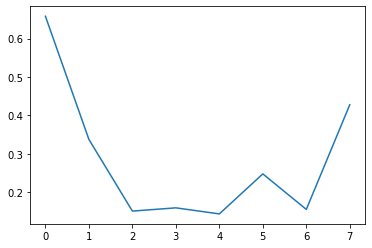

In [211]:
plt.plot(MSE_tr_s[40000].values())

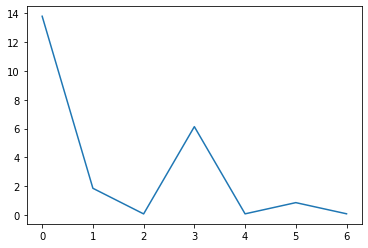

In [446]:
plt.plot(MSE_te_s[40004].values())

KeyError: 40004

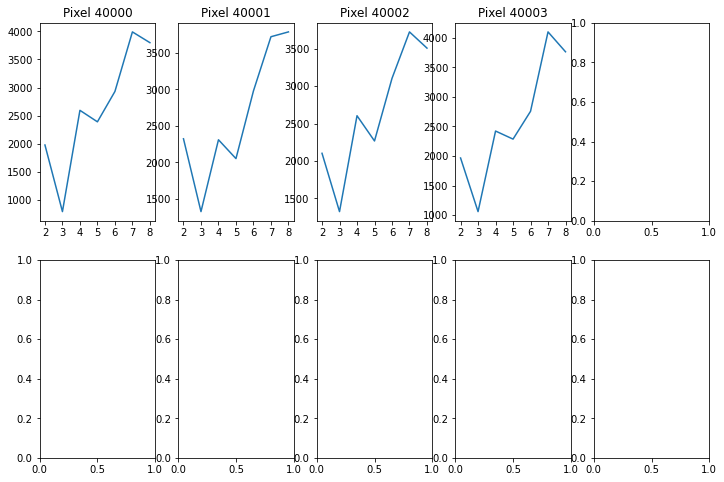

In [474]:


# Create a 5x2 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(12, 8))

# Define the x-axis values
x = [2, 3, 4, 5, 6, 7, 8]
default_x_ticks = range(len(x))

# Plot the data in each subplot
axs[0, 0].plot(default_x_ticks, MSE_tr_s[21].values())
axs[0, 0].set_title('Pixel 40000')
axs[0, 0].set_xticks(default_x_ticks)
axs[0, 0].set_xticklabels([2, 3, 4, 5, 6, 7, 8])

axs[0, 1].plot(default_x_ticks, MSE_tr_s[22].values())
axs[0, 1].set_title('Pixel 40001')
axs[0, 1].set_xticks(default_x_ticks)
axs[0, 1].set_xticklabels(x)

axs[0, 2].plot(default_x_ticks, MSE_tr_s[38].values())
axs[0, 2].set_title('Pixel 40002')
axs[0, 2].set_xticks(default_x_ticks)
axs[0, 2].set_xticklabels(x)

axs[0, 3].plot(default_x_ticks, MSE_tr_s[39].values())
axs[0, 3].set_title('Pixel 40003')
axs[0, 3].set_xticks(default_x_ticks)
axs[0, 3].set_xticklabels(x)

axs[0, 4].plot(default_x_ticks, MSE_tr_s[40004].values())
axs[0, 4].set_title('Pixel 40004')
axs[0, 4].set_xticks(default_x_ticks)
axs[0, 4].set_xticklabels(x)

axs[1, 0].plot(default_x_ticks, MSE_tr_s[430000].values())
axs[1, 0].set_title('Pixel 430000')
axs[1, 0].set_xticks(default_x_ticks)
axs[1, 0].set_xticklabels(x)

axs[1, 1].plot(default_x_ticks, MSE_tr_s[430001].values())
axs[1, 1].set_title('Pixel 430001')
axs[1, 1].set_xticks(default_x_ticks)
axs[1, 1].set_xticklabels(x)

axs[1, 2].plot(default_x_ticks, MSE_tr_s[430002].values())
axs[1, 2].set_title('Pixel 430002')
axs[1, 2].set_xticks(default_x_ticks)
axs[1, 2].set_xticklabels(x)

axs[1, 3].plot(default_x_ticks, MSE_tr_s[430003].values())
axs[1, 3].set_title('Pixel 430003')
axs[1, 3].set_xticks(default_x_ticks)
axs[1, 3].set_xticklabels(x)

axs[1, 4].plot(default_x_ticks, MSE_tr_s[430004].values())
axs[1, 4].set_title('Pixel 430004')
axs[1, 4].set_xticks(default_x_ticks)
axs[1, 4].set_xticklabels(x)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [59]:
MSE_tr_s = {
    40000: {
        2: 43.48702196,
        3: 10.84971773,
        4: 4.153537426,
        5: 1.289606282,
        6: 3.604130428,
        7: 0.22918223,
        8: 0.616740776
    },
    40001: {
        2: 8.45607405,
        3: 0.11309876,
        4: 0.318525018,
        5: 0.103743663,
        6: 0.066480057,
        7: 0.070604244,
        8: 5.370402613
    },
    40002: {
        2: 1.227064762,
        3: 35.05804268,
        4: 0.088537758,
        5: 0.105433313,
        6: 0.040039208,
        7: 0.064174432,
        8: 0.495045003
    },
    40003: {
        2: 0.063143095,
        3: 2.140599108,
        4: 0.17746684,
        5: 2.813782218,
        6: 0.106139818,
        7: 0.141724809,
        8: 0.080721521
    },
    40004: {
        2: 13.79035854,
        3: 1.852498579,
        4: 0.076552131,
        5: 6.134731607,
        6: 0.081846453,
        7: 0.866434975,
        8: 0.086179819
    },
    430000: {
        2: 8.844047431,
        3: 0.205558298,
        4: 33.01407931,
        5: 0.19778418,
        6: 0.153044659,
        7: 0.06212397,
        8: 3.858073394
    },
    430001: {
        2: 0.018325254,
        3: 38.26615132,
        4: 13.9018314,
        5: 0.022523764,
        6: 0.0718873,
        7: 0.0961152,
        8: 0.13770667
    },
    430002: {
        2: 0.261503149,
        3: 0.292099796,
        4: 3.337178216,
        5: 0.122259044,
        6: 0.888985301,
        7: 2.467733529,
        8: 5.124817312
    },
    430003: {
        2: 0.332432804,
        3: 23.0402396,
        4: 0.378855096,
        5: 0.14529374,
        6: 0.123258172,
        7: 0.296908236,
        8: 0.088782648
    },
    430004: {
        2: 0.170438069,
        3: 0.440099242,
        4: 9.402765135,
        5: 0.205419021,
        6: 13.00201731,
        7: 0.130628932,
        8: 0.078537771
    }
}


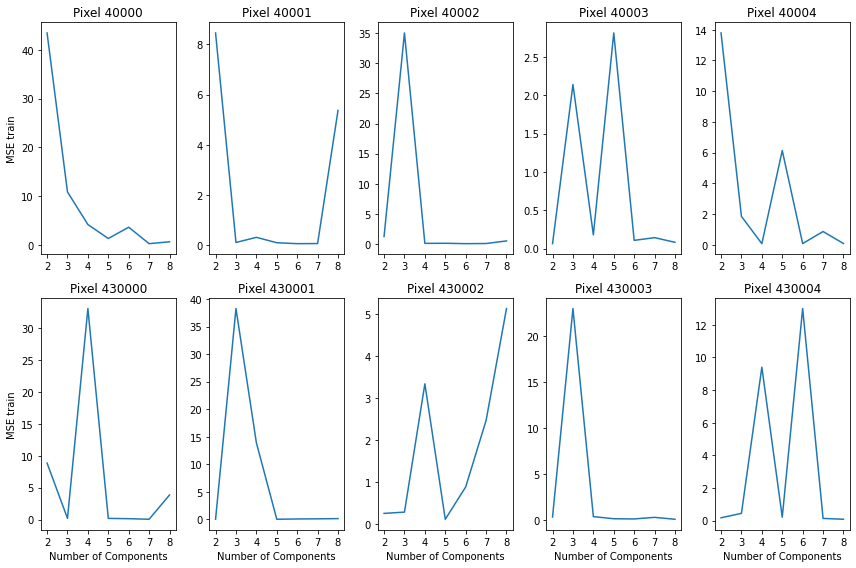

In [64]:


# Create a 5x2 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(12, 8))

# Define the x-axis values
x = [2, 3, 4, 5, 6, 7, 8]
default_x_ticks = range(len(x))

# Plot the data in each subplot
axs[0, 0].plot(default_x_ticks, MSE_tr_s[40000].values())
axs[0, 0].set_title('Pixel 40000')
axs[0, 0].set_xticks(default_x_ticks)
axs[0, 0].set_xticklabels([2, 3, 4, 5, 6, 7, 8])
#axs[0, 0].set_xlabel('Number of Components')
axs[0, 0].set_ylabel('MSE train')

axs[0, 1].plot(default_x_ticks, MSE_tr_s[40001].values())
axs[0, 1].set_title('Pixel 40001')
axs[0, 1].set_xticks(default_x_ticks)
axs[0, 1].set_xticklabels(x)
#axs[0, 1].set_xlabel('Number of Components')
#axs[0, 1].set_ylabel('MSE train')

axs[0, 2].plot(default_x_ticks, MSE_tr_s[40002].values())
axs[0, 2].set_title('Pixel 40002')
axs[0, 2].set_xticks(default_x_ticks)
axs[0, 2].set_xticklabels(x)
#axs[0, 2].set_xlabel('Number of Components')
#axs[0, 2].set_ylabel('MSE train')

axs[0, 3].plot(default_x_ticks, MSE_tr_s[40003].values())
axs[0, 3].set_title('Pixel 40003')
axs[0, 3].set_xticks(default_x_ticks)
axs[0, 3].set_xticklabels(x)
#axs[0, 0].set_xlabel('Number of Components')
#axs[0, 0].set_ylabel('MSE train')

axs[0, 4].plot(default_x_ticks, MSE_tr_s[40004].values())
axs[0, 4].set_title('Pixel 40004')
axs[0, 4].set_xticks(default_x_ticks)
axs[0, 4].set_xticklabels(x)
#axs[0, 0].set_xlabel('Number of Components')
#axs[0, 0].set_ylabel('MSE train')

axs[1, 0].plot(default_x_ticks, MSE_tr_s[430000].values())
axs[1, 0].set_title('Pixel 430000')
axs[1, 0].set_xticks(default_x_ticks)
axs[1, 0].set_xticklabels(x)
axs[1, 0].set_xlabel('Number of Components')
axs[1, 0].set_ylabel('MSE train')

axs[1, 1].plot(default_x_ticks, MSE_tr_s[430001].values())
axs[1, 1].set_title('Pixel 430001')
axs[1, 1].set_xticks(default_x_ticks)
axs[1, 1].set_xticklabels(x)
axs[1, 1].set_xlabel('Number of Components')
#axs[0, 0].set_ylabel('MSE train')

axs[1, 2].plot(default_x_ticks, MSE_tr_s[430002].values())
axs[1, 2].set_title('Pixel 430002')
axs[1, 2].set_xticks(default_x_ticks)
axs[1, 2].set_xticklabels(x)
axs[1, 2].set_xlabel('Number of Components')
#axs[0, 0].set_ylabel('MSE train')

axs[1, 3].plot(default_x_ticks, MSE_tr_s[430003].values())
axs[1, 3].set_title('Pixel 430003')
axs[1, 3].set_xticks(default_x_ticks)
axs[1, 3].set_xticklabels(x)
axs[1, 3].set_xlabel('Number of Components')
#axs[0, 0].set_ylabel('MSE train')

axs[1, 4].plot(default_x_ticks, MSE_tr_s[430004].values())
axs[1, 4].set_title('Pixel 430004')
axs[1, 4].set_xticks(default_x_ticks)
axs[1, 4].set_xticklabels(x)
axs[1, 4].set_xlabel('Number of Components')
#axs[1, 4].set_ylabel('MSE train')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
#plt.show()
plt.savefig('MSEtenpix')

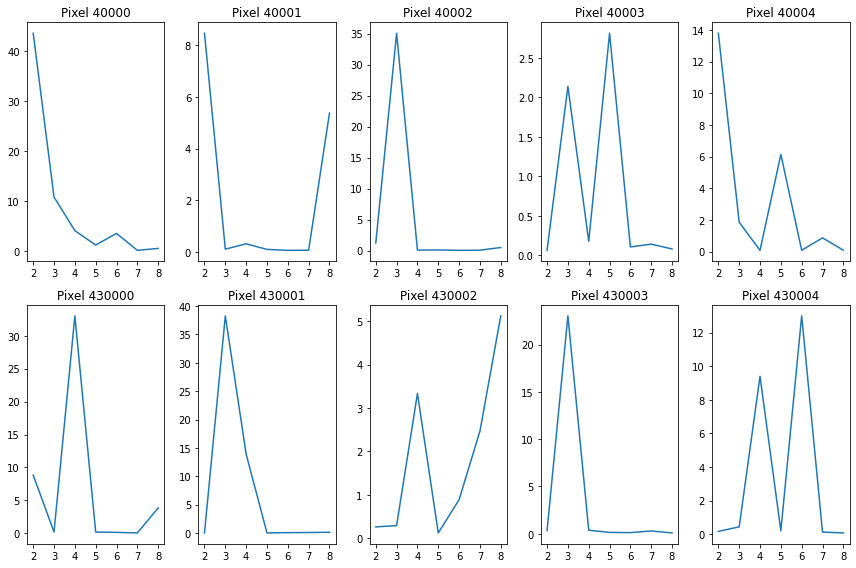

In [324]:


# Create a 5x2 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(12, 8))

# Define the x-axis values
x = [2, 3, 4, 5, 6, 7, 8]
default_x_ticks = range(len(x))

# Plot the data in each subplot
axs[0, 0].plot(default_x_ticks, MSE_tr_s[40000].values())
axs[0, 0].set_title('Pixel 40000')
axs[0, 0].set_xticks(default_x_ticks)
axs[0, 0].set_xticklabels([2, 3, 4, 5, 6, 7, 8])

axs[0, 1].plot(default_x_ticks, MSE_tr_s[40001].values())
axs[0, 1].set_title('Pixel 40001')
axs[0, 1].set_xticks(default_x_ticks)
axs[0, 1].set_xticklabels(x)

axs[0, 2].plot(default_x_ticks, MSE_tr_s[40002].values())
axs[0, 2].set_title('Pixel 40002')
axs[0, 2].set_xticks(default_x_ticks)
axs[0, 2].set_xticklabels(x)

axs[0, 3].plot(default_x_ticks, MSE_tr_s[40003].values())
axs[0, 3].set_title('Pixel 40003')
axs[0, 3].set_xticks(default_x_ticks)
axs[0, 3].set_xticklabels(x)

axs[0, 4].plot(default_x_ticks, MSE_tr_s[40004].values())
axs[0, 4].set_title('Pixel 40004')
axs[0, 4].set_xticks(default_x_ticks)
axs[0, 4].set_xticklabels(x)

axs[1, 0].plot(default_x_ticks, MSE_tr_s[430000].values())
axs[1, 0].set_title('Pixel 430000')
axs[1, 0].set_xticks(default_x_ticks)
axs[1, 0].set_xticklabels(x)

axs[1, 1].plot(default_x_ticks, MSE_tr_s[430001].values())
axs[1, 1].set_title('Pixel 430001')
axs[1, 1].set_xticks(default_x_ticks)
axs[1, 1].set_xticklabels(x)

axs[1, 2].plot(default_x_ticks, MSE_tr_s[430002].values())
axs[1, 2].set_title('Pixel 430002')
axs[1, 2].set_xticks(default_x_ticks)
axs[1, 2].set_xticklabels(x)

axs[1, 3].plot(default_x_ticks, MSE_tr_s[430003].values())
axs[1, 3].set_title('Pixel 430003')
axs[1, 3].set_xticks(default_x_ticks)
axs[1, 3].set_xticklabels(x)

axs[1, 4].plot(default_x_ticks, MSE_tr_s[430004].values())
axs[1, 4].set_title('Pixel 430004')
axs[1, 4].set_xticks(default_x_ticks)
axs[1, 4].set_xticklabels(x)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [327]:
mu_s[40001]

{2: array([-2.92930393, -6.96947419]),
 3: array([ 3.53539701, -7.37370931,  2.52520805]),
 4: array([-7.37358297,  7.97991171, -5.95945166,  4.94950009]),
 5: array([ 1.51520772,  8.58587447, -8.18174466, -7.97968079,  0.1010802 ]),
 6: array([ 7.97989276, -1.9191051 , -2.12120716,  1.71718217, -8.38378091,
         4.94951964]),
 7: array([ 2.92929297, -3.93938693, -0.70707826, -4.74755291,  3.13129248,
         7.97979235,  0.7069776 ]),
 8: array([-1.515167  , -6.56566966, -6.76762005, -8.78785957,  5.95964032,
        -5.75755086, -6.36363956,  3.93942754])}

optimal M:
[40000,40001,40002,40003,40004,430000,430001,430002,430003,430004]
- 40000:M=5 ,40001:3, 40002: 4 , 40003: 6, 40004: 6,430000:5 ,430001:5 ,430002:5 ,430003:4 ,430004:7

In [325]:
mu_s[40000][5]

array([-8.98983355, -3.13121282,  4.3435314 , -8.38378733,  6.56570102])

In [332]:
alpha_s[40000][5]

array([36.56190339, 81.55527156, 39.02067554, 41.06409169, 72.01630808])

In [348]:
df_mu=pd.DataFrame({'Pixel 40000': pd.Series(mu_s[40000][5]),
     'Pixel 40001': pd.Series(mu_s[40001][3]),
     'Pixel 40002': pd.Series(mu_s[40002][4]),
     'Pixel 40003': pd.Series(mu_s[40003][6]),
     'Pixel 40004': pd.Series(mu_s[40004][6]),
    'Pixel 430000': pd.Series(mu_s[430000][5]),
    'Pixel 430001': pd.Series(mu_s[430001][5]),
    'Pixel 430002': pd.Series(mu_s[430002][5]),
    'Pixel 430003': pd.Series(mu_s[430003][4]),
    'Pixel 430004': pd.Series(mu_s[430004][7]),
    }).T.fillna(0)
df_mu

0         1         2         3          4         5  \
Pixel 40000  -8.989834 -3.131213  4.343531 -8.383787   6.565701  0.000000   
Pixel 40001   3.535397 -7.373709  2.525208  0.000000   0.000000  0.000000   
Pixel 40002  -0.302997 -2.929244  3.737452  6.161650   0.000000  0.000000   
Pixel 40003   1.111121  3.131305 -8.383826  9.595975  -2.121219 -3.333309   
Pixel 40004   5.151536 -0.505012  0.707129 -5.555553  -8.181789  6.363644   
Pixel 430000 -7.373697  8.383898  7.373779  3.535426   0.303077  0.000000   
Pixel 430001  0.707102  2.929282 -1.313005  3.333391  -3.131218  0.000000   
Pixel 430002 -6.161524  6.161670  4.343494 -2.929294  -6.363600  0.000000   
Pixel 430003  8.787835  3.333275 -9.595791 -8.989909   0.000000  0.000000   
Pixel 430004  3.333346  9.798022 -3.737318 -7.575690  10.000044 -2.323215   

                     6  
Pixel 40000   0.000000  
Pixel 40001   0.000000  
Pixel 40002   0.000000  
Pixel 40003   0.000000  
Pixel 40004   0.000000  
Pixel 430000  0.000000  
Pixel 430001  0.000000  
Pixel 430002  0.000000  
Pixel 430003  0.000000  
Pixel 430004 -9.595896

In [346]:
df_alpha=pd.DataFrame({'Pixel 40000': pd.Series(alpha_s[40000][5]),
     'Pixel 40001': pd.Series(sorted(alpha_s[40001][3])),
     'Pixel 40002': pd.Series(sorted(alpha_s[40002][4])),
     'Pixel 40003': pd.Series(sorted(alpha_s[40003][6])),
     'Pixel 40004': pd.Series(sorted(alpha_s[40004][6])),
    'Pixel 430000': pd.Series(sorted(alpha_s[430000][5])),
    'Pixel 430001': pd.Series(sorted(alpha_s[430001][5])),
    'Pixel 430002': pd.Series(sorted(alpha_s[430002][5])),
    'Pixel 430003': pd.Series(sorted(alpha_s[430003][4])),
    'Pixel 430004': pd.Series(sorted(alpha_s[430004][7])),
    }).T.fillna(0)
df_alpha

0          1          2          3           4  \
Pixel 40000   36.561903  81.555272  39.020676  41.064092   72.016308   
Pixel 40001   60.557274  65.997525  81.003996   0.000000    0.000000   
Pixel 40002    0.053329  44.898962  49.378219  94.027052    0.000000   
Pixel 40003    0.075506  37.198711  87.913337  93.388508  100.696559   
Pixel 40004    0.035311  26.500918  39.228544  65.127599   71.098375   
Pixel 430000  27.312790  32.351077  42.285974  72.639627  111.404756   
Pixel 430001  19.540537  30.303714  54.501600  76.265372  102.057871   
Pixel 430002   0.041715  31.395166  36.550176  44.664159   78.008338   
Pixel 430003   9.664231  39.364036  61.950761  95.342063    0.000000   
Pixel 430004  38.759122  51.521537  54.739717  59.176459   62.630429   

                       5          6  
Pixel 40000     0.000000   0.000000  
Pixel 40001     0.000000   0.000000  
Pixel 40002     0.000000   0.000000  
Pixel 40003   104.772652   0.000000  
Pixel 40004   105.020652   0.000000  
Pixel 430000    0.000000   0.000000  
Pixel 430001    0.000000   0.000000  
Pixel 430002    0.000000   0.000000  
Pixel 430003    0.000000   0.000000  
Pixel 430004   78.625624  80.092683

In [453]:
with open('MSE_tr_s.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['key', 'subkey', 'value'])

    # Write the data rows
    for key, subdict in MSE_tr_s.items():
        for subkey, value in subdict.items():
            writer.writerow([key, subkey, value])

In [349]:
alpha_s

{40000: {2: array([60.45232875, 52.77878033]),
  3: array([2.68532226e-02, 8.21222433e+01, 3.27643740e+01]),
  4: array([77.68253848, 34.02559686, 71.21279985, 64.81678213]),
  5: array([36.56190339, 81.55527156, 39.02067554, 41.06409169, 72.01630808]),
  6: array([76.51870065, 69.00011567, 50.67706184, 68.2977079 ,  0.4081726 ,
         78.91113762]),
  7: array([3.58235365e-02, 4.19517654e+01, 3.66486426e+01, 2.00458276e+01,
         4.39335781e+01, 1.41038882e+01, 7.25889789e+01]),
  8: array([55.26977068, 51.80058387,  0.3063388 , 92.39380141, 86.27584369,
         61.88840902, 14.71223553, 76.1846204 ])},
 40001: {2: array([7.60717176e+01, 3.06793472e-02]),
  3: array([81.00399628, 60.55727363, 65.99752509]),
  4: array([52.56553117, 67.49788778, 34.03986065, 13.50801179]),
  5: array([8.13282335e+01, 4.31498847e+01, 1.77579665e-02, 6.25251047e+01,
         8.14838673e+01]),
  6: array([ 39.22750874,  85.81286803,  79.5417327 ,  22.31708727,
          64.59539434, 104.4824109 ]),


In [350]:
mu_s

{40000: {2: array([-3.93898812, -9.59555432]),
  3: array([5.95961287, 2.32333251, 5.75770094]),
  4: array([ 2.92933171,  2.52531274, -3.73732936, -8.38367816]),
  5: array([-8.98983355, -3.13121282,  4.3435314 , -8.38378733,  6.56570102]),
  6: array([ 7.17183241, -9.59593988,  3.13145703, -8.18172754, -9.99998428,
         -1.51506706]),
  7: array([-6.36347867, -9.39389374, -1.11110933,  9.79796226, -7.17171534,
          3.5354049 ,  7.17179065]),
  8: array([ 1.91923997, -8.98985168,  4.54549415, -0.10093729,  9.59601554,
         -1.11107822,  2.72729873, -1.3131183 ])},
 40001: {2: array([-2.92930393, -6.96947419]),
  3: array([ 3.53539701, -7.37370931,  2.52520805]),
  4: array([-7.37358297,  7.97991171, -5.95945166,  4.94950009]),
  5: array([ 1.51520772,  8.58587447, -8.18174466, -7.97968079,  0.1010802 ]),
  6: array([ 7.97989276, -1.9191051 , -2.12120716,  1.71718217, -8.38378091,
          4.94951964]),
  7: array([ 2.92929297, -3.93938693, -0.70707826, -4.74755291,  3.13

In [484]:
df_alpha=pd.DataFrame({'Pixel 21': pd.Series(alpha_s[21][5]),
     'Pixel 22': pd.Series(sorted(alpha_s[22][5])),
     'Pixel 38': pd.Series(sorted(alpha_s[38][5])),
     'Pixel 39': pd.Series(sorted(alpha_s[39][5])),}).T.fillna(0)
df_alpha

0          1          2          3          4
Pixel 21  64.109409  52.017080  65.112368  43.382801  60.970524
Pixel 22  27.492531  44.917688  47.668360  53.712908  80.242125
Pixel 38  30.801026  46.787709  52.691271  65.973686  70.782051
Pixel 39  36.585796  41.597750  44.647904  57.285606  61.721313

In [483]:
(alpha_s[21][5])

array([64.10940852, 52.01707993, 65.11236833, 43.38280063, 60.97052362])

In [337]:
val_list=[40000,40001,40002,40003,40004,430000,430001,430002,430003,430004]

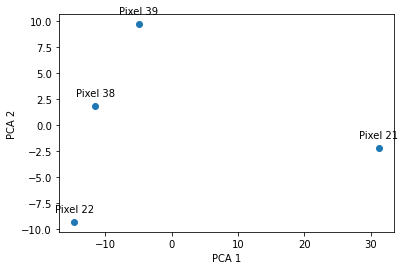

In [485]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}

#for val in val_list:
 #   new_alpha_dict[val]=sorted(alpha_dict[val])

# Convert the dictionary to a DataFrame
#df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')
df=df_alpha
# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()

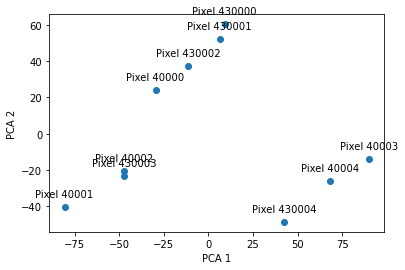

In [347]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}

#for val in val_list:
 #   new_alpha_dict[val]=sorted(alpha_dict[val])

# Convert the dictionary to a DataFrame
#df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')
df=df_alpha
# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()

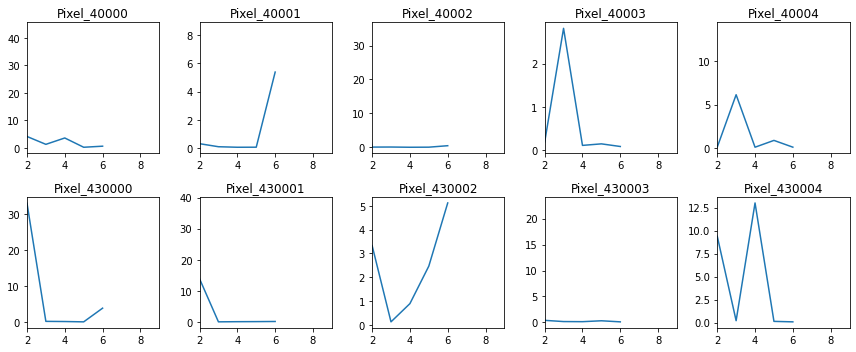

In [295]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
new_alpha_dict={}

for val in val_list:
    new_alpha_dict[val]=sorted(alpha_dict[val])

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(new_alpha_dict, orient='index')

# Run 2-component PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Create a scatter plot
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Label each data point
for i, label in enumerate(df.index):
    plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add axis labels
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Show the plot
plt.show()


In [354]:
np.corrcoef(df_flatten.T[10:20]).shape

(10, 10)

In [364]:
df_flatten

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D1    0.300000  0.040000 -0.270000 -0.280000 -0.470000 -0.310000 -0.060000   
D2   -0.029921  0.019818 -0.200119 -0.350066 -0.479891 -0.439690 -0.189920   
D3   -0.019596 -0.109822 -0.439545 -0.529029 -0.709169 -0.449427 -0.159241   
D4    0.089988  0.009961 -0.250009 -0.310015 -0.409994 -0.369962 -0.119994   
D5    0.229859  0.029788 -0.270050 -0.340120 -0.509908 -0.379816 -0.120035   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D1   -0.160000 -0.390000  0.250000  ...      0.490000      0.320000   
D2   -0.200050 -0.319442  0.270484  ...      0.369711      0.049611   
D3   -0.209545 -0.399831  0.239709  ...      0.359973      0.169925   
D4   -0.080029 -0.269921  0.250090  ...      0.479635      0.229646   
D5   -0.170163 -0.399604  0.160410  ...      0.559740      0.339370   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D1       -0.320000      0.080000     -0.350000     -0.560000     -0.110000   
D2       -0.379584      0.079738     -0.210163     -0.389584      0.069801   
D3       -0.349902      0.329909     -0.300042     -0.589903      0.079948   
D4       -0.309917     -0.019823     -0.379838     -0.479763      0.000348   
D5       -0.389725     -0.000126     -0.300059     -0.509637     -0.099995   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D1       -0.290000      0.100000      0.400000  
D2       -0.149729      0.150163      0.330000  
D3       -0.279903      0.390042      0.680000  
D4       -0.089812      0.249859      0.389802  
D5       -0.269688      0.100140      0.329947  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[226 rows x 432000 columns]

In [371]:
df_flatten_GMM_clus1.T

D3        D8        D9       D10       D11       D12  \
Pixel_1      -0.019596  0.090449  0.170455  0.140375  0.050511  0.130309   
Pixel_2      -0.109822 -0.199589 -0.209479 -0.189606 -0.159615 -0.159696   
Pixel_3      -0.439545 -0.559121 -0.589024 -0.569165 -0.459142 -0.519340   
Pixel_4      -0.529029 -0.538693 -0.538587 -0.528734 -0.478600 -0.448994   
Pixel_5      -0.709169 -0.708872 -0.688832 -0.678936 -0.658782 -0.629180   
...                ...       ...       ...       ...       ...       ...   
Pixel_431996 -0.589903 -0.679909 -0.639973 -0.659948 -0.579891 -0.609989   
Pixel_431997  0.079948 -0.080041 -0.110012 -0.080024  0.019938 -0.090005   
Pixel_431998 -0.279903 -0.349911 -0.349969 -0.339946 -0.319899 -0.349989   
Pixel_431999  0.390042  0.240047  0.260013  0.260023  0.240060  0.200006   
Pixel_432000  0.680000  0.550000  0.520000  0.510000  0.570000  0.500000   

                   D13       D15       D16       D17  ...      D217      D218  \
Pixel_1       0.230280  0.220254  0.250302  0.250184  ...  0.030408  0.100309   
Pixel_2      -0.169666 -0.139647 -0.149598 -0.139771  ... -0.219607 -0.199645   
Pixel_3      -0.569323 -0.519301 -0.529091 -0.489500  ... -0.549259 -0.549296   
Pixel_4      -0.448990 -0.429023 -0.438663 -0.399241  ... -0.518853 -0.468955   
Pixel_5      -0.629171 -0.599186 -0.598922 -0.589408  ... -0.689049 -0.669134   
...                ...       ...       ...       ...  ...       ...       ...   
Pixel_431996 -0.709995 -0.699964 -0.679945 -0.659998  ... -0.699990 -0.719981   
Pixel_431997 -0.110009 -0.160053 -0.080026 -0.110005  ... -0.100004 -0.120029   
Pixel_431998 -0.339997 -0.339982 -0.359956 -0.319998  ... -0.349990 -0.339989   
Pixel_431999  0.199992  0.169950  0.120033  0.199995  ...  0.230006  0.199974   
Pixel_432000  0.459996  0.459971  0.480000  0.439998  ...  0.560000  0.529984   

                  D219      D220      D221      D222      D223      D224  \
Pixel_1       0.040320  0.150057  0.170152  0.290177  0.170248  0.300201   
Pixel_2      -0.249714 -0.129937 -0.189773 -0.079808 -0.129707 -0.169689   
Pixel_3      -0.499543 -0.499864 -0.529571 -0.469399 -0.599004 -0.569374   
Pixel_4      -0.439300 -0.569784 -0.549361 -0.498909 -0.418477 -0.439128   
Pixel_5      -0.729389 -0.729826 -0.729451 -0.629149 -0.538824 -0.639277   
...                ...       ...       ...       ...       ...       ...   
Pixel_431996 -0.689995 -0.639991 -0.689993 -0.619981 -0.679908 -0.679984   
Pixel_431997 -0.170011 -0.110025 -0.170013 -0.110010 -0.050044 -0.100030   
Pixel_431998 -0.349996 -0.379987 -0.309997 -0.389975 -0.349924 -0.329988   
Pixel_431999  0.199988  0.299969  0.299985  0.290011  0.170056  0.199972   
Pixel_432000  0.629991  0.549988  0.499995  0.580000  0.550000  0.479985   

                  D225      D226  
Pixel_1       0.190279  0.150204  
Pixel_2      -0.169648 -0.219705  
Pixel_3      -0.509326 -0.589315  
Pixel_4      -0.409012 -0.459023  
Pixel_5      -0.599192 -0.629191  
...                ...       ...  
Pixel_431996 -0.659978 -0.699956  
Pixel_431997 -0.130035 -0.130014  
Pixel_431998 -0.349985 -0.309955  
Pixel_431999  0.179965  0.270019  
Pixel_432000  0.489979  0.520000  

[432000 rows x 171 columns]

In [375]:
columns

['pixel_1',
 'pixel_2',
 'pixel_3',
 'pixel_4',
 'pixel_5',
 'pixel_6',
 'pixel_7',
 'pixel_8',
 'pixel_9',
 'pixel_10',
 'pixel_11',
 'pixel_12',
 'pixel_13',
 'pixel_14',
 'pixel_15',
 'pixel_16',
 'pixel_17',
 'pixel_18',
 'pixel_19']

In [386]:
df_flatten_GMM_clus1

Pixel_1   Pixel_2   Pixel_3   Pixel_4   Pixel_5   Pixel_6   Pixel_7  \
D33   0.050713 -0.119699 -0.509205 -0.568426 -0.678660 -0.498952 -0.228727   
D35   0.200360 -0.129666 -0.569234 -0.518777 -0.649042 -0.449353 -0.149141   
D36   0.310148 -0.079796 -0.489516 -0.379274 -0.569406 -0.439611 -0.109452   
D38   0.320192 -0.089767 -0.489426 -0.409048 -0.609217 -0.429490 -0.139252   
D40   0.220173 -0.169779 -0.559529 -0.529274 -0.699393 -0.419640 -0.089495   
...        ...       ...       ...       ...       ...       ...       ...   
D222  0.290177 -0.079808 -0.469399 -0.498909 -0.629149 -0.369544 -0.119320   
D223  0.170248 -0.129707 -0.599004 -0.418477 -0.538824 -0.479156 -0.128885   
D224  0.300201 -0.169689 -0.569374 -0.439128 -0.639277 -0.449569 -0.139385   
D225  0.190279 -0.169648 -0.509326 -0.409012 -0.599192 -0.429542 -0.109367   
D226  0.150204 -0.219705 -0.589315 -0.459023 -0.629191 -0.439523 -0.089374   

       Pixel_8   Pixel_9  Pixel_10  ...  Pixel_431991  Pixel_431992  \
D33  -0.209332 -0.389616  0.289563  ...      0.279936      0.069832   
D35  -0.159518 -0.369947  0.189602  ...      0.409996      0.210001   
D36  -0.119678 -0.369918  0.189713  ...      0.459931      0.270014   
D38  -0.129592 -0.349950  0.199658  ...      0.419991      0.260002   
D40  -0.119708 -0.379953  0.169765  ...      0.419977      0.280003   
...        ...       ...       ...  ...           ...           ...   
D222 -0.129564 -0.449788  0.109815  ...      0.509995      0.369975   
D223 -0.159285 -0.349686  0.249644  ...      0.389980      0.249905   
D224 -0.129647 -0.379935  0.149738  ...      0.449951      0.310007   
D225 -0.119622 -0.369920  0.179664  ...      0.459940      0.340008   
D226 -0.129617 -0.399842  0.099835  ...      0.439988      0.289954   

      Pixel_431993  Pixel_431994  Pixel_431995  Pixel_431996  Pixel_431997  \
D33      -0.479749      0.339819     -0.250083     -0.519789      0.169868   
D35      -0.339997      0.249997     -0.359997     -0.649999     -0.010003   
D36      -0.279959      0.269959     -0.349954     -0.619980     -0.040043   
D38      -0.289994      0.249995     -0.359994     -0.589998     -0.040006   
D40      -0.299986      0.229987     -0.389985     -0.599995     -0.050014   
...            ...           ...           ...           ...           ...   
D222     -0.309981      0.189979     -0.380009     -0.619981     -0.110010   
D223     -0.399909      0.219927     -0.280058     -0.679908     -0.050044   
D224     -0.299968      0.229972     -0.379968     -0.679984     -0.100030   
D225     -0.279959      0.219967     -0.319964     -0.659978     -0.130035   
D226     -0.309956      0.259954     -0.330029     -0.699956     -0.130014   

      Pixel_431998  Pixel_431999  Pixel_432000  
D33      -0.259807      0.370073      0.610000  
D35      -0.339998      0.239997      0.549999  
D36      -0.329978      0.169963      0.469978  
D38      -0.329997      0.199995      0.489997  
D40      -0.329993      0.259985      0.519994  
...            ...           ...           ...  
D222     -0.389975      0.290011      0.580000  
D223     -0.349924      0.170056      0.550000  
D224     -0.329988      0.199972      0.479985  
D225     -0.349985      0.179965      0.489979  
D226     -0.309955      0.270019      0.520000  

[151 rows x 432000 columns]

In [406]:
df_flatten_GMM_clus1.T.iloc[[40002,430003],:]

D3        D8        D9       D10       D11       D12  \
Pixel_40003  -0.099943 -0.079912 -0.069988 -0.059963 -0.089893 -0.050008   
Pixel_430004 -0.300085 -0.300174 -0.270196 -0.320117 -0.280155 -0.330078   

                   D13       D15       D16       D17  ...      D217      D218  \
Pixel_40003  -0.040016 -0.020032 -0.079932 -0.020065  ... -0.059959 -0.010029   
Pixel_430004 -0.330091 -0.330062 -0.310175 -0.350080  ... -0.350087 -0.360047   

                  D219      D220      D221      D222      D223      D224  \
Pixel_40003  -0.020049  0.019978 -0.040057 -0.020092 -0.020062 -0.030056   
Pixel_430004 -0.230070 -0.370003 -0.380061 -0.430079 -0.220306 -0.340071   

                  D225      D226  
Pixel_40003  -0.020021  0.019954  
Pixel_430004 -0.290084 -0.390094  

[2 rows x 171 columns]

<AxesSubplot:>

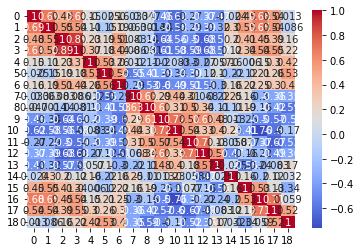

In [433]:
sns.heatmap(np.corrcoef(df_flatten_GMM_clus1.T[1:20]),annot=True,  cmap="coolwarm")

In [459]:
np.corrcoef(df_flatten_GMM_clus1.T.iloc[[22,38],:])

array([[1.        , 0.99999727],
       [0.99999727, 1.        ]])

<AxesSubplot:>

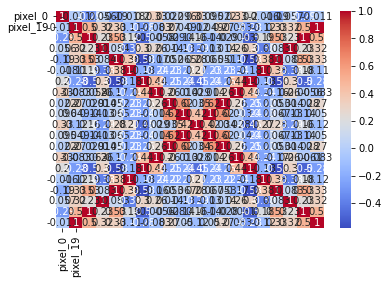

In [454]:
sns.heatmap(np.corrcoef(df_flatten_GMM_clus1.T[20:40]), annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")

['pixel_0', 'pixel_19']


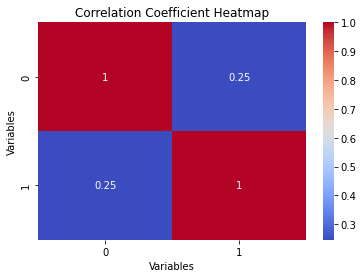

In [396]:
columns = [f'Pixel_{i}' for i in range(1, 20)]
columns=['pixel_0','pixel_19']
print(columns)
# Create a heatmap using seaborn
#corr = np.corrcoef(df_flatten_GMM_clus1.T[['Pixel_1', 'Pixel_20']])

#sns.heatmap(np.corrcoef(df_flatten_GMM_clus1.T[1:20]), annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")
sns.heatmap(np.corrcoef(df_flatten_GMM_clus1.T.iloc[[0,19],:]), annot=True,cmap="coolwarm")
#sns.heatmap(corr, annot=True, xticklabels=columns, yticklabels=columns, cmap="coolwarm")
# Add labels and title
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()


In [413]:
from scipy.stats import pearsonr

In [411]:
df_flatten_GMM_clus1['Pixel_1']

D3     -0.019596
D8      0.090449
D9      0.170455
D10     0.140375
D11     0.050511
          ...   
D222    0.290177
D223    0.170248
D224    0.300201
D225    0.190279
D226    0.150204
Name: Pixel_1, Length: 171, dtype: float64

In [417]:
corr, p_val = pearsonr(df_flatten_GMM_clus1['Pixel_40003'], df_flatten_GMM_clus1['Pixel_430004'])
corr

-0.458071289168422